In [1]:
!pip install -q torchinfo

In [2]:
!nvidia-smi

Thu May 30 17:42:48 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## Import lib

In [3]:
# run 11111111
import os
import tarfile
import scipy.io
import numpy as np
import pandas as pd
from tqdm import tqdm, trange
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from torch.utils.data import DataLoader
from torchinfo import summary

from torchvision.transforms import ToTensor
from torchvision.datasets.mnist import MNIST
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator

np.random.seed(0)
torch.manual_seed(0)

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
os.chdir("/content/drive/MyDrive/3_XuLyAnh_Flowers")
os.getcwd()

'/content/drive/.shortcut-targets-by-id/1tU35xhAZwBdemxnc1j9Q3JzeU3wbyFMK/3_XuLyAnh_Flowers'

In [6]:
IMG_SIZE      = 224
BATCH_SIZE    = 4
RANDOM_SEED   = 42

## Data

In [7]:
DATA_PATH = os.getcwd()
PATH = os.getcwd() + "/jpg/"

In [8]:
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]


df = pd.DataFrame()
df['Id'] = sorted(get_all_filenames(DATA_PATH + '/102flowers.tgz'))

# load file label:  label (1 -> 102) == -1 ==>  (0 -> 101)
df['Category'] = scipy.io.loadmat(DATA_PATH + '/imagelabels.mat')['labels'][0] - 1
df['Category'] = df['Category'].astype(str)

In [9]:
top_15_categories = ['48', '76', '42', '72', '89', '73', '81', '95', '88', '77', '37', '39', '83', '96', '74']

In [10]:
# Lọc DataFrame ban đầu
df_15 = df[df['Category'].isin(top_15_categories)]

In [11]:
train_files, test_files, train_labels, test_labels = \
    train_test_split(
        df_15['Id'],
        df_15['Category'],
        test_size = 0.2,
        random_state = 42,
        stratify = df_15['Category']
)
train_files = pd.DataFrame(train_files)
test_files = pd.DataFrame(test_files)
train_files['Category'] = train_labels
test_files['Category'] = test_labels
train_files.shape, test_files.shape

((1436, 2), (360, 2))

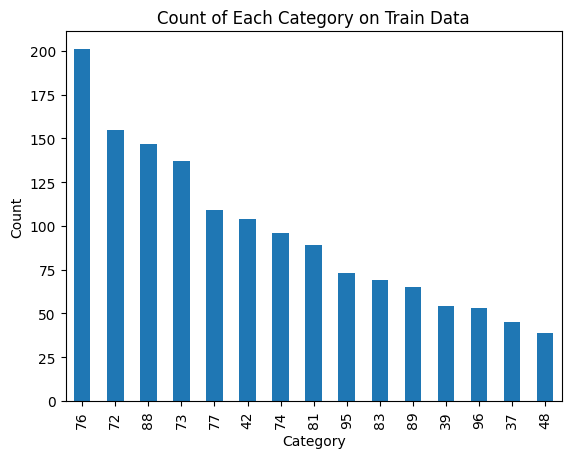

In [12]:
# Đoạn mã để đếm giá trị của cột "Category" và vẽ biểu đồ cột
train_files['Category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Count of Each Category on Train Data')
plt.show()

### Data augmentation

In [13]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    rotation_range = 50,
    shear_range = 0.2,
    zoom_range = [0.75, 1.25],
    brightness_range = [0.5, 1.5],
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    horizontal_flip = True
)
test_datagen = ImageDataGenerator(rescale = 1. / 255)

In [14]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = True,
    seed = RANDOM_SEED
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_files,
    directory = DATA_PATH,
    x_col = 'Id',
    y_col = 'Category',
    target_size = (IMG_SIZE, IMG_SIZE),
    batch_size = BATCH_SIZE,
    class_mode = 'categorical',
    shuffle = False,
    seed = RANDOM_SEED
)

Found 1436 validated image filenames belonging to 15 classes.
Found 360 validated image filenames belonging to 15 classes.


In [15]:
train_generator.samples

1436

Ví dụ về hình ảnh từ train_generator


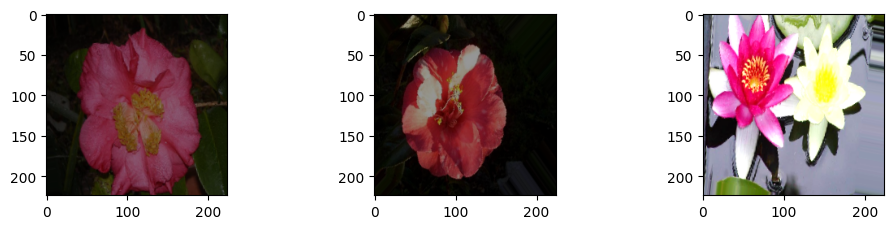

In [16]:
from skimage import io

def imshow(image_RGB):
    io.imshow(image_RGB)
    io.show()

x, y = train_generator.next()
print('Ví dụ về hình ảnh từ train_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 3):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

Ví dụ về hình ảnh từ test_generator


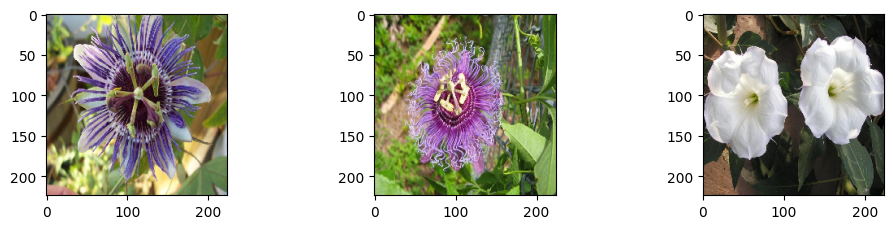

In [17]:
x, y = test_generator.next()
print('Ví dụ về hình ảnh từ test_generator')
plt.figure(figsize = (12, 8))

for i in range(0, 3):
    image = x[i]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
#     plt.title('Class: ' + str(y[i]))
#     plt.axis('off')

plt.show()

## ViT Model

### Step 4: Create Patch Embedding Layer

In [18]:
PATCH_SIZE = 16
IMAGE_WIDTH = 224
IMAGE_HEIGHT = IMAGE_WIDTH
IMAGE_CHANNELS = 3
EMBEDDING_DIMS = IMAGE_CHANNELS * PATCH_SIZE**2
NUM_OF_PATCHES = int((IMAGE_WIDTH * IMAGE_HEIGHT) / PATCH_SIZE**2)
# NUM_OF_PATCHES = 27*27

#the image width and image height should be divisible by patch size. This is a check to see that.

assert IMAGE_WIDTH % PATCH_SIZE == 0 and IMAGE_HEIGHT % PATCH_SIZE ==0 , print("Image Width is not divisible by patch size")

In [19]:
conv_layer = nn.Conv2d(in_channels = IMAGE_CHANNELS, out_channels = EMBEDDING_DIMS, kernel_size = PATCH_SIZE, stride = PATCH_SIZE)

torch.Size([4, 224, 224, 3])
torch.Size([4, 3, 224, 224])


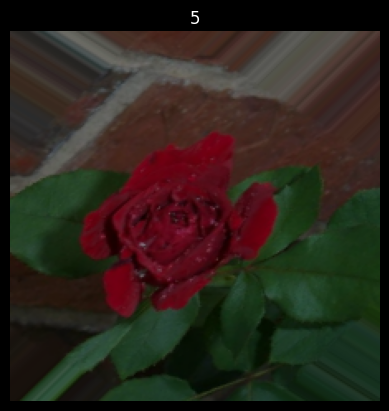

In [20]:
random_images, random_labels = next(iter(train_generator))
random_images = torch.from_numpy(random_images)
print(random_images.shape)
random_images = random_images.permute((0, 3, 1, 2))
print(random_images.shape)
random_image = random_images[0]

# Create a new figure
fig = plt.figure(1)

# # Chuyển random_image thành tensor
# random_image_tensor = torch.from_numpy(random_image)

# Display the random image
plt.imshow(random_image.permute((1, 2, 0)))

# Disable the axis for better visualization
plt.axis(False)

# Set the title of the image
plt.title(np.argmax(random_labels[0]), color="white")

# Set the background color of the figure as black
fig.set_facecolor(color="black")

### Stem block in GoogLenet

In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class StemBlock(nn.Module):
    def __init__(self):
        super(StemBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1)
        self.conv3 = nn.Conv2d(in_channels=256, out_channels=768, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool2(x)
        return x


# random_images, random_labels = next(iter(train_generator))
# random_images = torch.from_numpy(random_images)
# print(random_images.shape)
# random_images = random_images.permute((0, 3, 1, 2))
# print(random_images.shape)
# Sử dụng StemBlock
# input_tensor = torch.randn(1, 3, 224, 224)  # Example input tensor with shape (batch_size, channels, height, width)
stem_block = StemBlock()
output_tensor = stem_block(random_images)
print(output_tensor.shape)  # In ra kích thước tensor đầu ra

torch.Size([4, 768, 27, 27])


In [22]:
# Pass the image through the convolution layer
print(random_image.shape)
image_through_conv = conv_layer(random_image.unsqueeze(0))
print(f'Shape of embeddings through the conv layer -> {list(image_through_conv.shape)} <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]')

# Permute the dimensions of image_through_conv to match the expected shape
image_through_conv = image_through_conv.permute((0, 2, 3, 1))

# Create a flatten layer using nn.Flatten
flatten_layer = nn.Flatten(start_dim=1, end_dim=2)

# Pass the image_through_conv through the flatten layer
image_through_conv_and_flatten = flatten_layer(image_through_conv)

# Print the shape of the embedded image
print(f'Shape of embeddings through the flatten layer -> {list(image_through_conv_and_flatten.shape)} <- [batch_size, num_of_patches, embedding_dims]')

# Assign the embedded image to a variable
embedded_image = image_through_conv_and_flatten

torch.Size([3, 224, 224])
Shape of embeddings through the conv layer -> [1, 768, 14, 14] <- [batch_size, num_of_patch_rows,num_patch_cols embedding_dims]
Shape of embeddings through the flatten layer -> [1, 196, 768] <- [batch_size, num_of_patches, embedding_dims]


In [23]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [24]:
position = get_positional_embeddings(14**2 + 1, 768)
print(position.shape)

torch.Size([197, 768])


In [ ]:
# class_token_embeddings = nn.Parameter(torch.rand((1, 1,EMBEDDING_DIMS), requires_grad  = True))
# print(f'Shape of class_token_embeddings --> {list(class_token_embeddings.shape)} <-- [batch_size, 1, emdedding_dims]')

# embedded_image_with_class_token_embeddings = torch.cat((class_token_embeddings, embedded_image), dim = 1)
# print(f'\nShape of image embeddings with class_token_embeddings --> {list(embedded_image_with_class_token_embeddings.shape)} <-- [batch_size, num_of_patches+1, embeddiing_dims]')

# position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES+1, EMBEDDING_DIMS ), requires_grad = True ))
# print(f'\nShape of position_embeddings --> {list(position_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

# final_embeddings = embedded_image_with_class_token_embeddings + position_embeddings
# print(f'\nShape of final_embeddings --> {list(final_embeddings.shape)} <-- [batch_size, num_patches+1, embeddings_dims]')

Put the PatchEmbedddingLayer Together

In [25]:
class PatchEmbeddingLayer(nn.Module):
    def __init__(self, in_channels, patch_size, embedding_dim,):
        super().__init__()
        self.patch_size = patch_size
        self.embedding_dim = embedding_dim
        self.in_channels = in_channels
        self.conv_layer = nn.Conv2d(in_channels=in_channels, out_channels=embedding_dim, kernel_size=patch_size, stride=patch_size)
        # self.cnn_layer = StemBlock()
        self.flatten_layer = nn.Flatten(start_dim=1, end_dim=2)
        self.class_token_embeddings = nn.Parameter(torch.rand((BATCH_SIZE, 1, EMBEDDING_DIMS), requires_grad=True))
        self.register_buffer('position_embeddings', get_positional_embeddings(14 ** 2 + 1, EMBEDDING_DIMS), persistent=False)
        # self.position_embeddings = nn.Parameter(torch.rand((1, NUM_OF_PATCHES + 1, EMBEDDING_DIMS), requires_grad=True))

    def forward(self, x):
        # print(x.shape)
        # print(self.cnn_layer(x).shape, self.conv_layer(x).shape)
        # print(self.cnn_layer(x).permute((0, 2, 3, 1)).shape, self.conv_layer(x).permute((0, 2, 3, 1)).shape)
        # print(self.flatten_layer(self.cnn_layer(x).permute((0, 2, 3, 1))).shape, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1))).shape)
        # print(self.class_token_embeddings.shape)

        # print(torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1).shape)
        # print(self.position_embeddings.repeat(x.shape[0], 1, 1).shape)

        output = torch.cat((self.class_token_embeddings, self.flatten_layer(self.conv_layer(x).permute((0, 2, 3, 1)))), dim=1) + self.position_embeddings.repeat(x.shape[0], 1, 1)
        # print(output.shape)
        return output

In [26]:
patch_embedding_layer = PatchEmbeddingLayer(in_channels=IMAGE_CHANNELS, patch_size=PATCH_SIZE, embedding_dim=IMAGE_CHANNELS * PATCH_SIZE ** 2)
print(random_images.shape)
patch_embeddings = patch_embedding_layer(random_images)
print(patch_embeddings.shape)

torch.Size([4, 3, 224, 224])
torch.Size([4, 197, 768])


In [27]:
summary(model=patch_embedding_layer,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, input_channels, img_width, img_height)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
PatchEmbeddingLayer (PatchEmbeddingLayer)     [4, 3, 224, 224]     [4, 197, 768]        3,072                True
├─Conv2d (conv_layer)                         [4, 3, 224, 224]     [4, 768, 14, 14]     590,592              True
├─Flatten (flatten_layer)                     [4, 14, 14, 768]     [4, 196, 768]        --                   --
Total params: 593,664
Trainable params: 593,664
Non-trainable params: 0
Total mult-adds (M): 463.02
Input size (MB): 2.41
Forward/backward pass size (MB): 4.82
Params size (MB): 2.36
Estimated Total Size (MB): 9.59

### Step 5. Creating the Multi-Head Self Attention (MSA) Block.

In [28]:
class MultiHeadSelfAttentionBlock(nn.Module):
  def __init__(self,
               embedding_dims = 768, # Hidden Size D in the ViT Paper Table 1
               num_heads = 12,  # Heads in the ViT Paper Table 1
               attn_dropout = 0.0 # Default to Zero as there is no dropout for the the MSA Block as per the ViT Paper
               ):
    super().__init__()

    self.embedding_dims = embedding_dims
    self.num_head = num_heads
    self.attn_dropout = attn_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)

    self.multiheadattention =  nn.MultiheadAttention(num_heads = num_heads,
                                                     embed_dim = embedding_dims,
                                                     dropout = attn_dropout,
                                                     batch_first = True,
                                                    )

  def forward(self, x):
    x = self.layernorm(x)
    output,_ = self.multiheadattention(query=x, key=x, value=x,need_weights=False)
    return output

In [29]:
multihead_self_attention_block = MultiHeadSelfAttentionBlock(embedding_dims = EMBEDDING_DIMS,
                                                             num_heads = 12
                                                             )
print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from MSA Block => {list(multihead_self_attention_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

Shape of the input Patch Embeddings => [4, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from MSA Block => [4, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


In [30]:
summary(model=multihead_self_attention_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
MultiHeadSelfAttentionBlock (MultiHeadSelfAttentionBlock)    [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                                      [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (multiheadattention)                    --                   [1, 197, 768]        2,362,368            True
Total params: 2,363,904
Trainable params: 2,363,904
Non-trainable params: 0
Total mult-adds (M): 0.00
Input size (MB): 0.61
Forward/backward pass size (MB): 1.21
Params size (MB): 0.01
Estimated Total Size (MB): 1.82

### Step 6. Creating the Machine Learning Perceptron (MLP) Block

In [31]:
class MachineLearningPerceptronBlock(nn.Module):
  def __init__(self, embedding_dims, mlp_size, mlp_dropout):
    super().__init__()
    self.embedding_dims = embedding_dims
    self.mlp_size = mlp_size
    self.dropout = mlp_dropout

    self.layernorm = nn.LayerNorm(normalized_shape = embedding_dims)
    self.mlp = nn.Sequential(
        nn.Linear(in_features = embedding_dims, out_features = mlp_size),
        nn.GELU(),
        nn.Dropout(p = mlp_dropout),
        nn.Linear(in_features = mlp_size, out_features = embedding_dims),
        nn.Dropout(p = mlp_dropout)
    )

  def forward(self, x):
    return self.mlp(self.layernorm(x))

In [32]:
mlp_block = MachineLearningPerceptronBlock(embedding_dims = EMBEDDING_DIMS,
                                           mlp_size = 3072,
                                           mlp_dropout = 0.1)

summary(model=mlp_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
MachineLearningPerceptronBlock (MachineLearningPerceptronBlock)   [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (layernorm)                                           [1, 197, 768]        [1, 197, 768]        1,536                True
├─Sequential (mlp)                                                [1, 197, 768]        [1, 197, 768]        --                   True
│    └─Linear (0)                                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
│    └─GELU (1)                                                   [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Dropout (2)                                                [1, 197, 3072]       [1, 197, 3072]       --                   --
│    └─Linear (3)                                            

### Step 7. Putting together the Transformer Block

In [33]:
class TransformerBlock(nn.Module):
  def __init__(self, embedding_dims = 768,
               mlp_dropout=0.1,
               attn_dropout=0.0,
               mlp_size = 3072,
               num_heads = 12,
               ):
    super().__init__()

    self.msa_block = MultiHeadSelfAttentionBlock(embedding_dims = embedding_dims,
                                                 num_heads = num_heads,
                                                 attn_dropout = attn_dropout)

    self.mlp_block = MachineLearningPerceptronBlock(embedding_dims = embedding_dims,
                                                    mlp_size = mlp_size,
                                                    mlp_dropout = mlp_dropout,
                                                    )

  def forward(self,x):
    x = self.msa_block(x) + x
    x = self.mlp_block(x) + x

    return x

In [34]:
transformer_block = TransformerBlock(embedding_dims = EMBEDDING_DIMS,
                                     mlp_dropout = 0.1,
                                     attn_dropout=0.0,
                                     mlp_size = 3072,
                                     num_heads = 12)

print(f'Shape of the input Patch Embeddings => {list(patch_embeddings.shape)} <= [batch_size, num_patches+1, embedding_dims ]')
print(f'Shape of the output from Transformer Block => {list(transformer_block(patch_embeddings).shape)} <= [batch_size, num_patches+1, embedding_dims ]')

Shape of the input Patch Embeddings => [4, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]
Shape of the output from Transformer Block => [4, 197, 768] <= [batch_size, num_patches+1, embedding_dims ]


In [35]:
summary(model=transformer_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerBlock (TransformerBlock)                [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multiheadattention)     --                   [1, 197, 768]        2,362,368            True
├─MachineLearningPerceptronBlock (mlp_block)       [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layernorm)                       [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

### Step 8. Creating the ViT Model

In [36]:
class ViT(nn.Module):
  def __init__(self, img_size = 224,
               in_channels = 3,
               patch_size = 16,
               embedding_dims = 768,
               num_transformer_layers = 12, # from table 1 above
               mlp_dropout = 0.1,
               attn_dropout = 0.0,
               mlp_size = 3072,
               num_heads = 12,
               num_classes = 15):
    super().__init__()

    self.patch_embedding_layer = PatchEmbeddingLayer(in_channels = in_channels,
                                                     patch_size=patch_size,
                                                     embedding_dim = embedding_dims)

    self.transformer_encoder = nn.Sequential(*[TransformerBlock(embedding_dims = embedding_dims,
                                              mlp_dropout = mlp_dropout,
                                              attn_dropout = attn_dropout,
                                              mlp_size = mlp_size,
                                              num_heads = num_heads) for _ in range(num_transformer_layers)])

    self.classifier = nn.Sequential(nn.LayerNorm(normalized_shape = embedding_dims),
                                    nn.Linear(in_features = embedding_dims,
                                              out_features = num_classes))

  def forward(self, x):
    return self.classifier(self.transformer_encoder(self.patch_embedding_layer(x))[:, 0])

In [37]:
vit = ViT()
summary(model=vit,
        input_size=(BATCH_SIZE, 3, 224, 224), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                    [4, 3, 224, 224]     [4, 15]              --                   True
├─PatchEmbeddingLayer (patch_embedding_layer)                [4, 3, 224, 224]     [4, 197, 768]        3,072                True
│    └─Conv2d (conv_layer)                                   [4, 3, 224, 224]     [4, 768, 14, 14]     590,592              True
│    └─Flatten (flatten_layer)                               [4, 14, 14, 768]     [4, 196, 768]        --                   --
├─Sequential (transformer_encoder)                           [4, 197, 768]        [4, 197, 768]        --                   True
│    └─TransformerBlock (0)                                  [4, 197, 768]        [4, 197, 768]        --                   True
│    │    └─MultiHeadSelfAttentionBlock (msa_block)          [4, 197, 768]        [4, 197, 768

## Training

In [38]:
# Defining model and training options
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device: ", device, f"({torch.cuda.get_device_name(device)})" if torch.cuda.is_available() else "")
# 250/10=25  => n_patches = 25, size_sub_image = 3*10*10 => hidden_d = 1024 => n_heads=16, out_d = 15
# 250/25=10 => n_patches = 10, size_sub_image = 3*25*25 => hidden_d = 1024 => n_heads=16, out_d = 15
model = ViT().to(device)


Using device:  cuda (Tesla T4)


In [39]:
N_EPOCHS = 20
LR = 0.005

In [40]:
# Training loop
optimizer = Adam(model.parameters(), lr=LR)
criterion = CrossEntropyLoss().to(device)
for epoch in trange(N_EPOCHS, desc="Training"):
    train_loss = 0.0
    total_batches = len(train_generator)
    print(total_batches)
    processed_batches = 0
    # change here
    for batch in tqdm(train_generator, desc=f"Epoch {epoch + 1} in training", leave=False, dynamic_ncols=True):
        x, y = batch
        x = torch.tensor(x, dtype=torch.float32).to(device).permute(0, 3, 1, 2)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        # print(y)
        # Sử dụng argmax để lấy chỉ số của giá trị lớn nhất trong mỗi hàng
        y = torch.argmax(y, dim=1)
        # print(y)
        # print("\nx.shape", x.shape)
        # x, y = x.to(device), y.to(device)
        y_hat = model(x)
        # print(y_hat)
        # print(y)
        loss = criterion(y_hat, y)
        print(loss)
        train_loss += loss.detach().cpu().item() / len(train_generator)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        processed_batches += 1
        if processed_batches>total_batches:
          break

    print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

Training:   0%|          | 0/20 [00:00<?, ?it/s]

359



Epoch 1 in training:   0%|          | 0/359 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


tensor(3.1618, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   1%|          | 2/359 [00:05<15:58,  2.68s/it]

tensor(5.9968, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   1%|          | 3/359 [00:08<16:44,  2.82s/it]

tensor(4.7570, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   1%|          | 4/359 [00:11<15:59,  2.70s/it]

tensor(8.6776, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   1%|▏         | 5/359 [00:13<14:49,  2.51s/it]

tensor(5.4703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   2%|▏         | 6/359 [00:15<14:01,  2.38s/it]

tensor(4.1968, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   2%|▏         | 7/359 [00:17<13:25,  2.29s/it]

tensor(4.3393, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   2%|▏         | 8/359 [00:19<12:40,  2.17s/it]

tensor(7.3129, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   3%|▎         | 9/359 [00:21<13:15,  2.27s/it]

tensor(5.7897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   3%|▎         | 10/359 [00:23<12:43,  2.19s/it]

tensor(4.3641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   3%|▎         | 11/359 [00:26<12:54,  2.22s/it]

tensor(5.9846, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   3%|▎         | 12/359 [00:28<12:22,  2.14s/it]

tensor(3.7306, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   4%|▎         | 13/359 [00:30<12:06,  2.10s/it]

tensor(5.1273, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   4%|▍         | 14/359 [00:32<12:25,  2.16s/it]

tensor(9.5475, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   4%|▍         | 15/359 [00:34<12:23,  2.16s/it]

tensor(4.6913, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   4%|▍         | 16/359 [00:36<12:24,  2.17s/it]

tensor(5.7208, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   5%|▍         | 17/359 [00:38<12:25,  2.18s/it]

tensor(5.3805, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   5%|▌         | 18/359 [00:40<11:57,  2.11s/it]

tensor(7.8176, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   5%|▌         | 19/359 [00:43<12:29,  2.20s/it]

tensor(5.6960, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   6%|▌         | 20/359 [00:45<12:20,  2.18s/it]

tensor(5.3398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   6%|▌         | 21/359 [00:47<12:48,  2.27s/it]

tensor(5.5174, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   6%|▌         | 22/359 [00:49<11:52,  2.11s/it]

tensor(7.2870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   6%|▋         | 23/359 [00:52<12:14,  2.19s/it]

tensor(6.2850, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   7%|▋         | 24/359 [00:53<11:29,  2.06s/it]

tensor(2.5158, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   7%|▋         | 25/359 [00:55<11:20,  2.04s/it]

tensor(4.2701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   7%|▋         | 26/359 [00:57<11:31,  2.08s/it]

tensor(4.5668, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   8%|▊         | 27/359 [01:00<11:36,  2.10s/it]

tensor(4.5757, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   8%|▊         | 28/359 [01:02<11:23,  2.06s/it]

tensor(4.9407, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   8%|▊         | 29/359 [01:04<11:46,  2.14s/it]

tensor(6.5983, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   8%|▊         | 30/359 [01:06<11:44,  2.14s/it]

tensor(2.9649, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   9%|▊         | 31/359 [01:08<11:21,  2.08s/it]

tensor(3.1555, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   9%|▉         | 32/359 [01:10<11:26,  2.10s/it]

tensor(4.6761, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   9%|▉         | 33/359 [01:12<11:30,  2.12s/it]

tensor(4.2475, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:   9%|▉         | 34/359 [01:15<11:45,  2.17s/it]

tensor(2.9222, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  10%|▉         | 35/359 [01:17<11:29,  2.13s/it]

tensor(4.2768, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  10%|█         | 36/359 [01:18<10:59,  2.04s/it]

tensor(4.2542, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  10%|█         | 37/359 [01:21<11:20,  2.11s/it]

tensor(4.3637, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  11%|█         | 38/359 [01:23<11:28,  2.14s/it]

tensor(4.0799, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  11%|█         | 39/359 [01:25<11:07,  2.09s/it]

tensor(4.2191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  11%|█         | 40/359 [01:27<11:00,  2.07s/it]

tensor(3.1658, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  11%|█▏        | 41/359 [01:29<11:41,  2.21s/it]

tensor(2.7068, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  12%|█▏        | 42/359 [01:32<11:30,  2.18s/it]

tensor(3.4023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  12%|█▏        | 43/359 [01:33<11:01,  2.09s/it]

tensor(3.3557, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  12%|█▏        | 44/359 [01:36<11:02,  2.10s/it]

tensor(2.7770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  13%|█▎        | 45/359 [01:38<10:55,  2.09s/it]

tensor(4.5157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  13%|█▎        | 46/359 [01:40<11:12,  2.15s/it]

tensor(2.9423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  13%|█▎        | 47/359 [01:42<10:55,  2.10s/it]

tensor(4.7470, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  13%|█▎        | 48/359 [01:44<11:10,  2.16s/it]

tensor(4.4630, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  14%|█▎        | 49/359 [01:46<10:54,  2.11s/it]

tensor(3.4396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  14%|█▍        | 50/359 [01:48<10:33,  2.05s/it]

tensor(3.4176, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  14%|█▍        | 51/359 [01:50<10:15,  2.00s/it]

tensor(2.2119, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  14%|█▍        | 52/359 [01:52<10:49,  2.12s/it]

tensor(4.2156, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  15%|█▍        | 53/359 [01:55<11:11,  2.19s/it]

tensor(4.2445, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  15%|█▌        | 54/359 [01:57<11:13,  2.21s/it]

tensor(3.6758, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  15%|█▌        | 55/359 [01:59<10:16,  2.03s/it]

tensor(4.6557, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  16%|█▌        | 56/359 [02:03<13:03,  2.59s/it]

tensor(5.5283, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  16%|█▌        | 57/359 [02:05<12:32,  2.49s/it]

tensor(4.2099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  16%|█▌        | 58/359 [02:07<12:19,  2.46s/it]

tensor(3.5945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  16%|█▋        | 59/359 [02:09<11:36,  2.32s/it]

tensor(2.9789, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  17%|█▋        | 60/359 [02:11<11:08,  2.23s/it]

tensor(3.4876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  17%|█▋        | 61/359 [02:13<10:43,  2.16s/it]

tensor(4.3274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  17%|█▋        | 62/359 [02:16<11:04,  2.24s/it]

tensor(3.7089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  18%|█▊        | 63/359 [02:18<10:54,  2.21s/it]

tensor(4.6418, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  18%|█▊        | 64/359 [02:20<10:39,  2.17s/it]

tensor(3.5352, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  18%|█▊        | 65/359 [02:22<10:29,  2.14s/it]

tensor(4.0385, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  18%|█▊        | 66/359 [02:24<10:31,  2.16s/it]

tensor(4.1349, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  19%|█▊        | 67/359 [02:26<10:16,  2.11s/it]

tensor(3.2346, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  19%|█▉        | 68/359 [02:28<10:10,  2.10s/it]

tensor(2.6903, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  19%|█▉        | 69/359 [02:30<10:16,  2.13s/it]

tensor(2.6202, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  19%|█▉        | 70/359 [02:32<10:00,  2.08s/it]

tensor(2.6339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  20%|█▉        | 71/359 [02:35<10:09,  2.12s/it]

tensor(3.3489, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  20%|██        | 72/359 [02:37<10:27,  2.19s/it]

tensor(2.8338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  20%|██        | 73/359 [02:39<10:08,  2.13s/it]

tensor(2.4573, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  21%|██        | 74/359 [02:41<10:07,  2.13s/it]

tensor(2.3742, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  21%|██        | 75/359 [02:43<10:21,  2.19s/it]

tensor(3.4330, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  21%|██        | 76/359 [02:45<09:51,  2.09s/it]

tensor(3.4533, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  21%|██▏       | 77/359 [02:47<09:46,  2.08s/it]

tensor(2.8558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  22%|██▏       | 78/359 [02:50<10:01,  2.14s/it]

tensor(2.7198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  22%|██▏       | 79/359 [02:51<09:36,  2.06s/it]

tensor(2.6619, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  22%|██▏       | 80/359 [02:53<09:18,  2.00s/it]

tensor(6.4951, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  23%|██▎       | 81/359 [02:56<09:40,  2.09s/it]

tensor(3.3375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  23%|██▎       | 82/359 [02:58<09:32,  2.07s/it]

tensor(3.6542, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  23%|██▎       | 83/359 [03:00<09:21,  2.04s/it]

tensor(3.9537, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  23%|██▎       | 84/359 [03:01<09:00,  1.96s/it]

tensor(2.9772, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  24%|██▎       | 85/359 [03:04<09:16,  2.03s/it]

tensor(2.8185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  24%|██▍       | 86/359 [03:06<09:12,  2.02s/it]

tensor(1.8510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  24%|██▍       | 87/359 [03:08<09:32,  2.10s/it]

tensor(2.7889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  25%|██▍       | 88/359 [03:10<09:34,  2.12s/it]

tensor(3.7964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  25%|██▍       | 89/359 [03:12<09:19,  2.07s/it]

tensor(2.6331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  25%|██▌       | 90/359 [03:15<10:15,  2.29s/it]

tensor(3.0827, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  25%|██▌       | 91/359 [03:17<09:56,  2.23s/it]

tensor(4.4575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  26%|██▌       | 92/359 [03:19<09:39,  2.17s/it]

tensor(3.8081, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  26%|██▌       | 93/359 [03:21<09:41,  2.19s/it]

tensor(3.0968, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  26%|██▌       | 94/359 [03:23<09:07,  2.07s/it]

tensor(2.9684, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  26%|██▋       | 95/359 [03:25<09:32,  2.17s/it]

tensor(4.8172, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  27%|██▋       | 96/359 [03:27<09:14,  2.11s/it]

tensor(3.7825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  27%|██▋       | 97/359 [03:29<08:54,  2.04s/it]

tensor(1.9967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  27%|██▋       | 98/359 [03:31<09:02,  2.08s/it]

tensor(2.7018, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  28%|██▊       | 99/359 [03:33<09:02,  2.08s/it]

tensor(3.2401, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  28%|██▊       | 100/359 [03:35<08:58,  2.08s/it]

tensor(2.5969, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  28%|██▊       | 101/359 [03:38<08:58,  2.09s/it]

tensor(3.1426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  28%|██▊       | 102/359 [03:40<08:57,  2.09s/it]

tensor(3.9100, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  29%|██▊       | 103/359 [03:42<08:49,  2.07s/it]

tensor(2.7132, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  29%|██▉       | 104/359 [03:44<08:44,  2.06s/it]

tensor(3.2890, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  29%|██▉       | 105/359 [03:46<08:39,  2.05s/it]

tensor(2.8234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  30%|██▉       | 106/359 [03:48<08:47,  2.08s/it]

tensor(3.3292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  30%|██▉       | 107/359 [03:50<09:01,  2.15s/it]

tensor(3.6372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  30%|███       | 108/359 [03:52<09:07,  2.18s/it]

tensor(3.2821, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  30%|███       | 109/359 [03:54<08:51,  2.13s/it]

tensor(2.4926, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  31%|███       | 110/359 [03:57<09:10,  2.21s/it]

tensor(2.7503, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  31%|███       | 111/359 [03:59<08:54,  2.15s/it]

tensor(3.3134, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  31%|███       | 112/359 [04:01<08:38,  2.10s/it]

tensor(2.6083, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  31%|███▏      | 113/359 [04:03<08:59,  2.19s/it]

tensor(1.7472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  32%|███▏      | 114/359 [04:05<08:37,  2.11s/it]

tensor(2.0280, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  32%|███▏      | 115/359 [04:08<09:05,  2.23s/it]

tensor(4.3126, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  32%|███▏      | 116/359 [04:10<08:43,  2.15s/it]

tensor(3.2897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  33%|███▎      | 117/359 [04:12<08:25,  2.09s/it]

tensor(5.5046, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  33%|███▎      | 118/359 [04:14<08:20,  2.08s/it]

tensor(3.4992, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  33%|███▎      | 119/359 [04:16<08:45,  2.19s/it]

tensor(3.8003, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  33%|███▎      | 120/359 [04:18<08:31,  2.14s/it]

tensor(2.9749, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  34%|███▎      | 121/359 [04:20<08:35,  2.17s/it]

tensor(3.5493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  34%|███▍      | 122/359 [04:22<08:11,  2.08s/it]

tensor(2.8980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  34%|███▍      | 123/359 [04:24<08:17,  2.11s/it]

tensor(2.6194, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  35%|███▍      | 124/359 [04:27<08:23,  2.14s/it]

tensor(3.1121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  35%|███▍      | 125/359 [04:28<08:02,  2.06s/it]

tensor(3.3398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  35%|███▌      | 126/359 [04:30<07:52,  2.03s/it]

tensor(2.8139, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  35%|███▌      | 127/359 [04:33<08:15,  2.14s/it]

tensor(2.2907, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  36%|███▌      | 128/359 [04:35<07:56,  2.06s/it]

tensor(2.2236, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  36%|███▌      | 129/359 [04:37<07:48,  2.04s/it]

tensor(2.5457, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  36%|███▌      | 130/359 [04:39<07:42,  2.02s/it]

tensor(3.1062, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  36%|███▋      | 131/359 [04:40<07:27,  1.96s/it]

tensor(3.5686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  37%|███▋      | 132/359 [04:42<07:21,  1.95s/it]

tensor(3.2901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  37%|███▋      | 133/359 [04:44<07:26,  1.98s/it]

tensor(2.3336, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  37%|███▋      | 134/359 [04:47<07:42,  2.05s/it]

tensor(3.5352, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  38%|███▊      | 135/359 [04:49<07:27,  2.00s/it]

tensor(4.1072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  38%|███▊      | 136/359 [04:51<07:22,  1.99s/it]

tensor(4.4282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  38%|███▊      | 137/359 [04:52<07:20,  1.99s/it]

tensor(2.1601, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  38%|███▊      | 138/359 [04:55<07:25,  2.02s/it]

tensor(2.4095, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  39%|███▊      | 139/359 [04:57<07:31,  2.05s/it]

tensor(2.3932, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  39%|███▉      | 140/359 [04:59<07:29,  2.05s/it]

tensor(4.1463, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  39%|███▉      | 141/359 [05:01<07:56,  2.19s/it]

tensor(4.0596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  40%|███▉      | 142/359 [05:03<07:34,  2.09s/it]

tensor(2.3844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  40%|███▉      | 143/359 [05:05<07:10,  1.99s/it]

tensor(2.4957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  40%|████      | 144/359 [05:07<07:13,  2.02s/it]

tensor(2.8728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  40%|████      | 145/359 [05:09<07:02,  1.98s/it]

tensor(1.9951, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  41%|████      | 146/359 [05:11<07:25,  2.09s/it]

tensor(4.1558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  41%|████      | 147/359 [05:13<07:16,  2.06s/it]

tensor(2.1338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  41%|████      | 148/359 [05:15<07:11,  2.04s/it]

tensor(1.1237, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  42%|████▏     | 149/359 [05:17<07:02,  2.01s/it]

tensor(5.0435, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  42%|████▏     | 150/359 [05:19<06:48,  1.95s/it]

tensor(3.1887, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  42%|████▏     | 151/359 [05:21<07:00,  2.02s/it]

tensor(3.6006, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  42%|████▏     | 152/359 [05:23<07:02,  2.04s/it]

tensor(2.7738, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  43%|████▎     | 153/359 [05:25<07:02,  2.05s/it]

tensor(3.2148, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  43%|████▎     | 154/359 [05:28<07:11,  2.11s/it]

tensor(3.2298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  43%|████▎     | 155/359 [05:29<06:54,  2.03s/it]

tensor(3.5165, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  43%|████▎     | 156/359 [05:32<07:11,  2.13s/it]

tensor(3.1267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  44%|████▎     | 157/359 [05:34<07:19,  2.17s/it]

tensor(2.8818, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  44%|████▍     | 158/359 [05:36<07:22,  2.20s/it]

tensor(2.8880, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  44%|████▍     | 159/359 [05:38<07:05,  2.13s/it]

tensor(2.5341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  45%|████▍     | 160/359 [05:40<07:03,  2.13s/it]

tensor(2.8732, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  45%|████▍     | 161/359 [05:43<07:07,  2.16s/it]

tensor(2.7515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  45%|████▌     | 162/359 [05:45<07:15,  2.21s/it]

tensor(3.6532, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  45%|████▌     | 163/359 [05:47<06:55,  2.12s/it]

tensor(2.8317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  46%|████▌     | 164/359 [05:49<06:55,  2.13s/it]

tensor(3.0967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  46%|████▌     | 165/359 [05:51<07:02,  2.18s/it]

tensor(3.2889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  46%|████▌     | 166/359 [05:54<07:02,  2.19s/it]

tensor(2.2686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  47%|████▋     | 167/359 [05:56<07:01,  2.20s/it]

tensor(3.0331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  47%|████▋     | 168/359 [05:58<06:43,  2.11s/it]

tensor(3.9627, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  47%|████▋     | 169/359 [06:00<06:41,  2.11s/it]

tensor(2.7818, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  47%|████▋     | 170/359 [06:02<06:49,  2.16s/it]

tensor(2.5357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  48%|████▊     | 171/359 [06:04<06:44,  2.15s/it]

tensor(2.9842, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  48%|████▊     | 172/359 [06:06<06:32,  2.10s/it]

tensor(1.9578, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  48%|████▊     | 173/359 [06:08<06:22,  2.06s/it]

tensor(2.7648, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  48%|████▊     | 174/359 [06:10<06:24,  2.08s/it]

tensor(3.8238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  49%|████▊     | 175/359 [06:12<06:25,  2.10s/it]

tensor(3.1373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  49%|████▉     | 176/359 [06:14<06:23,  2.10s/it]

tensor(3.5335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  49%|████▉     | 177/359 [06:16<06:09,  2.03s/it]

tensor(2.9308, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  50%|████▉     | 178/359 [06:19<06:24,  2.13s/it]

tensor(2.6275, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  50%|████▉     | 179/359 [06:21<06:22,  2.12s/it]

tensor(2.7514, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  50%|█████     | 180/359 [06:23<06:25,  2.16s/it]

tensor(2.4712, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  50%|█████     | 181/359 [06:25<06:22,  2.15s/it]

tensor(3.5271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  51%|█████     | 182/359 [06:28<06:30,  2.20s/it]

tensor(2.6144, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  51%|█████     | 183/359 [06:30<06:25,  2.19s/it]

tensor(2.9253, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  51%|█████▏    | 184/359 [06:32<06:08,  2.10s/it]

tensor(3.7727, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  52%|█████▏    | 185/359 [06:33<05:55,  2.04s/it]

tensor(3.0913, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  52%|█████▏    | 186/359 [06:36<06:15,  2.17s/it]

tensor(2.4607, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  52%|█████▏    | 187/359 [06:38<06:08,  2.14s/it]

tensor(2.9854, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  52%|█████▏    | 188/359 [06:40<06:14,  2.19s/it]

tensor(2.4377, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  53%|█████▎    | 189/359 [06:42<05:55,  2.09s/it]

tensor(3.4836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  53%|█████▎    | 190/359 [06:44<05:56,  2.11s/it]

tensor(2.0567, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  53%|█████▎    | 191/359 [06:46<05:35,  2.00s/it]

tensor(3.1401, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  53%|█████▎    | 192/359 [06:48<05:38,  2.03s/it]

tensor(2.7468, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  54%|█████▍    | 193/359 [06:50<05:29,  1.99s/it]

tensor(3.6694, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  54%|█████▍    | 194/359 [06:52<05:46,  2.10s/it]

tensor(3.9900, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  54%|█████▍    | 195/359 [06:54<05:42,  2.09s/it]

tensor(3.8916, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  55%|█████▍    | 196/359 [06:57<05:40,  2.09s/it]

tensor(3.2170, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  55%|█████▍    | 197/359 [06:58<05:27,  2.02s/it]

tensor(2.5702, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  55%|█████▌    | 198/359 [07:00<05:26,  2.03s/it]

tensor(2.8811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  55%|█████▌    | 199/359 [07:02<05:23,  2.02s/it]

tensor(2.4125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  56%|█████▌    | 200/359 [07:04<05:14,  1.98s/it]

tensor(2.3899, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  56%|█████▌    | 201/359 [07:07<05:27,  2.08s/it]

tensor(2.9801, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  56%|█████▋    | 202/359 [07:09<05:32,  2.12s/it]

tensor(4.3182, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  57%|█████▋    | 203/359 [07:11<05:20,  2.05s/it]

tensor(3.7036, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  57%|█████▋    | 204/359 [07:13<05:28,  2.12s/it]

tensor(3.5771, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  57%|█████▋    | 205/359 [07:15<05:22,  2.09s/it]

tensor(1.8465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  57%|█████▋    | 206/359 [07:17<05:19,  2.09s/it]

tensor(2.8261, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  58%|█████▊    | 207/359 [07:19<05:20,  2.11s/it]

tensor(2.2449, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  58%|█████▊    | 208/359 [07:21<05:18,  2.11s/it]

tensor(2.6038, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  58%|█████▊    | 209/359 [07:23<05:11,  2.07s/it]

tensor(2.5918, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  58%|█████▊    | 210/359 [07:25<05:00,  2.02s/it]

tensor(3.2405, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  59%|█████▉    | 211/359 [07:27<04:55,  2.00s/it]

tensor(3.1562, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  59%|█████▉    | 212/359 [07:29<04:44,  1.94s/it]

tensor(2.9426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  59%|█████▉    | 213/359 [07:31<05:02,  2.07s/it]

tensor(3.1746, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  60%|█████▉    | 214/359 [07:34<05:00,  2.07s/it]

tensor(2.8281, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  60%|█████▉    | 215/359 [07:35<04:50,  2.01s/it]

tensor(3.1523, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  60%|██████    | 216/359 [07:38<04:54,  2.06s/it]

tensor(2.3060, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  60%|██████    | 217/359 [07:40<04:49,  2.04s/it]

tensor(3.3068, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  61%|██████    | 218/359 [07:41<04:40,  1.99s/it]

tensor(2.9901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  61%|██████    | 219/359 [07:43<04:38,  1.99s/it]

tensor(3.6631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  61%|██████▏   | 220/359 [07:45<04:33,  1.97s/it]

tensor(2.8256, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  62%|██████▏   | 221/359 [07:47<04:31,  1.97s/it]

tensor(2.3061, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  62%|██████▏   | 222/359 [07:49<04:28,  1.96s/it]

tensor(3.6287, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  62%|██████▏   | 223/359 [07:51<04:26,  1.96s/it]

tensor(2.5822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  62%|██████▏   | 224/359 [07:53<04:22,  1.94s/it]

tensor(2.3078, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  63%|██████▎   | 225/359 [07:55<04:38,  2.08s/it]

tensor(3.0027, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  63%|██████▎   | 226/359 [07:57<04:30,  2.03s/it]

tensor(2.8000, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  63%|██████▎   | 227/359 [08:00<04:34,  2.08s/it]

tensor(2.7249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  64%|██████▎   | 228/359 [08:01<04:18,  1.97s/it]

tensor(2.9096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  64%|██████▍   | 229/359 [08:03<04:17,  1.98s/it]

tensor(2.1731, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  64%|██████▍   | 230/359 [08:05<04:18,  2.00s/it]

tensor(3.3249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  64%|██████▍   | 231/359 [08:07<04:14,  1.99s/it]

tensor(2.4296, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  65%|██████▍   | 232/359 [08:09<04:16,  2.02s/it]

tensor(2.9683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  65%|██████▍   | 233/359 [08:12<04:23,  2.09s/it]

tensor(3.5089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  65%|██████▌   | 234/359 [08:14<04:20,  2.09s/it]

tensor(3.0457, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  65%|██████▌   | 235/359 [08:16<04:24,  2.14s/it]

tensor(2.9530, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  66%|██████▌   | 236/359 [08:18<04:16,  2.09s/it]

tensor(2.3207, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  66%|██████▌   | 237/359 [08:20<04:25,  2.18s/it]

tensor(2.8191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  66%|██████▋   | 238/359 [08:23<04:26,  2.21s/it]

tensor(2.8738, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  67%|██████▋   | 239/359 [08:25<04:25,  2.21s/it]

tensor(2.9116, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  67%|██████▋   | 240/359 [08:27<04:20,  2.19s/it]

tensor(3.1523, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  67%|██████▋   | 241/359 [08:29<04:16,  2.17s/it]

tensor(2.9912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  67%|██████▋   | 242/359 [08:31<04:03,  2.08s/it]

tensor(2.6566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  68%|██████▊   | 243/359 [08:33<04:13,  2.19s/it]

tensor(3.7328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  68%|██████▊   | 244/359 [08:36<04:11,  2.18s/it]

tensor(3.3306, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  68%|██████▊   | 245/359 [08:38<04:06,  2.16s/it]

tensor(3.2474, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  69%|██████▊   | 246/359 [08:40<03:56,  2.09s/it]

tensor(2.6292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  69%|██████▉   | 247/359 [08:42<04:03,  2.18s/it]

tensor(2.6652, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  69%|██████▉   | 248/359 [08:44<04:09,  2.25s/it]

tensor(3.1380, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  69%|██████▉   | 249/359 [08:46<03:59,  2.17s/it]

tensor(3.3191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  70%|██████▉   | 250/359 [08:49<04:02,  2.23s/it]

tensor(2.5339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  70%|██████▉   | 251/359 [08:51<03:47,  2.11s/it]

tensor(2.9273, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  70%|███████   | 252/359 [08:53<03:44,  2.10s/it]

tensor(2.4602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  70%|███████   | 253/359 [08:55<03:41,  2.09s/it]

tensor(3.3626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  71%|███████   | 254/359 [08:57<03:37,  2.07s/it]

tensor(2.3300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  71%|███████   | 255/359 [09:00<03:56,  2.27s/it]

tensor(3.0081, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  71%|███████▏  | 256/359 [09:02<03:49,  2.22s/it]

tensor(2.3458, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  72%|███████▏  | 257/359 [09:04<03:35,  2.11s/it]

tensor(2.8035, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  72%|███████▏  | 258/359 [09:06<03:34,  2.12s/it]

tensor(2.8165, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  72%|███████▏  | 259/359 [09:08<03:37,  2.18s/it]

tensor(2.6618, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  72%|███████▏  | 260/359 [09:10<03:34,  2.17s/it]

tensor(2.2799, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  73%|███████▎  | 261/359 [09:12<03:25,  2.10s/it]

tensor(2.6800, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  73%|███████▎  | 262/359 [09:14<03:31,  2.18s/it]

tensor(3.2445, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  73%|███████▎  | 263/359 [09:17<03:26,  2.15s/it]

tensor(3.3147, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  74%|███████▎  | 264/359 [09:19<03:20,  2.11s/it]

tensor(2.5298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  74%|███████▍  | 265/359 [09:20<03:13,  2.06s/it]

tensor(2.5348, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  74%|███████▍  | 266/359 [09:22<03:07,  2.02s/it]

tensor(2.5282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  74%|███████▍  | 267/359 [09:24<02:58,  1.94s/it]

tensor(2.9475, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  75%|███████▍  | 268/359 [09:26<02:59,  1.98s/it]

tensor(2.8088, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  75%|███████▍  | 269/359 [09:28<02:54,  1.94s/it]

tensor(2.6599, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  75%|███████▌  | 270/359 [09:30<02:58,  2.00s/it]

tensor(3.4558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  75%|███████▌  | 271/359 [09:32<03:01,  2.06s/it]

tensor(2.5799, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  76%|███████▌  | 272/359 [09:35<03:03,  2.11s/it]

tensor(2.3554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  76%|███████▌  | 273/359 [09:36<02:53,  2.02s/it]

tensor(2.6353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  76%|███████▋  | 274/359 [09:39<02:54,  2.06s/it]

tensor(2.6466, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  77%|███████▋  | 275/359 [09:40<02:48,  2.00s/it]

tensor(3.2901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  77%|███████▋  | 276/359 [09:42<02:45,  1.99s/it]

tensor(2.4002, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  77%|███████▋  | 277/359 [09:44<02:39,  1.94s/it]

tensor(2.8916, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  77%|███████▋  | 278/359 [09:46<02:36,  1.93s/it]

tensor(2.2539, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  78%|███████▊  | 279/359 [09:48<02:42,  2.03s/it]

tensor(2.5913, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  78%|███████▊  | 280/359 [09:50<02:36,  1.98s/it]

tensor(2.0301, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  78%|███████▊  | 281/359 [09:53<02:47,  2.15s/it]

tensor(3.0961, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  79%|███████▊  | 282/359 [09:55<02:39,  2.08s/it]

tensor(3.3096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  79%|███████▉  | 283/359 [09:57<02:32,  2.01s/it]

tensor(3.5305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  79%|███████▉  | 284/359 [09:58<02:27,  1.96s/it]

tensor(3.0058, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  79%|███████▉  | 285/359 [10:01<02:33,  2.07s/it]

tensor(3.7621, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  80%|███████▉  | 286/359 [10:03<02:27,  2.03s/it]

tensor(2.8551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  80%|███████▉  | 287/359 [10:05<02:25,  2.03s/it]

tensor(2.7965, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  80%|████████  | 288/359 [10:07<02:22,  2.01s/it]

tensor(2.7967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  81%|████████  | 289/359 [10:09<02:20,  2.00s/it]

tensor(2.5454, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  81%|████████  | 290/359 [10:10<02:14,  1.95s/it]

tensor(3.0198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  81%|████████  | 291/359 [10:13<02:24,  2.12s/it]

tensor(2.3749, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  81%|████████▏ | 292/359 [10:15<02:18,  2.07s/it]

tensor(2.5798, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  82%|████████▏ | 293/359 [10:17<02:16,  2.07s/it]

tensor(2.8868, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  82%|████████▏ | 294/359 [10:19<02:15,  2.08s/it]

tensor(2.6348, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  82%|████████▏ | 295/359 [10:21<02:16,  2.14s/it]

tensor(2.9268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  82%|████████▏ | 296/359 [10:24<02:18,  2.20s/it]

tensor(2.3200, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  83%|████████▎ | 297/359 [10:26<02:12,  2.14s/it]

tensor(2.9152, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  83%|████████▎ | 298/359 [10:28<02:13,  2.19s/it]

tensor(2.7461, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  83%|████████▎ | 299/359 [10:30<02:04,  2.08s/it]

tensor(3.2612, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  84%|████████▎ | 300/359 [10:32<01:59,  2.03s/it]

tensor(2.4559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  84%|████████▍ | 301/359 [10:34<01:58,  2.05s/it]

tensor(2.9275, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  84%|████████▍ | 302/359 [10:36<01:57,  2.05s/it]

tensor(3.0393, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  84%|████████▍ | 303/359 [10:38<02:00,  2.16s/it]

tensor(2.4722, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  85%|████████▍ | 304/359 [10:41<01:58,  2.16s/it]

tensor(3.0982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  85%|████████▍ | 305/359 [10:42<01:51,  2.07s/it]

tensor(3.0674, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  85%|████████▌ | 306/359 [10:44<01:48,  2.04s/it]

tensor(2.8593, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  86%|████████▌ | 307/359 [10:46<01:47,  2.06s/it]

tensor(2.9769, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  86%|████████▌ | 308/359 [10:48<01:43,  2.02s/it]

tensor(2.7921, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  86%|████████▌ | 309/359 [10:51<01:47,  2.14s/it]

tensor(2.8201, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  86%|████████▋ | 310/359 [10:53<01:43,  2.12s/it]

tensor(3.1233, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  87%|████████▋ | 311/359 [10:55<01:45,  2.21s/it]

tensor(2.6748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  87%|████████▋ | 312/359 [10:58<01:44,  2.22s/it]

tensor(2.8872, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  87%|████████▋ | 313/359 [11:00<01:43,  2.25s/it]

tensor(3.1196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  87%|████████▋ | 314/359 [11:02<01:39,  2.20s/it]

tensor(3.0375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  88%|████████▊ | 315/359 [11:04<01:33,  2.12s/it]

tensor(2.9967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  88%|████████▊ | 316/359 [11:06<01:30,  2.11s/it]

tensor(3.0550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  88%|████████▊ | 317/359 [11:08<01:26,  2.05s/it]

tensor(2.8589, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  89%|████████▊ | 318/359 [11:10<01:28,  2.16s/it]

tensor(2.5767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  89%|████████▉ | 319/359 [11:12<01:23,  2.09s/it]

tensor(3.0363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  89%|████████▉ | 320/359 [11:15<01:23,  2.15s/it]

tensor(2.8825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  89%|████████▉ | 321/359 [11:17<01:24,  2.21s/it]

tensor(2.8055, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  90%|████████▉ | 322/359 [11:19<01:17,  2.10s/it]

tensor(2.9399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  90%|████████▉ | 323/359 [11:21<01:14,  2.08s/it]

tensor(2.9074, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  90%|█████████ | 324/359 [11:23<01:12,  2.08s/it]

tensor(2.7185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  91%|█████████ | 325/359 [11:25<01:09,  2.04s/it]

tensor(2.5492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  91%|█████████ | 326/359 [11:27<01:11,  2.16s/it]

tensor(2.4775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  91%|█████████ | 327/359 [11:29<01:07,  2.09s/it]

tensor(2.5408, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  91%|█████████▏| 328/359 [11:31<01:03,  2.06s/it]

tensor(2.5651, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  92%|█████████▏| 329/359 [11:33<01:01,  2.06s/it]

tensor(3.0015, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  92%|█████████▏| 330/359 [11:35<01:01,  2.11s/it]

tensor(2.3290, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  92%|█████████▏| 331/359 [11:37<00:58,  2.08s/it]

tensor(2.8698, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  92%|█████████▏| 332/359 [11:40<00:56,  2.09s/it]

tensor(2.6238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  93%|█████████▎| 333/359 [11:42<00:54,  2.09s/it]

tensor(2.6997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  93%|█████████▎| 334/359 [11:44<00:50,  2.03s/it]

tensor(2.8694, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  93%|█████████▎| 335/359 [11:46<00:50,  2.11s/it]

tensor(2.6491, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  94%|█████████▎| 336/359 [11:48<00:47,  2.08s/it]

tensor(2.5911, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  94%|█████████▍| 337/359 [11:50<00:45,  2.06s/it]

tensor(2.1483, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  94%|█████████▍| 338/359 [11:52<00:44,  2.13s/it]

tensor(2.5272, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  94%|█████████▍| 339/359 [11:54<00:41,  2.06s/it]

tensor(2.6676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  95%|█████████▍| 340/359 [11:56<00:37,  1.97s/it]

tensor(2.3225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  95%|█████████▍| 341/359 [11:58<00:37,  2.06s/it]

tensor(3.0167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  95%|█████████▌| 342/359 [12:00<00:33,  1.95s/it]

tensor(2.5201, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  96%|█████████▌| 343/359 [12:02<00:30,  1.91s/it]

tensor(3.3196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  96%|█████████▌| 344/359 [12:03<00:28,  1.91s/it]

tensor(2.8931, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  96%|█████████▌| 345/359 [12:06<00:27,  1.99s/it]

tensor(3.1532, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  96%|█████████▋| 346/359 [12:07<00:25,  1.94s/it]

tensor(2.8846, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  97%|█████████▋| 347/359 [12:10<00:23,  1.97s/it]

tensor(2.5373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  97%|█████████▋| 348/359 [12:12<00:23,  2.17s/it]

tensor(2.6202, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  97%|█████████▋| 349/359 [12:14<00:21,  2.10s/it]

tensor(3.3330, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  97%|█████████▋| 350/359 [12:16<00:19,  2.19s/it]

tensor(2.8438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  98%|█████████▊| 351/359 [12:19<00:18,  2.32s/it]

tensor(2.8801, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  98%|█████████▊| 352/359 [12:21<00:15,  2.24s/it]

tensor(2.4718, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  98%|█████████▊| 353/359 [12:23<00:13,  2.24s/it]

tensor(2.9806, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  99%|█████████▊| 354/359 [12:26<00:11,  2.31s/it]

tensor(2.3663, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  99%|█████████▉| 355/359 [12:28<00:08,  2.17s/it]

tensor(3.1017, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  99%|█████████▉| 356/359 [12:30<00:06,  2.23s/it]

tensor(2.3322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training:  99%|█████████▉| 357/359 [12:32<00:04,  2.16s/it]

tensor(2.9575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 1 in training: 100%|██████████| 359/359 [12:32<00:00,  1.15s/it]

tensor(2.5535, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4202, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:   5%|▌         | 1/20 [12:33<3:58:29, 753.13s/it]

tensor(2.9042, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 1/20 loss: 3.25
359



Epoch 2 in training:   0%|          | 1/359 [00:00<00:55,  6.49it/s]

tensor(3.0484, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   1%|          | 2/359 [00:00<00:55,  6.48it/s]

tensor(2.8787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   1%|          | 3/359 [00:00<00:54,  6.49it/s]

tensor(2.5007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   1%|          | 4/359 [00:00<00:54,  6.52it/s]

tensor(2.6169, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   1%|▏         | 5/359 [00:00<00:55,  6.42it/s]

tensor(2.5423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   2%|▏         | 6/359 [00:00<00:55,  6.40it/s]

tensor(2.9937, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   2%|▏         | 7/359 [00:01<00:54,  6.41it/s]

tensor(2.0230, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   2%|▏         | 8/359 [00:01<00:54,  6.41it/s]

tensor(2.7459, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   3%|▎         | 9/359 [00:01<00:54,  6.47it/s]

tensor(2.4598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   3%|▎         | 10/359 [00:01<00:53,  6.46it/s]

tensor(2.7183, device='cuda:0', grad_fn=<NllLossBackward0>)


tensor(2.5923, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 2 in training:   3%|▎         | 12/359 [00:01<00:55,  6.28it/s]

tensor(2.5479, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   4%|▎         | 13/359 [00:02<00:54,  6.33it/s]

tensor(2.7545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   4%|▍         | 14/359 [00:02<00:54,  6.33it/s]

tensor(2.8915, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   4%|▍         | 15/359 [00:02<00:54,  6.37it/s]

tensor(2.9383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   4%|▍         | 16/359 [00:02<00:53,  6.41it/s]

tensor(2.6708, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   5%|▍         | 17/359 [00:02<00:53,  6.38it/s]

tensor(2.6035, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   5%|▌         | 18/359 [00:02<00:53,  6.32it/s]

tensor(2.4965, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   5%|▌         | 19/359 [00:02<00:53,  6.38it/s]

tensor(2.3582, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   6%|▌         | 20/359 [00:03<00:54,  6.26it/s]

tensor(2.6421, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   6%|▌         | 21/359 [00:03<00:53,  6.27it/s]

tensor(2.7936, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   6%|▌         | 22/359 [00:03<00:53,  6.31it/s]

tensor(2.8312, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   6%|▋         | 23/359 [00:03<00:52,  6.36it/s]

tensor(2.4234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   7%|▋         | 24/359 [00:03<00:53,  6.26it/s]

tensor(2.3549, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   7%|▋         | 25/359 [00:03<00:52,  6.41it/s]

tensor(2.7234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   7%|▋         | 26/359 [00:04<00:51,  6.43it/s]

tensor(2.7383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   8%|▊         | 27/359 [00:04<00:51,  6.40it/s]

tensor(2.8426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   8%|▊         | 28/359 [00:04<00:51,  6.42it/s]

tensor(2.6699, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   8%|▊         | 29/359 [00:04<00:51,  6.38it/s]

tensor(3.2990, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   8%|▊         | 30/359 [00:04<00:51,  6.44it/s]

tensor(2.8228, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   9%|▊         | 31/359 [00:04<00:51,  6.32it/s]

tensor(2.6203, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   9%|▉         | 32/359 [00:05<00:51,  6.35it/s]

tensor(2.6462, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   9%|▉         | 33/359 [00:05<00:51,  6.30it/s]

tensor(3.0241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:   9%|▉         | 34/359 [00:05<00:51,  6.33it/s]

tensor(3.1047, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  10%|▉         | 35/359 [00:05<00:51,  6.35it/s]

tensor(2.4282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  10%|█         | 36/359 [00:05<00:50,  6.40it/s]

tensor(2.5206, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  10%|█         | 37/359 [00:05<00:50,  6.32it/s]

tensor(2.6179, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  11%|█         | 38/359 [00:05<00:50,  6.33it/s]

tensor(2.4513, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  11%|█         | 39/359 [00:06<00:50,  6.35it/s]

tensor(2.9271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  11%|█         | 40/359 [00:06<00:50,  6.35it/s]

tensor(2.6243, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  11%|█▏        | 41/359 [00:06<00:50,  6.36it/s]

tensor(2.5259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  12%|█▏        | 42/359 [00:06<00:49,  6.40it/s]

tensor(2.5546, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  12%|█▏        | 43/359 [00:06<00:49,  6.41it/s]

tensor(2.9684, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  12%|█▏        | 44/359 [00:06<00:49,  6.41it/s]

tensor(2.9298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  13%|█▎        | 45/359 [00:07<00:49,  6.39it/s]

tensor(3.0236, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  13%|█▎        | 46/359 [00:07<00:49,  6.37it/s]

tensor(2.5765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  13%|█▎        | 47/359 [00:07<00:48,  6.39it/s]

tensor(2.7580, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  13%|█▎        | 48/359 [00:07<00:50,  6.16it/s]

tensor(2.3077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  14%|█▎        | 49/359 [00:07<00:49,  6.25it/s]

tensor(2.1594, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  14%|█▍        | 50/359 [00:07<00:49,  6.30it/s]

tensor(3.1585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  14%|█▍        | 51/359 [00:08<00:49,  6.20it/s]

tensor(2.1048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  14%|█▍        | 52/359 [00:08<00:49,  6.26it/s]

tensor(2.8858, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  15%|█▍        | 53/359 [00:08<00:48,  6.35it/s]

tensor(2.8949, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  15%|█▌        | 54/359 [00:08<00:48,  6.34it/s]

tensor(3.0132, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  15%|█▌        | 55/359 [00:08<00:47,  6.36it/s]

tensor(2.7406, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  16%|█▌        | 56/359 [00:08<00:48,  6.22it/s]

tensor(2.8641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  16%|█▌        | 57/359 [00:09<00:52,  5.74it/s]

tensor(2.5160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  16%|█▋        | 59/359 [00:09<00:56,  5.34it/s]

tensor(2.7858, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6761, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  17%|█▋        | 61/359 [00:09<00:56,  5.30it/s]

tensor(2.6574, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5673, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  18%|█▊        | 63/359 [00:10<00:59,  4.98it/s]

tensor(2.7021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  18%|█▊        | 64/359 [00:10<01:01,  4.81it/s]

tensor(2.2104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  18%|█▊        | 66/359 [00:10<00:58,  5.02it/s]

tensor(2.0852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  19%|█▊        | 67/359 [00:11<01:01,  4.75it/s]

tensor(3.0251, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  19%|█▉        | 68/359 [00:11<01:00,  4.82it/s]

tensor(2.9695, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8560, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  19%|█▉        | 70/359 [00:11<00:58,  4.96it/s]

tensor(2.3012, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  20%|█▉        | 71/359 [00:11<00:59,  4.87it/s]

tensor(2.4998, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  20%|██        | 72/359 [00:12<00:59,  4.80it/s]

tensor(2.1571, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  20%|██        | 73/359 [00:12<00:58,  4.86it/s]

tensor(2.8169, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  21%|██        | 74/359 [00:12<00:59,  4.80it/s]

tensor(2.3764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  21%|██        | 75/359 [00:12<00:59,  4.80it/s]

tensor(2.6313, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9176, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  21%|██▏       | 77/359 [00:13<00:56,  5.00it/s]

tensor(3.5161, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  22%|██▏       | 78/359 [00:13<00:59,  4.74it/s]

tensor(2.2287, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  22%|██▏       | 79/359 [00:13<01:01,  4.53it/s]

tensor(2.9626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  22%|██▏       | 80/359 [00:13<01:01,  4.56it/s]

tensor(3.0881, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  23%|██▎       | 81/359 [00:14<01:00,  4.59it/s]

tensor(2.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3220, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  23%|██▎       | 84/359 [00:14<00:49,  5.52it/s]

tensor(2.8762, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  24%|██▍       | 86/359 [00:14<00:47,  5.79it/s]

tensor(2.2843, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6001, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  25%|██▍       | 88/359 [00:15<00:44,  6.05it/s]

tensor(2.6530, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0801, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  25%|██▌       | 90/359 [00:15<00:43,  6.25it/s]

tensor(2.5816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  26%|██▌       | 92/359 [00:15<00:42,  6.27it/s]

tensor(2.7292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7816, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  26%|██▌       | 94/359 [00:16<00:41,  6.35it/s]

tensor(2.7787, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5470, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  27%|██▋       | 96/359 [00:16<00:41,  6.28it/s]

tensor(2.5309, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  27%|██▋       | 98/359 [00:16<00:41,  6.33it/s]

tensor(2.7175, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0011, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  28%|██▊       | 100/359 [00:17<00:40,  6.33it/s]

tensor(2.7007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  28%|██▊       | 102/359 [00:17<00:40,  6.29it/s]

tensor(2.3681, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4594, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  29%|██▉       | 104/359 [00:17<00:41,  6.19it/s]

tensor(3.1247, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2377, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  30%|██▉       | 106/359 [00:18<00:40,  6.29it/s]

tensor(2.8801, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5553, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  30%|███       | 108/359 [00:18<00:39,  6.33it/s]

tensor(2.5053, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5567, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  31%|███       | 110/359 [00:18<00:39,  6.26it/s]

tensor(2.7217, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  31%|███       | 112/359 [00:18<00:38,  6.34it/s]

tensor(2.9816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  32%|███▏      | 114/359 [00:19<00:38,  6.36it/s]

tensor(3.0577, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  32%|███▏      | 116/359 [00:19<00:38,  6.28it/s]

tensor(2.4934, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5617, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  33%|███▎      | 118/359 [00:19<00:38,  6.33it/s]

tensor(2.5305, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3682, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  33%|███▎      | 120/359 [00:20<00:37,  6.33it/s]

tensor(2.4985, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2427, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  34%|███▎      | 121/359 [00:20<00:37,  6.32it/s]

tensor(2.9844, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5739, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  35%|███▍      | 124/359 [00:20<00:37,  6.19it/s]

tensor(2.9979, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7508, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  35%|███▌      | 126/359 [00:21<00:37,  6.22it/s]

tensor(2.3726, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1753, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  36%|███▌      | 128/359 [00:21<00:36,  6.32it/s]

tensor(2.1404, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2552, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  36%|███▌      | 130/359 [00:21<00:36,  6.31it/s]

tensor(2.4947, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2284, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  37%|███▋      | 132/359 [00:22<00:35,  6.32it/s]

tensor(3.0533, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9523, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  37%|███▋      | 134/359 [00:22<00:35,  6.32it/s]

tensor(2.7439, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6488, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  38%|███▊      | 136/359 [00:22<00:35,  6.32it/s]

tensor(2.7040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8824, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  38%|███▊      | 138/359 [00:23<00:35,  6.29it/s]

tensor(2.6787, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  39%|███▉      | 140/359 [00:23<00:34,  6.32it/s]

tensor(2.9164, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9260, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  40%|███▉      | 142/359 [00:23<00:35,  6.12it/s]

tensor(2.2989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  40%|████      | 144/359 [00:24<00:34,  6.22it/s]

tensor(2.9671, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  40%|████      | 145/359 [00:24<00:37,  5.77it/s]

tensor(2.8282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  41%|████      | 146/359 [00:24<00:39,  5.33it/s]

tensor(2.7959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  41%|████      | 147/359 [00:24<00:41,  5.05it/s]

tensor(2.5223, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  41%|████      | 148/359 [00:24<00:42,  4.94it/s]

tensor(2.5272, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6850, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  42%|████▏     | 150/359 [00:25<00:41,  4.99it/s]

tensor(2.6913, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5482, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  42%|████▏     | 152/359 [00:25<00:42,  4.83it/s]

tensor(2.4381, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8401, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  43%|████▎     | 154/359 [00:26<00:41,  4.96it/s]

tensor(2.6988, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  43%|████▎     | 155/359 [00:26<00:41,  4.90it/s]

tensor(2.3487, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  44%|████▎     | 157/359 [00:26<00:42,  4.72it/s]

tensor(2.4946, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  44%|████▍     | 158/359 [00:27<00:42,  4.70it/s]

tensor(2.7423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  44%|████▍     | 159/359 [00:27<00:42,  4.65it/s]

tensor(3.0816, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  45%|████▍     | 160/359 [00:27<00:42,  4.71it/s]

tensor(2.3563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  45%|████▍     | 161/359 [00:27<00:42,  4.71it/s]

tensor(2.4351, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  45%|████▌     | 162/359 [00:27<00:42,  4.61it/s]

tensor(2.8232, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  45%|████▌     | 163/359 [00:28<00:41,  4.69it/s]

tensor(2.7068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5925, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 2 in training:  46%|████▌     | 164/359 [00:28<00:40,  4.76it/s]


tensor(3.2198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  46%|████▌     | 166/359 [00:28<00:39,  4.93it/s]

tensor(2.6088, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  47%|████▋     | 167/359 [00:28<00:39,  4.87it/s]

tensor(2.5082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6968, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  47%|████▋     | 169/359 [00:29<00:39,  4.81it/s]

tensor(2.9575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  48%|████▊     | 171/359 [00:29<00:35,  5.24it/s]

tensor(2.7587, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8362, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  48%|████▊     | 173/359 [00:29<00:32,  5.71it/s]

tensor(2.3085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6128, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  49%|████▊     | 175/359 [00:30<00:30,  5.98it/s]

tensor(2.9441, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8031, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  49%|████▉     | 177/359 [00:30<00:29,  6.10it/s]

tensor(2.5953, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  50%|████▉     | 179/359 [00:30<00:29,  6.19it/s]

tensor(2.7275, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  50%|█████     | 181/359 [00:31<00:28,  6.26it/s]

tensor(3.3457, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7896, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  51%|█████     | 183/359 [00:31<00:27,  6.30it/s]

tensor(2.5905, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6320, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  52%|█████▏    | 185/359 [00:31<00:27,  6.27it/s]

tensor(2.4878, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5621, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  52%|█████▏    | 187/359 [00:32<00:27,  6.22it/s]

tensor(2.5057, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  53%|█████▎    | 189/359 [00:32<00:27,  6.27it/s]

tensor(3.5955, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9614, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  53%|█████▎    | 191/359 [00:32<00:26,  6.28it/s]

tensor(2.3795, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  54%|█████▍    | 193/359 [00:33<00:26,  6.27it/s]

tensor(2.4422, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7802, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  54%|█████▍    | 195/359 [00:33<00:26,  6.21it/s]

tensor(2.4658, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  55%|█████▍    | 197/359 [00:33<00:26,  6.17it/s]

tensor(2.4723, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3016, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  55%|█████▌    | 199/359 [00:34<00:25,  6.26it/s]

tensor(2.4624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  56%|█████▌    | 201/359 [00:34<00:25,  6.28it/s]

tensor(3.2087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3699, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  57%|█████▋    | 203/359 [00:34<00:25,  6.24it/s]

tensor(2.2713, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  57%|█████▋    | 205/359 [00:35<00:24,  6.25it/s]

tensor(2.9915, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8645, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  58%|█████▊    | 207/359 [00:35<00:24,  6.28it/s]

tensor(2.4330, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  58%|█████▊    | 209/359 [00:35<00:23,  6.29it/s]

tensor(2.7293, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  59%|█████▉    | 211/359 [00:36<00:24,  6.11it/s]

tensor(2.6695, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7513, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  59%|█████▉    | 213/359 [00:36<00:23,  6.23it/s]

tensor(2.7033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  60%|█████▉    | 215/359 [00:36<00:23,  6.23it/s]

tensor(2.4802, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9413, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  60%|██████    | 217/359 [00:37<00:22,  6.26it/s]

tensor(2.3773, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  61%|██████    | 219/359 [00:37<00:22,  6.24it/s]

tensor(2.3567, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4406, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  62%|██████▏   | 221/359 [00:37<00:21,  6.30it/s]

tensor(2.4241, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4909, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  62%|██████▏   | 223/359 [00:37<00:21,  6.24it/s]

tensor(2.7156, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5720, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  63%|██████▎   | 225/359 [00:38<00:21,  6.28it/s]

tensor(2.6753, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5462, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  63%|██████▎   | 227/359 [00:38<00:20,  6.29it/s]

tensor(2.4279, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  64%|██████▍   | 229/359 [00:38<00:21,  6.19it/s]

tensor(2.4384, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  64%|██████▍   | 231/359 [00:39<00:20,  6.21it/s]

tensor(2.8603, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7318, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  65%|██████▍   | 233/359 [00:39<00:20,  6.13it/s]

tensor(2.4687, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2720, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  65%|██████▌   | 234/359 [00:39<00:22,  5.68it/s]

tensor(2.3394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  65%|██████▌   | 235/359 [00:40<00:22,  5.41it/s]

tensor(2.5650, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6265, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  66%|██████▌   | 237/359 [00:40<00:24,  5.07it/s]

tensor(2.2351, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  66%|██████▋   | 238/359 [00:40<00:24,  5.00it/s]

tensor(2.4220, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  67%|██████▋   | 239/359 [00:40<00:24,  4.94it/s]

tensor(3.1533, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  67%|██████▋   | 240/359 [00:41<00:24,  4.92it/s]

tensor(2.1681, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  67%|██████▋   | 241/359 [00:41<00:25,  4.67it/s]

tensor(3.0402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  67%|██████▋   | 242/359 [00:41<00:24,  4.76it/s]

tensor(2.2546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6639, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  68%|██████▊   | 244/359 [00:41<00:23,  4.96it/s]

tensor(3.1102, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  68%|██████▊   | 245/359 [00:42<00:23,  4.84it/s]

tensor(2.6397, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4695, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  69%|██████▉   | 247/359 [00:42<00:22,  4.91it/s]

tensor(2.9945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4436, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  69%|██████▉   | 249/359 [00:42<00:23,  4.74it/s]

tensor(2.7066, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  70%|██████▉   | 250/359 [00:43<00:22,  4.77it/s]

tensor(2.7178, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  70%|██████▉   | 251/359 [00:43<00:22,  4.77it/s]

tensor(2.2713, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  70%|███████   | 252/359 [00:43<00:22,  4.66it/s]

tensor(2.2833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  70%|███████   | 253/359 [00:43<00:22,  4.64it/s]

tensor(2.2540, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  71%|███████   | 254/359 [00:44<00:23,  4.48it/s]

tensor(2.9686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  71%|███████   | 255/359 [00:44<00:23,  4.43it/s]

tensor(2.5892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  72%|███████▏  | 257/359 [00:44<00:20,  5.01it/s]

tensor(2.7476, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8226, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  72%|███████▏  | 259/359 [00:44<00:18,  5.55it/s]

tensor(2.4747, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6955, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  73%|███████▎  | 261/359 [00:45<00:16,  5.92it/s]

tensor(2.4989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  73%|███████▎  | 263/359 [00:45<00:15,  6.06it/s]

tensor(2.2570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6584, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  74%|███████▍  | 265/359 [00:45<00:15,  6.20it/s]

tensor(2.7193, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9296, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  74%|███████▍  | 267/359 [00:46<00:14,  6.20it/s]

tensor(2.8361, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  75%|███████▍  | 269/359 [00:46<00:14,  6.18it/s]

tensor(3.0704, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  75%|███████▌  | 271/359 [00:46<00:14,  6.21it/s]

tensor(2.6035, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5161, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  76%|███████▌  | 273/359 [00:47<00:13,  6.20it/s]

tensor(3.1604, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5488, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  77%|███████▋  | 275/359 [00:47<00:13,  6.23it/s]

tensor(2.3627, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7068, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  77%|███████▋  | 277/359 [00:47<00:13,  6.16it/s]

tensor(2.7537, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  78%|███████▊  | 279/359 [00:48<00:12,  6.22it/s]

tensor(2.1570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  78%|███████▊  | 281/359 [00:48<00:12,  6.03it/s]

tensor(2.1920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1362, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  79%|███████▉  | 283/359 [00:48<00:12,  6.09it/s]

tensor(2.2816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  79%|███████▉  | 285/359 [00:49<00:11,  6.17it/s]

tensor(1.5151, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0318, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  80%|███████▉  | 287/359 [00:49<00:11,  6.23it/s]

tensor(2.3772, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8059, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  81%|████████  | 289/359 [00:49<00:11,  6.28it/s]

tensor(2.3763, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0223, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  81%|████████  | 291/359 [00:50<00:10,  6.25it/s]

tensor(2.6932, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  82%|████████▏ | 293/359 [00:50<00:10,  6.22it/s]

tensor(2.9028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  82%|████████▏ | 295/359 [00:50<00:10,  6.20it/s]

tensor(2.4842, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4685, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  83%|████████▎ | 297/359 [00:51<00:10,  6.19it/s]

tensor(2.2547, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  83%|████████▎ | 299/359 [00:51<00:09,  6.18it/s]

tensor(2.2022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2734, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  84%|████████▍ | 301/359 [00:51<00:09,  6.09it/s]

tensor(2.8200, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7590, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  84%|████████▍ | 303/359 [00:52<00:09,  6.15it/s]

tensor(2.5176, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  85%|████████▍ | 305/359 [00:52<00:08,  6.15it/s]

tensor(2.3895, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3884, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  86%|████████▌ | 307/359 [00:52<00:08,  6.13it/s]

tensor(2.7038, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5428, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  86%|████████▌ | 309/359 [00:53<00:08,  6.21it/s]

tensor(2.4135, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0134, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  87%|████████▋ | 311/359 [00:53<00:07,  6.20it/s]

tensor(2.1046, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4367, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  87%|████████▋ | 313/359 [00:53<00:07,  6.19it/s]

tensor(2.2803, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  88%|████████▊ | 315/359 [00:54<00:07,  6.10it/s]

tensor(2.3235, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7567, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  88%|████████▊ | 317/359 [00:54<00:06,  6.15it/s]

tensor(2.0799, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  89%|████████▊ | 318/359 [00:54<00:06,  5.86it/s]

tensor(3.5550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  89%|████████▉ | 319/359 [00:54<00:07,  5.50it/s]

tensor(2.8254, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  89%|████████▉ | 320/359 [00:54<00:07,  5.13it/s]

tensor(2.0354, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  89%|████████▉ | 321/359 [00:55<00:07,  4.99it/s]

tensor(2.7608, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  90%|████████▉ | 322/359 [00:55<00:07,  4.88it/s]

tensor(2.8500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  90%|████████▉ | 323/359 [00:55<00:07,  4.88it/s]

tensor(2.6576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  91%|█████████ | 325/359 [00:55<00:06,  4.89it/s]

tensor(2.6329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  91%|█████████ | 326/359 [00:56<00:06,  4.80it/s]

tensor(2.8570, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  91%|█████████ | 327/359 [00:56<00:06,  4.79it/s]

tensor(2.9793, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1633, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  92%|█████████▏| 329/359 [00:56<00:06,  4.94it/s]

tensor(3.1560, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6229, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  92%|█████████▏| 331/359 [00:57<00:05,  4.99it/s]

tensor(2.6414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  92%|█████████▏| 332/359 [00:57<00:05,  4.83it/s]

tensor(2.5425, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  93%|█████████▎| 334/359 [00:57<00:05,  4.78it/s]

tensor(1.9720, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  93%|█████████▎| 335/359 [00:58<00:05,  4.72it/s]

tensor(2.6733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  94%|█████████▎| 336/359 [00:58<00:04,  4.74it/s]

tensor(2.5136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6273, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  94%|█████████▍| 338/359 [00:58<00:04,  4.82it/s]

tensor(2.7184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6027, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  95%|█████████▍| 340/359 [00:59<00:03,  4.94it/s]

tensor(2.3536, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6594, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  95%|█████████▌| 342/359 [00:59<00:03,  5.00it/s]

tensor(2.0672, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9975, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  96%|█████████▌| 344/359 [00:59<00:02,  5.07it/s]

tensor(1.9938, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  96%|█████████▌| 345/359 [01:00<00:02,  5.00it/s]

tensor(2.5164, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  96%|█████████▋| 346/359 [01:00<00:02,  4.86it/s]

tensor(2.6817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  97%|█████████▋| 348/359 [01:00<00:02,  5.26it/s]

tensor(3.1004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  97%|█████████▋| 350/359 [01:00<00:01,  5.64it/s]

tensor(2.7053, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  98%|█████████▊| 352/359 [01:01<00:01,  5.82it/s]

tensor(2.0423, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1726, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  99%|█████████▊| 354/359 [01:01<00:00,  6.01it/s]

tensor(2.2807, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training:  99%|█████████▉| 356/359 [01:01<00:00,  6.08it/s]

tensor(2.3279, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4119, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 2 in training: 100%|█████████▉| 358/359 [01:02<00:00,  6.08it/s]

tensor(2.5945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0142, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  10%|█         | 2/20 [13:35<1:44:05, 346.95s/it]

tensor(2.7660, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8073, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 2/20 loss: 2.64
359



Epoch 3 in training:   1%|          | 2/359 [00:00<00:56,  6.30it/s]

tensor(3.5488, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9553, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   1%|          | 4/359 [00:00<00:57,  6.17it/s]

tensor(2.2819, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2018, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   2%|▏         | 6/359 [00:00<00:56,  6.19it/s]

tensor(3.3021, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8610, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   2%|▏         | 7/359 [00:01<00:59,  5.95it/s]

tensor(1.8018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1949, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   3%|▎         | 10/359 [00:01<00:58,  5.96it/s]

tensor(2.6448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2802, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   3%|▎         | 12/359 [00:01<00:56,  6.11it/s]

tensor(2.2287, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6760, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   4%|▍         | 14/359 [00:02<00:56,  6.13it/s]

tensor(2.7964, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9736, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   4%|▍         | 16/359 [00:02<00:55,  6.21it/s]

tensor(2.0291, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9565, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   5%|▌         | 18/359 [00:02<00:55,  6.19it/s]

tensor(1.7997, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   6%|▌         | 20/359 [00:03<00:54,  6.22it/s]

tensor(1.8210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8384, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   6%|▌         | 22/359 [00:03<00:54,  6.22it/s]

tensor(2.5940, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   7%|▋         | 24/359 [00:03<00:54,  6.15it/s]

tensor(2.3589, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9864, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   7%|▋         | 26/359 [00:04<00:54,  6.06it/s]

tensor(2.6095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8915, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   8%|▊         | 28/359 [00:04<00:54,  6.12it/s]

tensor(2.0493, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   8%|▊         | 30/359 [00:04<00:53,  6.16it/s]

tensor(2.4900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   9%|▉         | 32/359 [00:05<00:52,  6.19it/s]

tensor(2.8917, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1883, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:   9%|▉         | 34/359 [00:05<00:52,  6.13it/s]

tensor(2.3040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  10%|█         | 36/359 [00:05<00:52,  6.11it/s]

tensor(3.3434, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7539, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  11%|█         | 38/359 [00:06<00:52,  6.14it/s]

tensor(2.4903, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  11%|█         | 40/359 [00:06<00:51,  6.16it/s]

tensor(2.3972, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  12%|█▏        | 42/359 [00:06<00:51,  6.15it/s]

tensor(2.7259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  12%|█▏        | 44/359 [00:07<00:51,  6.12it/s]

tensor(1.8597, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2881, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  13%|█▎        | 46/359 [00:07<00:51,  6.13it/s]

tensor(2.6837, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1086, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  13%|█▎        | 48/359 [00:07<00:51,  6.01it/s]

tensor(2.6734, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2458, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  14%|█▎        | 49/359 [00:08<00:55,  5.63it/s]

tensor(2.8375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  14%|█▍        | 50/359 [00:08<00:58,  5.32it/s]

tensor(2.7420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  14%|█▍        | 51/359 [00:08<00:59,  5.14it/s]

tensor(2.3168, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  14%|█▍        | 52/359 [00:08<00:59,  5.14it/s]

tensor(2.8766, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  15%|█▍        | 53/359 [00:08<01:03,  4.85it/s]

tensor(2.3137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9543, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  15%|█▌        | 55/359 [00:09<01:03,  4.79it/s]

tensor(2.8349, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  16%|█▌        | 56/359 [00:09<01:04,  4.70it/s]

tensor(2.2479, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  16%|█▌        | 57/359 [00:09<01:04,  4.70it/s]

tensor(2.6818, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5732, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 3 in training:  16%|█▌        | 58/359 [00:09<01:03,  4.73it/s]


Epoch 3 in training:  16%|█▋        | 59/359 [00:10<01:03,  4.76it/s]

tensor(2.4532, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2541, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  17%|█▋        | 61/359 [00:10<01:02,  4.78it/s]

tensor(2.9432, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5446, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  18%|█▊        | 63/359 [00:11<01:01,  4.82it/s]

tensor(1.9770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  18%|█▊        | 64/359 [00:11<01:01,  4.81it/s]

tensor(2.6276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  18%|█▊        | 65/359 [00:11<01:00,  4.84it/s]

tensor(1.9407, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  18%|█▊        | 66/359 [00:11<01:01,  4.75it/s]

tensor(1.6183, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  19%|█▊        | 67/359 [00:11<01:01,  4.72it/s]

tensor(1.3219, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3177, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  19%|█▉        | 69/359 [00:12<01:02,  4.67it/s]

tensor(2.9170, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  19%|█▉        | 70/359 [00:12<01:02,  4.66it/s]

tensor(2.4699, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  20%|█▉        | 71/359 [00:12<01:02,  4.64it/s]

tensor(2.6911, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  20%|██        | 73/359 [00:13<00:56,  5.09it/s]

tensor(3.1658, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0015, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  21%|██        | 75/359 [00:13<00:51,  5.51it/s]

tensor(2.8265, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  21%|██▏       | 77/359 [00:13<00:48,  5.82it/s]

tensor(2.6466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  22%|██▏       | 79/359 [00:14<00:47,  5.85it/s]

tensor(2.5846, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  23%|██▎       | 81/359 [00:14<00:46,  5.95it/s]

tensor(2.1877, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8124, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  23%|██▎       | 83/359 [00:14<00:45,  6.04it/s]

tensor(2.7904, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  24%|██▎       | 85/359 [00:15<00:44,  6.11it/s]

tensor(2.2627, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3220, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  24%|██▍       | 87/359 [00:15<00:44,  6.09it/s]

tensor(2.6564, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2408, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  25%|██▍       | 89/359 [00:15<00:44,  6.12it/s]

tensor(3.6542, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  25%|██▌       | 91/359 [00:16<00:43,  6.11it/s]

tensor(2.9674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  26%|██▌       | 93/359 [00:16<00:43,  6.09it/s]

tensor(2.2204, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4727, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  26%|██▋       | 95/359 [00:16<00:42,  6.17it/s]

tensor(2.5304, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  27%|██▋       | 97/359 [00:17<00:43,  6.01it/s]

tensor(2.6897, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  28%|██▊       | 99/359 [00:17<00:43,  6.01it/s]

tensor(2.8357, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  28%|██▊       | 101/359 [00:17<00:42,  6.03it/s]

tensor(2.1714, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4766, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  29%|██▊       | 103/359 [00:18<00:42,  6.07it/s]

tensor(2.5085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8989, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  29%|██▉       | 105/359 [00:18<00:41,  6.06it/s]

tensor(2.2235, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9162, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  30%|██▉       | 107/359 [00:18<00:40,  6.15it/s]

tensor(2.3624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  30%|███       | 109/359 [00:19<00:40,  6.15it/s]

tensor(2.4516, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5797, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  31%|███       | 111/359 [00:19<00:40,  6.13it/s]

tensor(2.4353, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  31%|███▏      | 113/359 [00:19<00:40,  6.11it/s]

tensor(2.5578, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5774, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  32%|███▏      | 115/359 [00:20<00:40,  5.99it/s]

tensor(2.9430, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  33%|███▎      | 117/359 [00:20<00:40,  5.95it/s]

tensor(2.5378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  33%|███▎      | 119/359 [00:20<00:39,  6.12it/s]

tensor(2.3104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5020, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  34%|███▎      | 121/359 [00:20<00:38,  6.15it/s]

tensor(2.1313, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  34%|███▍      | 123/359 [00:21<00:38,  6.18it/s]

tensor(2.0517, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1098, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  35%|███▍      | 125/359 [00:21<00:38,  6.12it/s]

tensor(1.9462, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  35%|███▌      | 127/359 [00:21<00:37,  6.19it/s]

tensor(1.6499, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0573, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  36%|███▌      | 129/359 [00:22<00:37,  6.20it/s]

tensor(2.9781, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6146, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  36%|███▋      | 131/359 [00:22<00:37,  6.01it/s]

tensor(2.3854, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9164, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  37%|███▋      | 132/359 [00:22<00:37,  6.03it/s]

tensor(2.1907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2562, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  37%|███▋      | 134/359 [00:23<00:41,  5.46it/s]

tensor(2.3086, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  38%|███▊      | 135/359 [00:23<00:43,  5.12it/s]

tensor(2.4634, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  38%|███▊      | 136/359 [00:23<00:45,  4.89it/s]

tensor(2.0762, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3359, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  38%|███▊      | 138/359 [00:24<00:45,  4.85it/s]

tensor(3.0830, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  39%|███▊      | 139/359 [00:24<00:46,  4.77it/s]

tensor(1.8445, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  39%|███▉      | 140/359 [00:24<00:46,  4.72it/s]

tensor(2.1381, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  39%|███▉      | 141/359 [00:24<00:46,  4.65it/s]

tensor(2.7259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  40%|███▉      | 142/359 [00:24<00:46,  4.69it/s]

tensor(1.7724, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  40%|████      | 144/359 [00:25<00:43,  4.95it/s]

tensor(2.3482, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  41%|████      | 146/359 [00:25<00:42,  4.97it/s]

tensor(2.5297, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6464, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  41%|████      | 148/359 [00:26<00:43,  4.90it/s]

tensor(2.4778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  42%|████▏     | 149/359 [00:26<00:44,  4.77it/s]

tensor(1.6484, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  42%|████▏     | 150/359 [00:26<00:43,  4.76it/s]

tensor(2.2440, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  42%|████▏     | 151/359 [00:26<00:43,  4.74it/s]

tensor(2.7453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  42%|████▏     | 152/359 [00:26<00:42,  4.85it/s]

tensor(2.2912, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  43%|████▎     | 154/359 [00:27<00:43,  4.72it/s]

tensor(2.2650, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  43%|████▎     | 155/359 [00:27<00:43,  4.70it/s]

tensor(2.2120, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  43%|████▎     | 156/359 [00:27<00:44,  4.60it/s]

tensor(1.7933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  44%|████▎     | 157/359 [00:28<00:43,  4.62it/s]

tensor(2.1739, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4618, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  45%|████▍     | 160/359 [00:28<00:36,  5.50it/s]

tensor(1.6793, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1078, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  45%|████▌     | 162/359 [00:28<00:33,  5.80it/s]

tensor(2.2571, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  46%|████▌     | 164/359 [00:29<00:32,  5.96it/s]

tensor(2.5679, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  46%|████▌     | 166/359 [00:29<00:32,  5.88it/s]

tensor(1.9696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  47%|████▋     | 168/359 [00:29<00:31,  6.04it/s]

tensor(1.9352, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0727, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  47%|████▋     | 170/359 [00:30<00:30,  6.13it/s]

tensor(2.2646, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5097, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  48%|████▊     | 172/359 [00:30<00:30,  6.12it/s]

tensor(2.2275, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  48%|████▊     | 174/359 [00:30<00:30,  6.00it/s]

tensor(2.2648, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  49%|████▉     | 176/359 [00:31<00:30,  6.10it/s]

tensor(1.3977, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9525, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  50%|████▉     | 178/359 [00:31<00:30,  5.99it/s]

tensor(2.0726, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  50%|█████     | 180/359 [00:31<00:29,  6.03it/s]

tensor(2.8576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  51%|█████     | 182/359 [00:32<00:29,  5.98it/s]

tensor(2.6024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  51%|█████▏    | 184/359 [00:32<00:29,  5.98it/s]

tensor(1.9389, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7039, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  52%|█████▏    | 186/359 [00:32<00:28,  6.08it/s]

tensor(2.4496, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5561, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  52%|█████▏    | 188/359 [00:33<00:28,  6.05it/s]

tensor(2.1071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4171, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  53%|█████▎    | 190/359 [00:33<00:28,  6.02it/s]

tensor(2.6820, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5812, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  53%|█████▎    | 192/359 [00:33<00:27,  6.07it/s]

tensor(2.0530, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8175, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  54%|█████▍    | 194/359 [00:34<00:27,  6.05it/s]

tensor(1.9625, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0176, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  55%|█████▍    | 196/359 [00:34<00:26,  6.09it/s]

tensor(1.9166, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1935, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  55%|█████▌    | 198/359 [00:34<00:26,  6.05it/s]

tensor(1.9324, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9137, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  56%|█████▌    | 200/359 [00:35<00:25,  6.13it/s]

tensor(2.2024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  56%|█████▋    | 202/359 [00:35<00:25,  6.08it/s]

tensor(1.7076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  57%|█████▋    | 204/359 [00:35<00:25,  6.08it/s]

tensor(1.9607, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8264, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  57%|█████▋    | 206/359 [00:36<00:25,  6.06it/s]

tensor(1.8784, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  58%|█████▊    | 208/359 [00:36<00:24,  6.09it/s]

tensor(2.1292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  58%|█████▊    | 210/359 [00:36<00:24,  6.08it/s]

tensor(2.0674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  59%|█████▉    | 212/359 [00:37<00:24,  6.02it/s]

tensor(2.1089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  60%|█████▉    | 214/359 [00:37<00:23,  6.10it/s]

tensor(2.7972, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8971, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  60%|██████    | 216/359 [00:37<00:23,  6.10it/s]

tensor(4.7341, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  61%|██████    | 218/359 [00:38<00:23,  6.06it/s]

tensor(1.9783, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5949, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  61%|██████    | 219/359 [00:38<00:25,  5.41it/s]

tensor(3.1522, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3243, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  62%|██████▏   | 221/359 [00:38<00:26,  5.20it/s]

tensor(2.3305, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3050, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  62%|██████▏   | 223/359 [00:39<00:26,  5.23it/s]

tensor(2.0354, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  62%|██████▏   | 224/359 [00:39<00:26,  5.05it/s]

tensor(2.7384, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8670, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  63%|██████▎   | 226/359 [00:39<00:25,  5.18it/s]

tensor(1.9924, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7032, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  64%|██████▎   | 228/359 [00:40<00:24,  5.29it/s]

tensor(1.8371, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  64%|██████▍   | 229/359 [00:40<00:25,  5.14it/s]

tensor(2.4525, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  64%|██████▍   | 231/359 [00:40<00:24,  5.26it/s]

tensor(3.1041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7120, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  65%|██████▍   | 233/359 [00:41<00:24,  5.24it/s]

tensor(2.3679, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3467, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  65%|██████▌   | 235/359 [00:41<00:24,  5.09it/s]

tensor(3.1386, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  66%|██████▌   | 236/359 [00:41<00:25,  4.85it/s]

tensor(2.5259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  66%|██████▌   | 237/359 [00:41<00:25,  4.75it/s]

tensor(2.5990, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  66%|██████▋   | 238/359 [00:42<00:25,  4.74it/s]

tensor(2.6476, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  67%|██████▋   | 239/359 [00:42<00:25,  4.76it/s]

tensor(2.1882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  67%|██████▋   | 240/359 [00:42<00:25,  4.73it/s]

tensor(2.1659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  67%|██████▋   | 241/359 [00:42<00:24,  4.74it/s]

tensor(2.6250, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5101, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  68%|██████▊   | 243/359 [00:43<00:23,  4.89it/s]

tensor(2.3771, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5014, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  68%|██████▊   | 245/359 [00:43<00:22,  4.98it/s]

tensor(2.2593, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3555, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  69%|██████▉   | 247/359 [00:43<00:21,  5.14it/s]

tensor(1.7852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  69%|██████▉   | 249/359 [00:44<00:20,  5.25it/s]

tensor(2.4243, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8845, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  70%|██████▉   | 251/359 [00:44<00:21,  5.00it/s]

tensor(1.8974, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8650, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  71%|███████   | 254/359 [00:45<00:18,  5.59it/s]

tensor(1.8758, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6254, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  71%|███████▏  | 256/359 [00:45<00:18,  5.72it/s]

tensor(1.7494, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6669, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  72%|███████▏  | 258/359 [00:45<00:17,  5.78it/s]

tensor(2.3682, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2313, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  72%|███████▏  | 260/359 [00:46<00:16,  5.91it/s]

tensor(3.0171, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1613, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  73%|███████▎  | 262/359 [00:46<00:16,  5.94it/s]

tensor(2.6316, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9186, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  74%|███████▎  | 264/359 [00:46<00:16,  5.93it/s]

tensor(2.3124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2529, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  74%|███████▍  | 266/359 [00:47<00:15,  5.99it/s]

tensor(1.5015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  75%|███████▍  | 268/359 [00:47<00:15,  6.05it/s]

tensor(2.9609, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5607, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  75%|███████▌  | 270/359 [00:47<00:14,  5.97it/s]

tensor(2.3678, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2895, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  76%|███████▌  | 272/359 [00:48<00:14,  5.96it/s]

tensor(2.4772, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  76%|███████▋  | 274/359 [00:48<00:14,  6.00it/s]

tensor(2.8447, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0650, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  77%|███████▋  | 276/359 [00:48<00:13,  5.99it/s]

tensor(2.2900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3960, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  77%|███████▋  | 278/359 [00:49<00:13,  6.07it/s]

tensor(2.2225, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8814, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  78%|███████▊  | 280/359 [00:49<00:13,  6.05it/s]

tensor(2.0419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2779, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  79%|███████▊  | 282/359 [00:49<00:12,  6.06it/s]

tensor(1.7051, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  79%|███████▉  | 284/359 [00:50<00:12,  6.06it/s]

tensor(2.3820, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5488, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  80%|███████▉  | 286/359 [00:50<00:11,  6.10it/s]

tensor(2.4866, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9312, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  80%|████████  | 288/359 [00:50<00:11,  5.98it/s]

tensor(3.0312, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1622, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  81%|████████  | 290/359 [00:51<00:11,  6.05it/s]

tensor(2.1602, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  81%|████████▏ | 292/359 [00:51<00:11,  6.07it/s]

tensor(2.0384, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2860, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  82%|████████▏ | 294/359 [00:51<00:10,  5.97it/s]

tensor(2.6554, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7527, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  82%|████████▏ | 296/359 [00:52<00:10,  6.05it/s]

tensor(2.4952, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  83%|████████▎ | 298/359 [00:52<00:10,  5.96it/s]

tensor(3.4855, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4462, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  84%|████████▎ | 300/359 [00:52<00:09,  5.98it/s]

tensor(1.8936, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5769, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  84%|████████▍ | 302/359 [00:53<00:09,  6.04it/s]

tensor(2.3244, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9367, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  85%|████████▍ | 304/359 [00:53<00:09,  6.05it/s]

tensor(2.5131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9751, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  85%|████████▍ | 305/359 [00:53<00:08,  6.06it/s]

tensor(1.6806, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  86%|████████▌ | 308/359 [00:54<00:08,  5.93it/s]

tensor(3.3593, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  86%|████████▋ | 310/359 [00:54<00:08,  6.01it/s]

tensor(2.2031, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  87%|████████▋ | 311/359 [00:54<00:08,  5.99it/s]

tensor(1.6672, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.7651, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  87%|████████▋ | 313/359 [00:55<00:08,  5.33it/s]

tensor(2.4548, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  87%|████████▋ | 314/359 [00:55<00:08,  5.10it/s]

tensor(3.4717, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  88%|████████▊ | 315/359 [00:55<00:08,  5.03it/s]

tensor(2.4375, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  88%|████████▊ | 317/359 [00:55<00:08,  4.87it/s]

tensor(2.3904, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  89%|████████▊ | 318/359 [00:56<00:08,  4.84it/s]

tensor(2.0939, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  89%|████████▉ | 320/359 [00:56<00:08,  4.85it/s]

tensor(1.9704, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  89%|████████▉ | 321/359 [00:56<00:07,  4.80it/s]

tensor(1.8183, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3055, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  90%|████████▉ | 323/359 [00:57<00:07,  4.73it/s]

tensor(2.9383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  90%|█████████ | 324/359 [00:57<00:07,  4.63it/s]

tensor(2.4489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5068, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  91%|█████████ | 326/359 [00:57<00:06,  4.89it/s]

tensor(2.7277, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  91%|█████████▏| 328/359 [00:58<00:06,  4.78it/s]

tensor(1.7678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  92%|█████████▏| 329/359 [00:58<00:06,  4.75it/s]

tensor(3.1098, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  92%|█████████▏| 330/359 [00:58<00:06,  4.69it/s]

tensor(2.4085, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  92%|█████████▏| 331/359 [00:58<00:06,  4.66it/s]

tensor(2.4988, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  92%|█████████▏| 332/359 [00:59<00:05,  4.66it/s]

tensor(1.9631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  93%|█████████▎| 333/359 [00:59<00:05,  4.74it/s]

tensor(2.5329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  93%|█████████▎| 334/359 [00:59<00:05,  4.77it/s]

tensor(1.8840, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2161, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  94%|█████████▎| 336/359 [00:59<00:04,  5.04it/s]

tensor(2.7069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  94%|█████████▍| 338/359 [01:00<00:04,  4.90it/s]

tensor(2.1458, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2971, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  95%|█████████▍| 340/359 [01:00<00:03,  5.02it/s]

tensor(2.5798, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  95%|█████████▍| 341/359 [01:00<00:03,  4.81it/s]

tensor(2.7414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  95%|█████████▌| 342/359 [01:01<00:03,  4.65it/s]

tensor(2.6291, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  96%|█████████▌| 345/359 [01:01<00:02,  5.40it/s]

tensor(2.9052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4843, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  97%|█████████▋| 347/359 [01:02<00:02,  5.65it/s]

tensor(2.6354, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  97%|█████████▋| 349/359 [01:02<00:01,  5.76it/s]

tensor(1.7781, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8802, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  98%|█████████▊| 351/359 [01:02<00:01,  5.87it/s]

tensor(2.5279, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  98%|█████████▊| 353/359 [01:03<00:01,  5.99it/s]

tensor(2.1491, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  99%|█████████▉| 355/359 [01:03<00:00,  5.95it/s]

tensor(3.1241, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training:  99%|█████████▉| 357/359 [01:03<00:00,  6.02it/s]

tensor(2.2917, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7481, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 3 in training: 100%|██████████| 359/359 [01:04<00:00,  5.94it/s]

tensor(2.7841, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9501, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  15%|█▌        | 3/20 [14:40<1:01:43, 217.87s/it]

tensor(2.0965, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 3/20 loss: 2.40
359



Epoch 4 in training:   1%|          | 2/359 [00:00<01:02,  5.75it/s]

tensor(2.5184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4413, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   1%|          | 4/359 [00:00<00:59,  5.94it/s]

tensor(2.5836, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   2%|▏         | 6/359 [00:01<00:58,  6.00it/s]

tensor(2.3664, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6092, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   2%|▏         | 8/359 [00:01<00:58,  5.96it/s]

tensor(2.4318, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   3%|▎         | 10/359 [00:01<00:57,  6.05it/s]

tensor(2.5395, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6824, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   3%|▎         | 12/359 [00:02<00:56,  6.11it/s]

tensor(2.4993, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5106, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   4%|▍         | 14/359 [00:02<00:57,  6.02it/s]

tensor(2.7772, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4963, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   4%|▍         | 16/359 [00:02<00:57,  5.99it/s]

tensor(2.4957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7462, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   5%|▌         | 18/359 [00:03<00:56,  5.99it/s]

tensor(2.2350, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8654, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   6%|▌         | 20/359 [00:03<00:56,  5.97it/s]

tensor(2.1969, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   6%|▌         | 22/359 [00:03<00:56,  5.96it/s]

tensor(2.5939, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3599, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   7%|▋         | 24/359 [00:04<00:55,  5.98it/s]

tensor(2.5304, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2507, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   7%|▋         | 26/359 [00:04<00:55,  5.97it/s]

tensor(2.1886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2736, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   8%|▊         | 28/359 [00:04<00:54,  6.07it/s]

tensor(1.9805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2215, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   8%|▊         | 30/359 [00:05<00:54,  6.02it/s]

tensor(2.6178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8087, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   9%|▉         | 32/359 [00:05<00:54,  5.98it/s]

tensor(2.2481, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:   9%|▉         | 33/359 [00:05<00:54,  5.97it/s]

tensor(2.9483, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  10%|█         | 36/359 [00:06<00:54,  5.92it/s]

tensor(2.5931, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2067, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  11%|█         | 38/359 [00:06<00:54,  5.90it/s]

tensor(2.3875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  11%|█         | 40/359 [00:06<00:53,  5.97it/s]

tensor(1.7970, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  11%|█▏        | 41/359 [00:06<00:53,  5.98it/s]

tensor(2.5428, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  12%|█▏        | 43/359 [00:07<01:00,  5.21it/s]

tensor(2.7288, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  12%|█▏        | 44/359 [00:07<01:02,  5.02it/s]

tensor(2.5634, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  13%|█▎        | 45/359 [00:07<01:04,  4.87it/s]

tensor(2.5380, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  13%|█▎        | 46/359 [00:07<01:06,  4.70it/s]

tensor(2.3016, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  13%|█▎        | 47/359 [00:08<01:06,  4.72it/s]

tensor(2.3471, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1974, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  14%|█▎        | 49/359 [00:08<01:02,  4.92it/s]

tensor(2.3061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  14%|█▍        | 51/359 [00:08<01:01,  4.97it/s]

tensor(3.1140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  14%|█▍        | 52/359 [00:09<01:05,  4.69it/s]

tensor(2.3275, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  15%|█▍        | 53/359 [00:09<01:05,  4.64it/s]

tensor(1.9598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  15%|█▌        | 54/359 [00:09<01:07,  4.54it/s]

tensor(2.2075, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  15%|█▌        | 55/359 [00:09<01:08,  4.47it/s]

tensor(2.5142, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  16%|█▌        | 56/359 [00:10<01:07,  4.48it/s]

tensor(2.2235, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4887, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  16%|█▌        | 58/359 [00:10<01:05,  4.61it/s]

tensor(2.6948, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  16%|█▋        | 59/359 [00:10<01:05,  4.58it/s]

tensor(2.6785, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1444, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  17%|█▋        | 61/359 [00:11<01:01,  4.87it/s]

tensor(2.0535, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4478, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  18%|█▊        | 63/359 [00:11<01:00,  4.85it/s]

tensor(2.3212, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  18%|█▊        | 64/359 [00:11<01:02,  4.74it/s]

tensor(2.2376, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3309, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  18%|█▊        | 66/359 [00:12<01:00,  4.81it/s]

tensor(2.9037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4929, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  19%|█▉        | 68/359 [00:12<01:00,  4.81it/s]

tensor(1.8721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  19%|█▉        | 69/359 [00:12<01:02,  4.65it/s]

tensor(2.3328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  20%|█▉        | 71/359 [00:13<00:59,  4.83it/s]

tensor(2.2270, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0805, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  20%|██        | 73/359 [00:13<00:53,  5.38it/s]

tensor(2.0038, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0083, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  21%|██        | 75/359 [00:13<00:50,  5.59it/s]

tensor(1.9800, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  21%|██▏       | 77/359 [00:14<00:48,  5.77it/s]

tensor(2.6045, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3312, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  22%|██▏       | 79/359 [00:14<00:47,  5.89it/s]

tensor(2.2013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7330, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  23%|██▎       | 81/359 [00:14<00:48,  5.77it/s]

tensor(1.9212, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1062, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  23%|██▎       | 83/359 [00:15<00:47,  5.85it/s]

tensor(2.1213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4854, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  24%|██▎       | 85/359 [00:15<00:46,  5.92it/s]

tensor(2.3350, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7658, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  24%|██▍       | 86/359 [00:15<00:46,  5.89it/s]

tensor(2.3089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  25%|██▍       | 89/359 [00:16<00:46,  5.76it/s]

tensor(2.5822, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  25%|██▌       | 91/359 [00:16<00:45,  5.86it/s]

tensor(2.2606, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  26%|██▌       | 93/359 [00:16<00:45,  5.83it/s]

tensor(3.3548, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  26%|██▋       | 95/359 [00:17<00:44,  5.93it/s]

tensor(3.3982, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  27%|██▋       | 97/359 [00:17<00:43,  6.02it/s]

tensor(2.4501, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  28%|██▊       | 99/359 [00:17<00:43,  5.95it/s]

tensor(2.9400, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  28%|██▊       | 101/359 [00:18<00:43,  5.95it/s]

tensor(2.9570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9565, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  29%|██▊       | 103/359 [00:18<00:42,  5.99it/s]

tensor(3.1924, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  29%|██▉       | 104/359 [00:18<00:42,  5.98it/s]

tensor(2.4135, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  30%|██▉       | 107/359 [00:19<00:42,  5.92it/s]

tensor(2.3670, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2359, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  30%|███       | 109/359 [00:19<00:41,  5.98it/s]

tensor(2.8861, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1528, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  31%|███       | 111/359 [00:20<00:41,  5.94it/s]

tensor(2.0030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1489, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  31%|███▏      | 113/359 [00:20<00:41,  5.94it/s]

tensor(3.2098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2216, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  32%|███▏      | 115/359 [00:20<00:40,  5.98it/s]

tensor(3.0920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5085, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  33%|███▎      | 117/359 [00:21<00:40,  5.99it/s]

tensor(2.2491, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5628, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  33%|███▎      | 119/359 [00:21<00:40,  5.96it/s]

tensor(2.4174, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0393, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  34%|███▎      | 121/359 [00:21<00:39,  6.02it/s]

tensor(1.8687, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  34%|███▍      | 122/359 [00:21<00:39,  5.93it/s]

tensor(2.4005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  35%|███▍      | 125/359 [00:22<00:39,  5.87it/s]

tensor(2.3322, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9826, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  35%|███▌      | 127/359 [00:22<00:39,  5.91it/s]

tensor(2.7624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  36%|███▌      | 128/359 [00:22<00:39,  5.91it/s]

tensor(3.0077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  36%|███▌      | 130/359 [00:23<00:43,  5.23it/s]

tensor(2.1037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0695, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  37%|███▋      | 132/359 [00:23<00:45,  4.99it/s]

tensor(2.8852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  37%|███▋      | 133/359 [00:23<00:46,  4.83it/s]

tensor(3.0221, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  37%|███▋      | 134/359 [00:24<00:48,  4.69it/s]

tensor(2.4331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  38%|███▊      | 135/359 [00:24<00:48,  4.64it/s]

tensor(2.9207, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  38%|███▊      | 136/359 [00:24<00:46,  4.75it/s]

tensor(2.1977, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9273, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  38%|███▊      | 137/359 [00:24<00:46,  4.77it/s]

tensor(3.1564, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  39%|███▊      | 139/359 [00:25<00:45,  4.84it/s]

tensor(2.8140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  39%|███▉      | 140/359 [00:25<00:46,  4.74it/s]

tensor(2.1524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  39%|███▉      | 141/359 [00:25<00:47,  4.58it/s]

tensor(2.4827, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  40%|███▉      | 142/359 [00:25<00:48,  4.49it/s]

tensor(2.3655, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  40%|███▉      | 143/359 [00:26<00:48,  4.47it/s]

tensor(2.7861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  40%|████      | 144/359 [00:26<00:48,  4.48it/s]

tensor(2.4617, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  40%|████      | 145/359 [00:26<00:47,  4.49it/s]

tensor(2.1890, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  41%|████      | 146/359 [00:26<00:47,  4.49it/s]

tensor(3.1724, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  41%|████      | 147/359 [00:27<00:46,  4.57it/s]

tensor(2.7009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  41%|████      | 148/359 [00:27<00:48,  4.37it/s]

tensor(2.5019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2961, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  42%|████▏     | 150/359 [00:27<00:45,  4.64it/s]

tensor(2.0905, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8752, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 4 in training:  42%|████▏     | 151/359 [00:27<00:44,  4.72it/s]


Epoch 4 in training:  42%|████▏     | 152/359 [00:28<00:43,  4.75it/s]

tensor(2.6474, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  43%|████▎     | 153/359 [00:28<00:42,  4.81it/s]

tensor(2.2287, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4975, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  43%|████▎     | 155/359 [00:28<00:41,  4.96it/s]

tensor(1.7640, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  43%|████▎     | 156/359 [00:28<00:42,  4.78it/s]

tensor(2.2069, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  44%|████▎     | 157/359 [00:29<00:44,  4.53it/s]

tensor(2.1363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  44%|████▍     | 159/359 [00:29<00:41,  4.77it/s]

tensor(2.1558, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6117, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  45%|████▍     | 161/359 [00:29<00:37,  5.32it/s]

tensor(2.7733, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  45%|████▌     | 163/359 [00:30<00:34,  5.63it/s]

tensor(2.5898, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7436, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  46%|████▌     | 165/359 [00:30<00:34,  5.67it/s]

tensor(2.5142, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5181, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  47%|████▋     | 167/359 [00:30<00:32,  5.85it/s]

tensor(2.7837, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2719, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  47%|████▋     | 169/359 [00:31<00:32,  5.89it/s]

tensor(1.9448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  48%|████▊     | 171/359 [00:31<00:31,  5.90it/s]

tensor(2.1175, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2369, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  48%|████▊     | 173/359 [00:31<00:31,  5.98it/s]

tensor(2.5471, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  49%|████▊     | 175/359 [00:32<00:30,  6.01it/s]

tensor(2.6532, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4194, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  49%|████▉     | 177/359 [00:32<00:31,  5.87it/s]

tensor(2.7474, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  50%|████▉     | 179/359 [00:32<00:30,  5.92it/s]

tensor(2.6439, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  50%|█████     | 181/359 [00:33<00:29,  5.98it/s]

tensor(2.1477, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6146, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  51%|█████     | 183/359 [00:33<00:29,  5.94it/s]

tensor(2.4924, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0975, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  52%|█████▏    | 185/359 [00:33<00:28,  6.02it/s]

tensor(2.6374, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3211, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  52%|█████▏    | 187/359 [00:34<00:28,  5.98it/s]

tensor(2.6111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9837, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  53%|█████▎    | 189/359 [00:34<00:28,  5.90it/s]

tensor(2.7054, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1810, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  53%|█████▎    | 191/359 [00:34<00:28,  5.97it/s]

tensor(3.0729, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  53%|█████▎    | 192/359 [00:35<00:28,  5.89it/s]

tensor(2.5424, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  54%|█████▍    | 195/359 [00:35<00:28,  5.78it/s]

tensor(2.4487, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7293, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  55%|█████▍    | 197/359 [00:35<00:27,  5.90it/s]

tensor(2.4623, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  55%|█████▌    | 199/359 [00:36<00:27,  5.92it/s]

tensor(2.4509, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  56%|█████▌    | 201/359 [00:36<00:27,  5.85it/s]

tensor(2.5698, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  57%|█████▋    | 203/359 [00:37<00:26,  5.91it/s]

tensor(2.0964, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.6507, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  57%|█████▋    | 205/359 [00:37<00:25,  5.94it/s]

tensor(2.3987, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8158, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  58%|█████▊    | 207/359 [00:37<00:26,  5.83it/s]

tensor(2.4720, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5229, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  58%|█████▊    | 209/359 [00:38<00:25,  5.94it/s]

tensor(2.7268, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  59%|█████▉    | 211/359 [00:38<00:25,  5.74it/s]

tensor(2.4552, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  59%|█████▉    | 213/359 [00:38<00:25,  5.81it/s]

tensor(2.4730, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9669, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  60%|█████▉    | 215/359 [00:39<00:24,  5.90it/s]

tensor(2.5208, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  60%|██████    | 216/359 [00:39<00:24,  5.90it/s]

tensor(2.2292, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8321, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  61%|██████    | 218/359 [00:39<00:26,  5.26it/s]

tensor(2.5495, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  61%|██████    | 219/359 [00:39<00:27,  5.01it/s]

tensor(1.7958, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  61%|██████▏   | 220/359 [00:40<00:28,  4.85it/s]

tensor(2.7010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  62%|██████▏   | 222/359 [00:40<00:27,  4.93it/s]

tensor(3.0291, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  62%|██████▏   | 224/359 [00:40<00:26,  5.00it/s]

tensor(1.9460, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  63%|██████▎   | 226/359 [00:41<00:26,  5.07it/s]

tensor(2.2883, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  64%|██████▎   | 228/359 [00:41<00:27,  4.78it/s]

tensor(2.9079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  64%|██████▍   | 229/359 [00:41<00:28,  4.61it/s]

tensor(2.9257, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  64%|██████▍   | 231/359 [00:42<00:27,  4.60it/s]

tensor(2.1856, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  65%|██████▍   | 232/359 [00:42<00:27,  4.54it/s]

tensor(2.1316, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  65%|██████▍   | 233/359 [00:42<00:27,  4.54it/s]

tensor(1.7662, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  65%|██████▌   | 234/359 [00:43<00:27,  4.51it/s]

tensor(2.3109, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  65%|██████▌   | 235/359 [00:43<00:27,  4.54it/s]

tensor(2.3690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  66%|██████▌   | 236/359 [00:43<00:27,  4.53it/s]

tensor(2.0518, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  66%|██████▌   | 237/359 [00:43<00:27,  4.47it/s]

tensor(2.4489, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  66%|██████▋   | 238/359 [00:43<00:27,  4.44it/s]

tensor(2.4390, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  67%|██████▋   | 239/359 [00:44<00:27,  4.44it/s]

tensor(2.1787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  67%|██████▋   | 240/359 [00:44<00:27,  4.34it/s]

tensor(2.7767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  67%|██████▋   | 241/359 [00:44<00:26,  4.40it/s]

tensor(2.3083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  68%|██████▊   | 244/359 [00:45<00:23,  4.94it/s]

tensor(1.9841, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  69%|██████▊   | 246/359 [00:45<00:20,  5.40it/s]

tensor(2.2868, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2670, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  69%|██████▉   | 248/359 [00:45<00:19,  5.65it/s]

tensor(2.1995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  70%|██████▉   | 250/359 [00:46<00:19,  5.70it/s]

tensor(2.0106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2998, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  70%|███████   | 252/359 [00:46<00:18,  5.80it/s]

tensor(2.4852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5036, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  71%|███████   | 254/359 [00:46<00:17,  5.91it/s]

tensor(1.8768, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  71%|███████▏  | 256/359 [00:47<00:17,  5.95it/s]

tensor(1.8875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  72%|███████▏  | 258/359 [00:47<00:16,  5.95it/s]

tensor(1.5532, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0541, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  72%|███████▏  | 260/359 [00:47<00:16,  6.05it/s]

tensor(2.1563, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3143, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  73%|███████▎  | 262/359 [00:48<00:16,  5.97it/s]

tensor(2.2436, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1731, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  74%|███████▎  | 264/359 [00:48<00:16,  5.93it/s]

tensor(2.7054, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1058, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  74%|███████▍  | 266/359 [00:48<00:15,  5.94it/s]

tensor(2.0658, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5209, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  75%|███████▍  | 268/359 [00:49<00:15,  5.94it/s]

tensor(3.1337, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1037, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  75%|███████▌  | 270/359 [00:49<00:15,  5.89it/s]

tensor(2.6872, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5657, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  76%|███████▌  | 272/359 [00:49<00:14,  5.93it/s]

tensor(2.1017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9108, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  76%|███████▋  | 274/359 [00:50<00:14,  5.95it/s]

tensor(2.9774, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8693, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  77%|███████▋  | 276/359 [00:50<00:13,  5.97it/s]

tensor(2.5228, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8263, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  77%|███████▋  | 278/359 [00:50<00:13,  6.01it/s]

tensor(1.8804, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  78%|███████▊  | 279/359 [00:51<00:13,  5.98it/s]

tensor(2.3490, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  79%|███████▊  | 282/359 [00:51<00:12,  5.92it/s]

tensor(2.7783, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3126, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  79%|███████▉  | 284/359 [00:51<00:12,  5.97it/s]

tensor(2.5491, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5257, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  79%|███████▉  | 285/359 [00:52<00:12,  5.95it/s]


tensor(2.7826, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2295, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 4 in training:  80%|████████  | 288/359 [00:52<00:12,  5.90it/s]

tensor(1.9498, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8913, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  81%|████████  | 290/359 [00:52<00:11,  5.95it/s]

tensor(2.2771, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  81%|████████▏ | 292/359 [00:53<00:11,  5.88it/s]

tensor(2.4003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0078, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  82%|████████▏ | 294/359 [00:53<00:10,  6.00it/s]

tensor(2.6966, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  82%|████████▏ | 296/359 [00:54<00:10,  5.95it/s]

tensor(2.8797, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  83%|████████▎ | 297/359 [00:54<00:10,  5.91it/s]

tensor(2.7886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  84%|████████▎ | 300/359 [00:54<00:10,  5.79it/s]

tensor(2.1773, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1918, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  84%|████████▍ | 301/359 [00:54<00:09,  5.84it/s]


tensor(2.2641, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8900, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 4 in training:  84%|████████▍ | 303/359 [00:55<00:10,  5.30it/s]

tensor(1.7681, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  85%|████████▍ | 304/359 [00:55<00:11,  4.95it/s]

tensor(1.8437, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1873, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  85%|████████▌ | 306/359 [00:55<00:10,  5.10it/s]

tensor(2.4906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  86%|████████▌ | 308/359 [00:56<00:10,  4.88it/s]

tensor(3.5089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  86%|████████▋ | 310/359 [00:56<00:09,  4.94it/s]

tensor(2.4707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  87%|████████▋ | 311/359 [00:56<00:09,  4.86it/s]

tensor(2.7357, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3035, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  87%|████████▋ | 313/359 [00:57<00:09,  4.79it/s]

tensor(2.3286, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2842, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  88%|████████▊ | 315/359 [00:57<00:09,  4.75it/s]

tensor(2.0899, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  88%|████████▊ | 316/359 [00:57<00:09,  4.70it/s]

tensor(3.0848, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  88%|████████▊ | 317/359 [00:58<00:09,  4.54it/s]

tensor(2.3950, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  89%|████████▊ | 318/359 [00:58<00:09,  4.45it/s]

tensor(2.1582, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  89%|████████▉ | 319/359 [00:58<00:08,  4.46it/s]

tensor(2.5775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  89%|████████▉ | 320/359 [00:58<00:08,  4.50it/s]

tensor(1.5683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  89%|████████▉ | 321/359 [00:59<00:08,  4.51it/s]

tensor(2.5263, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  90%|████████▉ | 322/359 [00:59<00:08,  4.57it/s]

tensor(2.6791, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  90%|████████▉ | 323/359 [00:59<00:07,  4.58it/s]

tensor(2.6689, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  90%|█████████ | 324/359 [00:59<00:07,  4.59it/s]

tensor(2.5736, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  91%|█████████ | 325/359 [00:59<00:07,  4.54it/s]

tensor(1.9310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  91%|█████████ | 326/359 [01:00<00:07,  4.38it/s]

tensor(1.7285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  91%|█████████ | 327/359 [01:00<00:07,  4.13it/s]

tensor(1.9928, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  91%|█████████▏| 328/359 [01:00<00:07,  4.08it/s]

tensor(2.4305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  92%|█████████▏| 330/359 [01:01<00:06,  4.69it/s]

tensor(2.6782, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  92%|█████████▏| 331/359 [01:01<00:05,  4.94it/s]

tensor(2.8374, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  93%|█████████▎| 334/359 [01:01<00:04,  5.49it/s]

tensor(2.5866, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  94%|█████████▎| 336/359 [01:02<00:04,  5.70it/s]

tensor(1.9501, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8052, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  94%|█████████▍| 338/359 [01:02<00:03,  5.77it/s]

tensor(2.8420, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  95%|█████████▍| 340/359 [01:02<00:03,  5.83it/s]

tensor(2.2721, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0920, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  95%|█████████▌| 342/359 [01:03<00:02,  5.85it/s]

tensor(2.5249, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  96%|█████████▌| 344/359 [01:03<00:02,  5.91it/s]

tensor(2.9454, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2620, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  96%|█████████▋| 346/359 [01:03<00:02,  5.94it/s]

tensor(1.9276, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  97%|█████████▋| 348/359 [01:04<00:01,  5.98it/s]

tensor(2.9050, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  97%|█████████▋| 350/359 [01:04<00:01,  5.93it/s]

tensor(2.5974, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5252, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  98%|█████████▊| 352/359 [01:04<00:01,  5.95it/s]

tensor(2.2354, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4751, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  99%|█████████▊| 354/359 [01:05<00:00,  5.97it/s]

tensor(1.7254, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3266, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training:  99%|█████████▉| 356/359 [01:05<00:00,  5.94it/s]

tensor(1.9506, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 4 in training: 100%|█████████▉| 358/359 [01:05<00:00,  5.88it/s]

tensor(2.4890, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5632, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  20%|██        | 4/20 [15:46<42:08, 158.01s/it]  

tensor(2.4468, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3090, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 4/20 loss: 2.44
359



Epoch 5 in training:   1%|          | 2/359 [00:00<00:59,  6.00it/s]

tensor(2.7171, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5263, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   1%|          | 4/359 [00:00<01:00,  5.89it/s]

tensor(2.5944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1413, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   2%|▏         | 6/359 [00:01<00:59,  5.93it/s]

tensor(2.7706, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   2%|▏         | 8/359 [00:01<00:59,  5.90it/s]

tensor(2.1032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4094, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   3%|▎         | 10/359 [00:01<00:59,  5.82it/s]

tensor(2.2631, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   3%|▎         | 12/359 [00:02<00:59,  5.86it/s]

tensor(2.7675, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   4%|▍         | 14/359 [00:02<00:58,  5.89it/s]

tensor(1.9877, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   4%|▍         | 15/359 [00:02<00:58,  5.89it/s]

tensor(1.7381, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   5%|▌         | 18/359 [00:03<00:58,  5.87it/s]

tensor(2.8218, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   6%|▌         | 20/359 [00:03<00:57,  5.90it/s]

tensor(3.0851, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8381, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   6%|▌         | 21/359 [00:03<00:57,  5.88it/s]


tensor(2.7818, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3347, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 in training:   7%|▋         | 24/359 [00:04<00:57,  5.82it/s]

tensor(2.4633, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   7%|▋         | 26/359 [00:04<00:58,  5.71it/s]

tensor(2.3102, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7418, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   8%|▊         | 27/359 [00:04<00:57,  5.73it/s]

tensor(2.6857, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2055, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   8%|▊         | 29/359 [00:05<01:02,  5.32it/s]

tensor(3.0385, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   8%|▊         | 30/359 [00:05<01:04,  5.11it/s]

tensor(2.2745, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   9%|▊         | 31/359 [00:05<01:06,  4.93it/s]

tensor(1.6492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   9%|▉         | 32/359 [00:05<01:08,  4.80it/s]

tensor(1.9683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   9%|▉         | 33/359 [00:05<01:09,  4.69it/s]

tensor(2.6773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:   9%|▉         | 34/359 [00:06<01:08,  4.77it/s]

tensor(2.6820, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1093, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  10%|█         | 36/359 [00:06<01:04,  5.01it/s]

tensor(3.1054, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  11%|█         | 38/359 [00:06<01:05,  4.94it/s]

tensor(2.6133, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  11%|█         | 39/359 [00:07<01:06,  4.80it/s]

tensor(2.2616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  11%|█         | 40/359 [00:07<01:08,  4.62it/s]

tensor(1.9818, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  11%|█▏        | 41/359 [00:07<01:09,  4.56it/s]

tensor(2.1148, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  12%|█▏        | 42/359 [00:07<01:08,  4.63it/s]

tensor(2.4024, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  12%|█▏        | 43/359 [00:08<01:10,  4.45it/s]

tensor(2.3581, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  12%|█▏        | 44/359 [00:08<01:13,  4.30it/s]

tensor(2.3956, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  13%|█▎        | 45/359 [00:08<01:14,  4.23it/s]

tensor(2.6571, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  13%|█▎        | 46/359 [00:08<01:16,  4.08it/s]

tensor(1.8511, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  13%|█▎        | 47/359 [00:09<01:18,  3.99it/s]

tensor(2.6324, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  13%|█▎        | 48/359 [00:09<01:18,  3.97it/s]

tensor(2.0269, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  14%|█▎        | 49/359 [00:09<01:17,  3.99it/s]

tensor(1.8364, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  14%|█▍        | 50/359 [00:09<01:16,  4.06it/s]

tensor(2.2967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  14%|█▍        | 51/359 [00:10<01:15,  4.08it/s]

tensor(3.1854, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  14%|█▍        | 52/359 [00:10<01:15,  4.07it/s]

tensor(2.0938, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  15%|█▍        | 53/359 [00:10<01:17,  3.96it/s]

tensor(2.3718, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  15%|█▌        | 54/359 [00:10<01:16,  3.99it/s]

tensor(1.9105, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  15%|█▌        | 55/359 [00:11<01:14,  4.10it/s]

tensor(2.5406, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  16%|█▌        | 56/359 [00:11<01:13,  4.14it/s]

tensor(1.9746, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  16%|█▌        | 57/359 [00:11<01:10,  4.26it/s]

tensor(2.5276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  16%|█▌        | 58/359 [00:11<01:10,  4.26it/s]

tensor(2.4339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  16%|█▋        | 59/359 [00:11<01:08,  4.35it/s]

tensor(2.2010, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  17%|█▋        | 60/359 [00:12<01:07,  4.41it/s]

tensor(2.4936, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  17%|█▋        | 61/359 [00:12<01:09,  4.29it/s]

tensor(1.8603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  17%|█▋        | 62/359 [00:12<01:08,  4.31it/s]

tensor(1.8871, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  18%|█▊        | 63/359 [00:12<01:08,  4.34it/s]

tensor(2.5913, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  18%|█▊        | 64/359 [00:13<01:07,  4.39it/s]

tensor(3.0794, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  18%|█▊        | 65/359 [00:13<01:07,  4.37it/s]

tensor(1.7463, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  18%|█▊        | 66/359 [00:13<01:07,  4.34it/s]

tensor(0.9863, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  19%|█▊        | 67/359 [00:13<01:08,  4.26it/s]

tensor(2.0438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  19%|█▉        | 68/359 [00:14<01:08,  4.23it/s]

tensor(1.0432, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  19%|█▉        | 69/359 [00:14<01:09,  4.19it/s]

tensor(2.7481, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  19%|█▉        | 70/359 [00:14<01:08,  4.22it/s]

tensor(2.4991, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  20%|█▉        | 71/359 [00:14<01:06,  4.30it/s]

tensor(3.0640, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  20%|██        | 72/359 [00:14<01:05,  4.36it/s]

tensor(1.7896, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  20%|██        | 73/359 [00:15<01:03,  4.50it/s]

tensor(2.2284, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  21%|██        | 74/359 [00:15<01:03,  4.51it/s]

tensor(3.2126, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  21%|██        | 75/359 [00:15<01:01,  4.62it/s]

tensor(1.3458, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  21%|██        | 76/359 [00:15<01:02,  4.51it/s]

tensor(2.5248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  22%|██▏       | 78/359 [00:16<00:58,  4.84it/s]

tensor(2.2424, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3146, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  22%|██▏       | 80/359 [00:16<00:53,  5.22it/s]

tensor(2.1755, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2179, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  23%|██▎       | 82/359 [00:16<00:50,  5.52it/s]

tensor(2.5088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3260, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  23%|██▎       | 84/359 [00:17<00:48,  5.72it/s]

tensor(2.2570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9122, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  24%|██▍       | 86/359 [00:17<00:46,  5.82it/s]

tensor(2.1876, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9744, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  25%|██▍       | 88/359 [00:17<00:46,  5.84it/s]

tensor(2.6896, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4155, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  25%|██▌       | 90/359 [00:18<00:45,  5.88it/s]

tensor(2.1601, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1061, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  26%|██▌       | 92/359 [00:18<00:45,  5.91it/s]

tensor(2.0692, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1642, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  26%|██▌       | 94/359 [00:18<00:45,  5.88it/s]

tensor(1.8695, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2385, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  27%|██▋       | 96/359 [00:19<00:44,  5.86it/s]

tensor(2.6222, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7367, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  27%|██▋       | 98/359 [00:19<00:45,  5.73it/s]

tensor(1.6384, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  28%|██▊       | 100/359 [00:20<00:45,  5.74it/s]

tensor(2.7091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  28%|██▊       | 102/359 [00:20<00:44,  5.80it/s]

tensor(2.1056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5996, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  29%|██▉       | 104/359 [00:20<00:43,  5.84it/s]

tensor(2.2983, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  30%|██▉       | 106/359 [00:21<00:43,  5.79it/s]

tensor(2.3728, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  30%|███       | 108/359 [00:21<00:42,  5.87it/s]

tensor(2.3091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2669, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  31%|███       | 110/359 [00:21<00:42,  5.91it/s]

tensor(2.3346, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8926, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  31%|███       | 111/359 [00:21<00:43,  5.77it/s]


tensor(2.5926, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7561, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 in training:  32%|███▏      | 114/359 [00:22<00:42,  5.70it/s]

tensor(3.0016, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1412, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  32%|███▏      | 116/359 [00:22<00:42,  5.77it/s]

tensor(2.6942, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8348, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  33%|███▎      | 118/359 [00:23<00:41,  5.76it/s]

tensor(2.8512, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4063, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  33%|███▎      | 120/359 [00:23<00:41,  5.81it/s]

tensor(2.3516, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9457, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  34%|███▍      | 122/359 [00:23<00:40,  5.81it/s]

tensor(1.7645, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6936, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  35%|███▍      | 124/359 [00:24<00:40,  5.77it/s]

tensor(1.6783, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6035, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  35%|███▍      | 125/359 [00:24<00:40,  5.79it/s]

tensor(1.9731, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  35%|███▌      | 127/359 [00:24<00:45,  5.12it/s]

tensor(2.2117, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  36%|███▌      | 128/359 [00:25<00:48,  4.81it/s]

tensor(2.8660, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  36%|███▌      | 129/359 [00:25<00:47,  4.83it/s]

tensor(2.3760, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  36%|███▌      | 130/359 [00:25<00:48,  4.71it/s]

tensor(2.0866, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  36%|███▋      | 131/359 [00:25<00:49,  4.65it/s]

tensor(2.0914, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  37%|███▋      | 132/359 [00:25<00:47,  4.75it/s]

tensor(1.3515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  37%|███▋      | 133/359 [00:26<00:49,  4.59it/s]

tensor(2.5125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  37%|███▋      | 134/359 [00:26<00:48,  4.63it/s]

tensor(2.3822, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  38%|███▊      | 136/359 [00:26<00:46,  4.83it/s]

tensor(2.0553, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  38%|███▊      | 137/359 [00:26<00:48,  4.61it/s]

tensor(1.2274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  38%|███▊      | 138/359 [00:27<00:47,  4.62it/s]

tensor(1.7194, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  39%|███▉      | 140/359 [00:27<00:46,  4.73it/s]

tensor(2.4966, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  39%|███▉      | 141/359 [00:27<00:47,  4.57it/s]

tensor(2.2043, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  40%|███▉      | 142/359 [00:28<00:47,  4.56it/s]

tensor(2.8411, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  40%|███▉      | 143/359 [00:28<00:47,  4.54it/s]

tensor(2.9532, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  40%|████      | 144/359 [00:28<00:47,  4.57it/s]

tensor(2.0922, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  40%|████      | 145/359 [00:28<00:48,  4.44it/s]

tensor(2.3237, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  41%|████      | 146/359 [00:28<00:47,  4.44it/s]

tensor(1.7927, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  41%|████      | 147/359 [00:29<00:47,  4.48it/s]

tensor(2.8471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  41%|████      | 148/359 [00:29<00:46,  4.55it/s]

tensor(2.4972, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  42%|████▏     | 149/359 [00:29<00:46,  4.50it/s]

tensor(1.8719, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  42%|████▏     | 150/359 [00:29<00:46,  4.48it/s]

tensor(2.0920, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  42%|████▏     | 151/359 [00:30<00:46,  4.48it/s]

tensor(2.7944, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  42%|████▏     | 152/359 [00:30<00:46,  4.47it/s]

tensor(1.3136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3235, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  43%|████▎     | 155/359 [00:30<00:38,  5.36it/s]

tensor(2.2158, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7972, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  44%|████▎     | 157/359 [00:31<00:36,  5.60it/s]

tensor(2.8880, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7064, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  44%|████▍     | 159/359 [00:31<00:35,  5.66it/s]

tensor(2.3013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2116, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  45%|████▍     | 161/359 [00:31<00:34,  5.78it/s]

tensor(2.9132, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4236, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  45%|████▌     | 162/359 [00:31<00:34,  5.75it/s]

tensor(2.4985, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7018, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  46%|████▌     | 165/359 [00:32<00:34,  5.65it/s]

tensor(2.4348, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0725, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  47%|████▋     | 167/359 [00:32<00:33,  5.78it/s]

tensor(2.4959, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  47%|████▋     | 169/359 [00:33<00:33,  5.70it/s]

tensor(2.2690, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  48%|████▊     | 171/359 [00:33<00:32,  5.75it/s]

tensor(2.1836, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  48%|████▊     | 173/359 [00:33<00:31,  5.87it/s]

tensor(2.2751, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  49%|████▊     | 175/359 [00:34<00:31,  5.84it/s]

tensor(2.4645, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0729, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  49%|████▉     | 177/359 [00:34<00:31,  5.82it/s]

tensor(2.6267, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1501, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  50%|████▉     | 179/359 [00:34<00:30,  5.88it/s]

tensor(1.9709, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3662, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  50%|█████     | 181/359 [00:35<00:30,  5.87it/s]

tensor(2.5127, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  51%|█████     | 183/359 [00:35<00:30,  5.83it/s]

tensor(2.7590, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2679, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  51%|█████▏    | 184/359 [00:35<00:30,  5.83it/s]


tensor(1.7644, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9937, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 in training:  52%|█████▏    | 187/359 [00:36<00:29,  5.82it/s]

tensor(2.3583, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3560, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  53%|█████▎    | 189/359 [00:36<00:29,  5.77it/s]

tensor(2.5445, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6970, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  53%|█████▎    | 191/359 [00:36<00:28,  5.85it/s]

tensor(2.1190, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8809, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  54%|█████▍    | 193/359 [00:37<00:28,  5.85it/s]

tensor(2.7681, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8590, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  54%|█████▍    | 195/359 [00:37<00:28,  5.80it/s]

tensor(2.9189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  55%|█████▍    | 197/359 [00:38<00:27,  5.87it/s]

tensor(2.1088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8324, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  55%|█████▌    | 199/359 [00:38<00:27,  5.83it/s]

tensor(2.1799, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9715, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  56%|█████▌    | 201/359 [00:38<00:27,  5.77it/s]

tensor(2.4795, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  57%|█████▋    | 203/359 [00:39<00:27,  5.76it/s]

tensor(2.0400, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  57%|█████▋    | 205/359 [00:39<00:26,  5.82it/s]

tensor(2.3808, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  58%|█████▊    | 207/359 [00:39<00:26,  5.81it/s]

tensor(2.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6779, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  58%|█████▊    | 209/359 [00:40<00:25,  5.87it/s]

tensor(1.9920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5605, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  58%|█████▊    | 210/359 [00:40<00:26,  5.70it/s]

tensor(2.8275, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  59%|█████▉    | 211/359 [00:40<00:28,  5.23it/s]

tensor(2.0300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  59%|█████▉    | 212/359 [00:40<00:30,  4.79it/s]

tensor(2.0434, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  59%|█████▉    | 213/359 [00:40<00:29,  4.89it/s]

tensor(1.9654, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7649, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  60%|█████▉    | 215/359 [00:41<00:28,  5.12it/s]

tensor(2.7218, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5569, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  60%|██████    | 217/359 [00:41<00:28,  4.96it/s]

tensor(1.6502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  61%|██████    | 218/359 [00:41<00:29,  4.83it/s]

tensor(2.3263, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  61%|██████    | 219/359 [00:42<00:29,  4.72it/s]

tensor(2.0859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  61%|██████▏   | 220/359 [00:42<00:31,  4.38it/s]

tensor(2.1511, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  62%|██████▏   | 221/359 [00:42<00:31,  4.44it/s]

tensor(1.6861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  62%|██████▏   | 222/359 [00:42<00:30,  4.48it/s]

tensor(1.7757, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  62%|██████▏   | 224/359 [00:43<00:29,  4.65it/s]

tensor(3.3253, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5449, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  63%|██████▎   | 226/359 [00:43<00:28,  4.70it/s]

tensor(2.6619, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7119, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 in training:  63%|██████▎   | 227/359 [00:43<00:27,  4.75it/s]


Epoch 5 in training:  64%|██████▎   | 228/359 [00:44<00:28,  4.67it/s]

tensor(2.2384, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  64%|██████▍   | 229/359 [00:44<00:27,  4.67it/s]

tensor(2.0221, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  64%|██████▍   | 230/359 [00:44<00:28,  4.53it/s]

tensor(3.8176, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  64%|██████▍   | 231/359 [00:44<00:28,  4.49it/s]

tensor(3.0048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  65%|██████▍   | 232/359 [00:45<00:28,  4.44it/s]

tensor(2.0182, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  65%|██████▍   | 233/359 [00:45<00:28,  4.40it/s]

tensor(2.4014, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  65%|██████▌   | 234/359 [00:45<00:28,  4.35it/s]

tensor(1.6601, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  65%|██████▌   | 235/359 [00:45<00:28,  4.33it/s]

tensor(2.2851, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  66%|██████▌   | 236/359 [00:45<00:28,  4.39it/s]

tensor(3.2433, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  66%|██████▌   | 237/359 [00:46<00:29,  4.11it/s]

tensor(2.6794, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8233, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  67%|██████▋   | 240/359 [00:46<00:23,  5.09it/s]

tensor(2.9201, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4694, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  67%|██████▋   | 241/359 [00:46<00:22,  5.28it/s]


tensor(1.9546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2615, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 in training:  68%|██████▊   | 244/359 [00:47<00:20,  5.64it/s]

tensor(2.7308, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7210, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  69%|██████▊   | 246/359 [00:47<00:19,  5.78it/s]

tensor(2.4393, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  69%|██████▉   | 248/359 [00:48<00:19,  5.71it/s]

tensor(2.3124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  70%|██████▉   | 250/359 [00:48<00:18,  5.81it/s]

tensor(2.0095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4951, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  70%|███████   | 252/359 [00:48<00:18,  5.78it/s]

tensor(2.5730, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5351, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  71%|███████   | 254/359 [00:49<00:18,  5.78it/s]

tensor(2.4113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  71%|███████▏  | 256/359 [00:49<00:17,  5.78it/s]

tensor(2.5227, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  72%|███████▏  | 258/359 [00:49<00:17,  5.84it/s]

tensor(2.3798, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2544, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  72%|███████▏  | 260/359 [00:50<00:17,  5.82it/s]

tensor(1.7433, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  73%|███████▎  | 262/359 [00:50<00:16,  5.84it/s]

tensor(1.9793, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9749, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  74%|███████▎  | 264/359 [00:50<00:16,  5.84it/s]

tensor(2.3687, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6450, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  74%|███████▍  | 266/359 [00:51<00:15,  5.85it/s]

tensor(1.9535, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  75%|███████▍  | 268/359 [00:51<00:15,  5.82it/s]

tensor(1.8992, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3210, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  75%|███████▌  | 270/359 [00:51<00:15,  5.81it/s]

tensor(2.5766, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  76%|███████▌  | 272/359 [00:52<00:14,  5.81it/s]

tensor(3.6841, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4058, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  76%|███████▋  | 274/359 [00:52<00:15,  5.54it/s]

tensor(1.9324, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9881, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  77%|███████▋  | 276/359 [00:53<00:14,  5.71it/s]

tensor(2.2838, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2525, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  77%|███████▋  | 278/359 [00:53<00:14,  5.72it/s]

tensor(2.0886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9006, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  78%|███████▊  | 280/359 [00:53<00:13,  5.80it/s]

tensor(2.6191, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  79%|███████▊  | 282/359 [00:54<00:13,  5.83it/s]

tensor(1.8970, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  79%|███████▉  | 284/359 [00:54<00:12,  5.83it/s]

tensor(2.6714, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4812, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  80%|███████▉  | 286/359 [00:54<00:12,  5.86it/s]

tensor(1.4918, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0878, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  80%|████████  | 288/359 [00:55<00:12,  5.87it/s]

tensor(2.0137, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3826, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  81%|████████  | 289/359 [00:55<00:11,  5.86it/s]

tensor(2.8534, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  81%|████████▏ | 292/359 [00:55<00:11,  5.73it/s]

tensor(1.8550, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  82%|████████▏ | 294/359 [00:56<00:11,  5.77it/s]

tensor(3.0560, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8950, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  82%|████████▏ | 295/359 [00:56<00:11,  5.65it/s]

tensor(2.1070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  82%|████████▏ | 296/359 [00:56<00:12,  5.18it/s]

tensor(4.2014, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  83%|████████▎ | 297/359 [00:56<00:12,  4.87it/s]

tensor(2.3000, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  83%|████████▎ | 298/359 [00:57<00:12,  4.72it/s]

tensor(2.3961, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  83%|████████▎ | 299/359 [00:57<00:12,  4.64it/s]

tensor(2.8928, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  84%|████████▎ | 300/359 [00:57<00:12,  4.58it/s]

tensor(2.3767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  84%|████████▍ | 301/359 [00:57<00:12,  4.62it/s]

tensor(1.7710, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  84%|████████▍ | 302/359 [00:57<00:12,  4.57it/s]

tensor(1.6086, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  84%|████████▍ | 303/359 [00:58<00:12,  4.49it/s]

tensor(1.9645, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  85%|████████▍ | 304/359 [00:58<00:12,  4.34it/s]

tensor(1.6371, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  85%|████████▍ | 305/359 [00:58<00:12,  4.38it/s]

tensor(2.6400, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  85%|████████▌ | 306/359 [00:58<00:12,  4.39it/s]

tensor(2.8537, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  86%|████████▌ | 307/359 [00:59<00:11,  4.44it/s]

tensor(2.7107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  86%|████████▌ | 308/359 [00:59<00:12,  4.21it/s]

tensor(2.1241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  86%|████████▌ | 309/359 [00:59<00:11,  4.24it/s]

tensor(1.7403, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  86%|████████▋ | 310/359 [00:59<00:11,  4.32it/s]

tensor(1.8579, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  87%|████████▋ | 311/359 [00:59<00:10,  4.41it/s]

tensor(2.1417, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  87%|████████▋ | 312/359 [01:00<00:10,  4.41it/s]

tensor(1.9317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  87%|████████▋ | 313/359 [01:00<00:10,  4.48it/s]

tensor(2.2510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  87%|████████▋ | 314/359 [01:00<00:10,  4.50it/s]

tensor(3.0512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  88%|████████▊ | 315/359 [01:00<00:09,  4.49it/s]

tensor(2.0929, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  88%|████████▊ | 316/359 [01:01<00:09,  4.38it/s]

tensor(3.1960, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  88%|████████▊ | 317/359 [01:01<00:09,  4.42it/s]

tensor(1.8872, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  89%|████████▊ | 318/359 [01:01<00:09,  4.41it/s]

tensor(1.8110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  89%|████████▉ | 319/359 [01:01<00:09,  4.41it/s]

tensor(2.6012, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  89%|████████▉ | 320/359 [01:02<00:08,  4.34it/s]

tensor(2.2974, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  90%|████████▉ | 322/359 [01:02<00:07,  4.63it/s]

tensor(2.3724, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9588, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  90%|█████████ | 324/359 [01:02<00:06,  5.17it/s]

tensor(2.5914, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  91%|█████████ | 326/359 [01:03<00:06,  5.38it/s]

tensor(3.1239, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8227, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  91%|█████████▏| 328/359 [01:03<00:05,  5.62it/s]

tensor(1.6873, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  92%|█████████▏| 330/359 [01:03<00:05,  5.67it/s]

tensor(2.2602, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  92%|█████████▏| 332/359 [01:04<00:04,  5.79it/s]

tensor(2.1500, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7965, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  93%|█████████▎| 334/359 [01:04<00:04,  5.83it/s]

tensor(2.3647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4504, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  93%|█████████▎| 335/359 [01:04<00:04,  5.80it/s]


tensor(2.5742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1083, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 in training:  94%|█████████▍| 338/359 [01:05<00:03,  5.84it/s]

tensor(2.2061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8333, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  95%|█████████▍| 340/359 [01:05<00:03,  5.86it/s]

tensor(2.1426, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2168, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  95%|█████████▍| 341/359 [01:05<00:03,  5.83it/s]

tensor(2.2465, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4295, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  96%|█████████▌| 344/359 [01:06<00:02,  5.79it/s]

tensor(1.9498, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  96%|█████████▋| 346/359 [01:06<00:02,  5.83it/s]

tensor(1.6240, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  97%|█████████▋| 348/359 [01:06<00:01,  5.75it/s]

tensor(2.3173, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9907, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  97%|█████████▋| 350/359 [01:07<00:01,  5.81it/s]

tensor(2.2339, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0202, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  98%|█████████▊| 352/359 [01:07<00:01,  5.88it/s]

tensor(2.0250, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training:  98%|█████████▊| 353/359 [01:07<00:01,  5.82it/s]


tensor(2.5043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9893, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 5 in training:  99%|█████████▉| 356/359 [01:08<00:00,  5.83it/s]

tensor(1.8701, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training: 100%|█████████▉| 358/359 [01:08<00:00,  5.79it/s]

tensor(2.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 5 in training: 100%|██████████| 359/359 [01:08<00:00,  5.78it/s]

tensor(2.4762, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1831, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  25%|██▌       | 5/20 [16:55<31:28, 125.93s/it]

Epoch 5/20 loss: 2.31
359



Epoch 6 in training:   0%|          | 0/359 [00:00<?, ?it/s]

tensor(2.2537, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   0%|          | 1/359 [00:00<01:10,  5.07it/s]

tensor(2.6575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   1%|          | 3/359 [00:00<01:02,  5.71it/s]

tensor(2.0659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   1%|          | 4/359 [00:00<01:02,  5.70it/s]

tensor(1.6558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   1%|▏         | 5/359 [00:00<01:02,  5.70it/s]

tensor(2.5444, device='cuda:0', grad_fn=<NllLossBackward0>)


tensor(2.3545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   2%|▏         | 7/359 [00:01<01:01,  5.69it/s]

tensor(3.2427, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   2%|▏         | 8/359 [00:01<01:01,  5.74it/s]

tensor(1.9989, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   3%|▎         | 9/359 [00:01<01:00,  5.75it/s]

tensor(2.2736, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   3%|▎         | 10/359 [00:01<01:00,  5.76it/s]

tensor(2.6109, device='cuda:0', grad_fn=<NllLossBackward0>)


tensor(2.7360, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:   3%|▎         | 11/359 [00:01<01:01,  5.69it/s]

tensor(2.3140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   4%|▎         | 13/359 [00:02<01:00,  5.67it/s]

tensor(1.6554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   4%|▍         | 14/359 [00:02<01:00,  5.68it/s]

tensor(2.8324, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   4%|▍         | 15/359 [00:02<01:00,  5.71it/s]

tensor(2.4082, device='cuda:0', grad_fn=<NllLossBackward0>)


tensor(2.2629, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:   4%|▍         | 16/359 [00:02<01:00,  5.67it/s]

tensor(1.9810, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   5%|▍         | 17/359 [00:03<01:02,  5.49it/s]

tensor(2.5076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   5%|▌         | 18/359 [00:03<01:01,  5.55it/s]

tensor(2.2225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   6%|▌         | 20/359 [00:03<01:07,  5.03it/s]

tensor(1.7126, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   6%|▌         | 21/359 [00:03<01:09,  4.86it/s]

tensor(2.6770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   6%|▌         | 22/359 [00:04<01:11,  4.69it/s]

tensor(2.1508, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   6%|▋         | 23/359 [00:04<01:14,  4.50it/s]

tensor(2.3278, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   7%|▋         | 24/359 [00:04<01:13,  4.55it/s]

tensor(2.0423, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   7%|▋         | 26/359 [00:04<01:10,  4.70it/s]

tensor(2.1276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   8%|▊         | 27/359 [00:05<01:10,  4.71it/s]

tensor(1.5495, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   8%|▊         | 29/359 [00:05<01:07,  4.89it/s]

tensor(2.2277, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   9%|▊         | 31/359 [00:05<01:04,  5.06it/s]

tensor(1.7636, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   9%|▉         | 32/359 [00:06<01:07,  4.86it/s]

tensor(2.6550, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:   9%|▉         | 34/359 [00:06<01:05,  4.98it/s]

tensor(1.9142, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  10%|▉         | 35/359 [00:06<01:08,  4.72it/s]

tensor(2.4589, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  10%|█         | 36/359 [00:07<01:14,  4.34it/s]

tensor(1.5807, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  10%|█         | 37/359 [00:07<01:13,  4.40it/s]

tensor(1.5189, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  11%|█         | 38/359 [00:07<01:13,  4.39it/s]

tensor(2.3472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  11%|█         | 39/359 [00:07<01:12,  4.42it/s]

tensor(1.7647, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  11%|█         | 40/359 [00:07<01:12,  4.42it/s]

tensor(3.1483, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  11%|█▏        | 41/359 [00:08<01:12,  4.41it/s]

tensor(2.8233, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  12%|█▏        | 42/359 [00:08<01:12,  4.38it/s]

tensor(2.6241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  12%|█▏        | 43/359 [00:08<01:15,  4.21it/s]

tensor(2.7673, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  12%|█▏        | 44/359 [00:08<01:15,  4.15it/s]

tensor(1.3896, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  13%|█▎        | 45/359 [00:09<01:15,  4.15it/s]

tensor(2.2797, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  13%|█▎        | 46/359 [00:09<01:14,  4.19it/s]

tensor(2.8686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  13%|█▎        | 48/359 [00:09<01:04,  4.79it/s]

tensor(2.6742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4022, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  14%|█▍        | 50/359 [00:10<00:58,  5.27it/s]

tensor(2.1114, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6738, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  14%|█▍        | 52/359 [00:10<00:56,  5.47it/s]

tensor(1.8907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3148, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  15%|█▍        | 53/359 [00:10<00:55,  5.53it/s]


tensor(2.0742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0621, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:  16%|█▌        | 56/359 [00:11<00:53,  5.69it/s]

tensor(2.8040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  16%|█▌        | 58/359 [00:11<00:52,  5.69it/s]

tensor(2.0823, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  17%|█▋        | 60/359 [00:11<00:51,  5.79it/s]

tensor(3.2167, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2496, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  17%|█▋        | 62/359 [00:12<00:51,  5.82it/s]

tensor(2.7248, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7359, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  18%|█▊        | 64/359 [00:12<00:51,  5.74it/s]

tensor(2.5355, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  18%|█▊        | 66/359 [00:12<00:50,  5.77it/s]

tensor(2.7773, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7369, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  19%|█▉        | 68/359 [00:13<00:50,  5.78it/s]

tensor(3.5250, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0695, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  19%|█▉        | 69/359 [00:13<00:50,  5.78it/s]

tensor(2.6973, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8874, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  20%|█▉        | 71/359 [00:13<00:51,  5.59it/s]


tensor(3.1103, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1864, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:  21%|██        | 74/359 [00:14<00:49,  5.71it/s]

tensor(2.3691, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0233, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  21%|██        | 76/359 [00:14<00:49,  5.71it/s]

tensor(2.4832, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2290, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  22%|██▏       | 78/359 [00:15<00:48,  5.76it/s]

tensor(2.7139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9366, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  22%|██▏       | 80/359 [00:15<00:48,  5.80it/s]

tensor(2.2629, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  23%|██▎       | 81/359 [00:15<00:48,  5.76it/s]


tensor(2.7565, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5272, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:  23%|██▎       | 84/359 [00:16<00:48,  5.71it/s]

tensor(1.9111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  24%|██▍       | 86/359 [00:16<00:47,  5.80it/s]

tensor(2.7058, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2281, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  25%|██▍       | 88/359 [00:16<00:47,  5.76it/s]

tensor(2.2998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  25%|██▌       | 90/359 [00:17<00:47,  5.62it/s]

tensor(1.9746, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8013, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  26%|██▌       | 92/359 [00:17<00:46,  5.74it/s]

tensor(2.5947, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7186, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  26%|██▌       | 93/359 [00:17<00:46,  5.72it/s]

tensor(2.6028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3725, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  27%|██▋       | 96/359 [00:18<00:45,  5.75it/s]

tensor(2.7856, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  27%|██▋       | 98/359 [00:18<00:44,  5.80it/s]

tensor(2.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2467, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  28%|██▊       | 100/359 [00:18<00:45,  5.73it/s]

tensor(2.2244, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2086, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  28%|██▊       | 102/359 [00:19<00:44,  5.75it/s]

tensor(2.1118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0591, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  29%|██▊       | 103/359 [00:19<00:44,  5.76it/s]

tensor(2.4946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  29%|██▉       | 105/359 [00:19<00:49,  5.13it/s]

tensor(1.7995, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  30%|██▉       | 106/359 [00:20<00:51,  4.87it/s]

tensor(2.5079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  30%|██▉       | 107/359 [00:20<00:55,  4.56it/s]

tensor(2.3534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  30%|███       | 108/359 [00:20<00:56,  4.47it/s]

tensor(2.2697, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  30%|███       | 109/359 [00:20<00:56,  4.42it/s]

tensor(2.5349, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  31%|███       | 110/359 [00:20<00:56,  4.41it/s]

tensor(3.1756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  31%|███       | 111/359 [00:21<00:55,  4.49it/s]

tensor(2.6272, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  31%|███       | 112/359 [00:21<00:53,  4.59it/s]

tensor(2.8982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  31%|███▏      | 113/359 [00:21<00:53,  4.62it/s]

tensor(2.0973, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  32%|███▏      | 114/359 [00:21<00:52,  4.62it/s]

tensor(3.1105, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  32%|███▏      | 115/359 [00:22<00:53,  4.53it/s]

tensor(2.2145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  32%|███▏      | 116/359 [00:22<00:54,  4.48it/s]

tensor(2.4761, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  33%|███▎      | 117/359 [00:22<00:54,  4.45it/s]

tensor(2.1574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  33%|███▎      | 118/359 [00:22<00:54,  4.45it/s]

tensor(1.9245, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  33%|███▎      | 119/359 [00:22<00:55,  4.32it/s]

tensor(2.1430, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  33%|███▎      | 120/359 [00:23<00:54,  4.41it/s]

tensor(2.7607, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  34%|███▎      | 121/359 [00:23<00:52,  4.54it/s]

tensor(1.8634, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0233, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  34%|███▍      | 123/359 [00:23<00:50,  4.71it/s]

tensor(1.8687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  35%|███▍      | 124/359 [00:24<00:52,  4.48it/s]

tensor(2.0421, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  35%|███▍      | 125/359 [00:24<00:53,  4.40it/s]

tensor(2.3887, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  35%|███▌      | 126/359 [00:24<00:53,  4.37it/s]

tensor(2.3718, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  35%|███▌      | 127/359 [00:24<00:52,  4.42it/s]

tensor(1.8479, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  36%|███▌      | 128/359 [00:24<00:52,  4.39it/s]

tensor(2.0517, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  36%|███▌      | 129/359 [00:25<00:52,  4.42it/s]

tensor(1.7869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  36%|███▌      | 130/359 [00:25<00:52,  4.37it/s]

tensor(2.3110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  36%|███▋      | 131/359 [00:25<00:52,  4.31it/s]

tensor(2.0064, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  37%|███▋      | 133/359 [00:26<00:47,  4.79it/s]

tensor(2.2900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8725, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  38%|███▊      | 135/359 [00:26<00:42,  5.26it/s]

tensor(3.4781, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2487, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  38%|███▊      | 137/359 [00:26<00:40,  5.50it/s]

tensor(2.7272, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1539, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  39%|███▊      | 139/359 [00:27<00:39,  5.60it/s]

tensor(2.5078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0445, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  39%|███▉      | 141/359 [00:27<00:38,  5.62it/s]

tensor(2.2543, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  40%|███▉      | 142/359 [00:27<00:38,  5.66it/s]

tensor(2.9831, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9442, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  40%|████      | 145/359 [00:28<00:38,  5.62it/s]

tensor(2.5070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  41%|████      | 147/359 [00:28<00:37,  5.68it/s]

tensor(2.3266, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  42%|████▏     | 149/359 [00:28<00:36,  5.79it/s]

tensor(2.5243, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8367, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  42%|████▏     | 150/359 [00:29<00:36,  5.67it/s]

tensor(2.2189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7215, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  43%|████▎     | 153/359 [00:29<00:35,  5.76it/s]

tensor(2.9202, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4999, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  43%|████▎     | 155/359 [00:29<00:35,  5.75it/s]

tensor(1.7831, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1780, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  44%|████▎     | 157/359 [00:30<00:35,  5.71it/s]

tensor(1.8822, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7395, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  44%|████▍     | 159/359 [00:30<00:34,  5.79it/s]

tensor(2.6762, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  45%|████▍     | 161/359 [00:31<00:35,  5.64it/s]

tensor(3.3074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5214, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  45%|████▌     | 163/359 [00:31<00:34,  5.62it/s]

tensor(2.4288, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8366, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  46%|████▌     | 165/359 [00:31<00:34,  5.68it/s]

tensor(1.9903, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4448, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  47%|████▋     | 167/359 [00:32<00:34,  5.63it/s]

tensor(1.9558, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  47%|████▋     | 169/359 [00:32<00:33,  5.62it/s]

tensor(2.5089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  48%|████▊     | 171/359 [00:32<00:32,  5.74it/s]

tensor(1.5209, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0513, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  48%|████▊     | 173/359 [00:33<00:32,  5.72it/s]

tensor(2.1716, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3301, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  49%|████▊     | 175/359 [00:33<00:32,  5.69it/s]

tensor(2.6910, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  49%|████▉     | 176/359 [00:33<00:32,  5.71it/s]

tensor(1.9572, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0660, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  50%|████▉     | 179/359 [00:34<00:31,  5.68it/s]

tensor(2.7776, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3203, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  50%|█████     | 180/359 [00:34<00:32,  5.56it/s]


tensor(1.7673, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4989, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:  51%|█████     | 183/359 [00:34<00:31,  5.60it/s]

tensor(2.2957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2210, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  52%|█████▏    | 185/359 [00:35<00:30,  5.69it/s]

tensor(2.1666, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  52%|█████▏    | 186/359 [00:35<00:30,  5.71it/s]


tensor(2.8011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7224, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:  52%|█████▏    | 188/359 [00:35<00:30,  5.69it/s]

tensor(2.0654, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9144, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  53%|█████▎    | 190/359 [00:36<00:33,  5.06it/s]

tensor(2.8092, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  53%|█████▎    | 191/359 [00:36<00:35,  4.77it/s]

tensor(2.9096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  53%|█████▎    | 192/359 [00:36<00:36,  4.53it/s]

tensor(2.7544, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  54%|█████▍    | 193/359 [00:36<00:38,  4.35it/s]

tensor(2.2495, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  54%|█████▍    | 194/359 [00:37<00:38,  4.34it/s]

tensor(1.8594, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  54%|█████▍    | 195/359 [00:37<00:39,  4.14it/s]

tensor(2.4447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  55%|█████▍    | 196/359 [00:37<00:38,  4.21it/s]

tensor(2.0392, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  55%|█████▍    | 197/359 [00:37<00:37,  4.29it/s]

tensor(1.7869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  55%|█████▌    | 198/359 [00:38<00:37,  4.28it/s]

tensor(1.8327, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  55%|█████▌    | 199/359 [00:38<00:37,  4.24it/s]

tensor(2.4460, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  56%|█████▌    | 201/359 [00:38<00:33,  4.73it/s]

tensor(2.2692, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8498, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  57%|█████▋    | 203/359 [00:39<00:32,  4.84it/s]

tensor(3.2027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8691, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  57%|█████▋    | 205/359 [00:39<00:32,  4.75it/s]

tensor(2.4398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  57%|█████▋    | 206/359 [00:39<00:33,  4.57it/s]

tensor(2.2098, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  58%|█████▊    | 207/359 [00:40<00:33,  4.56it/s]

tensor(2.1440, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  58%|█████▊    | 208/359 [00:40<00:32,  4.63it/s]

tensor(2.0999, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  58%|█████▊    | 209/359 [00:40<00:32,  4.56it/s]

tensor(1.9211, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  58%|█████▊    | 210/359 [00:40<00:33,  4.45it/s]

tensor(2.3964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  59%|█████▉    | 211/359 [00:40<00:33,  4.45it/s]

tensor(2.2889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  59%|█████▉    | 212/359 [00:41<00:34,  4.20it/s]

tensor(1.8657, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  59%|█████▉    | 213/359 [00:41<00:34,  4.22it/s]

tensor(1.5744, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  60%|█████▉    | 214/359 [00:41<00:34,  4.25it/s]

tensor(1.7186, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  60%|█████▉    | 215/359 [00:41<00:33,  4.35it/s]

tensor(2.1278, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  60%|██████    | 217/359 [00:42<00:29,  4.82it/s]

tensor(2.0633, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9380, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  61%|██████    | 219/359 [00:42<00:26,  5.22it/s]

tensor(1.8435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  62%|██████▏   | 221/359 [00:42<00:25,  5.44it/s]

tensor(2.9465, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2935, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  62%|██████▏   | 223/359 [00:43<00:24,  5.55it/s]

tensor(2.6860, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0760, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  63%|██████▎   | 225/359 [00:43<00:23,  5.68it/s]

tensor(1.3000, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  63%|██████▎   | 226/359 [00:43<00:23,  5.67it/s]

tensor(1.4534, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  64%|██████▍   | 229/359 [00:44<00:23,  5.60it/s]

tensor(2.3384, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9503, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  64%|██████▍   | 230/359 [00:44<00:23,  5.52it/s]


tensor(2.3519, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8834, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:  65%|██████▍   | 232/359 [00:44<00:22,  5.60it/s]

tensor(2.0847, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8355, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  65%|██████▌   | 235/359 [00:45<00:21,  5.68it/s]

tensor(2.0535, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5325, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  66%|██████▌   | 237/359 [00:45<00:21,  5.74it/s]

tensor(1.6001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  66%|██████▋   | 238/359 [00:46<00:21,  5.69it/s]


tensor(1.9317, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6335, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training:  67%|██████▋   | 241/359 [00:46<00:20,  5.73it/s]

tensor(1.8469, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3772, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  68%|██████▊   | 243/359 [00:46<00:20,  5.74it/s]

tensor(1.8185, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4506, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  68%|██████▊   | 245/359 [00:47<00:19,  5.74it/s]

tensor(2.3464, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0708, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  69%|██████▉   | 247/359 [00:47<00:19,  5.72it/s]

tensor(3.2554, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  69%|██████▉   | 249/359 [00:47<00:19,  5.69it/s]

tensor(2.5979, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  70%|██████▉   | 251/359 [00:48<00:19,  5.64it/s]

tensor(2.4818, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7874, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  70%|███████   | 253/359 [00:48<00:18,  5.64it/s]

tensor(2.1405, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4229, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  71%|███████   | 255/359 [00:48<00:18,  5.69it/s]

tensor(1.6412, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  72%|███████▏  | 257/359 [00:49<00:17,  5.72it/s]

tensor(2.8480, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4924, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  72%|███████▏  | 259/359 [00:49<00:17,  5.71it/s]

tensor(1.6509, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6704, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  73%|███████▎  | 261/359 [00:50<00:17,  5.69it/s]

tensor(2.1559, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  73%|███████▎  | 263/359 [00:50<00:17,  5.64it/s]

tensor(1.7249, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3336, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  74%|███████▎  | 264/359 [00:50<00:16,  5.60it/s]

tensor(2.1104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8881, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  74%|███████▍  | 267/359 [00:51<00:16,  5.69it/s]

tensor(2.7259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3308, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  75%|███████▍  | 269/359 [00:51<00:16,  5.60it/s]

tensor(1.9860, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5066, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  75%|███████▌  | 271/359 [00:51<00:15,  5.70it/s]

tensor(2.5181, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5136, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  76%|███████▌  | 272/359 [00:52<00:15,  5.64it/s]

tensor(2.8824, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  76%|███████▌  | 273/359 [00:52<00:16,  5.23it/s]

tensor(2.9402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  76%|███████▋  | 274/359 [00:52<00:17,  4.86it/s]

tensor(1.6383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  77%|███████▋  | 275/359 [00:52<00:17,  4.75it/s]

tensor(2.9676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  77%|███████▋  | 276/359 [00:52<00:18,  4.57it/s]

tensor(1.8089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  77%|███████▋  | 277/359 [00:53<00:18,  4.52it/s]

tensor(2.3422, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  77%|███████▋  | 278/359 [00:53<00:18,  4.45it/s]

tensor(2.2627, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  78%|███████▊  | 279/359 [00:53<00:18,  4.43it/s]

tensor(2.8768, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  78%|███████▊  | 280/359 [00:53<00:18,  4.32it/s]

tensor(2.1882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  78%|███████▊  | 281/359 [00:54<00:18,  4.27it/s]

tensor(2.0821, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  79%|███████▊  | 282/359 [00:54<00:18,  4.24it/s]

tensor(2.2233, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  79%|███████▉  | 283/359 [00:54<00:18,  4.20it/s]

tensor(2.8019, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  79%|███████▉  | 284/359 [00:54<00:17,  4.28it/s]

tensor(2.4254, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  79%|███████▉  | 285/359 [00:55<00:16,  4.36it/s]

tensor(2.3001, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  80%|███████▉  | 286/359 [00:55<00:16,  4.35it/s]

tensor(2.6783, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  80%|███████▉  | 287/359 [00:55<00:16,  4.41it/s]

tensor(2.7389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  80%|████████  | 288/359 [00:55<00:15,  4.49it/s]

tensor(1.6767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  81%|████████  | 289/359 [00:55<00:15,  4.47it/s]

tensor(2.8429, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  81%|████████  | 290/359 [00:56<00:15,  4.47it/s]

tensor(2.2911, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  81%|████████  | 291/359 [00:56<00:15,  4.48it/s]

tensor(2.2229, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  81%|████████▏ | 292/359 [00:56<00:15,  4.44it/s]

tensor(2.4589, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  82%|████████▏ | 293/359 [00:56<00:14,  4.52it/s]

tensor(2.5209, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  82%|████████▏ | 294/359 [00:57<00:14,  4.54it/s]

tensor(3.0743, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  82%|████████▏ | 295/359 [00:57<00:14,  4.54it/s]

tensor(2.3489, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  82%|████████▏ | 296/359 [00:57<00:13,  4.67it/s]

tensor(2.7637, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  83%|████████▎ | 297/359 [00:57<00:13,  4.65it/s]

tensor(1.5506, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0731, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  83%|████████▎ | 299/359 [00:58<00:12,  4.87it/s]

tensor(2.2092, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  84%|████████▎ | 300/359 [00:58<00:12,  4.65it/s]

tensor(2.4983, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4415, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  84%|████████▍ | 302/359 [00:58<00:11,  4.88it/s]

tensor(2.3320, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0462, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  85%|████████▍ | 304/359 [00:59<00:11,  4.84it/s]

tensor(2.1510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  85%|████████▍ | 305/359 [00:59<00:11,  4.57it/s]

tensor(1.4745, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1854, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  86%|████████▌ | 308/359 [00:59<00:09,  5.32it/s]

tensor(2.5647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0783, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  86%|████████▋ | 310/359 [01:00<00:08,  5.51it/s]

tensor(2.4540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4644, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  87%|████████▋ | 312/359 [01:00<00:08,  5.65it/s]

tensor(2.5194, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1430, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  87%|████████▋ | 314/359 [01:00<00:07,  5.67it/s]

tensor(2.0662, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  88%|████████▊ | 316/359 [01:01<00:07,  5.73it/s]

tensor(2.2339, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3864, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  89%|████████▊ | 318/359 [01:01<00:07,  5.69it/s]

tensor(2.3352, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6720, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  89%|████████▉ | 320/359 [01:01<00:06,  5.60it/s]

tensor(1.8532, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8017, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  90%|████████▉ | 322/359 [01:02<00:06,  5.63it/s]

tensor(1.9339, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6400, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  90%|█████████ | 324/359 [01:02<00:06,  5.68it/s]

tensor(2.3379, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2045, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  91%|█████████ | 326/359 [01:03<00:05,  5.61it/s]

tensor(2.0094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1018, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  91%|█████████▏| 328/359 [01:03<00:05,  5.70it/s]

tensor(2.2546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1397, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  92%|█████████▏| 330/359 [01:03<00:05,  5.77it/s]

tensor(2.2777, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5803, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  92%|█████████▏| 332/359 [01:04<00:04,  5.59it/s]

tensor(1.8521, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0189, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  93%|█████████▎| 334/359 [01:04<00:04,  5.69it/s]

tensor(1.8805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0463, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  94%|█████████▎| 336/359 [01:04<00:04,  5.67it/s]

tensor(1.9835, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  94%|█████████▍| 338/359 [01:05<00:03,  5.62it/s]

tensor(2.7701, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  95%|█████████▍| 340/359 [01:05<00:03,  5.68it/s]

tensor(1.8329, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8879, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  95%|█████████▌| 342/359 [01:05<00:02,  5.69it/s]

tensor(1.6616, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9417, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  96%|█████████▌| 344/359 [01:06<00:02,  5.65it/s]

tensor(2.3097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5864, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  96%|█████████▋| 346/359 [01:06<00:02,  5.73it/s]

tensor(2.6124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  97%|█████████▋| 348/359 [01:06<00:01,  5.71it/s]

tensor(2.9593, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7275, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  97%|█████████▋| 350/359 [01:07<00:01,  5.67it/s]

tensor(1.9957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  98%|█████████▊| 351/359 [01:07<00:01,  5.66it/s]

tensor(2.1825, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6019, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  99%|█████████▊| 354/359 [01:08<00:00,  5.61it/s]

tensor(3.1397, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2625, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  99%|█████████▉| 356/359 [01:08<00:00,  5.57it/s]

tensor(1.9983, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5623, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 6 in training:  99%|█████████▉| 357/359 [01:08<00:00,  5.59it/s]


tensor(2.6931, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2758, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 6 in training: 100%|██████████| 359/359 [01:08<00:00,  5.54it/s]

tensor(1.6264, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0013, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  30%|███       | 6/20 [18:04<24:52, 106.61s/it]

Epoch 6/20 loss: 2.31
359



Epoch 7 in training:   0%|          | 1/359 [00:00<01:04,  5.55it/s]

tensor(2.4227, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   1%|          | 2/359 [00:00<01:13,  4.89it/s]

tensor(2.1551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   1%|          | 3/359 [00:00<01:14,  4.79it/s]

tensor(1.9925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   1%|          | 4/359 [00:00<01:14,  4.76it/s]

tensor(1.7720, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   1%|▏         | 5/359 [00:01<01:14,  4.72it/s]

tensor(3.2774, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   2%|▏         | 6/359 [00:01<01:20,  4.41it/s]

tensor(2.2262, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   2%|▏         | 7/359 [00:01<01:21,  4.34it/s]

tensor(1.9695, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   2%|▏         | 8/359 [00:01<01:21,  4.32it/s]

tensor(1.9933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   3%|▎         | 9/359 [00:02<01:21,  4.29it/s]

tensor(2.0885, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   3%|▎         | 10/359 [00:02<01:24,  4.12it/s]

tensor(2.6254, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   3%|▎         | 11/359 [00:02<01:22,  4.24it/s]

tensor(1.8549, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   3%|▎         | 12/359 [00:02<01:20,  4.31it/s]

tensor(1.8329, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6401, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   4%|▍         | 14/359 [00:03<01:15,  4.55it/s]

tensor(2.2300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   4%|▍         | 15/359 [00:03<01:12,  4.75it/s]

tensor(1.9608, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   5%|▍         | 17/359 [00:03<01:07,  5.03it/s]

tensor(2.2695, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   5%|▌         | 19/359 [00:04<01:05,  5.18it/s]

tensor(2.1005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8473, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   6%|▌         | 21/359 [00:04<01:08,  4.96it/s]

tensor(2.1672, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   6%|▌         | 22/359 [00:04<01:11,  4.72it/s]

tensor(2.2803, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   6%|▋         | 23/359 [00:04<01:13,  4.54it/s]

tensor(2.0355, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   7%|▋         | 24/359 [00:05<01:14,  4.47it/s]

tensor(1.1871, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   7%|▋         | 25/359 [00:05<01:13,  4.52it/s]

tensor(3.1669, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   7%|▋         | 26/359 [00:05<01:15,  4.44it/s]

tensor(1.8828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   8%|▊         | 27/359 [00:05<01:16,  4.37it/s]

tensor(2.7061, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   8%|▊         | 28/359 [00:06<01:22,  4.02it/s]

tensor(2.0933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   8%|▊         | 29/359 [00:06<01:21,  4.03it/s]

tensor(2.2764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   8%|▊         | 30/359 [00:06<01:21,  4.04it/s]

tensor(1.8561, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   9%|▉         | 32/359 [00:07<01:12,  4.52it/s]

tensor(1.6175, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:   9%|▉         | 34/359 [00:07<01:04,  5.06it/s]

tensor(2.1902, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8485, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  10%|█         | 36/359 [00:07<00:59,  5.44it/s]

tensor(2.6092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4937, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  11%|█         | 38/359 [00:08<00:57,  5.56it/s]

tensor(1.6898, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  11%|█         | 40/359 [00:08<00:56,  5.66it/s]

tensor(2.5629, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  12%|█▏        | 42/359 [00:08<00:55,  5.72it/s]

tensor(2.3141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2815, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  12%|█▏        | 44/359 [00:09<00:56,  5.62it/s]

tensor(1.7608, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  13%|█▎        | 45/359 [00:09<00:55,  5.63it/s]

tensor(3.0348, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6319, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  13%|█▎        | 48/359 [00:09<00:55,  5.63it/s]

tensor(2.1430, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  14%|█▍        | 50/359 [00:10<00:54,  5.64it/s]

tensor(1.3602, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1738, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  14%|█▍        | 51/359 [00:10<00:54,  5.64it/s]

tensor(2.2275, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8095, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  15%|█▌        | 54/359 [00:10<00:53,  5.66it/s]

tensor(2.4518, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  16%|█▌        | 56/359 [00:11<00:53,  5.66it/s]

tensor(2.3729, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  16%|█▌        | 57/359 [00:11<00:53,  5.66it/s]

tensor(2.1023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4630, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  17%|█▋        | 60/359 [00:12<00:53,  5.59it/s]

tensor(1.8093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4814, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  17%|█▋        | 62/359 [00:12<00:51,  5.74it/s]

tensor(2.7263, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3174, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  18%|█▊        | 63/359 [00:12<00:52,  5.68it/s]

tensor(2.1453, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7321, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  18%|█▊        | 66/359 [00:13<00:52,  5.61it/s]

tensor(2.3824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5562, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  19%|█▉        | 68/359 [00:13<00:50,  5.72it/s]

tensor(3.0628, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9589, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  19%|█▉        | 69/359 [00:13<00:51,  5.63it/s]


tensor(2.6365, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2662, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 7 in training:  20%|██        | 72/359 [00:14<00:50,  5.65it/s]

tensor(2.3471, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2604, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  21%|██        | 74/359 [00:14<00:50,  5.63it/s]

tensor(1.2505, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  21%|██        | 76/359 [00:14<00:49,  5.69it/s]

tensor(1.6941, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  22%|██▏       | 78/359 [00:15<00:49,  5.73it/s]

tensor(1.9713, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  22%|██▏       | 80/359 [00:15<00:48,  5.71it/s]

tensor(1.9594, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1873, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  23%|██▎       | 82/359 [00:15<00:48,  5.67it/s]

tensor(2.3505, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  23%|██▎       | 84/359 [00:16<00:48,  5.66it/s]

tensor(1.8125, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2270, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  24%|██▍       | 86/359 [00:16<00:47,  5.73it/s]

tensor(2.6886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  24%|██▍       | 87/359 [00:16<00:48,  5.58it/s]

tensor(1.9264, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5130, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  25%|██▍       | 89/359 [00:17<00:50,  5.39it/s]

tensor(2.1371, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8848, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  25%|██▌       | 91/359 [00:17<00:49,  5.38it/s]

tensor(1.6131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4457, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  26%|██▌       | 93/359 [00:17<00:53,  5.01it/s]

tensor(2.1317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  26%|██▌       | 94/359 [00:18<00:53,  4.93it/s]

tensor(2.4945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  27%|██▋       | 96/359 [00:18<00:53,  4.92it/s]

tensor(2.1870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  27%|██▋       | 97/359 [00:18<00:56,  4.67it/s]

tensor(2.0167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  27%|██▋       | 98/359 [00:19<00:55,  4.68it/s]

tensor(1.9480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  28%|██▊       | 99/359 [00:19<00:54,  4.76it/s]

tensor(2.2212, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  28%|██▊       | 100/359 [00:19<00:54,  4.72it/s]

tensor(3.0046, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9730, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  28%|██▊       | 102/359 [00:19<00:52,  4.91it/s]

tensor(2.2548, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6235, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  29%|██▉       | 104/359 [00:20<00:51,  4.96it/s]

tensor(2.2478, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  29%|██▉       | 105/359 [00:20<00:52,  4.84it/s]

tensor(2.8752, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  30%|██▉       | 106/359 [00:20<00:53,  4.73it/s]

tensor(2.0909, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  30%|██▉       | 107/359 [00:20<00:55,  4.57it/s]

tensor(2.0865, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  30%|███       | 108/359 [00:21<00:56,  4.42it/s]

tensor(2.7631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  30%|███       | 109/359 [00:21<00:55,  4.48it/s]

tensor(2.8252, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  31%|███       | 110/359 [00:21<00:56,  4.44it/s]

tensor(2.5472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  31%|███       | 111/359 [00:21<00:57,  4.35it/s]

tensor(2.4635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  31%|███       | 112/359 [00:22<00:57,  4.28it/s]

tensor(2.4666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  31%|███▏      | 113/359 [00:22<00:57,  4.27it/s]

tensor(1.8678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  32%|███▏      | 114/359 [00:22<00:57,  4.27it/s]

tensor(1.7622, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  32%|███▏      | 115/359 [00:22<00:57,  4.27it/s]

tensor(2.2396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  32%|███▏      | 116/359 [00:23<00:57,  4.20it/s]

tensor(2.7898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  33%|███▎      | 117/359 [00:23<00:56,  4.28it/s]

tensor(2.8527, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  33%|███▎      | 118/359 [00:23<00:58,  4.15it/s]

tensor(2.6097, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  33%|███▎      | 119/359 [00:23<00:57,  4.15it/s]

tensor(2.2534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  33%|███▎      | 120/359 [00:24<00:58,  4.11it/s]

tensor(2.1979, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  34%|███▎      | 121/359 [00:24<00:57,  4.16it/s]

tensor(2.4161, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  35%|███▍      | 124/359 [00:24<00:46,  5.04it/s]

tensor(2.4535, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  35%|███▌      | 126/359 [00:25<00:43,  5.36it/s]

tensor(3.3773, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1095, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  36%|███▌      | 128/359 [00:25<00:42,  5.49it/s]

tensor(2.1257, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0921, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  36%|███▌      | 130/359 [00:25<00:40,  5.63it/s]

tensor(2.2889, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3252, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  37%|███▋      | 132/359 [00:26<00:40,  5.65it/s]

tensor(1.9666, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1984, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  37%|███▋      | 134/359 [00:26<00:39,  5.63it/s]

tensor(2.4380, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3148, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  38%|███▊      | 135/359 [00:26<00:40,  5.58it/s]

tensor(2.5294, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1794, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  38%|███▊      | 138/359 [00:27<00:39,  5.64it/s]

tensor(2.2685, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4202, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  39%|███▉      | 140/359 [00:27<00:39,  5.58it/s]

tensor(2.2296, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  40%|███▉      | 142/359 [00:28<00:38,  5.63it/s]

tensor(1.8184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  40%|███▉      | 143/359 [00:28<00:38,  5.59it/s]

tensor(1.7660, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  41%|████      | 146/359 [00:28<00:37,  5.63it/s]

tensor(1.9780, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0969, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  41%|████      | 148/359 [00:29<00:36,  5.71it/s]

tensor(2.4309, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6918, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  42%|████▏     | 150/359 [00:29<00:36,  5.65it/s]

tensor(2.4059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6843, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  42%|████▏     | 152/359 [00:29<00:36,  5.66it/s]

tensor(2.3490, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8674, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  43%|████▎     | 153/359 [00:29<00:36,  5.59it/s]

tensor(1.9363, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7723, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  43%|████▎     | 155/359 [00:30<00:36,  5.61it/s]

tensor(2.8921, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3156, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  44%|████▍     | 158/359 [00:30<00:35,  5.65it/s]

tensor(2.0200, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5768, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  45%|████▍     | 160/359 [00:31<00:35,  5.63it/s]

tensor(1.3062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6797, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  45%|████▍     | 161/359 [00:31<00:35,  5.65it/s]

tensor(1.8611, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8932, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  46%|████▌     | 164/359 [00:31<00:34,  5.63it/s]

tensor(1.9444, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7693, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  46%|████▌     | 166/359 [00:32<00:34,  5.67it/s]

tensor(1.4915, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  47%|████▋     | 167/359 [00:32<00:34,  5.61it/s]

tensor(2.1603, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  47%|████▋     | 170/359 [00:33<00:33,  5.60it/s]

tensor(2.3740, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8017, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  48%|████▊     | 172/359 [00:33<00:33,  5.57it/s]

tensor(1.9245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6508, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  48%|████▊     | 173/359 [00:33<00:34,  5.46it/s]

tensor(2.7515, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0829, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  49%|████▉     | 176/359 [00:34<00:32,  5.63it/s]

tensor(2.3271, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  49%|████▉     | 177/359 [00:34<00:33,  5.44it/s]

tensor(1.8488, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  50%|████▉     | 178/359 [00:34<00:35,  5.09it/s]

tensor(1.9761, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  50%|████▉     | 179/359 [00:34<00:37,  4.75it/s]

tensor(2.2007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  50%|█████     | 180/359 [00:34<00:37,  4.75it/s]

tensor(1.6592, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  51%|█████     | 182/359 [00:35<00:38,  4.66it/s]

tensor(1.6622, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  51%|█████     | 183/359 [00:35<00:39,  4.50it/s]

tensor(2.8468, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  51%|█████▏    | 184/359 [00:35<00:39,  4.44it/s]

tensor(2.8599, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  52%|█████▏    | 185/359 [00:36<00:40,  4.27it/s]

tensor(1.5955, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  52%|█████▏    | 186/359 [00:36<00:39,  4.36it/s]

tensor(2.1470, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  52%|█████▏    | 187/359 [00:36<00:39,  4.38it/s]

tensor(2.3370, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  52%|█████▏    | 188/359 [00:36<00:41,  4.17it/s]

tensor(0.9900, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  53%|█████▎    | 189/359 [00:37<00:40,  4.23it/s]

tensor(1.3353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  53%|█████▎    | 190/359 [00:37<00:38,  4.34it/s]

tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  53%|█████▎    | 191/359 [00:37<00:39,  4.25it/s]

tensor(2.0248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  53%|█████▎    | 192/359 [00:37<00:39,  4.25it/s]

tensor(2.9797, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  54%|█████▍    | 193/359 [00:38<00:39,  4.18it/s]

tensor(2.3828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  54%|█████▍    | 194/359 [00:38<00:39,  4.22it/s]

tensor(2.3347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  54%|█████▍    | 195/359 [00:38<00:37,  4.39it/s]

tensor(2.5357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  55%|█████▍    | 196/359 [00:38<00:37,  4.33it/s]

tensor(3.0774, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  55%|█████▍    | 197/359 [00:38<00:37,  4.28it/s]

tensor(3.0746, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  55%|█████▌    | 198/359 [00:39<00:37,  4.28it/s]

tensor(2.1045, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  55%|█████▌    | 199/359 [00:39<00:37,  4.32it/s]

tensor(2.3338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  56%|█████▌    | 200/359 [00:39<00:38,  4.12it/s]

tensor(2.4095, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  56%|█████▌    | 201/359 [00:39<00:38,  4.14it/s]

tensor(2.5416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  56%|█████▋    | 202/359 [00:40<00:39,  4.00it/s]

tensor(2.5341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  57%|█████▋    | 203/359 [00:40<00:38,  4.06it/s]

tensor(2.5114, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  57%|█████▋    | 204/359 [00:40<00:38,  4.07it/s]

tensor(1.9237, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3709, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  57%|█████▋    | 206/359 [00:41<00:33,  4.61it/s]

tensor(2.1579, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8171, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  58%|█████▊    | 209/359 [00:41<00:28,  5.23it/s]

tensor(2.9445, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8939, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  59%|█████▉    | 211/359 [00:41<00:26,  5.50it/s]

tensor(2.8366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0664, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  59%|█████▉    | 213/359 [00:42<00:26,  5.53it/s]

tensor(2.4109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0128, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  60%|█████▉    | 215/359 [00:42<00:25,  5.66it/s]

tensor(2.4722, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7547, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  60%|██████    | 217/359 [00:42<00:25,  5.64it/s]

tensor(1.5426, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0441, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  61%|██████    | 219/359 [00:43<00:25,  5.59it/s]

tensor(1.8794, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  62%|██████▏   | 221/359 [00:43<00:24,  5.67it/s]

tensor(2.6239, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  62%|██████▏   | 222/359 [00:43<00:24,  5.64it/s]

tensor(2.0254, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1983, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  63%|██████▎   | 225/359 [00:44<00:24,  5.54it/s]

tensor(2.2572, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7895, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  63%|██████▎   | 227/359 [00:44<00:23,  5.61it/s]

tensor(1.9723, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7880, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  64%|██████▍   | 229/359 [00:45<00:22,  5.67it/s]

tensor(2.3291, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8780, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  64%|██████▍   | 231/359 [00:45<00:22,  5.63it/s]

tensor(1.7361, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1891, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  65%|██████▍   | 233/359 [00:45<00:22,  5.67it/s]

tensor(1.5817, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  65%|██████▌   | 234/359 [00:46<00:22,  5.61it/s]

tensor(2.0219, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  66%|██████▌   | 237/359 [00:46<00:21,  5.61it/s]

tensor(1.8008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3613, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  67%|██████▋   | 239/359 [00:46<00:21,  5.64it/s]

tensor(1.9821, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8656, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  67%|██████▋   | 240/359 [00:47<00:21,  5.47it/s]

tensor(2.7934, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  68%|██████▊   | 243/359 [00:47<00:20,  5.61it/s]

tensor(1.6931, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7791, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  68%|██████▊   | 245/359 [00:48<00:20,  5.62it/s]

tensor(2.7351, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  69%|██████▊   | 246/359 [00:48<00:20,  5.61it/s]

tensor(1.7443, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9837, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  69%|██████▉   | 249/359 [00:48<00:19,  5.65it/s]

tensor(3.0080, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7223, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  70%|██████▉   | 250/359 [00:48<00:19,  5.56it/s]


tensor(1.9674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2625, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 7 in training:  70%|███████   | 253/359 [00:49<00:18,  5.60it/s]

tensor(1.4813, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9252, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  71%|███████   | 255/359 [00:49<00:18,  5.64it/s]

tensor(2.7707, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7646, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  72%|███████▏  | 257/359 [00:50<00:17,  5.71it/s]

tensor(2.3570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  72%|███████▏  | 258/359 [00:50<00:18,  5.57it/s]

tensor(2.7179, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9947, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  72%|███████▏  | 260/359 [00:50<00:18,  5.37it/s]

tensor(2.3815, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  73%|███████▎  | 261/359 [00:50<00:19,  5.12it/s]

tensor(1.8622, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  73%|███████▎  | 262/359 [00:51<00:20,  4.76it/s]

tensor(2.0843, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  73%|███████▎  | 263/359 [00:51<00:21,  4.50it/s]

tensor(2.6767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  74%|███████▎  | 264/359 [00:51<00:21,  4.38it/s]

tensor(1.4375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  74%|███████▍  | 265/359 [00:51<00:21,  4.32it/s]

tensor(1.6950, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  74%|███████▍  | 266/359 [00:52<00:20,  4.58it/s]

tensor(2.0423, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  75%|███████▍  | 268/359 [00:52<00:18,  4.91it/s]

tensor(1.9651, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  75%|███████▍  | 269/359 [00:52<00:18,  4.88it/s]

tensor(2.0654, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  75%|███████▌  | 271/359 [00:53<00:17,  5.00it/s]

tensor(1.7108, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  76%|███████▌  | 272/359 [00:53<00:17,  4.96it/s]

tensor(2.3613, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2847, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  76%|███████▋  | 274/359 [00:53<00:16,  5.04it/s]

tensor(2.0940, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  77%|███████▋  | 275/359 [00:53<00:18,  4.66it/s]

tensor(2.3963, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2080, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  77%|███████▋  | 277/359 [00:54<00:16,  5.03it/s]

tensor(2.0697, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3446, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  78%|███████▊  | 279/359 [00:54<00:15,  5.20it/s]

tensor(2.0185, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3301, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  78%|███████▊  | 281/359 [00:55<00:15,  5.08it/s]

tensor(3.6953, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  79%|███████▊  | 282/359 [00:55<00:16,  4.78it/s]

tensor(2.6524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  79%|███████▉  | 283/359 [00:55<00:15,  4.81it/s]

tensor(2.6691, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  79%|███████▉  | 284/359 [00:55<00:16,  4.58it/s]

tensor(2.1112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  79%|███████▉  | 285/359 [00:55<00:16,  4.52it/s]

tensor(2.2041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  80%|███████▉  | 287/359 [00:56<00:15,  4.68it/s]

tensor(2.3421, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  80%|████████  | 288/359 [00:56<00:15,  4.54it/s]

tensor(2.5803, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  81%|████████  | 289/359 [00:56<00:15,  4.40it/s]

tensor(2.6003, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  81%|████████  | 290/359 [00:57<00:16,  4.30it/s]

tensor(2.2877, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  81%|████████  | 291/359 [00:57<00:16,  4.21it/s]

tensor(3.0597, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  81%|████████▏ | 292/359 [00:57<00:16,  4.07it/s]

tensor(3.2009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  82%|████████▏ | 293/359 [00:57<00:17,  3.82it/s]

tensor(1.8480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  82%|████████▏ | 295/359 [00:58<00:14,  4.41it/s]

tensor(1.8472, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0803, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  83%|████████▎ | 297/359 [00:58<00:12,  5.00it/s]

tensor(3.1840, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1607, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  83%|████████▎ | 298/359 [00:58<00:11,  5.16it/s]

tensor(2.6787, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  84%|████████▍ | 301/359 [00:59<00:10,  5.46it/s]

tensor(2.4161, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3457, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  84%|████████▍ | 303/359 [00:59<00:10,  5.57it/s]

tensor(3.0843, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  85%|████████▍ | 304/359 [00:59<00:09,  5.54it/s]

tensor(2.8303, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6056, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  86%|████████▌ | 307/359 [01:00<00:09,  5.60it/s]

tensor(2.4023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0315, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  86%|████████▌ | 309/359 [01:00<00:08,  5.66it/s]

tensor(2.2995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  86%|████████▋ | 310/359 [01:01<00:08,  5.48it/s]

tensor(2.3307, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3670, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  87%|████████▋ | 313/359 [01:01<00:08,  5.59it/s]

tensor(2.7597, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  88%|████████▊ | 315/359 [01:01<00:07,  5.63it/s]

tensor(2.6089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6345, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  88%|████████▊ | 317/359 [01:02<00:07,  5.63it/s]

tensor(2.1229, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  89%|████████▉ | 319/359 [01:02<00:07,  5.67it/s]

tensor(2.8107, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  89%|████████▉ | 321/359 [01:02<00:06,  5.60it/s]

tensor(2.3645, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  90%|████████▉ | 323/359 [01:03<00:06,  5.61it/s]

tensor(2.1763, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5579, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  90%|█████████ | 324/359 [01:03<00:06,  5.60it/s]


tensor(2.2721, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6124, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 7 in training:  91%|█████████ | 327/359 [01:04<00:05,  5.57it/s]

tensor(2.2328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  92%|█████████▏| 329/359 [01:04<00:05,  5.52it/s]

tensor(1.8873, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  92%|█████████▏| 331/359 [01:04<00:04,  5.68it/s]

tensor(2.1144, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  93%|█████████▎| 333/359 [01:05<00:04,  5.66it/s]

tensor(2.0056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3797, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  93%|█████████▎| 335/359 [01:05<00:04,  5.53it/s]

tensor(2.3208, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0034, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  94%|█████████▍| 337/359 [01:05<00:03,  5.61it/s]

tensor(1.0633, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  94%|█████████▍| 339/359 [01:06<00:03,  5.45it/s]

tensor(2.3502, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  95%|█████████▍| 341/359 [01:06<00:03,  5.59it/s]

tensor(2.1050, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8636, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  96%|█████████▌| 343/359 [01:06<00:02,  5.59it/s]

tensor(2.3177, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  96%|█████████▌| 344/359 [01:07<00:02,  5.56it/s]

tensor(2.3253, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8065, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  97%|█████████▋| 347/359 [01:07<00:02,  5.49it/s]

tensor(2.3308, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6422, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  97%|█████████▋| 349/359 [01:08<00:01,  5.51it/s]

tensor(1.8653, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6558, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  97%|█████████▋| 350/359 [01:08<00:01,  5.20it/s]

tensor(1.8606, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  98%|█████████▊| 351/359 [01:08<00:01,  4.90it/s]

tensor(2.5188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  98%|█████████▊| 352/359 [01:08<00:01,  4.75it/s]

tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  98%|█████████▊| 353/359 [01:08<00:01,  4.59it/s]

tensor(1.4323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  99%|█████████▊| 354/359 [01:09<00:01,  4.58it/s]

tensor(2.5562, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  99%|█████████▉| 355/359 [01:09<00:00,  4.62it/s]

tensor(2.4482, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training:  99%|█████████▉| 357/359 [01:09<00:00,  4.74it/s]

tensor(2.5353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training: 100%|█████████▉| 358/359 [01:10<00:00,  4.66it/s]

tensor(2.2842, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 7 in training: 100%|██████████| 359/359 [01:10<00:00,  4.50it/s]

tensor(1.7376, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  35%|███▌      | 7/20 [19:14<20:32, 94.81s/it] 

tensor(2.6673, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 7/20 loss: 2.25
359



Epoch 8 in training:   0%|          | 1/359 [00:00<01:21,  4.39it/s]

tensor(2.4577, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1883, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   1%|          | 3/359 [00:00<01:18,  4.51it/s]

tensor(1.8053, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8269, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   1%|▏         | 5/359 [00:01<01:15,  4.69it/s]

tensor(1.9811, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   2%|▏         | 7/359 [00:01<01:10,  5.00it/s]

tensor(2.0783, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1772, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   3%|▎         | 9/359 [00:01<01:07,  5.16it/s]

tensor(1.8554, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7318, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   3%|▎         | 11/359 [00:02<01:13,  4.74it/s]

tensor(1.3656, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6540, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:   3%|▎         | 12/359 [00:02<01:13,  4.74it/s]


Epoch 8 in training:   4%|▎         | 13/359 [00:02<01:12,  4.74it/s]

tensor(2.3003, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   4%|▍         | 14/359 [00:02<01:15,  4.59it/s]

tensor(3.1526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   4%|▍         | 15/359 [00:03<01:16,  4.49it/s]

tensor(2.9320, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   4%|▍         | 16/359 [00:03<01:16,  4.48it/s]

tensor(2.2637, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   5%|▍         | 17/359 [00:03<01:15,  4.50it/s]

tensor(1.9163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   5%|▌         | 18/359 [00:03<01:19,  4.26it/s]

tensor(2.6814, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   5%|▌         | 19/359 [00:04<01:20,  4.24it/s]

tensor(2.7875, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   6%|▌         | 20/359 [00:04<01:21,  4.15it/s]

tensor(1.5926, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   6%|▌         | 21/359 [00:04<01:17,  4.35it/s]

tensor(2.0308, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   6%|▌         | 22/359 [00:04<01:18,  4.28it/s]

tensor(2.4056, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   6%|▋         | 23/359 [00:05<01:15,  4.43it/s]

tensor(2.4349, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   7%|▋         | 24/359 [00:05<01:14,  4.50it/s]

tensor(1.6938, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   7%|▋         | 25/359 [00:05<01:13,  4.57it/s]

tensor(2.2719, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   7%|▋         | 26/359 [00:05<01:12,  4.59it/s]

tensor(2.1945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   8%|▊         | 27/359 [00:05<01:12,  4.55it/s]

tensor(1.9233, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8144, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   8%|▊         | 29/359 [00:06<01:06,  4.94it/s]

tensor(2.2042, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   9%|▉         | 32/359 [00:06<01:01,  5.35it/s]

tensor(1.8708, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0230, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:   9%|▉         | 34/359 [00:07<00:59,  5.45it/s]

tensor(1.8572, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7441, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  10%|▉         | 35/359 [00:07<01:00,  5.39it/s]

tensor(2.1638, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2166, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  11%|█         | 38/359 [00:07<00:57,  5.55it/s]

tensor(1.7722, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3256, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  11%|█         | 40/359 [00:08<00:58,  5.49it/s]

tensor(2.3698, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.9997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  12%|█▏        | 42/359 [00:08<00:57,  5.48it/s]

tensor(2.0497, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.9666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  12%|█▏        | 44/359 [00:08<00:56,  5.57it/s]

tensor(1.7320, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  13%|█▎        | 46/359 [00:09<00:55,  5.61it/s]

tensor(3.2649, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6509, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  13%|█▎        | 48/359 [00:09<00:56,  5.53it/s]

tensor(2.8230, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1442, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  14%|█▍        | 50/359 [00:10<00:55,  5.59it/s]

tensor(2.2743, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1200, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  14%|█▍        | 52/359 [00:10<00:54,  5.62it/s]

tensor(2.2002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  15%|█▌        | 54/359 [00:10<00:54,  5.58it/s]

tensor(2.5837, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5540, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  16%|█▌        | 56/359 [00:11<00:53,  5.63it/s]

tensor(2.2778, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  16%|█▌        | 58/359 [00:11<00:54,  5.49it/s]

tensor(2.1212, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  17%|█▋        | 60/359 [00:11<00:54,  5.49it/s]

tensor(2.4827, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4711, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  17%|█▋        | 62/359 [00:12<00:52,  5.64it/s]

tensor(2.6297, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0407, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  18%|█▊        | 64/359 [00:12<00:51,  5.68it/s]

tensor(2.3298, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1020, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  18%|█▊        | 65/359 [00:12<00:53,  5.49it/s]


tensor(2.6075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9988, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:  19%|█▉        | 68/359 [00:13<00:51,  5.63it/s]

tensor(2.3700, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  19%|█▉        | 70/359 [00:13<00:51,  5.63it/s]

tensor(2.4537, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9711, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  20%|██        | 72/359 [00:14<00:50,  5.65it/s]

tensor(1.9743, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7033, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  21%|██        | 74/359 [00:14<00:50,  5.64it/s]

tensor(1.6789, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  21%|██        | 75/359 [00:14<00:52,  5.44it/s]

tensor(2.2358, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7293, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  22%|██▏       | 78/359 [00:15<00:50,  5.61it/s]

tensor(2.7716, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0134, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  22%|██▏       | 80/359 [00:15<00:49,  5.64it/s]

tensor(2.9410, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9484, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  23%|██▎       | 81/359 [00:15<00:49,  5.66it/s]

tensor(1.4670, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1027, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  23%|██▎       | 83/359 [00:16<00:51,  5.33it/s]

tensor(2.1173, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  23%|██▎       | 84/359 [00:16<00:53,  5.18it/s]

tensor(2.1731, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  24%|██▎       | 85/359 [00:16<00:55,  4.94it/s]

tensor(2.1867, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  24%|██▍       | 86/359 [00:16<00:56,  4.79it/s]

tensor(1.8902, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  24%|██▍       | 87/359 [00:16<00:57,  4.70it/s]

tensor(2.0450, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  25%|██▍       | 89/359 [00:17<00:55,  4.83it/s]

tensor(1.7102, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9483, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  25%|██▌       | 91/359 [00:17<00:55,  4.85it/s]

tensor(2.4112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  26%|██▌       | 92/359 [00:17<00:56,  4.74it/s]

tensor(2.2568, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  26%|██▌       | 93/359 [00:18<01:00,  4.43it/s]

tensor(2.2774, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  26%|██▌       | 94/359 [00:18<00:58,  4.54it/s]

tensor(2.2709, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  26%|██▋       | 95/359 [00:18<00:59,  4.45it/s]

tensor(3.1661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  27%|██▋       | 96/359 [00:18<01:01,  4.26it/s]

tensor(2.4562, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  27%|██▋       | 97/359 [00:19<01:00,  4.35it/s]

tensor(2.6606, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  27%|██▋       | 98/359 [00:19<00:59,  4.40it/s]

tensor(2.7056, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  28%|██▊       | 99/359 [00:19<00:59,  4.39it/s]

tensor(2.7008, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  28%|██▊       | 100/359 [00:19<00:57,  4.47it/s]

tensor(2.3240, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  28%|██▊       | 101/359 [00:20<00:58,  4.38it/s]

tensor(2.5083, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  28%|██▊       | 102/359 [00:20<00:58,  4.42it/s]

tensor(2.0666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  29%|██▊       | 103/359 [00:20<00:58,  4.39it/s]

tensor(1.9334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  29%|██▉       | 104/359 [00:20<00:58,  4.37it/s]

tensor(2.7497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  29%|██▉       | 105/359 [00:20<00:58,  4.38it/s]

tensor(2.1529, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  30%|██▉       | 106/359 [00:21<00:58,  4.34it/s]

tensor(2.0869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  30%|██▉       | 107/359 [00:21<00:57,  4.37it/s]

tensor(2.2615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  30%|███       | 108/359 [00:21<00:56,  4.40it/s]

tensor(2.6391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  30%|███       | 109/359 [00:21<00:54,  4.55it/s]

tensor(1.5932, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  31%|███       | 110/359 [00:22<00:55,  4.53it/s]

tensor(2.2469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  31%|███       | 111/359 [00:22<00:59,  4.19it/s]

tensor(2.2352, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  31%|███       | 112/359 [00:22<01:02,  3.98it/s]

tensor(1.8778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  31%|███▏      | 113/359 [00:22<01:01,  4.02it/s]

tensor(1.7707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  32%|███▏      | 114/359 [00:23<01:01,  4.00it/s]

tensor(1.9935, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  32%|███▏      | 115/359 [00:23<00:58,  4.15it/s]

tensor(1.8618, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8164, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  33%|███▎      | 118/359 [00:23<00:48,  4.97it/s]

tensor(1.9481, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3473, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  33%|███▎      | 119/359 [00:24<00:46,  5.18it/s]


tensor(2.2712, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5545, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:  34%|███▍      | 122/359 [00:24<00:43,  5.39it/s]

tensor(2.4626, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4251, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  35%|███▍      | 124/359 [00:24<00:42,  5.49it/s]

tensor(1.9233, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  35%|███▍      | 125/359 [00:25<00:42,  5.52it/s]

tensor(1.9848, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4147, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  35%|███▌      | 127/359 [00:25<00:42,  5.49it/s]

tensor(2.0534, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0789, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  36%|███▌      | 130/359 [00:26<00:42,  5.38it/s]

tensor(1.4655, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  36%|███▋      | 131/359 [00:26<00:41,  5.46it/s]

tensor(2.1603, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1668, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  37%|███▋      | 133/359 [00:26<00:40,  5.52it/s]

tensor(2.1797, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  38%|███▊      | 135/359 [00:26<00:40,  5.51it/s]

tensor(2.5215, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  38%|███▊      | 137/359 [00:27<00:40,  5.49it/s]

tensor(1.4413, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2095, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  39%|███▉      | 140/359 [00:27<00:39,  5.58it/s]

tensor(1.5826, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0240, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  40%|███▉      | 142/359 [00:28<00:38,  5.60it/s]

tensor(1.8833, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8750, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  40%|███▉      | 143/359 [00:28<00:39,  5.53it/s]

tensor(2.9437, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8568, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  40%|████      | 145/359 [00:28<00:39,  5.43it/s]

tensor(1.9431, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.6929, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  41%|████      | 148/359 [00:29<00:38,  5.49it/s]

tensor(3.1766, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9657, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  42%|████▏     | 150/359 [00:29<00:37,  5.55it/s]

tensor(2.3538, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2160, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  42%|████▏     | 152/359 [00:30<00:36,  5.61it/s]

tensor(3.4813, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.6876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  43%|████▎     | 154/359 [00:30<00:36,  5.58it/s]

tensor(2.3149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4793, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  43%|████▎     | 156/359 [00:30<00:36,  5.60it/s]

tensor(2.1596, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9919, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  44%|████▍     | 158/359 [00:31<00:36,  5.58it/s]

tensor(1.7345, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2958, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  44%|████▍     | 159/359 [00:31<00:35,  5.57it/s]

tensor(2.0888, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6290, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  45%|████▍     | 161/359 [00:31<00:36,  5.49it/s]


tensor(2.6058, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4749, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:  45%|████▌     | 163/359 [00:32<00:35,  5.53it/s]

tensor(1.3221, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  46%|████▌     | 166/359 [00:32<00:35,  5.46it/s]

tensor(1.8911, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3066, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  47%|████▋     | 167/359 [00:32<00:35,  5.37it/s]

tensor(2.2837, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  47%|████▋     | 169/359 [00:33<00:35,  5.29it/s]

tensor(2.4062, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  47%|████▋     | 170/359 [00:33<00:37,  5.09it/s]

tensor(1.8124, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  48%|████▊     | 171/359 [00:33<00:39,  4.75it/s]

tensor(1.7318, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  48%|████▊     | 172/359 [00:33<00:42,  4.45it/s]

tensor(2.0685, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  48%|████▊     | 173/359 [00:34<00:41,  4.43it/s]

tensor(2.1406, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  48%|████▊     | 174/359 [00:34<00:41,  4.48it/s]

tensor(1.7758, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  49%|████▊     | 175/359 [00:34<00:42,  4.38it/s]

tensor(2.0105, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  49%|████▉     | 176/359 [00:34<00:41,  4.40it/s]

tensor(2.3897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  49%|████▉     | 177/359 [00:35<00:42,  4.32it/s]

tensor(3.3512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  50%|████▉     | 178/359 [00:35<00:42,  4.27it/s]

tensor(2.2769, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  50%|████▉     | 179/359 [00:35<00:43,  4.18it/s]

tensor(2.2958, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  50%|█████     | 180/359 [00:35<00:42,  4.23it/s]

tensor(1.6378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  50%|█████     | 181/359 [00:36<00:42,  4.14it/s]

tensor(2.8820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  51%|█████     | 182/359 [00:36<00:43,  4.03it/s]

tensor(1.2372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  51%|█████     | 183/359 [00:36<00:43,  4.02it/s]

tensor(2.3061, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  51%|█████▏    | 184/359 [00:36<00:43,  4.05it/s]

tensor(2.0911, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  52%|█████▏    | 185/359 [00:37<00:43,  4.02it/s]

tensor(1.7447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  52%|█████▏    | 186/359 [00:37<00:43,  3.96it/s]

tensor(2.1800, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  52%|█████▏    | 187/359 [00:37<00:42,  4.03it/s]

tensor(1.7171, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  52%|█████▏    | 188/359 [00:37<00:41,  4.11it/s]

tensor(2.2912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  53%|█████▎    | 189/359 [00:37<00:40,  4.23it/s]

tensor(2.2056, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  53%|█████▎    | 190/359 [00:38<00:39,  4.28it/s]

tensor(1.9842, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  53%|█████▎    | 191/359 [00:38<00:39,  4.30it/s]

tensor(1.9334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  53%|█████▎    | 192/359 [00:38<00:39,  4.28it/s]

tensor(2.4586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  54%|█████▍    | 193/359 [00:38<00:37,  4.43it/s]

tensor(2.4179, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  54%|█████▍    | 194/359 [00:39<00:36,  4.48it/s]

tensor(1.6114, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  54%|█████▍    | 195/359 [00:39<00:35,  4.57it/s]

tensor(1.6854, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  55%|█████▍    | 196/359 [00:39<00:35,  4.63it/s]

tensor(2.1706, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  55%|█████▍    | 197/359 [00:39<00:34,  4.67it/s]

tensor(2.9142, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  55%|█████▌    | 198/359 [00:39<00:34,  4.67it/s]

tensor(2.4512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  55%|█████▌    | 199/359 [00:40<00:36,  4.36it/s]

tensor(1.6534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  56%|█████▌    | 200/359 [00:40<00:35,  4.47it/s]

tensor(2.3989, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  56%|█████▌    | 201/359 [00:40<00:35,  4.43it/s]

tensor(1.8639, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  56%|█████▋    | 202/359 [00:40<00:35,  4.48it/s]

tensor(2.2884, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2035, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  57%|█████▋    | 204/359 [00:41<00:32,  4.83it/s]

tensor(2.6537, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  58%|█████▊    | 207/359 [00:41<00:29,  5.23it/s]

tensor(2.1182, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4064, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  58%|█████▊    | 209/359 [00:42<00:27,  5.42it/s]

tensor(1.8890, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6752, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  59%|█████▉    | 211/359 [00:42<00:27,  5.40it/s]

tensor(2.0253, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  59%|█████▉    | 213/359 [00:42<00:26,  5.49it/s]

tensor(2.6911, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0517, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  60%|█████▉    | 215/359 [00:43<00:25,  5.56it/s]

tensor(1.6044, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5580, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  60%|██████    | 216/359 [00:43<00:26,  5.30it/s]

tensor(2.2687, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2117, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  61%|██████    | 219/359 [00:43<00:25,  5.48it/s]

tensor(2.3403, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9060, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  61%|██████▏   | 220/359 [00:44<00:25,  5.41it/s]

tensor(1.9236, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6744, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  62%|██████▏   | 223/359 [00:44<00:24,  5.47it/s]

tensor(2.0981, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  62%|██████▏   | 224/359 [00:44<00:24,  5.45it/s]

tensor(1.4856, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1860, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  63%|██████▎   | 226/359 [00:45<00:24,  5.53it/s]

tensor(2.5228, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0737, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  64%|██████▎   | 228/359 [00:45<00:23,  5.47it/s]

tensor(2.2590, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7260, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  64%|██████▍   | 230/359 [00:46<00:25,  4.98it/s]

tensor(1.9278, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  64%|██████▍   | 231/359 [00:46<00:27,  4.72it/s]

tensor(1.9101, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  65%|██████▍   | 232/359 [00:46<00:27,  4.54it/s]

tensor(1.8402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  65%|██████▍   | 233/359 [00:46<00:29,  4.33it/s]

tensor(1.6633, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  65%|██████▌   | 234/359 [00:47<00:28,  4.35it/s]

tensor(2.4635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  65%|██████▌   | 235/359 [00:47<00:27,  4.43it/s]

tensor(2.3107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  66%|██████▌   | 236/359 [00:47<00:28,  4.32it/s]

tensor(2.1611, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  66%|██████▌   | 237/359 [00:47<00:28,  4.33it/s]

tensor(2.2778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  66%|██████▋   | 238/359 [00:47<00:28,  4.30it/s]

tensor(1.8683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  67%|██████▋   | 239/359 [00:48<00:27,  4.40it/s]

tensor(2.6626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  67%|██████▋   | 240/359 [00:48<00:26,  4.49it/s]

tensor(2.3710, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  67%|██████▋   | 241/359 [00:48<00:26,  4.52it/s]

tensor(2.9524, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5753, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  68%|██████▊   | 243/359 [00:49<00:25,  4.48it/s]

tensor(1.9324, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  68%|██████▊   | 244/359 [00:49<00:25,  4.48it/s]

tensor(2.3660, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  68%|██████▊   | 245/359 [00:49<00:25,  4.40it/s]

tensor(2.2375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  69%|██████▊   | 246/359 [00:49<00:26,  4.23it/s]

tensor(2.7951, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  69%|██████▉   | 247/359 [00:49<00:26,  4.24it/s]

tensor(1.6470, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  69%|██████▉   | 248/359 [00:50<00:26,  4.15it/s]

tensor(2.4864, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  69%|██████▉   | 249/359 [00:50<00:27,  4.04it/s]

tensor(2.3399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  70%|██████▉   | 250/359 [00:50<00:27,  3.95it/s]

tensor(2.3475, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  70%|██████▉   | 251/359 [00:51<00:28,  3.81it/s]

tensor(2.3653, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  70%|███████   | 252/359 [00:51<00:27,  3.94it/s]

tensor(2.5150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  70%|███████   | 253/359 [00:51<00:26,  4.05it/s]

tensor(2.2285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  71%|███████   | 254/359 [00:51<00:25,  4.07it/s]

tensor(2.1066, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  71%|███████   | 255/359 [00:52<00:25,  4.02it/s]

tensor(2.1102, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  71%|███████▏  | 256/359 [00:52<00:25,  4.11it/s]

tensor(2.8320, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  72%|███████▏  | 257/359 [00:52<00:24,  4.20it/s]

tensor(2.1977, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  72%|███████▏  | 258/359 [00:52<00:23,  4.21it/s]

tensor(2.2108, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  72%|███████▏  | 259/359 [00:52<00:23,  4.23it/s]

tensor(1.9385, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  72%|███████▏  | 260/359 [00:53<00:24,  4.07it/s]

tensor(2.5692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  73%|███████▎  | 261/359 [00:53<00:24,  3.97it/s]

tensor(2.3796, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  73%|███████▎  | 262/359 [00:53<00:24,  3.92it/s]

tensor(1.9134, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  73%|███████▎  | 263/359 [00:54<00:24,  3.89it/s]

tensor(2.2641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  74%|███████▎  | 264/359 [00:54<00:24,  3.90it/s]

tensor(2.4545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  74%|███████▍  | 265/359 [00:54<00:22,  4.16it/s]

tensor(2.7199, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  74%|███████▍  | 267/359 [00:54<00:21,  4.34it/s]

tensor(2.2390, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  75%|███████▍  | 268/359 [00:55<00:21,  4.28it/s]

tensor(1.8592, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  75%|███████▍  | 269/359 [00:55<00:21,  4.22it/s]

tensor(1.9381, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  75%|███████▌  | 270/359 [00:55<00:20,  4.32it/s]

tensor(2.3840, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  75%|███████▌  | 271/359 [00:55<00:21,  4.09it/s]

tensor(2.5185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  76%|███████▌  | 272/359 [00:56<00:21,  4.11it/s]

tensor(1.8910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  76%|███████▌  | 273/359 [00:56<00:20,  4.16it/s]

tensor(2.5051, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  76%|███████▋  | 274/359 [00:56<00:20,  4.20it/s]

tensor(1.8199, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  77%|███████▋  | 275/359 [00:56<00:20,  4.09it/s]

tensor(1.9555, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  77%|███████▋  | 276/359 [00:57<00:20,  4.05it/s]

tensor(1.8079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  77%|███████▋  | 277/359 [00:57<00:19,  4.17it/s]

tensor(2.1872, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  77%|███████▋  | 278/359 [00:57<00:18,  4.27it/s]

tensor(2.1699, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  78%|███████▊  | 279/359 [00:57<00:18,  4.33it/s]

tensor(2.2357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  78%|███████▊  | 280/359 [00:58<00:18,  4.27it/s]

tensor(2.6228, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  78%|███████▊  | 281/359 [00:58<00:18,  4.21it/s]

tensor(2.6033, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  79%|███████▊  | 282/359 [00:58<00:22,  3.36it/s]

tensor(2.4819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  79%|███████▉  | 283/359 [00:59<00:27,  2.78it/s]

tensor(1.5781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  79%|███████▉  | 284/359 [00:59<00:29,  2.59it/s]

tensor(2.4224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  79%|███████▉  | 285/359 [00:59<00:26,  2.75it/s]

tensor(2.1968, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  80%|███████▉  | 286/359 [01:00<00:26,  2.80it/s]

tensor(2.0699, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  80%|███████▉  | 287/359 [01:00<00:22,  3.26it/s]

tensor(2.2638, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  81%|████████  | 290/359 [01:01<00:15,  4.54it/s]

tensor(1.9122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8139, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  81%|████████  | 291/359 [01:01<00:14,  4.81it/s]

tensor(1.7532, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  82%|████████▏ | 294/359 [01:01<00:12,  5.30it/s]

tensor(1.5765, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4837, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  82%|████████▏ | 296/359 [01:02<00:11,  5.43it/s]

tensor(2.9682, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4617, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  83%|████████▎ | 297/359 [01:02<00:11,  5.50it/s]

tensor(1.9219, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5578, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  83%|████████▎ | 299/359 [01:02<00:11,  5.27it/s]

tensor(2.2199, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5452, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  84%|████████▍ | 302/359 [01:03<00:10,  5.47it/s]

tensor(1.4786, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  84%|████████▍ | 303/359 [01:03<00:10,  5.35it/s]

tensor(2.3229, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  85%|████████▍ | 305/359 [01:03<00:10,  5.02it/s]

tensor(1.3773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  85%|████████▌ | 306/359 [01:04<00:12,  4.08it/s]

tensor(2.2049, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  86%|████████▌ | 307/359 [01:04<00:15,  3.43it/s]

tensor(2.5163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  86%|████████▌ | 308/359 [01:04<00:16,  3.11it/s]

tensor(2.3841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  86%|████████▌ | 309/359 [01:05<00:19,  2.61it/s]

tensor(2.0653, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  87%|████████▋ | 311/359 [01:05<00:13,  3.46it/s]

tensor(2.2726, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  87%|████████▋ | 313/359 [01:06<00:10,  4.29it/s]

tensor(2.4333, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  88%|████████▊ | 315/359 [01:06<00:08,  4.91it/s]

tensor(2.3256, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  88%|████████▊ | 316/359 [01:06<00:08,  4.97it/s]


tensor(1.5690, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7139, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:  89%|████████▉ | 319/359 [01:07<00:07,  5.39it/s]

tensor(2.1085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6664, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  89%|████████▉ | 320/359 [01:07<00:07,  5.22it/s]

tensor(2.3069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  90%|████████▉ | 322/359 [01:07<00:06,  5.34it/s]


tensor(2.0696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5090, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 8 in training:  91%|█████████ | 325/359 [01:08<00:06,  5.52it/s]

tensor(2.0898, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8638, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  91%|█████████ | 326/359 [01:08<00:06,  5.45it/s]

tensor(3.0312, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1219, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  92%|█████████▏| 329/359 [01:09<00:05,  5.54it/s]

tensor(1.7251, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9798, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  92%|█████████▏| 331/359 [01:09<00:05,  5.58it/s]

tensor(1.7130, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7842, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  92%|█████████▏| 332/359 [01:09<00:05,  5.20it/s]

tensor(1.5338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  93%|█████████▎| 333/359 [01:09<00:05,  4.92it/s]

tensor(1.8813, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  93%|█████████▎| 334/359 [01:10<00:05,  4.61it/s]

tensor(2.4110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  93%|█████████▎| 335/359 [01:10<00:05,  4.47it/s]

tensor(3.2157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  94%|█████████▎| 336/359 [01:10<00:05,  4.31it/s]

tensor(1.0276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  94%|█████████▍| 337/359 [01:10<00:05,  4.18it/s]

tensor(2.2322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  94%|█████████▍| 338/359 [01:11<00:05,  4.08it/s]

tensor(2.0221, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  94%|█████████▍| 339/359 [01:11<00:04,  4.17it/s]

tensor(2.4034, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  95%|█████████▍| 340/359 [01:11<00:04,  4.17it/s]

tensor(3.6082, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  95%|█████████▍| 341/359 [01:11<00:04,  4.15it/s]

tensor(2.3733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  95%|█████████▌| 342/359 [01:12<00:04,  4.14it/s]

tensor(1.8029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  96%|█████████▌| 343/359 [01:12<00:03,  4.15it/s]

tensor(2.3693, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  96%|█████████▌| 344/359 [01:12<00:03,  4.16it/s]

tensor(1.9612, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  96%|█████████▌| 345/359 [01:12<00:03,  4.24it/s]

tensor(1.8481, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  96%|█████████▋| 346/359 [01:13<00:03,  4.20it/s]

tensor(2.7323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  97%|█████████▋| 347/359 [01:13<00:02,  4.19it/s]

tensor(2.2395, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  97%|█████████▋| 348/359 [01:13<00:02,  4.19it/s]

tensor(2.3284, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  97%|█████████▋| 349/359 [01:13<00:02,  4.21it/s]

tensor(1.7658, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  97%|█████████▋| 350/359 [01:14<00:02,  4.12it/s]

tensor(2.1310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  98%|█████████▊| 351/359 [01:14<00:01,  4.11it/s]

tensor(1.9216, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  98%|█████████▊| 352/359 [01:14<00:01,  4.12it/s]

tensor(3.0413, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  98%|█████████▊| 353/359 [01:14<00:01,  4.17it/s]

tensor(2.3721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  99%|█████████▊| 354/359 [01:15<00:01,  4.08it/s]

tensor(1.5294, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  99%|█████████▉| 355/359 [01:15<00:01,  3.91it/s]

tensor(2.0037, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  99%|█████████▉| 356/359 [01:15<00:00,  3.93it/s]

tensor(2.5092, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training:  99%|█████████▉| 357/359 [01:15<00:00,  4.19it/s]

tensor(1.2198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training: 100%|█████████▉| 358/359 [01:16<00:00,  4.21it/s]

tensor(1.8551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 8 in training: 100%|██████████| 359/359 [01:16<00:00,  4.20it/s]

tensor(2.5623, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  40%|████      | 8/20 [20:31<17:48, 89.01s/it]

tensor(2.1125, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 8/20 loss: 2.21
359



Epoch 9 in training:   0%|          | 1/359 [00:00<01:05,  5.45it/s]

tensor(2.0503, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2067, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   1%|          | 3/359 [00:00<01:08,  5.22it/s]

tensor(1.4305, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5988, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   1%|▏         | 5/359 [00:00<01:06,  5.32it/s]

tensor(2.3092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3019, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   2%|▏         | 8/359 [00:01<01:02,  5.57it/s]

tensor(2.5513, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4681, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   3%|▎         | 9/359 [00:01<01:02,  5.61it/s]

tensor(2.1359, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   3%|▎         | 12/359 [00:02<01:02,  5.57it/s]

tensor(2.5971, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4165, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   4%|▎         | 13/359 [00:02<01:04,  5.36it/s]


tensor(2.2363, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2881, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:   4%|▍         | 15/359 [00:02<01:03,  5.45it/s]

tensor(2.6251, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6875, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   5%|▌         | 18/359 [00:03<01:02,  5.47it/s]

tensor(2.5607, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   6%|▌         | 20/359 [00:03<01:00,  5.57it/s]

tensor(2.2753, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2795, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   6%|▌         | 21/359 [00:03<01:01,  5.52it/s]

tensor(2.5675, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2098, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   7%|▋         | 24/359 [00:04<00:59,  5.61it/s]

tensor(2.0430, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7589, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   7%|▋         | 26/359 [00:04<00:59,  5.58it/s]

tensor(2.4012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   8%|▊         | 28/359 [00:05<01:00,  5.47it/s]

tensor(2.9957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   8%|▊         | 30/359 [00:05<00:59,  5.57it/s]

tensor(2.2108, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   9%|▉         | 32/359 [00:05<00:59,  5.49it/s]

tensor(2.2022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8265, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:   9%|▉         | 34/359 [00:06<00:59,  5.48it/s]

tensor(2.3750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  10%|▉         | 35/359 [00:06<00:58,  5.53it/s]


tensor(2.1656, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2704, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  10%|█         | 37/359 [00:06<00:58,  5.54it/s]

tensor(1.8888, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8018, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  11%|█         | 40/359 [00:07<00:58,  5.45it/s]

tensor(2.0858, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6663, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  12%|█▏        | 42/359 [00:07<00:56,  5.56it/s]

tensor(2.5008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9321, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  12%|█▏        | 43/359 [00:07<00:57,  5.53it/s]

tensor(2.6123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6051, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  13%|█▎        | 46/359 [00:08<00:56,  5.55it/s]

tensor(2.0289, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5589, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  13%|█▎        | 48/359 [00:08<00:55,  5.60it/s]

tensor(1.8645, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4613, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  14%|█▎        | 49/359 [00:08<00:57,  5.38it/s]

tensor(2.1920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2933, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  14%|█▍        | 51/359 [00:09<00:56,  5.42it/s]

tensor(2.0070, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  15%|█▍        | 53/359 [00:09<00:56,  5.45it/s]

tensor(2.5661, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  15%|█▌        | 55/359 [00:10<00:59,  5.07it/s]

tensor(2.2945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  16%|█▌        | 56/359 [00:10<01:04,  4.68it/s]

tensor(1.9783, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  16%|█▌        | 57/359 [00:10<01:05,  4.58it/s]

tensor(1.8038, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  16%|█▌        | 58/359 [00:10<01:08,  4.39it/s]

tensor(1.9063, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  16%|█▋        | 59/359 [00:11<01:08,  4.40it/s]

tensor(1.6559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  17%|█▋        | 60/359 [00:11<01:08,  4.34it/s]

tensor(3.7123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  17%|█▋        | 62/359 [00:11<01:06,  4.47it/s]

tensor(1.2503, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  18%|█▊        | 63/359 [00:11<01:05,  4.50it/s]

tensor(1.1924, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  18%|█▊        | 64/359 [00:12<01:04,  4.56it/s]

tensor(2.8366, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  18%|█▊        | 65/359 [00:12<01:06,  4.42it/s]

tensor(2.7042, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  18%|█▊        | 66/359 [00:12<01:08,  4.27it/s]

tensor(1.9433, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  19%|█▊        | 67/359 [00:12<01:07,  4.34it/s]

tensor(2.5229, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  19%|█▉        | 68/359 [00:13<01:06,  4.35it/s]

tensor(2.4355, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  19%|█▉        | 69/359 [00:13<01:06,  4.39it/s]

tensor(2.5620, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  19%|█▉        | 70/359 [00:13<01:06,  4.35it/s]

tensor(2.3559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  20%|█▉        | 71/359 [00:13<01:09,  4.14it/s]

tensor(3.1880, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  20%|██        | 72/359 [00:14<01:11,  4.04it/s]

tensor(2.3404, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  20%|██        | 73/359 [00:14<01:10,  4.06it/s]

tensor(2.5004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  21%|██        | 74/359 [00:14<01:11,  4.01it/s]

tensor(1.9408, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  21%|██        | 75/359 [00:14<01:12,  3.94it/s]

tensor(1.9786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  21%|██        | 76/359 [00:15<01:10,  4.03it/s]

tensor(3.0660, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  21%|██▏       | 77/359 [00:15<01:10,  3.99it/s]

tensor(2.3004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  22%|██▏       | 78/359 [00:15<01:08,  4.12it/s]

tensor(2.4609, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  22%|██▏       | 79/359 [00:15<01:05,  4.25it/s]

tensor(1.9471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  22%|██▏       | 80/359 [00:16<01:05,  4.28it/s]

tensor(1.7827, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  23%|██▎       | 81/359 [00:16<01:04,  4.32it/s]

tensor(2.4944, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  23%|██▎       | 82/359 [00:16<01:19,  3.46it/s]

tensor(2.6248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  23%|██▎       | 83/359 [00:17<01:36,  2.86it/s]

tensor(2.0564, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  23%|██▎       | 84/359 [00:17<01:47,  2.57it/s]

tensor(2.1190, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  24%|██▎       | 85/359 [00:17<01:42,  2.67it/s]

tensor(1.8151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  24%|██▍       | 86/359 [00:18<01:40,  2.73it/s]

tensor(2.7501, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  24%|██▍       | 87/359 [00:18<01:36,  2.82it/s]

tensor(1.9463, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  25%|██▍       | 88/359 [00:19<01:37,  2.77it/s]

tensor(1.9729, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  25%|██▍       | 89/359 [00:19<01:35,  2.83it/s]

tensor(1.9104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  25%|██▌       | 90/359 [00:19<01:33,  2.87it/s]

tensor(2.0138, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  25%|██▌       | 91/359 [00:20<01:35,  2.80it/s]

tensor(2.4113, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  26%|██▌       | 92/359 [00:20<01:42,  2.59it/s]

tensor(2.0387, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  26%|██▌       | 93/359 [00:20<01:27,  3.04it/s]

tensor(2.4235, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6088, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  26%|██▋       | 95/359 [00:21<01:07,  3.91it/s]

tensor(2.1213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  27%|██▋       | 97/359 [00:21<00:57,  4.56it/s]

tensor(1.9765, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2143, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  28%|██▊       | 99/359 [00:21<01:00,  4.27it/s]

tensor(1.7764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  28%|██▊       | 100/359 [00:22<01:06,  3.92it/s]

tensor(1.5024, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  28%|██▊       | 101/359 [00:22<01:10,  3.68it/s]

tensor(2.5755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  28%|██▊       | 102/359 [00:22<01:05,  3.91it/s]

tensor(1.6685, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6189, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  29%|██▉       | 105/359 [00:23<00:52,  4.86it/s]

tensor(2.1612, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  30%|██▉       | 106/359 [00:23<00:50,  5.01it/s]


tensor(2.6586, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2837, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  30%|███       | 109/359 [00:24<00:46,  5.37it/s]

tensor(2.3235, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3795, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  31%|███       | 111/359 [00:24<00:44,  5.53it/s]

tensor(2.2094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1937, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  31%|███       | 112/359 [00:24<00:44,  5.50it/s]


tensor(2.8813, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4873, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  32%|███▏      | 114/359 [00:24<00:44,  5.47it/s]


tensor(2.8403, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9239, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  33%|███▎      | 117/359 [00:25<00:42,  5.65it/s]

tensor(2.5664, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  33%|███▎      | 119/359 [00:25<00:42,  5.63it/s]

tensor(2.2978, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  34%|███▎      | 121/359 [00:26<00:43,  5.45it/s]

tensor(2.2939, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  34%|███▍      | 123/359 [00:26<00:42,  5.52it/s]

tensor(2.3096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4073, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  35%|███▍      | 124/359 [00:26<00:42,  5.50it/s]

tensor(1.7009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1853, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  35%|███▌      | 126/359 [00:27<00:45,  5.13it/s]

tensor(1.7389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  35%|███▌      | 127/359 [00:27<00:45,  5.06it/s]

tensor(2.5680, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9218, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  36%|███▌      | 129/359 [00:27<00:48,  4.70it/s]

tensor(2.3496, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  36%|███▌      | 130/359 [00:28<00:48,  4.68it/s]

tensor(2.2623, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  36%|███▋      | 131/359 [00:28<00:48,  4.73it/s]

tensor(1.5151, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0887, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  37%|███▋      | 133/359 [00:28<00:46,  4.87it/s]

tensor(1.9378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  37%|███▋      | 134/359 [00:28<00:46,  4.82it/s]

tensor(2.5378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  38%|███▊      | 135/359 [00:29<00:49,  4.53it/s]

tensor(1.9937, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  38%|███▊      | 136/359 [00:29<00:48,  4.60it/s]

tensor(1.8734, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5078, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  38%|███▊      | 138/359 [00:29<00:45,  4.81it/s]

tensor(2.2152, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5031, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  39%|███▉      | 140/359 [00:30<00:50,  4.36it/s]

tensor(2.7397, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  39%|███▉      | 141/359 [00:30<00:51,  4.20it/s]

tensor(3.0623, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  40%|███▉      | 142/359 [00:30<00:52,  4.15it/s]

tensor(2.0593, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  40%|███▉      | 143/359 [00:30<00:50,  4.26it/s]

tensor(2.2634, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.7432, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  40%|████      | 145/359 [00:31<00:47,  4.52it/s]

tensor(1.9916, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  41%|████      | 146/359 [00:31<00:48,  4.37it/s]

tensor(1.7802, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  41%|████      | 147/359 [00:31<00:48,  4.40it/s]

tensor(1.8724, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  41%|████      | 148/359 [00:32<00:47,  4.45it/s]

tensor(2.0335, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  42%|████▏     | 150/359 [00:32<00:45,  4.59it/s]

tensor(1.5910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  42%|████▏     | 151/359 [00:32<00:45,  4.62it/s]

tensor(1.8950, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  42%|████▏     | 152/359 [00:32<00:46,  4.47it/s]

tensor(2.7185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  43%|████▎     | 153/359 [00:33<00:47,  4.30it/s]

tensor(2.1596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  43%|████▎     | 154/359 [00:33<00:49,  4.14it/s]

tensor(3.1241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  43%|████▎     | 155/359 [00:33<00:52,  3.87it/s]

tensor(2.2061, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  43%|████▎     | 156/359 [00:33<00:48,  4.17it/s]

tensor(2.2368, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  44%|████▎     | 157/359 [00:34<00:46,  4.35it/s]

tensor(2.2883, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  44%|████▍     | 158/359 [00:34<00:45,  4.41it/s]

tensor(2.0297, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  44%|████▍     | 159/359 [00:34<00:45,  4.41it/s]

tensor(2.2836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  45%|████▍     | 160/359 [00:34<00:43,  4.53it/s]

tensor(2.4627, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  45%|████▌     | 162/359 [00:35<00:39,  4.96it/s]

tensor(1.8158, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  46%|████▌     | 164/359 [00:35<00:37,  5.15it/s]

tensor(2.2297, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5357, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  46%|████▌     | 165/359 [00:35<00:38,  5.08it/s]


tensor(1.7892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  47%|████▋     | 167/359 [00:36<00:37,  5.15it/s]


tensor(1.8408, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8693, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  47%|████▋     | 169/359 [00:36<00:35,  5.35it/s]

tensor(2.7024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  48%|████▊     | 171/359 [00:36<00:34,  5.44it/s]


tensor(1.7315, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7378, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  48%|████▊     | 173/359 [00:37<00:34,  5.33it/s]

tensor(2.1525, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3613, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  49%|████▊     | 175/359 [00:37<00:34,  5.40it/s]

tensor(2.2643, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8976, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  49%|████▉     | 177/359 [00:37<00:34,  5.35it/s]

tensor(1.8922, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8732, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  50%|█████     | 180/359 [00:38<00:32,  5.51it/s]

tensor(2.1067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0698, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  50%|█████     | 181/359 [00:38<00:32,  5.49it/s]

tensor(2.0331, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1750, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  51%|█████▏    | 184/359 [00:39<00:32,  5.42it/s]

tensor(1.8111, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  52%|█████▏    | 186/359 [00:39<00:31,  5.52it/s]

tensor(1.6540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  52%|█████▏    | 187/359 [00:39<00:31,  5.48it/s]

tensor(3.2178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2136, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  53%|█████▎    | 189/359 [00:40<00:32,  5.30it/s]

tensor(2.0060, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  53%|█████▎    | 190/359 [00:40<00:32,  5.18it/s]

tensor(1.7691, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  54%|█████▍    | 193/359 [00:40<00:30,  5.43it/s]

tensor(2.2911, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2522, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  54%|█████▍    | 194/359 [00:41<00:30,  5.49it/s]


tensor(2.4154, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2883, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  55%|█████▍    | 196/359 [00:41<00:29,  5.54it/s]


tensor(1.9140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0596, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  55%|█████▌    | 198/359 [00:41<00:28,  5.58it/s]

tensor(1.5592, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5388, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  56%|█████▌    | 200/359 [00:42<00:29,  5.48it/s]

tensor(2.6734, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5086, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  56%|█████▋    | 202/359 [00:42<00:28,  5.54it/s]


tensor(2.6274, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1518, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  57%|█████▋    | 204/359 [00:42<00:27,  5.58it/s]

tensor(1.9862, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2056, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  57%|█████▋    | 206/359 [00:43<00:27,  5.49it/s]

tensor(2.3867, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1213, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  58%|█████▊    | 208/359 [00:43<00:28,  5.35it/s]

tensor(1.7146, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5880, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  58%|█████▊    | 210/359 [00:44<00:27,  5.35it/s]

tensor(2.2887, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4164, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  59%|█████▉    | 213/359 [00:44<00:26,  5.46it/s]

tensor(2.3393, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  60%|█████▉    | 214/359 [00:44<00:27,  5.28it/s]

tensor(1.9754, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  60%|█████▉    | 215/359 [00:45<00:29,  4.82it/s]

tensor(2.7694, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  60%|██████    | 216/359 [00:45<00:30,  4.63it/s]

tensor(1.7892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  60%|██████    | 217/359 [00:45<00:30,  4.63it/s]

tensor(1.8485, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  61%|██████    | 218/359 [00:45<00:31,  4.52it/s]

tensor(1.7215, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  61%|██████    | 219/359 [00:45<00:29,  4.74it/s]

tensor(1.3355, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5044, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  62%|██████▏   | 221/359 [00:46<00:28,  4.82it/s]

tensor(1.9029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2407, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  62%|██████▏   | 223/359 [00:46<00:26,  5.05it/s]

tensor(0.8576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8630, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  63%|██████▎   | 225/359 [00:47<00:27,  4.92it/s]

tensor(2.0510, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4427, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  63%|██████▎   | 227/359 [00:47<00:28,  4.66it/s]

tensor(2.0646, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  64%|██████▎   | 228/359 [00:47<00:29,  4.51it/s]

tensor(1.1484, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  64%|██████▍   | 229/359 [00:48<00:31,  4.17it/s]

tensor(2.0003, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  64%|██████▍   | 230/359 [00:48<00:31,  4.15it/s]

tensor(1.4805, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  64%|██████▍   | 231/359 [00:48<00:31,  4.09it/s]

tensor(3.1401, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  65%|██████▍   | 232/359 [00:48<00:30,  4.15it/s]

tensor(2.1666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  65%|██████▍   | 233/359 [00:49<00:30,  4.07it/s]

tensor(3.0726, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  65%|██████▌   | 234/359 [00:49<00:30,  4.08it/s]

tensor(1.7982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  65%|██████▌   | 235/359 [00:49<00:30,  4.12it/s]

tensor(3.0291, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  66%|██████▌   | 236/359 [00:49<00:29,  4.13it/s]

tensor(2.7005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  66%|██████▌   | 237/359 [00:49<00:28,  4.21it/s]

tensor(1.6623, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  66%|██████▋   | 238/359 [00:50<00:27,  4.39it/s]

tensor(2.1219, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  67%|██████▋   | 239/359 [00:50<00:28,  4.28it/s]

tensor(2.1121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  67%|██████▋   | 240/359 [00:50<00:27,  4.26it/s]

tensor(1.8445, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  67%|██████▋   | 241/359 [00:50<00:27,  4.34it/s]

tensor(1.9080, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  67%|██████▋   | 242/359 [00:51<00:28,  4.09it/s]

tensor(1.8896, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  68%|██████▊   | 243/359 [00:51<00:28,  4.12it/s]

tensor(2.8485, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  68%|██████▊   | 244/359 [00:51<00:27,  4.14it/s]

tensor(1.5339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  68%|██████▊   | 245/359 [00:51<00:27,  4.19it/s]

tensor(1.9242, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  69%|██████▊   | 246/359 [00:52<00:27,  4.09it/s]

tensor(2.7636, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  69%|██████▉   | 247/359 [00:52<00:27,  4.10it/s]

tensor(1.2232, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  69%|██████▉   | 248/359 [00:52<00:26,  4.18it/s]

tensor(2.4456, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  69%|██████▉   | 249/359 [00:52<00:25,  4.35it/s]

tensor(2.0578, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0835, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  70%|██████▉   | 251/359 [00:53<00:22,  4.77it/s]

tensor(1.9097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1843, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  70%|███████   | 253/359 [00:53<00:21,  4.94it/s]

tensor(2.1022, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  71%|███████   | 254/359 [00:53<00:21,  4.92it/s]

tensor(2.7405, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6841, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  72%|███████▏  | 257/359 [00:54<00:19,  5.33it/s]

tensor(2.4460, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9874, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  72%|███████▏  | 258/359 [00:54<00:18,  5.37it/s]

tensor(2.2564, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9275, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  72%|███████▏  | 260/359 [00:54<00:19,  5.14it/s]

tensor(2.7267, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  73%|███████▎  | 263/359 [00:55<00:17,  5.41it/s]

tensor(2.3812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8564, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  74%|███████▎  | 264/359 [00:55<00:17,  5.37it/s]


tensor(2.2030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8534, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  74%|███████▍  | 267/359 [00:56<00:16,  5.56it/s]

tensor(2.4952, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8444, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  75%|███████▍  | 268/359 [00:56<00:16,  5.53it/s]


tensor(1.4919, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7437, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  75%|███████▌  | 270/359 [00:56<00:16,  5.52it/s]

tensor(2.5522, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2998, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  76%|███████▌  | 273/359 [00:57<00:15,  5.50it/s]

tensor(2.1862, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3932, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  77%|███████▋  | 275/359 [00:57<00:15,  5.56it/s]

tensor(3.0331, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  77%|███████▋  | 276/359 [00:57<00:15,  5.49it/s]

tensor(1.6198, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2538, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  77%|███████▋  | 278/359 [00:58<00:15,  5.32it/s]


tensor(1.8989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9938, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  78%|███████▊  | 280/359 [00:58<00:14,  5.33it/s]

tensor(1.8358, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  79%|███████▊  | 282/359 [00:58<00:14,  5.40it/s]

tensor(3.0455, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3114, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  79%|███████▉  | 284/359 [00:59<00:13,  5.46it/s]


tensor(2.3976, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0011, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  80%|███████▉  | 286/359 [00:59<00:13,  5.48it/s]


tensor(1.6452, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7748, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 9 in training:  81%|████████  | 289/359 [01:00<00:12,  5.61it/s]

tensor(2.7991, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  81%|████████  | 291/359 [01:00<00:12,  5.62it/s]

tensor(2.2889, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9522, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  82%|████████▏ | 293/359 [01:00<00:11,  5.58it/s]

tensor(1.8958, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  82%|████████▏ | 294/359 [01:01<00:12,  5.41it/s]

tensor(2.7157, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7169, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  82%|████████▏ | 296/359 [01:01<00:11,  5.45it/s]

tensor(1.8100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  83%|████████▎ | 299/359 [01:02<00:10,  5.54it/s]

tensor(2.4947, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  84%|████████▍ | 301/359 [01:02<00:10,  5.45it/s]

tensor(2.1139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  84%|████████▍ | 302/359 [01:02<00:10,  5.38it/s]

tensor(2.5213, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  84%|████████▍ | 303/359 [01:02<00:10,  5.17it/s]

tensor(1.6884, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7161, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  85%|████████▍ | 305/359 [01:03<00:10,  5.00it/s]

tensor(2.5098, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  85%|████████▌ | 306/359 [01:03<00:10,  4.87it/s]

tensor(2.2593, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  86%|████████▌ | 307/359 [01:03<00:10,  4.77it/s]

tensor(2.3870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  86%|████████▌ | 308/359 [01:03<00:11,  4.62it/s]

tensor(1.3871, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  86%|████████▌ | 309/359 [01:04<00:10,  4.62it/s]

tensor(1.9314, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  86%|████████▋ | 310/359 [01:04<00:10,  4.58it/s]

tensor(1.6254, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  87%|████████▋ | 311/359 [01:04<00:10,  4.56it/s]

tensor(2.4850, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  87%|████████▋ | 312/359 [01:04<00:11,  4.13it/s]

tensor(2.2667, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  87%|████████▋ | 313/359 [01:05<00:11,  4.08it/s]

tensor(2.0466, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  87%|████████▋ | 314/359 [01:05<00:10,  4.15it/s]

tensor(2.4147, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  88%|████████▊ | 315/359 [01:05<00:10,  4.10it/s]

tensor(2.2910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  88%|████████▊ | 316/359 [01:05<00:10,  4.06it/s]

tensor(1.3338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  88%|████████▊ | 317/359 [01:06<00:10,  4.13it/s]

tensor(1.9799, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  89%|████████▊ | 318/359 [01:06<00:09,  4.26it/s]

tensor(1.6915, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  89%|████████▉ | 319/359 [01:06<00:09,  4.16it/s]

tensor(3.0722, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  89%|████████▉ | 320/359 [01:06<00:09,  4.09it/s]

tensor(1.4822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  89%|████████▉ | 321/359 [01:07<00:09,  4.07it/s]

tensor(1.5067, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  90%|████████▉ | 322/359 [01:07<00:08,  4.26it/s]

tensor(1.7951, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5350, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  90%|█████████ | 324/359 [01:07<00:07,  4.47it/s]

tensor(2.6399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  91%|█████████ | 325/359 [01:07<00:07,  4.37it/s]

tensor(1.6923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  91%|█████████ | 326/359 [01:08<00:07,  4.42it/s]

tensor(1.5793, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  91%|█████████ | 327/359 [01:08<00:07,  4.55it/s]

tensor(2.3601, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  91%|█████████▏| 328/359 [01:08<00:06,  4.53it/s]

tensor(1.3645, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9208, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  92%|█████████▏| 330/359 [01:08<00:06,  4.61it/s]

tensor(1.6186, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5657, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  92%|█████████▏| 332/359 [01:09<00:05,  4.94it/s]

tensor(2.2308, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5553, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  93%|█████████▎| 334/359 [01:09<00:04,  5.01it/s]

tensor(1.6568, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8560, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  94%|█████████▎| 336/359 [01:10<00:04,  5.17it/s]

tensor(3.3818, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5235, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  94%|█████████▍| 338/359 [01:10<00:04,  5.07it/s]

tensor(1.8569, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  94%|█████████▍| 339/359 [01:10<00:03,  5.02it/s]

tensor(2.3980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  95%|█████████▍| 340/359 [01:10<00:03,  4.88it/s]

tensor(1.9230, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  95%|█████████▍| 341/359 [01:11<00:03,  4.86it/s]

tensor(2.0697, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  96%|█████████▌| 343/359 [01:11<00:03,  5.15it/s]

tensor(2.0850, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6178, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  96%|█████████▌| 345/359 [01:11<00:02,  5.20it/s]

tensor(2.4019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5864, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  97%|█████████▋| 347/359 [01:12<00:02,  5.05it/s]

tensor(1.8929, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9805, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  97%|█████████▋| 349/359 [01:12<00:01,  5.07it/s]

tensor(2.2844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  97%|█████████▋| 350/359 [01:12<00:01,  5.01it/s]

tensor(2.9448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5793, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  98%|█████████▊| 352/359 [01:13<00:01,  5.13it/s]

tensor(2.5233, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  99%|█████████▊| 354/359 [01:13<00:00,  5.23it/s]

tensor(2.6922, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7940, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training:  99%|█████████▉| 356/359 [01:14<00:00,  5.20it/s]

tensor(1.8992, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7178, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 9 in training: 100%|█████████▉| 358/359 [01:14<00:00,  5.23it/s]

tensor(2.5033, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8501, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  45%|████▌     | 9/20 [21:46<15:30, 84.58s/it]

tensor(2.1818, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 9/20 loss: 2.17
359



Epoch 10 in training:   0%|          | 0/359 [00:00<?, ?it/s]

tensor(2.4040, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   0%|          | 1/359 [00:00<01:06,  5.36it/s]

tensor(2.0877, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   1%|          | 3/359 [00:00<01:10,  5.08it/s]

tensor(2.0323, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9001, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   1%|▏         | 5/359 [00:00<01:10,  5.02it/s]

tensor(2.0771, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8830, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   2%|▏         | 8/359 [00:01<01:05,  5.38it/s]

tensor(1.9904, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   3%|▎         | 10/359 [00:01<01:04,  5.45it/s]

tensor(2.0820, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   3%|▎         | 11/359 [00:02<01:03,  5.47it/s]

tensor(1.7300, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0118, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   4%|▎         | 13/359 [00:02<01:04,  5.38it/s]


tensor(1.5246, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6705, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:   4%|▍         | 15/359 [00:02<01:03,  5.43it/s]

tensor(2.0624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   5%|▍         | 17/359 [00:03<01:03,  5.41it/s]

tensor(1.6799, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   5%|▌         | 19/359 [00:03<01:02,  5.47it/s]

tensor(2.1198, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2671, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   6%|▌         | 21/359 [00:03<01:02,  5.44it/s]


tensor(2.2329, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4399, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:   6%|▋         | 23/359 [00:04<01:04,  5.20it/s]


tensor(2.2946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7050, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:   7%|▋         | 25/359 [00:04<01:01,  5.41it/s]

tensor(2.0775, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   8%|▊         | 27/359 [00:05<01:02,  5.34it/s]

tensor(1.6424, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4588, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   8%|▊         | 30/359 [00:05<01:00,  5.41it/s]

tensor(2.0547, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2390, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   9%|▊         | 31/359 [00:05<01:00,  5.39it/s]

tensor(3.0123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3075, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:   9%|▉         | 33/359 [00:06<01:00,  5.37it/s]

tensor(1.3653, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5308, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  10%|▉         | 35/359 [00:06<01:06,  4.89it/s]

tensor(3.1241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  10%|█         | 36/359 [00:06<01:08,  4.69it/s]

tensor(2.2780, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  10%|█         | 37/359 [00:07<01:10,  4.59it/s]

tensor(1.5325, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  11%|█         | 38/359 [00:07<01:13,  4.35it/s]

tensor(2.1657, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  11%|█         | 39/359 [00:07<01:14,  4.27it/s]

tensor(1.4340, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  11%|█         | 40/359 [00:07<01:16,  4.16it/s]

tensor(2.7659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  11%|█▏        | 41/359 [00:08<01:18,  4.06it/s]

tensor(2.1755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  12%|█▏        | 42/359 [00:08<01:19,  3.97it/s]

tensor(1.7128, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  12%|█▏        | 43/359 [00:08<01:19,  3.96it/s]

tensor(2.0453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  12%|█▏        | 44/359 [00:08<01:17,  4.09it/s]

tensor(2.0662, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  13%|█▎        | 45/359 [00:09<01:15,  4.17it/s]

tensor(2.0236, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  13%|█▎        | 46/359 [00:09<01:15,  4.12it/s]

tensor(2.5099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  13%|█▎        | 47/359 [00:09<01:16,  4.09it/s]

tensor(2.4588, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  13%|█▎        | 48/359 [00:09<01:11,  4.33it/s]

tensor(2.0855, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  14%|█▍        | 50/359 [00:10<01:10,  4.36it/s]

tensor(2.5610, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  14%|█▍        | 51/359 [00:10<01:12,  4.23it/s]

tensor(2.0356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  14%|█▍        | 52/359 [00:10<01:13,  4.18it/s]

tensor(2.5614, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  15%|█▍        | 53/359 [00:10<01:14,  4.11it/s]

tensor(1.7784, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  15%|█▌        | 54/359 [00:11<01:14,  4.08it/s]

tensor(2.1595, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  15%|█▌        | 55/359 [00:11<01:14,  4.07it/s]

tensor(1.8624, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  16%|█▌        | 56/359 [00:11<01:15,  4.04it/s]

tensor(2.2858, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  16%|█▌        | 57/359 [00:11<01:14,  4.04it/s]

tensor(2.5910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  16%|█▌        | 58/359 [00:12<01:14,  4.02it/s]

tensor(1.7758, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  16%|█▋        | 59/359 [00:12<01:18,  3.84it/s]

tensor(2.0615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  17%|█▋        | 60/359 [00:12<01:15,  3.96it/s]

tensor(1.7551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  17%|█▋        | 61/359 [00:12<01:11,  4.16it/s]

tensor(2.1829, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  17%|█▋        | 62/359 [00:13<01:10,  4.19it/s]

tensor(2.1362, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  18%|█▊        | 64/359 [00:13<01:01,  4.76it/s]

tensor(2.5492, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2018, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  18%|█▊        | 66/359 [00:13<00:58,  4.97it/s]

tensor(2.0044, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  19%|█▉        | 68/359 [00:14<00:56,  5.20it/s]

tensor(3.3184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3984, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  19%|█▉        | 70/359 [00:14<00:55,  5.24it/s]

tensor(1.7355, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4030, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  20%|██        | 73/359 [00:15<00:53,  5.31it/s]

tensor(1.8991, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0297, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  21%|██        | 74/359 [00:15<00:52,  5.43it/s]

tensor(2.0104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3971, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  21%|██        | 76/359 [00:15<00:52,  5.43it/s]

tensor(2.8543, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2473, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  22%|██▏       | 78/359 [00:16<00:52,  5.32it/s]

tensor(1.8576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7156, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  22%|██▏       | 80/359 [00:16<00:51,  5.42it/s]


tensor(2.3176, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2004, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  23%|██▎       | 82/359 [00:16<00:50,  5.51it/s]

tensor(2.4807, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5327, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  24%|██▎       | 85/359 [00:17<00:49,  5.54it/s]

tensor(2.5167, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6871, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  24%|██▍       | 87/359 [00:17<00:48,  5.59it/s]

tensor(1.9105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  25%|██▍       | 88/359 [00:17<00:49,  5.45it/s]

tensor(1.8243, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  25%|██▌       | 90/359 [00:18<00:49,  5.46it/s]


tensor(3.0235, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9194, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  26%|██▌       | 93/359 [00:18<00:47,  5.57it/s]

tensor(2.3283, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3771, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  26%|██▌       | 94/359 [00:19<00:49,  5.38it/s]

tensor(2.3538, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8162, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  27%|██▋       | 97/359 [00:19<00:48,  5.44it/s]

tensor(2.5435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  27%|██▋       | 98/359 [00:19<00:47,  5.46it/s]

tensor(1.4368, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9653, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  28%|██▊       | 101/359 [00:20<00:46,  5.49it/s]

tensor(3.5649, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6359, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  29%|██▊       | 103/359 [00:20<00:46,  5.56it/s]

tensor(2.2986, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3507, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  29%|██▉       | 104/359 [00:20<00:46,  5.50it/s]

tensor(2.6692, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1779, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  30%|██▉       | 106/359 [00:21<00:46,  5.41it/s]


tensor(2.1734, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4973, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  30%|███       | 108/359 [00:21<00:45,  5.48it/s]


tensor(2.6593, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0494, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  31%|███       | 110/359 [00:22<00:45,  5.45it/s]

tensor(1.9510, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9993, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  31%|███       | 112/359 [00:22<00:45,  5.38it/s]

tensor(2.0436, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5584, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  32%|███▏      | 114/359 [00:22<00:45,  5.34it/s]

tensor(1.9123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3094, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  32%|███▏      | 116/359 [00:23<00:44,  5.41it/s]

tensor(3.0181, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  33%|███▎      | 117/359 [00:23<00:47,  5.10it/s]

tensor(2.4957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  33%|███▎      | 118/359 [00:23<00:50,  4.78it/s]

tensor(2.2453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  33%|███▎      | 119/359 [00:23<00:50,  4.75it/s]

tensor(2.6020, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  33%|███▎      | 120/359 [00:24<00:50,  4.75it/s]

tensor(1.7537, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  34%|███▎      | 121/359 [00:24<00:53,  4.46it/s]

tensor(2.3344, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  34%|███▍      | 122/359 [00:24<00:55,  4.29it/s]

tensor(2.1778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  34%|███▍      | 123/359 [00:24<00:56,  4.16it/s]

tensor(1.9464, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  35%|███▍      | 124/359 [00:25<00:56,  4.14it/s]

tensor(2.2049, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  35%|███▍      | 125/359 [00:25<00:55,  4.25it/s]

tensor(1.9421, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  35%|███▌      | 126/359 [00:25<00:53,  4.34it/s]

tensor(2.2769, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  35%|███▌      | 127/359 [00:25<00:54,  4.25it/s]

tensor(2.9365, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  36%|███▌      | 128/359 [00:25<00:53,  4.29it/s]

tensor(2.1527, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  36%|███▌      | 129/359 [00:26<00:52,  4.35it/s]

tensor(1.9812, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  36%|███▌      | 130/359 [00:26<00:56,  4.04it/s]

tensor(2.5500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  36%|███▋      | 131/359 [00:26<00:55,  4.07it/s]

tensor(2.3642, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  37%|███▋      | 132/359 [00:26<00:56,  4.01it/s]

tensor(2.3811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  37%|███▋      | 133/359 [00:27<00:57,  3.95it/s]

tensor(2.2878, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  37%|███▋      | 134/359 [00:27<00:55,  4.03it/s]

tensor(2.3213, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  38%|███▊      | 135/359 [00:27<00:53,  4.22it/s]

tensor(1.5421, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  38%|███▊      | 136/359 [00:27<00:52,  4.25it/s]

tensor(1.8383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  38%|███▊      | 137/359 [00:28<00:51,  4.29it/s]

tensor(2.4536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  38%|███▊      | 138/359 [00:28<00:51,  4.32it/s]

tensor(1.6926, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  39%|███▊      | 139/359 [00:28<00:50,  4.32it/s]

tensor(2.3225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  39%|███▉      | 140/359 [00:28<00:51,  4.29it/s]

tensor(1.6241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  39%|███▉      | 141/359 [00:29<00:51,  4.27it/s]

tensor(2.5499, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  40%|███▉      | 142/359 [00:29<00:51,  4.22it/s]

tensor(3.2542, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  40%|███▉      | 143/359 [00:29<00:51,  4.22it/s]

tensor(2.7701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  40%|████      | 144/359 [00:29<00:49,  4.31it/s]

tensor(2.7676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  40%|████      | 145/359 [00:30<00:50,  4.23it/s]

tensor(1.7860, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  41%|████      | 146/359 [00:30<00:51,  4.17it/s]

tensor(2.3001, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  41%|████      | 147/359 [00:30<00:50,  4.22it/s]

tensor(2.4903, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  41%|████      | 148/359 [00:30<00:49,  4.23it/s]

tensor(3.1920, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  42%|████▏     | 150/359 [00:31<00:45,  4.62it/s]

tensor(1.6654, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  42%|████▏     | 152/359 [00:31<00:41,  4.98it/s]

tensor(2.2753, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  43%|████▎     | 154/359 [00:31<00:40,  5.00it/s]

tensor(1.7603, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5318, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  43%|████▎     | 156/359 [00:32<00:40,  5.06it/s]

tensor(1.7233, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3201, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  44%|████▍     | 158/359 [00:32<00:39,  5.12it/s]

tensor(2.7822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  44%|████▍     | 159/359 [00:32<00:40,  4.99it/s]

tensor(2.3466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0220, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  45%|████▍     | 161/359 [00:33<00:38,  5.18it/s]


tensor(2.0187, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2683, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  45%|████▌     | 163/359 [00:33<00:36,  5.41it/s]

tensor(2.2712, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2544, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  46%|████▌     | 165/359 [00:34<00:38,  5.10it/s]

tensor(2.2451, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5638, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  47%|████▋     | 167/359 [00:34<00:36,  5.31it/s]

tensor(2.1994, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1890, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  47%|████▋     | 169/359 [00:34<00:35,  5.34it/s]

tensor(2.9008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  48%|████▊     | 171/359 [00:35<00:35,  5.30it/s]


tensor(2.0539, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2947, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  48%|████▊     | 173/359 [00:35<00:34,  5.39it/s]

tensor(1.7170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  49%|████▊     | 175/359 [00:35<00:33,  5.47it/s]

tensor(1.8218, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  50%|████▉     | 178/359 [00:36<00:32,  5.54it/s]

tensor(1.8812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5158, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  50%|████▉     | 179/359 [00:36<00:32,  5.48it/s]

tensor(1.5693, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  50%|█████     | 181/359 [00:36<00:32,  5.49it/s]

tensor(1.4502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  51%|█████     | 182/359 [00:37<00:34,  5.14it/s]

tensor(2.2247, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8961, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  51%|█████▏    | 184/359 [00:37<00:33,  5.26it/s]


tensor(2.4595, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7139, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  52%|█████▏    | 186/359 [00:37<00:32,  5.36it/s]

tensor(2.4109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  53%|█████▎    | 189/359 [00:38<00:31,  5.45it/s]

tensor(2.4393, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2865, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  53%|█████▎    | 191/359 [00:38<00:30,  5.48it/s]

tensor(1.7801, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2662, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  53%|█████▎    | 192/359 [00:39<00:30,  5.46it/s]

tensor(1.1456, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4002, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  54%|█████▍    | 194/359 [00:39<00:30,  5.34it/s]

tensor(1.9335, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  55%|█████▍    | 197/359 [00:39<00:29,  5.48it/s]

tensor(2.2074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  55%|█████▌    | 198/359 [00:40<00:30,  5.36it/s]

tensor(2.2947, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0181, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  56%|█████▌    | 200/359 [00:40<00:30,  5.29it/s]

tensor(1.8792, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9083, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  56%|█████▋    | 202/359 [00:40<00:31,  5.03it/s]

tensor(1.7084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  57%|█████▋    | 203/359 [00:41<00:33,  4.70it/s]

tensor(1.7740, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  57%|█████▋    | 204/359 [00:41<00:34,  4.55it/s]

tensor(1.8536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  57%|█████▋    | 205/359 [00:41<00:33,  4.56it/s]

tensor(1.8735, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  57%|█████▋    | 206/359 [00:41<00:35,  4.36it/s]

tensor(1.7482, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  58%|█████▊    | 207/359 [00:42<00:35,  4.23it/s]

tensor(3.6677, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  58%|█████▊    | 208/359 [00:42<00:34,  4.42it/s]

tensor(1.9586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  58%|█████▊    | 209/359 [00:42<00:34,  4.36it/s]

tensor(1.9644, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  58%|█████▊    | 210/359 [00:42<00:32,  4.60it/s]

tensor(2.6639, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  59%|█████▉    | 211/359 [00:42<00:31,  4.68it/s]

tensor(2.1518, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.7499, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  59%|█████▉    | 213/359 [00:43<00:31,  4.65it/s]

tensor(2.8448, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  60%|█████▉    | 214/359 [00:43<00:32,  4.42it/s]

tensor(1.7992, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  60%|█████▉    | 215/359 [00:43<00:32,  4.42it/s]

tensor(1.9065, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  60%|██████    | 216/359 [00:44<00:31,  4.52it/s]

tensor(2.2070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  60%|██████    | 217/359 [00:44<00:31,  4.47it/s]

tensor(2.4969, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  61%|██████    | 218/359 [00:44<00:32,  4.29it/s]

tensor(2.2644, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  61%|██████    | 219/359 [00:44<00:33,  4.23it/s]

tensor(1.5622, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  61%|██████▏   | 220/359 [00:45<00:32,  4.26it/s]

tensor(2.5972, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  62%|██████▏   | 221/359 [00:45<00:33,  4.17it/s]

tensor(1.7682, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  62%|██████▏   | 222/359 [00:45<00:33,  4.12it/s]

tensor(2.4805, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  62%|██████▏   | 223/359 [00:45<00:32,  4.23it/s]

tensor(2.0089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  62%|██████▏   | 224/359 [00:46<00:31,  4.24it/s]

tensor(3.2464, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  63%|██████▎   | 225/359 [00:46<00:31,  4.29it/s]

tensor(2.0542, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  63%|██████▎   | 226/359 [00:46<00:31,  4.27it/s]

tensor(1.8898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  63%|██████▎   | 227/359 [00:46<00:31,  4.23it/s]

tensor(2.2653, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  64%|██████▎   | 228/359 [00:46<00:29,  4.41it/s]

tensor(2.0170, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  64%|██████▍   | 229/359 [00:47<00:29,  4.47it/s]

tensor(1.7652, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  64%|██████▍   | 230/359 [00:47<00:28,  4.49it/s]

tensor(1.7653, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  64%|██████▍   | 231/359 [00:47<00:29,  4.36it/s]

tensor(2.7438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  65%|██████▍   | 232/359 [00:47<00:29,  4.33it/s]

tensor(3.3221, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  65%|██████▍   | 233/359 [00:48<00:30,  4.19it/s]

tensor(2.0751, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2135, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  65%|██████▌   | 235/359 [00:48<00:27,  4.47it/s]

tensor(2.6443, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2174, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  66%|██████▌   | 237/359 [00:48<00:25,  4.82it/s]

tensor(2.8008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  67%|██████▋   | 239/359 [00:49<00:24,  4.98it/s]

tensor(1.6886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  67%|██████▋   | 241/359 [00:49<00:23,  5.10it/s]

tensor(2.5158, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  68%|██████▊   | 243/359 [00:50<00:22,  5.15it/s]

tensor(2.5374, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  68%|██████▊   | 245/359 [00:50<00:22,  5.17it/s]

tensor(2.3367, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.8344, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  69%|██████▉   | 247/359 [00:50<00:21,  5.13it/s]

tensor(1.4843, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  69%|██████▉   | 249/359 [00:51<00:21,  5.23it/s]

tensor(2.0042, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3230, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  70%|██████▉   | 251/359 [00:51<00:20,  5.22it/s]

tensor(2.0196, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  70%|███████   | 253/359 [00:52<00:21,  4.99it/s]

tensor(2.0204, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  71%|███████   | 255/359 [00:52<00:19,  5.24it/s]


tensor(3.1919, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5057, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  72%|███████▏  | 257/359 [00:52<00:19,  5.35it/s]

tensor(1.9384, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  72%|███████▏  | 259/359 [00:53<00:18,  5.38it/s]

tensor(1.6492, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9654, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  73%|███████▎  | 261/359 [00:53<00:18,  5.44it/s]

tensor(1.6385, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3161, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  73%|███████▎  | 263/359 [00:53<00:17,  5.42it/s]

tensor(1.7298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  74%|███████▎  | 264/359 [00:54<00:18,  5.22it/s]

tensor(1.4731, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6978, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  74%|███████▍  | 266/359 [00:54<00:17,  5.37it/s]


tensor(3.0715, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7845, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  75%|███████▍  | 268/359 [00:54<00:16,  5.43it/s]

tensor(3.0373, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  75%|███████▌  | 270/359 [00:55<00:17,  5.23it/s]

tensor(2.2414, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3899, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  76%|███████▌  | 272/359 [00:55<00:16,  5.36it/s]


tensor(1.6777, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5731, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  76%|███████▋  | 274/359 [00:55<00:15,  5.42it/s]

tensor(1.7270, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2461, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  77%|███████▋  | 276/359 [00:56<00:15,  5.20it/s]

tensor(2.4717, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9622, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  78%|███████▊  | 279/359 [00:56<00:14,  5.45it/s]

tensor(1.7857, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4045, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  78%|███████▊  | 280/359 [00:57<00:14,  5.36it/s]

tensor(1.6940, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3303, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  79%|███████▊  | 282/359 [00:57<00:14,  5.47it/s]


tensor(2.8930, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2377, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  79%|███████▉  | 284/359 [00:57<00:13,  5.41it/s]

tensor(2.9798, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2030, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  80%|███████▉  | 286/359 [00:58<00:14,  5.19it/s]

tensor(3.1281, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  80%|███████▉  | 287/359 [00:58<00:15,  4.72it/s]

tensor(2.5230, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  80%|████████  | 288/359 [00:58<00:15,  4.65it/s]

tensor(1.9547, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7675, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  81%|████████  | 290/359 [00:59<00:15,  4.47it/s]

tensor(2.3927, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  81%|████████  | 291/359 [00:59<00:15,  4.34it/s]

tensor(1.8515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  81%|████████▏ | 292/359 [00:59<00:15,  4.33it/s]

tensor(2.4207, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  82%|████████▏ | 293/359 [00:59<00:15,  4.34it/s]

tensor(2.0172, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  82%|████████▏ | 294/359 [01:00<00:14,  4.46it/s]

tensor(2.4587, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  82%|████████▏ | 295/359 [01:00<00:14,  4.44it/s]

tensor(2.2173, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  82%|████████▏ | 296/359 [01:00<00:14,  4.34it/s]

tensor(2.0845, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  83%|████████▎ | 297/359 [01:00<00:14,  4.20it/s]

tensor(2.0589, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  83%|████████▎ | 298/359 [01:01<00:14,  4.07it/s]

tensor(2.2144, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  83%|████████▎ | 299/359 [01:01<00:15,  3.98it/s]

tensor(2.3622, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  84%|████████▎ | 300/359 [01:01<00:15,  3.93it/s]

tensor(1.4280, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  84%|████████▍ | 301/359 [01:01<00:14,  4.04it/s]

tensor(2.1283, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  84%|████████▍ | 302/359 [01:02<00:13,  4.09it/s]

tensor(2.1346, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  84%|████████▍ | 303/359 [01:02<00:13,  4.28it/s]

tensor(2.3215, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  85%|████████▍ | 304/359 [01:02<00:12,  4.39it/s]

tensor(2.3304, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  85%|████████▍ | 305/359 [01:02<00:12,  4.19it/s]

tensor(2.7010, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  85%|████████▌ | 306/359 [01:02<00:12,  4.19it/s]

tensor(2.5850, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  86%|████████▌ | 307/359 [01:03<00:12,  4.27it/s]

tensor(2.4482, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  86%|████████▌ | 308/359 [01:03<00:12,  4.21it/s]

tensor(2.2463, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  86%|████████▌ | 309/359 [01:03<00:11,  4.29it/s]

tensor(2.0733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  86%|████████▋ | 310/359 [01:03<00:11,  4.27it/s]

tensor(2.8796, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  87%|████████▋ | 311/359 [01:04<00:11,  4.22it/s]

tensor(2.0123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  87%|████████▋ | 312/359 [01:04<00:11,  4.19it/s]

tensor(2.2394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  87%|████████▋ | 313/359 [01:04<00:11,  4.14it/s]

tensor(2.3980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  87%|████████▋ | 314/359 [01:04<00:10,  4.25it/s]

tensor(1.3414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  88%|████████▊ | 315/359 [01:05<00:09,  4.45it/s]

tensor(2.5366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8255, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  88%|████████▊ | 317/359 [01:05<00:08,  4.89it/s]

tensor(2.1578, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6176, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  89%|████████▉ | 319/359 [01:05<00:08,  5.00it/s]

tensor(2.2308, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7926, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  89%|████████▉ | 321/359 [01:06<00:07,  5.02it/s]

tensor(1.6585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  90%|████████▉ | 322/359 [01:06<00:07,  4.81it/s]

tensor(1.4814, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2938, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  90%|█████████ | 324/359 [01:06<00:07,  4.90it/s]

tensor(2.0823, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6227, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  91%|█████████ | 326/359 [01:07<00:06,  5.00it/s]

tensor(1.3075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8290, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  91%|█████████▏| 328/359 [01:07<00:06,  5.07it/s]

tensor(2.4187, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5893, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  92%|█████████▏| 329/359 [01:07<00:05,  5.04it/s]


tensor(2.2761, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  92%|█████████▏| 331/359 [01:08<00:05,  5.09it/s]

tensor(2.8184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  93%|█████████▎| 333/359 [01:08<00:04,  5.23it/s]

tensor(1.9346, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2546, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  93%|█████████▎| 335/359 [01:08<00:04,  5.32it/s]

tensor(2.2612, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4654, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  94%|█████████▍| 338/359 [01:09<00:03,  5.46it/s]

tensor(3.1005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7369, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  94%|█████████▍| 339/359 [01:09<00:03,  5.48it/s]

tensor(2.0091, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  95%|█████████▍| 340/359 [01:09<00:03,  5.19it/s]

tensor(1.8878, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5236, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  95%|█████████▌| 342/359 [01:10<00:03,  5.23it/s]


tensor(1.9147, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7598, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 10 in training:  96%|█████████▌| 344/359 [01:10<00:02,  5.39it/s]

tensor(2.5160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8950, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  96%|█████████▋| 346/359 [01:10<00:02,  5.39it/s]

tensor(1.9946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3221, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  97%|█████████▋| 349/359 [01:11<00:01,  5.43it/s]

tensor(2.4271, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  97%|█████████▋| 350/359 [01:11<00:01,  5.44it/s]

tensor(1.8822, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7570, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  98%|█████████▊| 352/359 [01:12<00:01,  5.40it/s]

tensor(2.1906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7102, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  99%|█████████▉| 355/359 [01:12<00:00,  5.52it/s]

tensor(2.3730, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0677, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  99%|█████████▉| 356/359 [01:12<00:00,  5.49it/s]

tensor(2.4231, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training:  99%|█████████▉| 357/359 [01:13<00:00,  5.21it/s]

tensor(1.2987, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8624, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 10 in training: 100%|██████████| 359/359 [01:13<00:00,  5.41it/s]

tensor(1.6290, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2033, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  50%|█████     | 10/20 [22:59<13:31, 81.19s/it]

Epoch 10/20 loss: 2.19
359



Epoch 11 in training:   0%|          | 1/359 [00:00<01:04,  5.51it/s]

tensor(2.0805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6082, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   1%|          | 3/359 [00:00<01:09,  5.15it/s]

tensor(2.5450, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   1%|▏         | 5/359 [00:00<01:06,  5.34it/s]

tensor(2.3696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   2%|▏         | 7/359 [00:01<01:07,  5.21it/s]

tensor(2.5361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   2%|▏         | 8/359 [00:01<01:11,  4.90it/s]

tensor(2.2149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2860, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   3%|▎         | 10/359 [00:01<01:10,  4.97it/s]

tensor(1.9416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   3%|▎         | 11/359 [00:02<01:10,  4.96it/s]

tensor(2.3121, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3081, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   4%|▎         | 13/359 [00:02<01:18,  4.43it/s]

tensor(2.2347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   4%|▍         | 14/359 [00:02<01:19,  4.32it/s]

tensor(2.4579, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   4%|▍         | 15/359 [00:03<01:26,  3.96it/s]

tensor(1.9703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   4%|▍         | 16/359 [00:03<01:25,  4.02it/s]

tensor(2.0924, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   5%|▍         | 17/359 [00:03<01:24,  4.05it/s]

tensor(2.2491, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   5%|▌         | 18/359 [00:03<01:20,  4.22it/s]

tensor(2.4787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   5%|▌         | 19/359 [00:04<01:16,  4.45it/s]

tensor(1.6939, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   6%|▌         | 21/359 [00:04<01:10,  4.76it/s]

tensor(2.9961, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   6%|▋         | 23/359 [00:04<01:07,  4.98it/s]

tensor(2.7069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5078, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   7%|▋         | 25/359 [00:05<01:06,  5.02it/s]

tensor(1.5765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   7%|▋         | 26/359 [00:05<01:09,  4.80it/s]

tensor(2.6800, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   8%|▊         | 27/359 [00:05<01:14,  4.43it/s]

tensor(1.4241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   8%|▊         | 28/359 [00:06<01:17,  4.24it/s]

tensor(2.2505, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   8%|▊         | 29/359 [00:06<01:17,  4.25it/s]

tensor(3.2182, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   8%|▊         | 30/359 [00:06<01:17,  4.23it/s]

tensor(2.1982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   9%|▊         | 31/359 [00:06<01:16,  4.31it/s]

tensor(2.5443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   9%|▉         | 32/359 [00:06<01:13,  4.43it/s]

tensor(2.4579, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   9%|▉         | 33/359 [00:07<01:16,  4.27it/s]

tensor(2.5361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:   9%|▉         | 34/359 [00:07<01:14,  4.37it/s]

tensor(1.8206, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  10%|▉         | 35/359 [00:07<01:13,  4.42it/s]

tensor(2.0620, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  10%|█         | 36/359 [00:07<01:13,  4.41it/s]

tensor(2.3965, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  10%|█         | 37/359 [00:08<01:16,  4.19it/s]

tensor(2.3684, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  11%|█         | 38/359 [00:08<01:14,  4.29it/s]

tensor(1.8302, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  11%|█         | 39/359 [00:08<01:15,  4.22it/s]

tensor(1.5518, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  11%|█▏        | 41/359 [00:08<01:09,  4.60it/s]

tensor(1.7763, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1032, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  12%|█▏        | 43/359 [00:09<01:03,  5.01it/s]

tensor(2.0345, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  13%|█▎        | 45/359 [00:09<01:01,  5.10it/s]

tensor(2.0643, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  13%|█▎        | 47/359 [00:10<01:00,  5.15it/s]

tensor(3.0259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0568, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  14%|█▎        | 49/359 [00:10<00:58,  5.30it/s]

tensor(1.9956, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2884, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  14%|█▍        | 51/359 [00:10<01:01,  5.03it/s]

tensor(2.2082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2617, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  15%|█▍        | 53/359 [00:11<01:01,  4.96it/s]

tensor(2.9556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  15%|█▌        | 54/359 [00:11<01:01,  4.93it/s]

tensor(2.2730, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5640, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  16%|█▌        | 56/359 [00:11<01:00,  5.03it/s]

tensor(1.0586, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0253, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  16%|█▌        | 58/359 [00:12<00:58,  5.16it/s]

tensor(2.2124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  17%|█▋        | 60/359 [00:12<00:56,  5.26it/s]

tensor(2.5223, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3571, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  17%|█▋        | 62/359 [00:13<00:56,  5.30it/s]

tensor(2.8915, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0609, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  18%|█▊        | 64/359 [00:13<00:57,  5.14it/s]

tensor(2.3649, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9175, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  18%|█▊        | 66/359 [00:13<00:54,  5.33it/s]

tensor(2.7008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  19%|█▉        | 68/359 [00:14<00:53,  5.43it/s]

tensor(1.8279, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  19%|█▉        | 69/359 [00:14<00:56,  5.18it/s]

tensor(2.4023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  19%|█▉        | 70/359 [00:14<00:56,  5.11it/s]

tensor(1.6975, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  20%|██        | 72/359 [00:14<00:54,  5.23it/s]

tensor(1.6678, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0368, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  21%|██        | 74/359 [00:15<00:54,  5.21it/s]

tensor(2.0945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3390, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  21%|██        | 76/359 [00:15<00:53,  5.24it/s]

tensor(2.1802, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8896, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  22%|██▏       | 78/359 [00:16<00:53,  5.28it/s]

tensor(1.8824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9582, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  22%|██▏       | 80/359 [00:16<00:53,  5.26it/s]

tensor(2.1073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9397, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  23%|██▎       | 82/359 [00:16<00:51,  5.33it/s]

tensor(1.4064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  23%|██▎       | 84/359 [00:17<00:51,  5.35it/s]

tensor(2.2901, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8415, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  24%|██▍       | 86/359 [00:17<00:50,  5.35it/s]

tensor(1.9208, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  25%|██▍       | 88/359 [00:17<00:51,  5.29it/s]

tensor(2.2906, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1137, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  25%|██▌       | 90/359 [00:18<00:50,  5.32it/s]

tensor(1.3874, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0962, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  26%|██▌       | 92/359 [00:18<00:55,  4.80it/s]

tensor(2.8781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  26%|██▌       | 93/359 [00:19<00:59,  4.46it/s]

tensor(2.1382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  26%|██▌       | 94/359 [00:19<01:01,  4.34it/s]

tensor(2.0319, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  26%|██▋       | 95/359 [00:19<01:02,  4.25it/s]

tensor(1.6459, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  27%|██▋       | 96/359 [00:19<01:03,  4.11it/s]

tensor(3.1576, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  27%|██▋       | 97/359 [00:20<01:04,  4.05it/s]

tensor(1.1333, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  27%|██▋       | 98/359 [00:20<01:05,  3.97it/s]

tensor(1.0142, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  28%|██▊       | 99/359 [00:20<01:05,  3.97it/s]

tensor(1.8661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  28%|██▊       | 100/359 [00:20<01:06,  3.89it/s]

tensor(2.7790, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  28%|██▊       | 101/359 [00:21<01:06,  3.85it/s]

tensor(3.0106, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  28%|██▊       | 102/359 [00:21<01:07,  3.83it/s]

tensor(3.2780, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  29%|██▊       | 103/359 [00:21<01:09,  3.70it/s]

tensor(1.5748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  29%|██▉       | 104/359 [00:21<01:07,  3.76it/s]

tensor(1.2070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  29%|██▉       | 105/359 [00:22<01:08,  3.72it/s]

tensor(1.8520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  30%|██▉       | 106/359 [00:22<01:07,  3.76it/s]

tensor(1.8379, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  30%|██▉       | 107/359 [00:22<01:05,  3.87it/s]

tensor(1.6245, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  30%|███       | 108/359 [00:22<01:03,  3.97it/s]

tensor(1.9572, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  30%|███       | 109/359 [00:23<01:01,  4.07it/s]

tensor(2.7054, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  31%|███       | 110/359 [00:23<01:01,  4.06it/s]

tensor(2.3661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  31%|███       | 111/359 [00:23<01:01,  4.04it/s]

tensor(2.2098, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  31%|███       | 112/359 [00:23<00:59,  4.13it/s]

tensor(2.7478, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  31%|███▏      | 113/359 [00:24<00:58,  4.18it/s]

tensor(2.6505, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  32%|███▏      | 114/359 [00:24<00:57,  4.25it/s]

tensor(2.6679, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  32%|███▏      | 115/359 [00:24<00:57,  4.24it/s]

tensor(1.4949, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  32%|███▏      | 116/359 [00:24<00:57,  4.23it/s]

tensor(3.0734, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  33%|███▎      | 117/359 [00:25<00:59,  4.05it/s]

tensor(2.3443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  33%|███▎      | 118/359 [00:25<00:57,  4.16it/s]

tensor(2.2814, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  33%|███▎      | 119/359 [00:25<00:59,  4.00it/s]

tensor(3.1345, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  33%|███▎      | 120/359 [00:25<00:55,  4.31it/s]

tensor(2.3541, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  34%|███▎      | 121/359 [00:25<00:53,  4.42it/s]

tensor(2.7753, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  34%|███▍      | 123/359 [00:26<00:51,  4.63it/s]

tensor(2.2726, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1404, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  35%|███▍      | 125/359 [00:26<00:46,  5.00it/s]

tensor(1.6803, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  35%|███▌      | 127/359 [00:27<00:45,  5.05it/s]

tensor(2.3768, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  36%|███▌      | 129/359 [00:27<00:45,  5.11it/s]

tensor(2.0792, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  36%|███▋      | 131/359 [00:27<00:44,  5.15it/s]

tensor(1.5793, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8319, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  37%|███▋      | 133/359 [00:28<00:43,  5.16it/s]

tensor(1.8590, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8627, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  38%|███▊      | 135/359 [00:28<00:43,  5.21it/s]

tensor(1.7469, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4206, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  38%|███▊      | 137/359 [00:29<00:42,  5.21it/s]

tensor(2.1538, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1138, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  39%|███▊      | 139/359 [00:29<00:41,  5.31it/s]

tensor(1.3148, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  39%|███▉      | 140/359 [00:29<00:42,  5.19it/s]

tensor(2.3052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  40%|███▉      | 142/359 [00:30<00:41,  5.27it/s]

tensor(2.4290, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0713, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  40%|████      | 144/359 [00:30<00:40,  5.25it/s]

tensor(2.0455, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7530, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  41%|████      | 146/359 [00:30<00:39,  5.34it/s]

tensor(2.2693, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  41%|████      | 148/359 [00:31<00:39,  5.33it/s]

tensor(2.2840, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1411, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  42%|████▏     | 150/359 [00:31<00:38,  5.39it/s]


tensor(1.8509, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3782, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  42%|████▏     | 152/359 [00:31<00:38,  5.39it/s]

tensor(2.0700, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  43%|████▎     | 154/359 [00:32<00:38,  5.29it/s]

tensor(1.3904, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8838, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  43%|████▎     | 156/359 [00:32<00:37,  5.38it/s]

tensor(2.0322, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  44%|████▍     | 158/359 [00:33<00:38,  5.26it/s]


tensor(1.4308, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2889, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  45%|████▍     | 160/359 [00:33<00:38,  5.20it/s]

tensor(2.2056, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3919, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  45%|████▌     | 162/359 [00:33<00:37,  5.25it/s]

tensor(2.5679, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.3025, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  46%|████▌     | 164/359 [00:34<00:36,  5.31it/s]

tensor(1.9105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5037, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  46%|████▌     | 166/359 [00:34<00:36,  5.33it/s]

tensor(1.6700, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2283, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  47%|████▋     | 168/359 [00:34<00:35,  5.43it/s]

tensor(2.5818, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7509, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  47%|████▋     | 170/359 [00:35<00:34,  5.43it/s]

tensor(1.9901, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9386, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  48%|████▊     | 172/359 [00:35<00:36,  5.16it/s]

tensor(0.6805, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  48%|████▊     | 173/359 [00:35<00:37,  4.94it/s]

tensor(2.1716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  48%|████▊     | 174/359 [00:36<00:38,  4.80it/s]

tensor(2.3191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  49%|████▊     | 175/359 [00:36<00:40,  4.57it/s]

tensor(1.7369, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  49%|████▉     | 176/359 [00:36<00:41,  4.37it/s]

tensor(2.0744, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  49%|████▉     | 177/359 [00:36<00:43,  4.22it/s]

tensor(2.5164, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  50%|████▉     | 178/359 [00:37<00:42,  4.23it/s]

tensor(2.1792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  50%|████▉     | 179/359 [00:37<00:43,  4.14it/s]

tensor(2.1117, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  50%|█████     | 180/359 [00:37<00:43,  4.16it/s]

tensor(1.2859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  50%|█████     | 181/359 [00:37<00:42,  4.19it/s]

tensor(1.6047, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  51%|█████     | 182/359 [00:38<00:43,  4.08it/s]

tensor(1.6140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  51%|█████     | 183/359 [00:38<00:43,  4.02it/s]

tensor(1.4625, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  51%|█████▏    | 184/359 [00:38<00:44,  3.91it/s]

tensor(1.9710, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  52%|█████▏    | 185/359 [00:38<00:42,  4.05it/s]

tensor(2.3494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  52%|█████▏    | 186/359 [00:39<00:40,  4.23it/s]

tensor(2.5429, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  52%|█████▏    | 187/359 [00:39<00:41,  4.17it/s]

tensor(2.7499, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  52%|█████▏    | 188/359 [00:39<00:42,  4.06it/s]

tensor(1.5896, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  53%|█████▎    | 189/359 [00:39<00:42,  4.02it/s]

tensor(2.4378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  53%|█████▎    | 190/359 [00:40<00:41,  4.03it/s]

tensor(2.7755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  53%|█████▎    | 191/359 [00:40<00:40,  4.10it/s]

tensor(2.7509, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  53%|█████▎    | 192/359 [00:40<00:41,  4.07it/s]

tensor(2.4509, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  54%|█████▍    | 193/359 [00:40<00:42,  3.94it/s]

tensor(2.3403, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  54%|█████▍    | 194/359 [00:41<00:40,  4.07it/s]

tensor(2.6870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  54%|█████▍    | 195/359 [00:41<00:39,  4.18it/s]

tensor(2.6369, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  55%|█████▍    | 196/359 [00:41<00:37,  4.32it/s]

tensor(2.6710, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  55%|█████▍    | 197/359 [00:41<00:37,  4.32it/s]

tensor(2.1686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  55%|█████▌    | 198/359 [00:41<00:37,  4.29it/s]

tensor(2.6886, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  55%|█████▌    | 199/359 [00:42<00:36,  4.38it/s]

tensor(2.2927, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  56%|█████▌    | 200/359 [00:42<00:35,  4.46it/s]

tensor(2.2299, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  56%|█████▌    | 201/359 [00:42<00:37,  4.23it/s]

tensor(2.2677, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  56%|█████▋    | 202/359 [00:42<00:37,  4.14it/s]

tensor(2.0728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  57%|█████▋    | 203/359 [00:43<00:37,  4.11it/s]

tensor(2.3390, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  57%|█████▋    | 205/359 [00:43<00:34,  4.53it/s]

tensor(2.4823, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  57%|█████▋    | 206/359 [00:43<00:32,  4.71it/s]

tensor(1.7229, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9922, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  58%|█████▊    | 208/359 [00:44<00:30,  4.89it/s]

tensor(2.4770, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  58%|█████▊    | 210/359 [00:44<00:30,  4.83it/s]

tensor(2.5564, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  59%|█████▉    | 212/359 [00:44<00:29,  5.01it/s]

tensor(1.9390, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6873, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  60%|█████▉    | 214/359 [00:45<00:28,  5.09it/s]

tensor(2.2519, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  60%|██████    | 216/359 [00:45<00:27,  5.14it/s]

tensor(2.2489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5793, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  61%|██████    | 218/359 [00:46<00:27,  5.09it/s]

tensor(2.3560, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9315, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  61%|██████▏   | 220/359 [00:46<00:27,  5.11it/s]

tensor(2.3369, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7695, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  62%|██████▏   | 222/359 [00:46<00:26,  5.10it/s]

tensor(2.4919, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3142, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  62%|██████▏   | 224/359 [00:47<00:26,  5.08it/s]

tensor(1.9900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6774, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  63%|██████▎   | 226/359 [00:47<00:25,  5.12it/s]

tensor(2.3998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  64%|██████▎   | 228/359 [00:48<00:26,  5.01it/s]

tensor(1.8824, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  64%|██████▍   | 229/359 [00:48<00:26,  4.96it/s]

tensor(2.3192, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  64%|██████▍   | 231/359 [00:48<00:24,  5.21it/s]

tensor(1.7881, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7302, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  65%|██████▍   | 233/359 [00:49<00:23,  5.30it/s]

tensor(2.7820, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  65%|██████▌   | 235/359 [00:49<00:23,  5.32it/s]

tensor(2.1286, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  66%|██████▌   | 237/359 [00:49<00:23,  5.27it/s]

tensor(2.1106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2418, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  67%|██████▋   | 239/359 [00:50<00:22,  5.35it/s]

tensor(2.0533, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0713, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  67%|██████▋   | 241/359 [00:50<00:22,  5.22it/s]


tensor(1.7117, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0922, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  68%|██████▊   | 243/359 [00:50<00:21,  5.29it/s]


tensor(2.4485, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6419, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  68%|██████▊   | 245/359 [00:51<00:22,  5.09it/s]

tensor(1.5343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2806, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  69%|██████▉   | 247/359 [00:51<00:21,  5.26it/s]

tensor(2.2761, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7071, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  69%|██████▉   | 249/359 [00:52<00:20,  5.40it/s]


tensor(2.0267, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3196, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  70%|██████▉   | 251/359 [00:52<00:20,  5.35it/s]

tensor(2.4986, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0444, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  70%|███████   | 253/359 [00:52<00:19,  5.40it/s]

tensor(2.6816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2936, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  71%|███████   | 255/359 [00:53<00:19,  5.37it/s]

tensor(3.0530, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3702, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  72%|███████▏  | 257/359 [00:53<00:19,  5.16it/s]

tensor(2.6878, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8312, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  72%|███████▏  | 259/359 [00:54<00:20,  4.84it/s]

tensor(2.7992, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  72%|███████▏  | 260/359 [00:54<00:21,  4.53it/s]

tensor(2.2108, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  73%|███████▎  | 261/359 [00:54<00:22,  4.34it/s]

tensor(2.2854, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  73%|███████▎  | 262/359 [00:54<00:22,  4.34it/s]

tensor(2.0932, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  73%|███████▎  | 263/359 [00:55<00:23,  4.10it/s]

tensor(2.6621, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  74%|███████▎  | 264/359 [00:55<00:23,  4.05it/s]

tensor(1.9798, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  74%|███████▍  | 265/359 [00:55<00:22,  4.10it/s]

tensor(2.7025, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  74%|███████▍  | 266/359 [00:55<00:21,  4.27it/s]

tensor(2.4335, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9839, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  75%|███████▍  | 268/359 [00:56<00:20,  4.53it/s]

tensor(3.0394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  75%|███████▍  | 269/359 [00:56<00:18,  4.75it/s]

tensor(1.9791, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  75%|███████▌  | 271/359 [00:56<00:17,  4.90it/s]

tensor(2.4069, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3856, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  76%|███████▌  | 273/359 [00:57<00:16,  5.09it/s]

tensor(2.1023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8965, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  77%|███████▋  | 275/359 [00:57<00:16,  5.23it/s]

tensor(3.4616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  77%|███████▋  | 276/359 [00:57<00:16,  5.03it/s]

tensor(1.9503, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  77%|███████▋  | 277/359 [00:57<00:17,  4.70it/s]

tensor(2.6604, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  77%|███████▋  | 278/359 [00:58<00:17,  4.54it/s]

tensor(2.1677, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  78%|███████▊  | 279/359 [00:58<00:18,  4.39it/s]

tensor(2.5016, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  78%|███████▊  | 280/359 [00:58<00:18,  4.22it/s]

tensor(1.7763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  78%|███████▊  | 281/359 [00:58<00:18,  4.15it/s]

tensor(1.8836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  79%|███████▊  | 282/359 [00:59<00:18,  4.09it/s]

tensor(3.0171, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  79%|███████▉  | 283/359 [00:59<00:18,  4.18it/s]

tensor(2.1112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  79%|███████▉  | 284/359 [00:59<00:18,  4.08it/s]

tensor(2.0680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  79%|███████▉  | 285/359 [00:59<00:18,  4.08it/s]

tensor(1.7501, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  80%|███████▉  | 286/359 [01:00<00:17,  4.17it/s]

tensor(2.2180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  80%|███████▉  | 287/359 [01:00<00:17,  4.13it/s]

tensor(2.6810, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  80%|████████  | 288/359 [01:00<00:16,  4.20it/s]

tensor(1.8956, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5483, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  81%|████████  | 290/359 [01:00<00:14,  4.64it/s]

tensor(2.3546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  81%|████████▏ | 292/359 [01:01<00:13,  4.91it/s]

tensor(1.7014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2730, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  82%|████████▏ | 294/359 [01:01<00:12,  5.10it/s]

tensor(2.1340, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5521, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  82%|████████▏ | 296/359 [01:02<00:12,  5.02it/s]

tensor(2.4521, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  83%|████████▎ | 297/359 [01:02<00:12,  4.85it/s]

tensor(2.4058, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  83%|████████▎ | 299/359 [01:02<00:11,  5.05it/s]

tensor(2.0202, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  84%|████████▍ | 301/359 [01:03<00:11,  5.04it/s]

tensor(1.7918, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  84%|████████▍ | 303/359 [01:03<00:10,  5.11it/s]

tensor(2.4230, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  85%|████████▍ | 305/359 [01:03<00:10,  5.21it/s]

tensor(3.2824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9164, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  86%|████████▌ | 307/359 [01:04<00:10,  5.16it/s]

tensor(2.1278, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  86%|████████▌ | 309/359 [01:04<00:09,  5.20it/s]

tensor(2.1412, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  87%|████████▋ | 311/359 [01:05<00:09,  5.21it/s]

tensor(1.9078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9351, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 11 in training:  87%|████████▋ | 312/359 [01:05<00:09,  5.18it/s]


tensor(1.9070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  87%|████████▋ | 314/359 [01:05<00:08,  5.23it/s]

tensor(2.0920, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  88%|████████▊ | 315/359 [01:05<00:08,  4.99it/s]

tensor(1.5938, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0732, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  88%|████████▊ | 317/359 [01:06<00:08,  4.95it/s]

tensor(2.3666, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  89%|████████▉ | 319/359 [01:06<00:07,  5.09it/s]

tensor(1.8805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  89%|████████▉ | 321/359 [01:07<00:07,  5.15it/s]

tensor(2.4285, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2295, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  90%|████████▉ | 323/359 [01:07<00:07,  5.12it/s]

tensor(2.0887, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7827, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  91%|█████████ | 325/359 [01:07<00:06,  5.21it/s]

tensor(2.7343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5988, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  91%|█████████ | 327/359 [01:08<00:06,  5.15it/s]

tensor(2.3162, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  91%|█████████▏| 328/359 [01:08<00:06,  4.89it/s]

tensor(1.7048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  92%|█████████▏| 329/359 [01:08<00:06,  4.87it/s]

tensor(3.0110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  92%|█████████▏| 330/359 [01:08<00:06,  4.72it/s]

tensor(2.4959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  92%|█████████▏| 331/359 [01:09<00:06,  4.53it/s]

tensor(2.0156, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  92%|█████████▏| 332/359 [01:09<00:06,  4.25it/s]

tensor(1.9700, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  93%|█████████▎| 333/359 [01:09<00:06,  4.10it/s]

tensor(2.2637, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  93%|█████████▎| 334/359 [01:09<00:05,  4.31it/s]

tensor(2.6048, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  94%|█████████▎| 336/359 [01:10<00:04,  4.64it/s]

tensor(2.5062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0922, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  94%|█████████▍| 338/359 [01:10<00:04,  4.47it/s]

tensor(1.9997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  94%|█████████▍| 339/359 [01:10<00:04,  4.25it/s]

tensor(2.4785, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  95%|█████████▍| 340/359 [01:11<00:04,  4.13it/s]

tensor(2.2433, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  95%|█████████▍| 341/359 [01:11<00:04,  4.01it/s]

tensor(2.7756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  95%|█████████▌| 342/359 [01:11<00:04,  3.95it/s]

tensor(2.6242, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  96%|█████████▌| 343/359 [01:12<00:04,  3.93it/s]

tensor(2.3836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  96%|█████████▌| 344/359 [01:12<00:03,  3.92it/s]

tensor(2.4650, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  96%|█████████▌| 345/359 [01:12<00:03,  4.03it/s]

tensor(2.5433, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  96%|█████████▋| 346/359 [01:12<00:03,  4.00it/s]

tensor(2.3039, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  97%|█████████▋| 347/359 [01:13<00:03,  3.94it/s]

tensor(1.5711, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  97%|█████████▋| 348/359 [01:13<00:02,  3.94it/s]

tensor(1.9763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  97%|█████████▋| 349/359 [01:13<00:02,  3.93it/s]

tensor(0.8782, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  97%|█████████▋| 350/359 [01:13<00:02,  3.78it/s]

tensor(2.4844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  98%|█████████▊| 351/359 [01:14<00:02,  3.83it/s]

tensor(2.7978, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  98%|█████████▊| 352/359 [01:14<00:01,  3.84it/s]

tensor(3.4348, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  98%|█████████▊| 353/359 [01:14<00:01,  3.81it/s]

tensor(2.3199, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  99%|█████████▊| 354/359 [01:14<00:01,  3.85it/s]

tensor(1.6441, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  99%|█████████▉| 355/359 [01:15<00:01,  3.85it/s]

tensor(1.6803, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  99%|█████████▉| 356/359 [01:15<00:00,  3.91it/s]

tensor(1.7817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training:  99%|█████████▉| 357/359 [01:15<00:00,  4.03it/s]

tensor(1.8136, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training: 100%|█████████▉| 358/359 [01:15<00:00,  4.07it/s]

tensor(1.5810, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 11 in training: 100%|██████████| 359/359 [01:16<00:00,  4.02it/s]

tensor(2.3872, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  55%|█████▌    | 11/20 [24:16<11:57, 79.71s/it]

tensor(2.3554, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 11/20 loss: 2.21
359



Epoch 12 in training:   0%|          | 1/359 [00:00<01:29,  4.00it/s]

tensor(2.9697, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   1%|          | 2/359 [00:00<01:33,  3.81it/s]

tensor(2.5777, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   1%|          | 3/359 [00:00<01:33,  3.80it/s]

tensor(1.8060, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   1%|          | 4/359 [00:01<01:33,  3.78it/s]

tensor(2.7166, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   1%|▏         | 5/359 [00:01<01:31,  3.88it/s]

tensor(2.2078, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   2%|▏         | 6/359 [00:01<01:28,  3.97it/s]

tensor(2.3153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   2%|▏         | 7/359 [00:01<01:31,  3.87it/s]

tensor(3.1412, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   2%|▏         | 8/359 [00:02<01:35,  3.67it/s]

tensor(2.1209, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   3%|▎         | 9/359 [00:02<01:32,  3.80it/s]

tensor(2.4574, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   3%|▎         | 10/359 [00:02<01:28,  3.93it/s]

tensor(2.6153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   3%|▎         | 11/359 [00:02<01:28,  3.94it/s]

tensor(1.7577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   3%|▎         | 12/359 [00:03<01:25,  4.05it/s]

tensor(2.3766, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   4%|▎         | 13/359 [00:03<01:23,  4.16it/s]

tensor(1.9570, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   4%|▍         | 14/359 [00:03<01:22,  4.21it/s]

tensor(1.9009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   4%|▍         | 15/359 [00:03<01:23,  4.12it/s]

tensor(2.4545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   4%|▍         | 16/359 [00:04<01:21,  4.18it/s]

tensor(2.7191, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6652, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   5%|▌         | 18/359 [00:04<01:13,  4.64it/s]

tensor(2.1244, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   6%|▌         | 20/359 [00:04<01:09,  4.89it/s]

tensor(2.3674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   6%|▌         | 22/359 [00:05<01:06,  5.09it/s]

tensor(2.0285, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6344, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   7%|▋         | 24/359 [00:05<01:04,  5.16it/s]

tensor(2.4645, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   7%|▋         | 26/359 [00:05<01:08,  4.85it/s]

tensor(2.0652, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   8%|▊         | 27/359 [00:06<01:07,  4.94it/s]

tensor(2.4524, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2207, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   8%|▊         | 29/359 [00:06<01:05,  5.06it/s]

tensor(2.3859, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6314, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   9%|▊         | 31/359 [00:06<01:04,  5.12it/s]

tensor(1.5451, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2791, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:   9%|▉         | 33/359 [00:07<01:03,  5.11it/s]

tensor(1.5926, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  10%|▉         | 35/359 [00:07<01:02,  5.22it/s]

tensor(2.6123, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2793, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  10%|█         | 37/359 [00:08<01:01,  5.21it/s]

tensor(2.3711, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7325, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  11%|█         | 39/359 [00:08<01:00,  5.27it/s]

tensor(1.9834, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3981, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  11%|█▏        | 41/359 [00:08<01:00,  5.27it/s]

tensor(2.0294, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9232, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  12%|█▏        | 43/359 [00:09<01:01,  5.14it/s]

tensor(2.4604, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  12%|█▏        | 44/359 [00:09<01:03,  4.92it/s]

tensor(2.5624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  13%|█▎        | 46/359 [00:09<01:02,  5.04it/s]

tensor(3.0120, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  13%|█▎        | 48/359 [00:10<01:00,  5.13it/s]

tensor(2.2619, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  14%|█▍        | 50/359 [00:10<00:59,  5.17it/s]

tensor(2.1217, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  14%|█▍        | 51/359 [00:10<01:00,  5.07it/s]

tensor(2.3657, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  15%|█▍        | 53/359 [00:11<00:59,  5.17it/s]

tensor(1.7031, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  15%|█▌        | 54/359 [00:11<01:00,  5.07it/s]

tensor(1.9073, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1856, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  16%|█▌        | 56/359 [00:11<00:58,  5.15it/s]

tensor(2.2361, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  16%|█▌        | 58/359 [00:12<00:58,  5.14it/s]

tensor(2.7996, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  16%|█▋        | 59/359 [00:12<01:00,  4.97it/s]

tensor(1.8293, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2160, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  17%|█▋        | 61/359 [00:12<01:02,  4.78it/s]

tensor(2.7047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  18%|█▊        | 63/359 [00:13<00:59,  4.99it/s]

tensor(2.0994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  18%|█▊        | 64/359 [00:13<00:59,  4.94it/s]

tensor(2.2059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2006, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  18%|█▊        | 66/359 [00:13<00:57,  5.05it/s]

tensor(2.8377, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4654, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  19%|█▉        | 68/359 [00:14<00:58,  5.01it/s]

tensor(2.1917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  19%|█▉        | 69/359 [00:14<01:00,  4.83it/s]

tensor(2.5783, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  19%|█▉        | 70/359 [00:14<01:00,  4.77it/s]

tensor(1.6690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  20%|█▉        | 71/359 [00:14<01:05,  4.43it/s]

tensor(1.9371, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  20%|██        | 72/359 [00:15<01:06,  4.33it/s]

tensor(2.3408, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  20%|██        | 73/359 [00:15<01:04,  4.41it/s]

tensor(1.7758, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4418, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  21%|██        | 75/359 [00:15<01:00,  4.72it/s]

tensor(2.8104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  21%|██        | 76/359 [00:16<01:04,  4.40it/s]

tensor(3.2078, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  21%|██▏       | 77/359 [00:16<01:04,  4.39it/s]

tensor(2.3512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  22%|██▏       | 78/359 [00:16<01:03,  4.46it/s]

tensor(2.7947, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  22%|██▏       | 79/359 [00:16<01:01,  4.55it/s]

tensor(1.5892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  22%|██▏       | 80/359 [00:16<01:06,  4.22it/s]

tensor(1.8023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  23%|██▎       | 81/359 [00:17<01:06,  4.17it/s]

tensor(2.2829, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  23%|██▎       | 82/359 [00:17<01:07,  4.13it/s]

tensor(2.8528, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  23%|██▎       | 83/359 [00:17<01:08,  4.00it/s]

tensor(2.5109, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  23%|██▎       | 84/359 [00:18<01:09,  3.94it/s]

tensor(2.1745, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  24%|██▎       | 85/359 [00:18<01:08,  3.97it/s]

tensor(2.2869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  24%|██▍       | 86/359 [00:18<01:04,  4.21it/s]

tensor(2.0981, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  24%|██▍       | 87/359 [00:18<01:03,  4.32it/s]

tensor(2.4432, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  25%|██▍       | 88/359 [00:18<01:01,  4.39it/s]

tensor(2.0717, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  25%|██▍       | 89/359 [00:19<01:00,  4.47it/s]

tensor(2.6879, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  25%|██▌       | 90/359 [00:19<00:59,  4.52it/s]

tensor(2.3968, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  25%|██▌       | 91/359 [00:19<01:01,  4.34it/s]

tensor(2.4302, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  26%|██▌       | 92/359 [00:19<01:03,  4.18it/s]

tensor(1.9403, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  26%|██▌       | 93/359 [00:20<01:05,  4.05it/s]

tensor(1.4368, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  26%|██▌       | 94/359 [00:20<01:06,  3.97it/s]

tensor(3.3322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  26%|██▋       | 95/359 [00:20<01:06,  3.96it/s]

tensor(3.5692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  27%|██▋       | 96/359 [00:20<01:07,  3.91it/s]

tensor(2.3271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  27%|██▋       | 97/359 [00:21<01:06,  3.95it/s]

tensor(1.8493, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5080, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  27%|██▋       | 98/359 [00:21<01:01,  4.22it/s]

tensor(2.6561, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  28%|██▊       | 100/359 [00:21<00:55,  4.64it/s]

tensor(1.6825, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6768, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  28%|██▊       | 102/359 [00:22<00:54,  4.69it/s]

tensor(2.3315, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0798, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  29%|██▉       | 104/359 [00:22<00:51,  4.95it/s]

tensor(2.2259, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  30%|██▉       | 106/359 [00:22<00:49,  5.10it/s]

tensor(2.0244, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  30%|███       | 108/359 [00:23<00:48,  5.17it/s]

tensor(2.2506, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  31%|███       | 110/359 [00:23<00:48,  5.17it/s]

tensor(2.1874, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  31%|███       | 111/359 [00:23<00:48,  5.06it/s]

tensor(1.7159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  31%|███       | 112/359 [00:24<00:48,  5.05it/s]

tensor(2.8618, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  32%|███▏      | 114/359 [00:24<00:47,  5.20it/s]

tensor(2.9351, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  32%|███▏      | 115/359 [00:24<00:48,  4.99it/s]

tensor(2.4554, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7390, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  33%|███▎      | 117/359 [00:25<00:46,  5.16it/s]

tensor(1.0742, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  33%|███▎      | 118/359 [00:25<00:48,  5.01it/s]

tensor(2.9530, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  33%|███▎      | 120/359 [00:25<00:47,  5.08it/s]

tensor(3.2574, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8539, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  34%|███▍      | 122/359 [00:26<00:45,  5.17it/s]

tensor(2.6289, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4262, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  35%|███▍      | 124/359 [00:26<00:45,  5.17it/s]

tensor(2.5466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8133, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  35%|███▌      | 126/359 [00:26<00:45,  5.11it/s]

tensor(2.0896, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4421, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  36%|███▌      | 128/359 [00:27<00:45,  5.10it/s]

tensor(2.4848, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  36%|███▌      | 129/359 [00:27<00:46,  5.00it/s]

tensor(3.1360, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  36%|███▋      | 131/359 [00:27<00:45,  5.05it/s]

tensor(2.3696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  37%|███▋      | 133/359 [00:28<00:46,  4.85it/s]

tensor(2.7059, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  37%|███▋      | 134/359 [00:28<00:46,  4.86it/s]

tensor(2.3689, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5552, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  38%|███▊      | 136/359 [00:28<00:43,  5.12it/s]

tensor(2.0685, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  38%|███▊      | 138/359 [00:29<00:42,  5.20it/s]

tensor(2.1775, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  39%|███▉      | 140/359 [00:29<00:41,  5.24it/s]

tensor(2.4891, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4237, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  40%|███▉      | 142/359 [00:29<00:41,  5.17it/s]

tensor(2.0770, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2535, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  40%|████      | 144/359 [00:30<00:40,  5.26it/s]

tensor(2.6831, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9569, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  41%|████      | 146/359 [00:30<00:40,  5.23it/s]

tensor(2.4868, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  41%|████      | 148/359 [00:31<00:41,  5.07it/s]

tensor(2.4337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  42%|████▏     | 149/359 [00:31<00:42,  4.99it/s]

tensor(2.3096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  42%|████▏     | 150/359 [00:31<00:43,  4.77it/s]

tensor(2.7029, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  42%|████▏     | 151/359 [00:31<00:43,  4.83it/s]

tensor(1.5364, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  42%|████▏     | 152/359 [00:32<00:44,  4.66it/s]

tensor(1.7905, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  43%|████▎     | 153/359 [00:32<00:46,  4.39it/s]

tensor(2.6426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  43%|████▎     | 154/359 [00:32<00:47,  4.27it/s]

tensor(2.3832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  43%|████▎     | 155/359 [00:32<00:47,  4.25it/s]

tensor(2.6524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  43%|████▎     | 156/359 [00:32<00:48,  4.22it/s]

tensor(1.5031, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  44%|████▎     | 157/359 [00:33<00:47,  4.24it/s]

tensor(2.8581, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8954, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  44%|████▍     | 159/359 [00:33<00:42,  4.68it/s]

tensor(2.1807, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  45%|████▍     | 160/359 [00:33<00:42,  4.73it/s]

tensor(3.1901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  45%|████▍     | 161/359 [00:34<00:41,  4.80it/s]

tensor(1.9905, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4242, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  45%|████▌     | 163/359 [00:34<00:38,  5.12it/s]

tensor(2.4836, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8461, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  46%|████▌     | 165/359 [00:34<00:38,  5.09it/s]

tensor(2.0684, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6973, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  47%|████▋     | 167/359 [00:35<00:37,  5.10it/s]

tensor(2.8784, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  47%|████▋     | 168/359 [00:35<00:41,  4.60it/s]

tensor(3.0678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  47%|████▋     | 169/359 [00:35<00:43,  4.40it/s]

tensor(2.8184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  47%|████▋     | 170/359 [00:35<00:43,  4.30it/s]

tensor(1.7277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  48%|████▊     | 171/359 [00:36<00:43,  4.30it/s]

tensor(2.0823, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  48%|████▊     | 172/359 [00:36<00:43,  4.26it/s]

tensor(1.9792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  48%|████▊     | 173/359 [00:36<00:44,  4.17it/s]

tensor(3.2138, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  48%|████▊     | 174/359 [00:36<00:45,  4.10it/s]

tensor(2.3450, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  49%|████▊     | 175/359 [00:37<00:46,  3.98it/s]

tensor(2.0575, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  49%|████▉     | 176/359 [00:37<00:46,  3.96it/s]

tensor(2.4764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  49%|████▉     | 177/359 [00:37<00:46,  3.91it/s]

tensor(2.6893, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  50%|████▉     | 178/359 [00:37<00:45,  3.94it/s]

tensor(1.9182, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  50%|████▉     | 179/359 [00:38<00:47,  3.83it/s]

tensor(1.8530, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  50%|█████     | 180/359 [00:38<00:46,  3.88it/s]

tensor(1.6168, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  50%|█████     | 181/359 [00:38<00:43,  4.13it/s]

tensor(3.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  51%|█████     | 183/359 [00:39<00:38,  4.52it/s]

tensor(2.0953, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.7434, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  52%|█████▏    | 185/359 [00:39<00:37,  4.60it/s]

tensor(1.6484, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1415, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  52%|█████▏    | 187/359 [00:39<00:34,  4.92it/s]

tensor(2.6441, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3760, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  53%|█████▎    | 189/359 [00:40<00:33,  5.02it/s]

tensor(1.8160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  53%|█████▎    | 191/359 [00:40<00:32,  5.14it/s]

tensor(1.7841, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  54%|█████▍    | 193/359 [00:41<00:31,  5.19it/s]

tensor(2.3442, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3011, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 12 in training:  54%|█████▍    | 194/359 [00:41<00:32,  5.11it/s]


tensor(2.9679, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  55%|█████▍    | 196/359 [00:41<00:31,  5.16it/s]

tensor(1.5856, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8976, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  55%|█████▌    | 198/359 [00:42<00:31,  5.14it/s]

tensor(2.0753, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  55%|█████▌    | 199/359 [00:42<00:31,  5.06it/s]

tensor(2.7521, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3754, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  56%|█████▌    | 201/359 [00:42<00:30,  5.13it/s]

tensor(1.5970, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  57%|█████▋    | 203/359 [00:43<00:31,  4.95it/s]

tensor(2.0684, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  57%|█████▋    | 205/359 [00:43<00:30,  5.10it/s]

tensor(2.0412, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8397, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  58%|█████▊    | 207/359 [00:43<00:29,  5.18it/s]

tensor(2.4103, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5457, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  58%|█████▊    | 209/359 [00:44<00:28,  5.22it/s]

tensor(2.5151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  58%|█████▊    | 210/359 [00:44<00:29,  5.07it/s]

tensor(2.1078, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  59%|█████▉    | 212/359 [00:44<00:28,  5.15it/s]

tensor(2.3944, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  59%|█████▉    | 213/359 [00:44<00:28,  5.04it/s]

tensor(2.1535, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  60%|█████▉    | 214/359 [00:45<00:28,  5.04it/s]

tensor(1.6179, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  60%|█████▉    | 215/359 [00:45<00:29,  4.96it/s]

tensor(1.9752, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  60%|██████    | 217/359 [00:45<00:28,  4.96it/s]

tensor(1.7912, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  61%|██████    | 219/359 [00:46<00:27,  5.04it/s]

tensor(1.6773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  61%|██████▏   | 220/359 [00:46<00:28,  4.91it/s]

tensor(2.8807, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4303, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  62%|██████▏   | 222/359 [00:46<00:27,  5.00it/s]

tensor(2.1091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9619, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  62%|██████▏   | 224/359 [00:47<00:26,  5.11it/s]

tensor(1.9235, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6931, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  63%|██████▎   | 226/359 [00:47<00:25,  5.23it/s]

tensor(2.6087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.8606, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  64%|██████▎   | 228/359 [00:47<00:25,  5.20it/s]

tensor(2.0539, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  64%|██████▍   | 230/359 [00:48<00:24,  5.25it/s]

tensor(1.8839, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  65%|██████▍   | 232/359 [00:48<00:24,  5.09it/s]

tensor(1.4493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  65%|██████▍   | 233/359 [00:48<00:26,  4.79it/s]

tensor(2.6430, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  65%|██████▌   | 234/359 [00:49<00:28,  4.34it/s]

tensor(2.0290, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  65%|██████▌   | 235/359 [00:49<00:29,  4.14it/s]

tensor(2.5782, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  66%|██████▌   | 236/359 [00:49<00:30,  4.03it/s]

tensor(1.7576, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  66%|██████▌   | 237/359 [00:50<00:32,  3.80it/s]

tensor(2.8064, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  66%|██████▋   | 238/359 [00:50<00:32,  3.77it/s]

tensor(2.5590, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  67%|██████▋   | 239/359 [00:50<00:31,  3.81it/s]

tensor(2.7047, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  67%|██████▋   | 240/359 [00:50<00:30,  3.85it/s]

tensor(2.1117, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  67%|██████▋   | 241/359 [00:51<00:29,  3.94it/s]

tensor(2.6247, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  67%|██████▋   | 242/359 [00:51<00:28,  4.08it/s]

tensor(2.5131, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  68%|██████▊   | 243/359 [00:51<00:28,  4.07it/s]

tensor(2.7201, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  68%|██████▊   | 244/359 [00:51<00:28,  4.00it/s]

tensor(1.9883, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  68%|██████▊   | 245/359 [00:52<00:29,  3.92it/s]

tensor(2.2462, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  69%|██████▊   | 246/359 [00:52<00:28,  3.95it/s]

tensor(1.8053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  69%|██████▉   | 247/359 [00:52<00:27,  4.08it/s]

tensor(2.6687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  69%|██████▉   | 248/359 [00:52<00:27,  4.06it/s]

tensor(2.4676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  69%|██████▉   | 249/359 [00:53<00:27,  3.95it/s]

tensor(2.1818, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  70%|██████▉   | 250/359 [00:53<00:27,  3.92it/s]

tensor(2.3413, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  70%|██████▉   | 251/359 [00:53<00:27,  3.93it/s]

tensor(2.3089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  70%|███████   | 252/359 [00:53<00:26,  4.00it/s]

tensor(2.5643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  70%|███████   | 253/359 [00:54<00:25,  4.12it/s]

tensor(2.6056, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  71%|███████   | 254/359 [00:54<00:25,  4.16it/s]

tensor(2.7144, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  71%|███████   | 255/359 [00:54<00:25,  4.12it/s]

tensor(2.8326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  71%|███████▏  | 256/359 [00:54<00:25,  4.07it/s]

tensor(2.1511, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  72%|███████▏  | 257/359 [00:55<00:25,  4.07it/s]

tensor(2.4838, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  72%|███████▏  | 258/359 [00:55<00:24,  4.16it/s]

tensor(2.3688, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2777, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  72%|███████▏  | 260/359 [00:55<00:21,  4.61it/s]

tensor(1.6441, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  73%|███████▎  | 261/359 [00:55<00:20,  4.69it/s]

tensor(2.4617, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  73%|███████▎  | 262/359 [00:56<00:20,  4.71it/s]

tensor(1.8600, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  74%|███████▎  | 264/359 [00:56<00:19,  4.97it/s]

tensor(2.7129, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4212, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  74%|███████▍  | 266/359 [00:56<00:18,  5.10it/s]

tensor(2.3713, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  74%|███████▍  | 267/359 [00:57<00:18,  5.01it/s]

tensor(2.3858, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  75%|███████▍  | 269/359 [00:57<00:17,  5.09it/s]

tensor(0.9670, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5340, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  75%|███████▌  | 271/359 [00:57<00:16,  5.19it/s]

tensor(1.7855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  76%|███████▌  | 272/359 [00:58<00:17,  4.85it/s]

tensor(2.3334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  76%|███████▌  | 273/359 [00:58<00:17,  4.84it/s]

tensor(1.1443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  76%|███████▋  | 274/359 [00:58<00:17,  4.90it/s]

tensor(1.9141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0608, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  77%|███████▋  | 276/359 [00:58<00:16,  4.95it/s]

tensor(1.2750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6187, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  77%|███████▋  | 278/359 [00:59<00:16,  4.94it/s]

tensor(2.8378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  78%|███████▊  | 279/359 [00:59<00:16,  4.93it/s]

tensor(2.0201, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7291, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  78%|███████▊  | 281/359 [00:59<00:15,  5.09it/s]

tensor(2.2199, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  79%|███████▉  | 283/359 [01:00<00:15,  4.96it/s]

tensor(2.5812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  79%|███████▉  | 285/359 [01:00<00:14,  5.16it/s]

tensor(2.0922, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8384, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  80%|███████▉  | 287/359 [01:00<00:13,  5.23it/s]

tensor(1.1366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1311, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  81%|████████  | 289/359 [01:01<00:13,  5.02it/s]

tensor(1.8578, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  81%|████████  | 291/359 [01:01<00:13,  5.08it/s]

tensor(2.3768, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8192, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  82%|████████▏ | 293/359 [01:02<00:12,  5.20it/s]

tensor(1.8554, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  82%|████████▏ | 295/359 [01:02<00:12,  5.27it/s]

tensor(2.5595, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  83%|████████▎ | 297/359 [01:02<00:11,  5.31it/s]

tensor(2.1167, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7100, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  83%|████████▎ | 299/359 [01:03<00:11,  5.04it/s]

tensor(1.9614, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  84%|████████▍ | 301/359 [01:03<00:11,  5.10it/s]

tensor(2.3029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9821, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  84%|████████▍ | 303/359 [01:04<00:10,  5.10it/s]

tensor(2.1880, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2223, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  85%|████████▍ | 305/359 [01:04<00:10,  5.08it/s]

tensor(1.9918, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8705, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  86%|████████▌ | 307/359 [01:04<00:10,  4.88it/s]

tensor(2.0093, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  86%|████████▌ | 309/359 [01:05<00:10,  4.99it/s]

tensor(2.3432, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  86%|████████▋ | 310/359 [01:05<00:10,  4.84it/s]

tensor(1.6433, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  87%|████████▋ | 311/359 [01:05<00:09,  4.83it/s]

tensor(2.1618, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3349, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  87%|████████▋ | 313/359 [01:06<00:09,  5.05it/s]

tensor(1.2813, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0248, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 12 in training:  87%|████████▋ | 314/359 [01:06<00:08,  5.02it/s]


Epoch 12 in training:  88%|████████▊ | 315/359 [01:06<00:08,  4.98it/s]

tensor(2.0170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  88%|████████▊ | 317/359 [01:06<00:08,  5.16it/s]

tensor(1.7894, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0549, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  89%|████████▉ | 319/359 [01:07<00:07,  5.01it/s]

tensor(2.0442, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7809, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  89%|████████▉ | 321/359 [01:07<00:07,  5.02it/s]

tensor(2.4672, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  90%|████████▉ | 323/359 [01:08<00:07,  5.00it/s]

tensor(1.9328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  90%|█████████ | 324/359 [01:08<00:07,  4.77it/s]

tensor(1.8111, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  91%|█████████ | 325/359 [01:08<00:07,  4.85it/s]

tensor(2.7058, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  91%|█████████ | 326/359 [01:08<00:06,  4.81it/s]

tensor(1.4695, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8146, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  91%|█████████▏| 328/359 [01:09<00:06,  4.93it/s]

tensor(1.9245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8032, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  92%|█████████▏| 330/359 [01:09<00:05,  5.00it/s]

tensor(1.8378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4702, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  92%|█████████▏| 332/359 [01:09<00:05,  4.85it/s]

tensor(2.3585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  93%|█████████▎| 333/359 [01:10<00:05,  4.74it/s]

tensor(2.2166, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  93%|█████████▎| 334/359 [01:10<00:05,  4.51it/s]

tensor(3.2373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  93%|█████████▎| 335/359 [01:10<00:05,  4.39it/s]

tensor(3.2868, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  94%|█████████▎| 336/359 [01:10<00:05,  4.35it/s]

tensor(1.8121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  94%|█████████▍| 337/359 [01:11<00:05,  4.24it/s]

tensor(1.8835, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  94%|█████████▍| 338/359 [01:11<00:04,  4.41it/s]

tensor(2.9654, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  94%|█████████▍| 339/359 [01:11<00:04,  4.41it/s]

tensor(3.7118, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  95%|█████████▍| 340/359 [01:11<00:04,  4.63it/s]

tensor(3.0383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  95%|█████████▍| 341/359 [01:12<00:04,  4.49it/s]

tensor(2.4667, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  95%|█████████▌| 342/359 [01:12<00:03,  4.32it/s]

tensor(1.8315, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  96%|█████████▌| 343/359 [01:12<00:03,  4.25it/s]

tensor(2.7075, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  96%|█████████▌| 344/359 [01:12<00:03,  4.24it/s]

tensor(2.3184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  96%|█████████▌| 345/359 [01:12<00:03,  4.48it/s]

tensor(2.6915, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3573, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  97%|█████████▋| 347/359 [01:13<00:02,  4.81it/s]

tensor(2.1454, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  97%|█████████▋| 349/359 [01:13<00:01,  5.01it/s]

tensor(2.3397, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5850, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  98%|█████████▊| 351/359 [01:14<00:01,  5.01it/s]

tensor(2.1261, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7528, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  98%|█████████▊| 353/359 [01:14<00:01,  5.11it/s]

tensor(2.3816, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  99%|█████████▉| 355/359 [01:14<00:00,  5.24it/s]

tensor(2.0904, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0487, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training:  99%|█████████▉| 357/359 [01:15<00:00,  5.28it/s]

tensor(2.6525, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3607, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 12 in training: 100%|██████████| 359/359 [01:15<00:00,  5.24it/s]

tensor(2.0728, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  60%|██████    | 12/20 [25:32<10:28, 78.54s/it]

tensor(1.5715, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 12/20 loss: 2.31
359



Epoch 13 in training:   0%|          | 1/359 [00:00<01:13,  4.88it/s]

tensor(1.7665, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   1%|          | 2/359 [00:00<01:12,  4.96it/s]

tensor(2.6425, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4535, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   1%|          | 4/359 [00:00<01:08,  5.17it/s]

tensor(2.5635, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3673, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   2%|▏         | 6/359 [00:01<01:07,  5.20it/s]

tensor(2.3467, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   2%|▏         | 7/359 [00:01<01:09,  5.07it/s]

tensor(2.0404, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   3%|▎         | 9/359 [00:01<01:07,  5.22it/s]

tensor(2.2470, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2888, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   3%|▎         | 11/359 [00:02<01:06,  5.23it/s]

tensor(2.7145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   3%|▎         | 12/359 [00:02<01:07,  5.11it/s]

tensor(2.0941, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8064, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   4%|▍         | 14/359 [00:02<01:07,  5.15it/s]

tensor(2.2052, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   4%|▍         | 15/359 [00:02<01:08,  5.04it/s]

tensor(2.4363, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8036, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   5%|▍         | 17/359 [00:03<01:07,  5.09it/s]

tensor(2.6369, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   5%|▌         | 18/359 [00:03<01:10,  4.86it/s]

tensor(3.1972, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0511, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   6%|▌         | 20/359 [00:03<01:08,  4.95it/s]

tensor(2.6722, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9582, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   6%|▌         | 22/359 [00:04<01:07,  4.99it/s]

tensor(2.0621, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   6%|▋         | 23/359 [00:04<01:08,  4.93it/s]

tensor(2.6723, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   7%|▋         | 24/359 [00:04<01:07,  4.95it/s]

tensor(1.9380, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6065, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   7%|▋         | 26/359 [00:05<01:06,  5.00it/s]

tensor(2.3488, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   8%|▊         | 28/359 [00:05<01:04,  5.12it/s]

tensor(2.2357, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2818, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   8%|▊         | 30/359 [00:05<01:02,  5.25it/s]

tensor(2.4016, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1106, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   9%|▉         | 32/359 [00:06<01:03,  5.16it/s]

tensor(1.8808, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7981, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:   9%|▉         | 34/359 [00:06<01:02,  5.18it/s]

tensor(1.8278, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5481, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  10%|█         | 36/359 [00:07<01:07,  4.81it/s]

tensor(1.7925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  10%|█         | 37/359 [00:07<01:08,  4.72it/s]

tensor(2.7936, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  11%|█         | 38/359 [00:07<01:13,  4.35it/s]

tensor(2.6259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  11%|█         | 39/359 [00:07<01:15,  4.26it/s]

tensor(2.5805, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  11%|█         | 40/359 [00:08<01:17,  4.14it/s]

tensor(1.7854, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  11%|█▏        | 41/359 [00:08<01:18,  4.08it/s]

tensor(2.8979, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  12%|█▏        | 42/359 [00:08<01:18,  4.03it/s]

tensor(2.6458, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  12%|█▏        | 43/359 [00:08<01:19,  3.97it/s]

tensor(2.0792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  12%|█▏        | 44/359 [00:09<01:20,  3.92it/s]

tensor(2.1121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  13%|█▎        | 45/359 [00:09<01:22,  3.80it/s]

tensor(3.3382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  13%|█▎        | 46/359 [00:09<01:21,  3.84it/s]

tensor(2.6738, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  13%|█▎        | 47/359 [00:09<01:21,  3.81it/s]

tensor(2.1128, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  13%|█▎        | 48/359 [00:10<01:21,  3.80it/s]

tensor(2.1899, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  14%|█▎        | 49/359 [00:10<01:22,  3.78it/s]

tensor(2.0681, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  14%|█▍        | 50/359 [00:10<01:19,  3.86it/s]

tensor(1.5338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  14%|█▍        | 51/359 [00:10<01:16,  4.04it/s]

tensor(2.2065, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  14%|█▍        | 52/359 [00:11<01:16,  4.02it/s]

tensor(2.4154, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  15%|█▍        | 53/359 [00:11<01:15,  4.03it/s]

tensor(2.3387, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  15%|█▌        | 54/359 [00:11<01:18,  3.90it/s]

tensor(1.9066, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  15%|█▌        | 55/359 [00:11<01:18,  3.88it/s]

tensor(2.4985, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  16%|█▌        | 56/359 [00:12<01:16,  3.94it/s]

tensor(1.8493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  16%|█▌        | 57/359 [00:12<01:11,  4.20it/s]

tensor(2.7010, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  16%|█▌        | 58/359 [00:12<01:10,  4.26it/s]

tensor(1.0836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  16%|█▋        | 59/359 [00:12<01:08,  4.35it/s]

tensor(2.9944, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  17%|█▋        | 60/359 [00:13<01:08,  4.39it/s]

tensor(2.7584, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  17%|█▋        | 61/359 [00:13<01:07,  4.40it/s]

tensor(2.6248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  17%|█▋        | 62/359 [00:13<01:07,  4.41it/s]

tensor(2.7298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  18%|█▊        | 63/359 [00:13<01:09,  4.25it/s]

tensor(2.4205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  18%|█▊        | 64/359 [00:14<01:09,  4.22it/s]

tensor(2.0703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  18%|█▊        | 65/359 [00:14<01:09,  4.20it/s]

tensor(2.3715, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  18%|█▊        | 66/359 [00:14<01:07,  4.34it/s]

tensor(2.3466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5922, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  19%|█▉        | 68/359 [00:14<01:00,  4.79it/s]

tensor(2.2237, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  19%|█▉        | 70/359 [00:15<00:58,  4.96it/s]

tensor(2.5534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  20%|█▉        | 71/359 [00:15<00:59,  4.82it/s]

tensor(2.1505, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5017, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  20%|██        | 73/359 [00:15<00:56,  5.03it/s]

tensor(2.6788, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4905, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  21%|██        | 75/359 [00:16<00:57,  4.92it/s]

tensor(2.3967, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4804, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  21%|██▏       | 77/359 [00:16<00:55,  5.07it/s]

tensor(2.6686, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1655, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  22%|██▏       | 79/359 [00:17<00:54,  5.18it/s]

tensor(1.4488, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  23%|██▎       | 81/359 [00:17<00:53,  5.21it/s]

tensor(2.2572, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8114, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  23%|██▎       | 83/359 [00:17<00:52,  5.21it/s]

tensor(3.2261, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7424, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  24%|██▎       | 85/359 [00:18<00:53,  5.14it/s]

tensor(2.6410, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  24%|██▍       | 86/359 [00:18<00:54,  5.04it/s]

tensor(1.9396, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  25%|██▍       | 88/359 [00:18<00:53,  5.11it/s]

tensor(2.4171, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2731, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  25%|██▌       | 90/359 [00:19<00:54,  4.89it/s]

tensor(2.2545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  25%|██▌       | 91/359 [00:19<00:55,  4.86it/s]

tensor(2.2701, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3280, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  26%|██▌       | 93/359 [00:19<00:52,  5.11it/s]

tensor(2.1827, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5226, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  26%|██▋       | 95/359 [00:20<00:50,  5.18it/s]

tensor(1.8683, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3278, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  27%|██▋       | 97/359 [00:20<00:50,  5.20it/s]

tensor(2.6196, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3600, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  28%|██▊       | 99/359 [00:20<00:49,  5.25it/s]

tensor(2.3807, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  28%|██▊       | 101/359 [00:21<00:50,  5.08it/s]

tensor(2.1616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  28%|██▊       | 102/359 [00:21<00:50,  5.13it/s]

tensor(1.5321, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9731, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  29%|██▉       | 104/359 [00:21<00:50,  5.09it/s]

tensor(2.1793, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  29%|██▉       | 105/359 [00:22<00:50,  5.07it/s]

tensor(2.6741, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  30%|██▉       | 107/359 [00:22<00:50,  4.96it/s]

tensor(2.5698, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  30%|███       | 109/359 [00:22<00:48,  5.12it/s]

tensor(2.9319, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  31%|███       | 111/359 [00:23<00:48,  5.11it/s]

tensor(2.1376, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3291, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  31%|███▏      | 113/359 [00:23<00:48,  5.12it/s]

tensor(1.7827, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  32%|███▏      | 115/359 [00:24<00:47,  5.17it/s]

tensor(2.1762, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6904, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  33%|███▎      | 117/359 [00:24<00:46,  5.24it/s]

tensor(2.0541, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  33%|███▎      | 118/359 [00:24<00:47,  5.04it/s]

tensor(2.2568, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  33%|███▎      | 119/359 [00:24<00:47,  5.00it/s]

tensor(1.9199, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  33%|███▎      | 120/359 [00:25<00:51,  4.62it/s]

tensor(2.3419, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  34%|███▎      | 121/359 [00:25<00:53,  4.45it/s]

tensor(1.8833, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1221, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  34%|███▍      | 123/359 [00:25<00:49,  4.76it/s]

tensor(1.8257, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  35%|███▍      | 124/359 [00:25<00:49,  4.70it/s]

tensor(1.7546, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  35%|███▍      | 125/359 [00:26<00:52,  4.50it/s]

tensor(2.5390, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8158, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  35%|███▌      | 127/359 [00:26<00:46,  4.94it/s]

tensor(1.1809, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1620, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 13 in training:  36%|███▌      | 128/359 [00:26<00:46,  4.94it/s]


tensor(1.9149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  36%|███▌      | 130/359 [00:27<00:45,  4.98it/s]

tensor(2.3695, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  36%|███▋      | 131/359 [00:27<00:48,  4.72it/s]

tensor(2.8162, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  37%|███▋      | 132/359 [00:27<00:51,  4.44it/s]

tensor(2.0523, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  37%|███▋      | 133/359 [00:27<00:50,  4.51it/s]

tensor(3.0602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  37%|███▋      | 134/359 [00:28<00:50,  4.48it/s]

tensor(2.6765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  38%|███▊      | 135/359 [00:28<00:50,  4.46it/s]

tensor(2.5478, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  38%|███▊      | 136/359 [00:28<00:48,  4.58it/s]

tensor(1.9917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  38%|███▊      | 137/359 [00:28<00:48,  4.62it/s]

tensor(2.5329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  38%|███▊      | 138/359 [00:29<00:49,  4.43it/s]

tensor(2.8391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  39%|███▊      | 139/359 [00:29<00:51,  4.30it/s]

tensor(2.1163, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  39%|███▉      | 140/359 [00:29<00:49,  4.41it/s]

tensor(2.5168, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  39%|███▉      | 141/359 [00:29<00:49,  4.43it/s]

tensor(2.6839, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  40%|███▉      | 142/359 [00:29<00:49,  4.35it/s]

tensor(1.8689, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  40%|███▉      | 143/359 [00:30<00:50,  4.31it/s]

tensor(3.0029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9794, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  40%|████      | 145/359 [00:30<00:45,  4.75it/s]

tensor(1.8296, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  41%|████      | 146/359 [00:30<00:44,  4.76it/s]

tensor(2.5226, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  41%|████      | 148/359 [00:31<00:43,  4.88it/s]

tensor(1.6718, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3993, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  42%|████▏     | 150/359 [00:31<00:42,  4.93it/s]

tensor(1.8635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  42%|████▏     | 151/359 [00:31<00:44,  4.64it/s]

tensor(2.1662, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  42%|████▏     | 152/359 [00:32<00:47,  4.37it/s]

tensor(2.7249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  43%|████▎     | 153/359 [00:32<00:48,  4.28it/s]

tensor(1.8543, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  43%|████▎     | 154/359 [00:32<00:48,  4.26it/s]

tensor(2.2658, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3634, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  43%|████▎     | 156/359 [00:32<00:43,  4.64it/s]

tensor(1.2729, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4365, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  44%|████▍     | 158/359 [00:33<00:41,  4.86it/s]

tensor(2.2298, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  45%|████▍     | 160/359 [00:33<00:41,  4.78it/s]

tensor(2.7579, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4444, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  45%|████▌     | 162/359 [00:34<00:40,  4.92it/s]

tensor(2.1907, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  45%|████▌     | 163/359 [00:34<00:39,  4.93it/s]

tensor(1.4933, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.7759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  46%|████▌     | 165/359 [00:34<00:38,  5.10it/s]

tensor(0.8284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  47%|████▋     | 167/359 [00:35<00:37,  5.07it/s]

tensor(2.7235, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  47%|████▋     | 168/359 [00:35<00:38,  4.97it/s]

tensor(2.8478, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  47%|████▋     | 170/359 [00:35<00:36,  5.15it/s]

tensor(1.6557, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4064, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  48%|████▊     | 172/359 [00:36<00:35,  5.22it/s]

tensor(2.3524, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  48%|████▊     | 174/359 [00:36<00:35,  5.20it/s]

tensor(1.7190, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8109, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  49%|████▉     | 176/359 [00:36<00:34,  5.30it/s]

tensor(2.6295, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  49%|████▉     | 177/359 [00:37<00:35,  5.17it/s]

tensor(2.9819, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7380, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  50%|████▉     | 179/359 [00:37<00:34,  5.27it/s]

tensor(3.2017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9638, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  50%|█████     | 181/359 [00:37<00:33,  5.27it/s]

tensor(1.4923, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5582, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  51%|█████     | 183/359 [00:38<00:33,  5.21it/s]

tensor(1.7478, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  52%|█████▏    | 185/359 [00:38<00:33,  5.23it/s]

tensor(2.3946, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6369, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  52%|█████▏    | 187/359 [00:38<00:32,  5.27it/s]

tensor(2.0722, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6782, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  53%|█████▎    | 189/359 [00:39<00:32,  5.27it/s]

tensor(2.4487, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9218, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  53%|█████▎    | 191/359 [00:39<00:32,  5.24it/s]

tensor(2.5139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  54%|█████▍    | 193/359 [00:40<00:31,  5.28it/s]

tensor(2.3452, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6747, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  54%|█████▍    | 195/359 [00:40<00:32,  5.00it/s]

tensor(1.5279, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  55%|█████▍    | 196/359 [00:40<00:33,  4.90it/s]

tensor(1.6365, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5578, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  55%|█████▌    | 198/359 [00:41<00:31,  5.06it/s]

tensor(2.1812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  56%|█████▌    | 200/359 [00:41<00:30,  5.18it/s]

tensor(2.4866, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1865, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  56%|█████▋    | 202/359 [00:41<00:29,  5.24it/s]

tensor(2.9085, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7803, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  57%|█████▋    | 204/359 [00:42<00:29,  5.24it/s]

tensor(2.5716, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4193, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  57%|█████▋    | 206/359 [00:42<00:30,  5.03it/s]

tensor(1.4518, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  58%|█████▊    | 207/359 [00:42<00:31,  4.82it/s]

tensor(2.4195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  58%|█████▊    | 208/359 [00:43<00:32,  4.67it/s]

tensor(2.3148, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  58%|█████▊    | 209/359 [00:43<00:34,  4.39it/s]

tensor(2.0358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  58%|█████▊    | 210/359 [00:43<00:35,  4.25it/s]

tensor(2.8270, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  59%|█████▉    | 211/359 [00:43<00:35,  4.22it/s]

tensor(2.2834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  59%|█████▉    | 212/359 [00:44<00:36,  4.03it/s]

tensor(2.1076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  59%|█████▉    | 213/359 [00:44<00:35,  4.08it/s]

tensor(2.6679, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  60%|█████▉    | 214/359 [00:44<00:34,  4.23it/s]

tensor(2.3189, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  60%|█████▉    | 215/359 [00:44<00:33,  4.36it/s]

tensor(2.7834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  60%|██████    | 216/359 [00:45<00:32,  4.35it/s]

tensor(2.3978, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  60%|██████    | 217/359 [00:45<00:32,  4.31it/s]

tensor(2.4776, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  61%|██████    | 218/359 [00:45<00:31,  4.42it/s]

tensor(2.0203, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  61%|██████    | 219/359 [00:45<00:31,  4.38it/s]

tensor(2.2398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  61%|██████▏   | 220/359 [00:45<00:31,  4.42it/s]

tensor(1.3137, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  62%|██████▏   | 221/359 [00:46<00:31,  4.39it/s]

tensor(1.9707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  62%|██████▏   | 222/359 [00:46<00:31,  4.32it/s]

tensor(1.5378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  62%|██████▏   | 223/359 [00:46<00:32,  4.17it/s]

tensor(2.3234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  62%|██████▏   | 224/359 [00:46<00:32,  4.11it/s]

tensor(2.3258, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  63%|██████▎   | 225/359 [00:47<00:32,  4.08it/s]

tensor(1.8849, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  63%|██████▎   | 226/359 [00:47<00:32,  4.08it/s]

tensor(2.5188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  63%|██████▎   | 227/359 [00:47<00:32,  4.02it/s]

tensor(2.0644, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  64%|██████▎   | 228/359 [00:47<00:32,  4.06it/s]

tensor(2.4909, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  64%|██████▍   | 229/359 [00:48<00:31,  4.08it/s]

tensor(2.2594, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  64%|██████▍   | 230/359 [00:48<00:32,  3.93it/s]

tensor(1.8976, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  64%|██████▍   | 231/359 [00:48<00:31,  4.02it/s]

tensor(2.3892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  65%|██████▍   | 232/359 [00:48<00:31,  4.00it/s]

tensor(2.7881, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  65%|██████▍   | 233/359 [00:49<00:32,  3.93it/s]

tensor(1.8711, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  65%|██████▌   | 234/359 [00:49<00:32,  3.86it/s]

tensor(3.0096, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  65%|██████▌   | 235/359 [00:49<00:31,  3.90it/s]

tensor(2.6242, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  66%|██████▌   | 236/359 [00:49<00:30,  4.09it/s]

tensor(1.8257, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  66%|██████▌   | 237/359 [00:50<00:28,  4.23it/s]

tensor(2.5583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  66%|██████▋   | 238/359 [00:50<00:26,  4.49it/s]

tensor(2.4264, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  67%|██████▋   | 240/359 [00:50<00:24,  4.90it/s]

tensor(2.4576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9648, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  67%|██████▋   | 242/359 [00:51<00:22,  5.15it/s]

tensor(2.0449, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  68%|██████▊   | 243/359 [00:51<00:22,  5.06it/s]

tensor(3.0406, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  68%|██████▊   | 245/359 [00:51<00:22,  5.11it/s]

tensor(1.2429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9605, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  69%|██████▉   | 247/359 [00:52<00:22,  4.94it/s]

tensor(1.3028, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  69%|██████▉   | 248/359 [00:52<00:22,  4.88it/s]

tensor(2.5550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  69%|██████▉   | 249/359 [00:52<00:22,  4.93it/s]

tensor(3.2170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  70%|██████▉   | 251/359 [00:52<00:21,  5.02it/s]

tensor(1.7226, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7624, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  70%|███████   | 253/359 [00:53<00:21,  5.02it/s]

tensor(2.2324, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7136, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  71%|███████   | 255/359 [00:53<00:20,  5.15it/s]

tensor(2.3281, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  72%|███████▏  | 257/359 [00:54<00:19,  5.22it/s]

tensor(2.2132, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0503, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  72%|███████▏  | 259/359 [00:54<00:19,  5.23it/s]

tensor(2.9544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1970, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  73%|███████▎  | 261/359 [00:54<00:18,  5.27it/s]

tensor(2.2419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7477, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  73%|███████▎  | 263/359 [00:55<00:18,  5.28it/s]

tensor(2.5570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2266, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  74%|███████▍  | 265/359 [00:55<00:18,  5.03it/s]

tensor(2.0998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5887, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  74%|███████▍  | 267/359 [00:55<00:17,  5.18it/s]

tensor(1.7895, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  75%|███████▍  | 269/359 [00:56<00:17,  5.26it/s]

tensor(3.1696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0289, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  75%|███████▌  | 271/359 [00:56<00:16,  5.22it/s]

tensor(1.9973, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4921, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  76%|███████▌  | 273/359 [00:57<00:16,  5.20it/s]

tensor(2.0938, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  77%|███████▋  | 275/359 [00:57<00:16,  5.09it/s]

tensor(2.8065, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  77%|███████▋  | 277/359 [00:57<00:15,  5.17it/s]

tensor(2.2542, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2940, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  78%|███████▊  | 279/359 [00:58<00:15,  5.18it/s]

tensor(1.7591, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4860, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  78%|███████▊  | 281/359 [00:58<00:15,  5.01it/s]

tensor(0.9962, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6900, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  79%|███████▉  | 283/359 [00:59<00:15,  4.92it/s]

tensor(2.2698, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  79%|███████▉  | 285/359 [00:59<00:14,  5.09it/s]

tensor(2.1507, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8749, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  80%|███████▉  | 287/359 [00:59<00:14,  5.01it/s]

tensor(2.4694, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  80%|████████  | 288/359 [01:00<00:14,  4.93it/s]

tensor(2.0740, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5343, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 13 in training:  81%|████████  | 289/359 [01:00<00:14,  4.93it/s]


Epoch 13 in training:  81%|████████  | 290/359 [01:00<00:14,  4.82it/s]

tensor(2.9381, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0691, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  81%|████████▏ | 292/359 [01:00<00:13,  4.79it/s]

tensor(2.1731, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0272, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  82%|████████▏ | 294/359 [01:01<00:12,  5.14it/s]

tensor(1.7428, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8608, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  82%|████████▏ | 296/359 [01:01<00:12,  5.11it/s]

tensor(2.5563, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4741, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  83%|████████▎ | 298/359 [01:02<00:12,  4.90it/s]

tensor(1.9296, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  83%|████████▎ | 299/359 [01:02<00:13,  4.52it/s]

tensor(2.4353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  84%|████████▎ | 300/359 [01:02<00:13,  4.30it/s]

tensor(1.9515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  84%|████████▍ | 301/359 [01:02<00:13,  4.18it/s]

tensor(2.1376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  84%|████████▍ | 302/359 [01:03<00:14,  4.06it/s]

tensor(1.7897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  84%|████████▍ | 303/359 [01:03<00:13,  4.04it/s]

tensor(1.8245, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  85%|████████▍ | 304/359 [01:03<00:13,  4.10it/s]

tensor(2.0544, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  85%|████████▍ | 305/359 [01:03<00:13,  4.10it/s]

tensor(1.8828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  85%|████████▌ | 306/359 [01:04<00:13,  4.01it/s]

tensor(1.8472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  86%|████████▌ | 307/359 [01:04<00:12,  4.09it/s]

tensor(2.0688, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  86%|████████▌ | 308/359 [01:04<00:12,  4.18it/s]

tensor(2.2008, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  86%|████████▌ | 309/359 [01:04<00:11,  4.29it/s]

tensor(1.9912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  86%|████████▋ | 310/359 [01:05<00:11,  4.38it/s]

tensor(1.6402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  87%|████████▋ | 311/359 [01:05<00:10,  4.46it/s]

tensor(2.6473, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  87%|████████▋ | 312/359 [01:05<00:10,  4.47it/s]

tensor(2.5452, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  87%|████████▋ | 313/359 [01:05<00:10,  4.38it/s]

tensor(2.4277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  87%|████████▋ | 314/359 [01:05<00:10,  4.30it/s]

tensor(3.2023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  88%|████████▊ | 315/359 [01:06<00:10,  4.33it/s]

tensor(1.5403, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  88%|████████▊ | 316/359 [01:06<00:09,  4.34it/s]

tensor(2.0722, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  88%|████████▊ | 317/359 [01:06<00:09,  4.26it/s]

tensor(3.1534, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  89%|████████▊ | 318/359 [01:06<00:09,  4.25it/s]

tensor(1.7272, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  89%|████████▉ | 319/359 [01:07<00:09,  4.18it/s]

tensor(1.4413, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  89%|████████▉ | 320/359 [01:07<00:09,  4.14it/s]

tensor(2.3777, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  90%|████████▉ | 322/359 [01:07<00:08,  4.60it/s]

tensor(2.1206, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7920, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  90%|█████████ | 324/359 [01:08<00:07,  4.91it/s]

tensor(2.7149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  91%|█████████ | 326/359 [01:08<00:06,  5.07it/s]

tensor(2.3497, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1418, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  91%|█████████▏| 328/359 [01:08<00:05,  5.28it/s]

tensor(2.8605, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  92%|█████████▏| 330/359 [01:09<00:05,  5.30it/s]

tensor(2.2334, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  92%|█████████▏| 332/359 [01:09<00:05,  5.27it/s]

tensor(3.0183, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2114, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  93%|█████████▎| 334/359 [01:10<00:04,  5.33it/s]

tensor(2.4402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  93%|█████████▎| 335/359 [01:10<00:04,  5.10it/s]

tensor(2.3968, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0286, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  94%|█████████▍| 337/359 [01:10<00:04,  5.08it/s]

tensor(1.5238, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  94%|█████████▍| 339/359 [01:11<00:03,  5.09it/s]

tensor(2.3124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4758, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  95%|█████████▍| 341/359 [01:11<00:03,  5.12it/s]

tensor(2.1471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  95%|█████████▌| 342/359 [01:11<00:03,  5.07it/s]

tensor(2.6367, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  96%|█████████▌| 344/359 [01:12<00:02,  5.14it/s]

tensor(2.3637, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0567, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  96%|█████████▋| 346/359 [01:12<00:02,  5.28it/s]

tensor(2.6096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  97%|█████████▋| 348/359 [01:12<00:02,  5.33it/s]

tensor(2.1419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  97%|█████████▋| 350/359 [01:13<00:01,  5.37it/s]

tensor(1.0735, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3656, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  98%|█████████▊| 352/359 [01:13<00:01,  4.94it/s]

tensor(1.9632, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  98%|█████████▊| 353/359 [01:13<00:01,  4.88it/s]

tensor(1.3810, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  99%|█████████▉| 355/359 [01:14<00:00,  5.08it/s]

tensor(2.6142, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training:  99%|█████████▉| 357/359 [01:14<00:00,  5.13it/s]

tensor(1.7976, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6430, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 13 in training: 100%|██████████| 359/359 [01:14<00:00,  5.18it/s]

tensor(2.6702, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8854, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  65%|██████▌   | 13/20 [26:47<09:02, 77.51s/it]

Epoch 13/20 loss: 2.29
359



Epoch 14 in training:   0%|          | 0/359 [00:00<?, ?it/s]

tensor(1.9473, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   0%|          | 1/359 [00:00<01:10,  5.05it/s]

tensor(3.3693, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   1%|          | 2/359 [00:00<01:10,  5.06it/s]

tensor(2.2762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   1%|          | 4/359 [00:00<01:11,  4.98it/s]

tensor(1.3532, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4079, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   2%|▏         | 6/359 [00:01<01:07,  5.20it/s]

tensor(1.7774, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2366, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   2%|▏         | 8/359 [00:01<01:06,  5.28it/s]

tensor(2.1941, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7968, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   3%|▎         | 10/359 [00:01<01:09,  5.04it/s]

tensor(2.2478, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7517, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   3%|▎         | 12/359 [00:02<01:13,  4.74it/s]

tensor(1.7070, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   4%|▎         | 13/359 [00:02<01:17,  4.46it/s]

tensor(3.2053, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   4%|▍         | 14/359 [00:02<01:19,  4.35it/s]

tensor(2.1975, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   4%|▍         | 15/359 [00:03<01:20,  4.29it/s]

tensor(2.5272, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   4%|▍         | 16/359 [00:03<01:18,  4.39it/s]

tensor(1.9536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   5%|▍         | 17/359 [00:03<01:17,  4.44it/s]

tensor(2.8423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   5%|▌         | 18/359 [00:03<01:15,  4.52it/s]

tensor(2.6421, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   5%|▌         | 19/359 [00:04<01:15,  4.53it/s]

tensor(2.2177, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   6%|▌         | 20/359 [00:04<01:17,  4.37it/s]

tensor(1.8419, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   6%|▌         | 21/359 [00:04<01:17,  4.35it/s]

tensor(2.6016, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   6%|▌         | 22/359 [00:04<01:17,  4.32it/s]

tensor(2.8694, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   6%|▋         | 23/359 [00:04<01:15,  4.46it/s]

tensor(2.0655, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   7%|▋         | 24/359 [00:05<01:13,  4.58it/s]

tensor(1.1338, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   7%|▋         | 26/359 [00:05<01:07,  4.91it/s]

tensor(2.6643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   8%|▊         | 27/359 [00:05<01:13,  4.54it/s]

tensor(1.8300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   8%|▊         | 28/359 [00:06<01:16,  4.32it/s]

tensor(2.2994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   8%|▊         | 29/359 [00:06<01:19,  4.14it/s]

tensor(1.3852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   8%|▊         | 30/359 [00:06<01:20,  4.10it/s]

tensor(1.6303, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   9%|▊         | 31/359 [00:06<01:21,  4.04it/s]

tensor(1.3252, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   9%|▉         | 32/359 [00:07<01:19,  4.09it/s]

tensor(2.0736, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   9%|▉         | 33/359 [00:07<01:19,  4.08it/s]

tensor(2.2832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:   9%|▉         | 34/359 [00:07<01:18,  4.16it/s]

tensor(3.6552, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  10%|▉         | 35/359 [00:07<01:20,  4.02it/s]

tensor(2.9244, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  10%|█         | 36/359 [00:07<01:17,  4.17it/s]

tensor(1.1149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  10%|█         | 37/359 [00:08<01:17,  4.17it/s]

tensor(2.3795, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  11%|█         | 38/359 [00:08<01:18,  4.07it/s]

tensor(1.8370, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  11%|█         | 39/359 [00:08<01:18,  4.09it/s]

tensor(2.0027, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  11%|█         | 40/359 [00:08<01:18,  4.05it/s]

tensor(3.2809, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  11%|█▏        | 41/359 [00:09<01:19,  4.00it/s]

tensor(2.3536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  12%|█▏        | 42/359 [00:09<01:20,  3.96it/s]

tensor(1.3184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  12%|█▏        | 43/359 [00:09<01:15,  4.21it/s]

tensor(2.0543, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1768, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  13%|█▎        | 45/359 [00:10<01:07,  4.65it/s]

tensor(3.2757, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  13%|█▎        | 46/359 [00:10<01:08,  4.57it/s]

tensor(1.6954, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  13%|█▎        | 48/359 [00:10<01:03,  4.89it/s]

tensor(2.0413, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4989, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  14%|█▍        | 50/359 [00:11<01:01,  5.04it/s]

tensor(1.9850, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  14%|█▍        | 51/359 [00:11<01:01,  5.02it/s]

tensor(2.5934, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0056, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  15%|█▍        | 53/359 [00:11<00:59,  5.10it/s]

tensor(2.3223, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  15%|█▌        | 55/359 [00:12<00:59,  5.07it/s]

tensor(2.9815, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3746, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  16%|█▌        | 57/359 [00:12<00:58,  5.13it/s]

tensor(2.2209, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4693, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  16%|█▋        | 59/359 [00:12<00:57,  5.19it/s]

tensor(1.7944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3675, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  17%|█▋        | 61/359 [00:13<00:57,  5.15it/s]

tensor(1.6852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  17%|█▋        | 62/359 [00:13<00:58,  5.06it/s]

tensor(1.9708, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3476, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  18%|█▊        | 64/359 [00:13<00:59,  4.94it/s]

tensor(2.3968, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2992, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  18%|█▊        | 66/359 [00:14<00:57,  5.06it/s]

tensor(2.1959, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2046, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  19%|█▉        | 68/359 [00:14<00:58,  4.98it/s]

tensor(1.7385, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5094, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  19%|█▉        | 70/359 [00:15<00:56,  5.12it/s]

tensor(2.4631, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  20%|██        | 72/359 [00:15<00:55,  5.15it/s]

tensor(2.1486, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  20%|██        | 73/359 [00:15<00:56,  5.05it/s]

tensor(3.0993, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8533, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  21%|██        | 75/359 [00:15<00:54,  5.19it/s]

tensor(2.1885, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  21%|██        | 76/359 [00:16<00:56,  5.02it/s]

tensor(2.1333, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  21%|██▏       | 77/359 [00:16<00:55,  5.06it/s]

tensor(1.9003, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  22%|██▏       | 78/359 [00:16<00:56,  4.99it/s]

tensor(2.4942, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  22%|██▏       | 80/359 [00:16<00:54,  5.15it/s]

tensor(2.2934, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8947, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  23%|██▎       | 82/359 [00:17<00:55,  4.99it/s]

tensor(1.2855, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3386, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  23%|██▎       | 84/359 [00:17<00:53,  5.10it/s]

tensor(3.7923, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8484, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  24%|██▍       | 86/359 [00:18<00:52,  5.22it/s]

tensor(2.2531, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4621, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  25%|██▍       | 88/359 [00:18<00:51,  5.28it/s]

tensor(3.3495, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  25%|██▍       | 89/359 [00:18<00:52,  5.11it/s]

tensor(2.2270, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  25%|██▌       | 91/359 [00:19<00:52,  5.08it/s]

tensor(2.4012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1435, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  26%|██▌       | 93/359 [00:19<00:51,  5.15it/s]

tensor(2.0952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  26%|██▌       | 94/359 [00:19<00:53,  5.00it/s]

tensor(2.2776, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  26%|██▋       | 95/359 [00:19<00:56,  4.64it/s]

tensor(2.7334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  27%|██▋       | 96/359 [00:20<00:57,  4.58it/s]

tensor(2.4054, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  27%|██▋       | 97/359 [00:20<00:55,  4.69it/s]

tensor(1.8611, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  28%|██▊       | 99/359 [00:20<00:57,  4.51it/s]

tensor(1.9337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  28%|██▊       | 100/359 [00:21<01:03,  4.07it/s]

tensor(2.1347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  28%|██▊       | 101/359 [00:21<01:01,  4.18it/s]

tensor(1.9520, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  28%|██▊       | 102/359 [00:21<01:01,  4.19it/s]

tensor(1.4128, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  29%|██▊       | 103/359 [00:21<01:01,  4.14it/s]

tensor(2.6764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  29%|██▉       | 104/359 [00:22<01:03,  4.02it/s]

tensor(2.2719, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  29%|██▉       | 105/359 [00:22<01:02,  4.04it/s]

tensor(2.7845, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  30%|██▉       | 106/359 [00:22<01:03,  3.96it/s]

tensor(2.7903, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  30%|██▉       | 107/359 [00:22<01:02,  4.04it/s]

tensor(2.4071, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  30%|███       | 108/359 [00:23<01:00,  4.12it/s]

tensor(2.1519, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  30%|███       | 109/359 [00:23<01:00,  4.13it/s]

tensor(2.2672, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  31%|███       | 110/359 [00:23<01:02,  3.96it/s]

tensor(1.1936, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  31%|███       | 111/359 [00:23<01:03,  3.88it/s]

tensor(2.4024, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  31%|███       | 112/359 [00:24<01:01,  4.03it/s]

tensor(2.3279, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  31%|███▏      | 113/359 [00:24<01:00,  4.10it/s]

tensor(2.3952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  32%|███▏      | 114/359 [00:24<01:00,  4.04it/s]

tensor(2.1956, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  32%|███▏      | 115/359 [00:24<01:00,  4.04it/s]

tensor(2.4431, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  32%|███▏      | 116/359 [00:25<01:01,  3.96it/s]

tensor(2.9338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  33%|███▎      | 117/359 [00:25<01:00,  3.99it/s]

tensor(2.6418, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  33%|███▎      | 118/359 [00:25<01:03,  3.83it/s]

tensor(1.5356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  33%|███▎      | 119/359 [00:25<01:01,  3.88it/s]

tensor(1.9127, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  33%|███▎      | 120/359 [00:26<01:01,  3.91it/s]

tensor(1.7281, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  34%|███▎      | 121/359 [00:26<01:02,  3.83it/s]

tensor(2.3160, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  34%|███▍      | 122/359 [00:26<01:01,  3.88it/s]

tensor(1.5448, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  34%|███▍      | 123/359 [00:26<00:59,  3.95it/s]

tensor(1.8326, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9509, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  35%|███▍      | 125/359 [00:27<00:52,  4.47it/s]

tensor(1.9606, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2535, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  35%|███▌      | 127/359 [00:27<00:49,  4.73it/s]

tensor(1.5541, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8002, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  36%|███▌      | 129/359 [00:28<00:46,  4.94it/s]

tensor(2.6968, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  36%|███▌      | 130/359 [00:28<00:47,  4.83it/s]

tensor(1.7210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  37%|███▋      | 132/359 [00:28<00:44,  5.11it/s]

tensor(2.7197, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9348, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  37%|███▋      | 134/359 [00:29<00:42,  5.26it/s]

tensor(2.7441, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  38%|███▊      | 135/359 [00:29<00:44,  5.02it/s]

tensor(1.6826, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9055, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  38%|███▊      | 137/359 [00:29<00:43,  5.07it/s]

tensor(3.2178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8007, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 14 in training:  38%|███▊      | 138/359 [00:29<00:43,  5.09it/s]


tensor(2.2537, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  39%|███▉      | 140/359 [00:30<00:42,  5.20it/s]

tensor(2.9293, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  40%|███▉      | 142/359 [00:30<00:42,  5.14it/s]

tensor(1.9680, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5213, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  40%|████      | 144/359 [00:31<00:41,  5.21it/s]

tensor(2.2138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4600, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  41%|████      | 146/359 [00:31<00:40,  5.28it/s]

tensor(2.3790, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  41%|████      | 147/359 [00:31<00:40,  5.18it/s]

tensor(2.4852, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7370, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  42%|████▏     | 149/359 [00:31<00:40,  5.14it/s]

tensor(1.8633, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9450, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  42%|████▏     | 151/359 [00:32<00:40,  5.11it/s]

tensor(1.8292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  42%|████▏     | 152/359 [00:32<00:41,  4.94it/s]

tensor(1.6164, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7309, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  43%|████▎     | 154/359 [00:33<00:41,  4.98it/s]

tensor(2.0077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  43%|████▎     | 155/359 [00:33<00:41,  4.96it/s]

tensor(1.3448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9242, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  44%|████▎     | 157/359 [00:33<00:40,  4.99it/s]

tensor(2.0311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3614, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  44%|████▍     | 159/359 [00:33<00:39,  5.08it/s]

tensor(2.2722, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1974, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  45%|████▍     | 161/359 [00:34<00:38,  5.12it/s]

tensor(2.2031, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8796, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  45%|████▌     | 163/359 [00:34<00:38,  5.15it/s]

tensor(2.1931, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1679, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  46%|████▌     | 165/359 [00:35<00:37,  5.13it/s]

tensor(2.1977, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3222, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  47%|████▋     | 167/359 [00:35<00:37,  5.15it/s]

tensor(2.1867, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  47%|████▋     | 168/359 [00:35<00:37,  5.07it/s]

tensor(2.8068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  47%|████▋     | 170/359 [00:36<00:38,  4.85it/s]

tensor(1.5604, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  48%|████▊     | 172/359 [00:36<00:37,  5.04it/s]

tensor(2.3733, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8144, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  48%|████▊     | 174/359 [00:36<00:37,  4.90it/s]

tensor(2.1196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  49%|████▊     | 175/359 [00:37<00:38,  4.82it/s]

tensor(2.0475, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  49%|████▉     | 176/359 [00:37<00:40,  4.55it/s]

tensor(1.7662, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  49%|████▉     | 177/359 [00:37<00:41,  4.36it/s]

tensor(2.0238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  50%|████▉     | 178/359 [00:37<00:40,  4.42it/s]

tensor(1.1223, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  50%|████▉     | 179/359 [00:38<00:41,  4.36it/s]

tensor(1.7570, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  50%|█████     | 180/359 [00:38<00:41,  4.27it/s]

tensor(3.9025, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  50%|█████     | 181/359 [00:38<00:41,  4.33it/s]

tensor(1.8813, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  51%|█████     | 182/359 [00:38<00:41,  4.25it/s]

tensor(2.6529, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  51%|█████     | 183/359 [00:39<00:43,  4.07it/s]

tensor(1.9832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  51%|█████▏    | 184/359 [00:39<00:42,  4.09it/s]

tensor(2.6892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  52%|█████▏    | 185/359 [00:39<00:41,  4.19it/s]

tensor(1.0008, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  52%|█████▏    | 186/359 [00:39<00:41,  4.17it/s]

tensor(2.8337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  52%|█████▏    | 187/359 [00:40<00:40,  4.24it/s]

tensor(2.1249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  52%|█████▏    | 188/359 [00:40<00:40,  4.18it/s]

tensor(1.8478, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  53%|█████▎    | 189/359 [00:40<00:42,  4.03it/s]

tensor(1.8346, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  53%|█████▎    | 190/359 [00:40<00:41,  4.06it/s]

tensor(2.3886, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  53%|█████▎    | 191/359 [00:41<00:41,  4.09it/s]

tensor(2.6257, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  53%|█████▎    | 192/359 [00:41<00:40,  4.16it/s]

tensor(2.5492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  54%|█████▍    | 193/359 [00:41<00:39,  4.17it/s]

tensor(2.8196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  54%|█████▍    | 194/359 [00:41<00:39,  4.16it/s]

tensor(2.3802, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3206, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  55%|█████▍    | 196/359 [00:42<00:36,  4.47it/s]

tensor(2.0951, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  55%|█████▍    | 197/359 [00:42<00:36,  4.47it/s]

tensor(2.4071, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  55%|█████▌    | 198/359 [00:42<00:37,  4.28it/s]

tensor(2.3304, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  55%|█████▌    | 199/359 [00:42<00:35,  4.48it/s]

tensor(1.9061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4678, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  56%|█████▌    | 201/359 [00:43<00:33,  4.73it/s]

tensor(2.0402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  56%|█████▋    | 202/359 [00:43<00:33,  4.72it/s]

tensor(2.2652, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  57%|█████▋    | 203/359 [00:43<00:33,  4.59it/s]

tensor(1.8373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  57%|█████▋    | 204/359 [00:43<00:35,  4.37it/s]

tensor(2.2794, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  57%|█████▋    | 205/359 [00:44<00:38,  3.98it/s]

tensor(2.8334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  57%|█████▋    | 206/359 [00:44<00:37,  4.12it/s]

tensor(2.7608, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  58%|█████▊    | 207/359 [00:44<00:35,  4.30it/s]

tensor(2.0054, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  58%|█████▊    | 208/359 [00:44<00:33,  4.54it/s]

tensor(2.1914, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  58%|█████▊    | 210/359 [00:45<00:31,  4.73it/s]

tensor(2.4395, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  59%|█████▉    | 212/359 [00:45<00:29,  4.95it/s]

tensor(1.7284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3273, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  60%|█████▉    | 214/359 [00:46<00:28,  5.07it/s]

tensor(2.1784, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8295, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  60%|██████    | 216/359 [00:46<00:27,  5.13it/s]

tensor(2.1281, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  61%|██████    | 218/359 [00:46<00:26,  5.24it/s]

tensor(1.8521, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  61%|██████▏   | 220/359 [00:47<00:26,  5.24it/s]

tensor(2.2201, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2459, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  62%|██████▏   | 222/359 [00:47<00:26,  5.09it/s]

tensor(2.5778, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7481, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  62%|██████▏   | 224/359 [00:48<00:26,  5.10it/s]

tensor(3.6189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2092, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  63%|██████▎   | 226/359 [00:48<00:25,  5.18it/s]

tensor(1.7284, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  64%|██████▎   | 228/359 [00:48<00:25,  5.09it/s]

tensor(2.5559, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  64%|██████▍   | 230/359 [00:49<00:25,  5.09it/s]

tensor(1.8127, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  65%|██████▍   | 232/359 [00:49<00:25,  5.04it/s]

tensor(2.6570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3976, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  65%|██████▌   | 234/359 [00:49<00:23,  5.24it/s]

tensor(2.2754, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5452, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  66%|██████▌   | 236/359 [00:50<00:23,  5.18it/s]

tensor(2.4416, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  66%|██████▋   | 238/359 [00:50<00:23,  5.06it/s]

tensor(1.9007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  67%|██████▋   | 239/359 [00:50<00:24,  5.00it/s]

tensor(2.5497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  67%|██████▋   | 240/359 [00:51<00:24,  4.79it/s]

tensor(2.0580, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  67%|██████▋   | 242/359 [00:51<00:24,  4.80it/s]

tensor(1.8114, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  68%|██████▊   | 243/359 [00:51<00:23,  4.94it/s]

tensor(2.4610, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  68%|██████▊   | 245/359 [00:52<00:23,  4.88it/s]

tensor(3.1686, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  69%|██████▉   | 247/359 [00:52<00:23,  4.82it/s]

tensor(2.3834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  69%|██████▉   | 248/359 [00:52<00:22,  4.90it/s]

tensor(2.4663, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1890, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  70%|██████▉   | 250/359 [00:53<00:21,  5.06it/s]

tensor(1.9970, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8673, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  70%|███████   | 252/359 [00:53<00:20,  5.20it/s]

tensor(2.4350, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7013, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 14 in training:  70%|███████   | 253/359 [00:53<00:20,  5.10it/s]


tensor(2.4976, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  71%|███████   | 255/359 [00:54<00:19,  5.24it/s]

tensor(2.5485, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  72%|███████▏  | 257/359 [00:54<00:19,  5.25it/s]

tensor(2.8910, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  72%|███████▏  | 258/359 [00:54<00:21,  4.73it/s]

tensor(3.0669, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  72%|███████▏  | 259/359 [00:54<00:21,  4.72it/s]

tensor(2.1836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  72%|███████▏  | 260/359 [00:55<00:21,  4.62it/s]

tensor(2.3730, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1994, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  73%|███████▎  | 262/359 [00:55<00:20,  4.71it/s]

tensor(1.4798, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  73%|███████▎  | 263/359 [00:55<00:20,  4.60it/s]

tensor(1.9050, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  74%|███████▎  | 264/359 [00:56<00:21,  4.40it/s]

tensor(1.7034, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  74%|███████▍  | 265/359 [00:56<00:22,  4.24it/s]

tensor(2.2664, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  74%|███████▍  | 266/359 [00:56<00:22,  4.09it/s]

tensor(1.5959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  74%|███████▍  | 267/359 [00:56<00:23,  3.93it/s]

tensor(1.6103, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  75%|███████▍  | 268/359 [00:57<00:23,  3.81it/s]

tensor(2.3661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  75%|███████▍  | 269/359 [00:57<00:22,  3.97it/s]

tensor(1.8807, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9842, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  75%|███████▌  | 271/359 [00:57<00:19,  4.51it/s]

tensor(2.3903, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  76%|███████▌  | 272/359 [00:58<00:20,  4.33it/s]

tensor(2.3804, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  76%|███████▌  | 273/359 [00:58<00:19,  4.42it/s]

tensor(2.4601, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  76%|███████▋  | 274/359 [00:58<00:19,  4.44it/s]

tensor(1.2820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  77%|███████▋  | 275/359 [00:58<00:19,  4.21it/s]

tensor(3.4420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  77%|███████▋  | 276/359 [00:58<00:19,  4.19it/s]

tensor(2.0525, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  77%|███████▋  | 277/359 [00:59<00:19,  4.14it/s]

tensor(1.8854, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  77%|███████▋  | 278/359 [00:59<00:19,  4.21it/s]

tensor(2.2447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  78%|███████▊  | 279/359 [00:59<00:19,  4.17it/s]

tensor(1.9077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  78%|███████▊  | 280/359 [00:59<00:19,  4.03it/s]

tensor(2.4942, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  78%|███████▊  | 281/359 [01:00<00:19,  4.07it/s]

tensor(2.2825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  79%|███████▊  | 282/359 [01:00<00:19,  3.99it/s]

tensor(2.5004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  79%|███████▉  | 283/359 [01:00<00:18,  4.05it/s]

tensor(2.5632, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  79%|███████▉  | 284/359 [01:00<00:18,  4.14it/s]

tensor(2.1651, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  79%|███████▉  | 285/359 [01:01<00:17,  4.33it/s]

tensor(2.5269, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  80%|███████▉  | 286/359 [01:01<00:16,  4.35it/s]

tensor(1.7794, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  80%|███████▉  | 287/359 [01:01<00:16,  4.46it/s]

tensor(1.7980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  80%|████████  | 288/359 [01:01<00:15,  4.54it/s]

tensor(2.4050, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  81%|████████  | 289/359 [01:02<00:15,  4.47it/s]

tensor(2.3212, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  81%|████████  | 290/359 [01:02<00:15,  4.37it/s]

tensor(1.9545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  81%|████████  | 291/359 [01:02<00:15,  4.29it/s]

tensor(1.7129, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  82%|████████▏ | 293/359 [01:02<00:14,  4.63it/s]

tensor(2.1866, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  82%|████████▏ | 295/359 [01:03<00:13,  4.84it/s]

tensor(1.9095, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  82%|████████▏ | 296/359 [01:03<00:13,  4.84it/s]

tensor(2.4805, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2405, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  83%|████████▎ | 298/359 [01:03<00:12,  4.95it/s]

tensor(2.7286, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  83%|████████▎ | 299/359 [01:04<00:12,  4.92it/s]

tensor(3.1655, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9400, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  84%|████████▍ | 301/359 [01:04<00:11,  4.90it/s]

tensor(1.7365, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  84%|████████▍ | 303/359 [01:04<00:11,  5.05it/s]

tensor(2.1022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  85%|████████▍ | 305/359 [01:05<00:10,  5.04it/s]

tensor(1.5598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  85%|████████▌ | 306/359 [01:05<00:10,  4.94it/s]

tensor(2.1874, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3766, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  86%|████████▌ | 308/359 [01:05<00:10,  5.07it/s]

tensor(2.8626, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1783, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  86%|████████▋ | 310/359 [01:06<00:10,  4.78it/s]

tensor(2.0555, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  87%|████████▋ | 312/359 [01:06<00:09,  5.03it/s]

tensor(1.8538, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1386, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  87%|████████▋ | 314/359 [01:07<00:08,  5.21it/s]

tensor(2.9257, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  88%|████████▊ | 316/359 [01:07<00:08,  5.33it/s]

tensor(1.3641, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  89%|████████▊ | 318/359 [01:07<00:07,  5.34it/s]

tensor(1.8662, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5867, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  89%|████████▉ | 320/359 [01:08<00:07,  5.39it/s]

tensor(2.0775, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9352, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  90%|████████▉ | 322/359 [01:08<00:07,  5.19it/s]

tensor(1.6022, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  90%|████████▉ | 323/359 [01:08<00:06,  5.16it/s]

tensor(2.8537, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8944, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  91%|█████████ | 325/359 [01:09<00:06,  5.21it/s]

tensor(2.0361, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6942, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  91%|█████████ | 327/359 [01:09<00:06,  5.01it/s]

tensor(2.5815, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  91%|█████████▏| 328/359 [01:09<00:06,  4.93it/s]

tensor(2.2618, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  92%|█████████▏| 330/359 [01:10<00:05,  5.05it/s]

tensor(2.5198, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  92%|█████████▏| 332/359 [01:10<00:05,  5.10it/s]

tensor(2.9738, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  93%|█████████▎| 334/359 [01:10<00:04,  5.18it/s]

tensor(2.9458, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  94%|█████████▎| 336/359 [01:11<00:04,  5.18it/s]

tensor(2.6407, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0840, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  94%|█████████▍| 338/359 [01:11<00:04,  5.14it/s]

tensor(1.6160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  95%|█████████▍| 340/359 [01:12<00:03,  5.19it/s]

tensor(1.8128, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  95%|█████████▌| 342/359 [01:12<00:03,  5.18it/s]

tensor(2.5150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  96%|█████████▌| 343/359 [01:12<00:03,  5.05it/s]

tensor(2.5422, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  96%|█████████▌| 344/359 [01:12<00:03,  4.71it/s]

tensor(2.3317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  96%|█████████▌| 345/359 [01:13<00:03,  4.21it/s]

tensor(2.2938, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  96%|█████████▋| 346/359 [01:13<00:03,  4.31it/s]

tensor(2.1276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  97%|█████████▋| 347/359 [01:13<00:02,  4.35it/s]

tensor(1.9485, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  97%|█████████▋| 348/359 [01:13<00:02,  4.26it/s]

tensor(2.4071, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  97%|█████████▋| 349/359 [01:14<00:02,  4.25it/s]

tensor(2.1383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  97%|█████████▋| 350/359 [01:14<00:02,  4.35it/s]

tensor(2.2687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  98%|█████████▊| 351/359 [01:14<00:01,  4.33it/s]

tensor(1.5829, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  98%|█████████▊| 352/359 [01:14<00:01,  4.22it/s]

tensor(2.8740, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  98%|█████████▊| 353/359 [01:15<00:01,  4.14it/s]

tensor(2.1763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  99%|█████████▊| 354/359 [01:15<00:01,  4.03it/s]

tensor(2.1280, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  99%|█████████▉| 355/359 [01:15<00:01,  3.95it/s]

tensor(2.4058, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  99%|█████████▉| 356/359 [01:15<00:00,  4.10it/s]

tensor(2.3436, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training:  99%|█████████▉| 357/359 [01:16<00:00,  4.12it/s]

tensor(1.2791, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training: 100%|█████████▉| 358/359 [01:16<00:00,  3.92it/s]

tensor(1.8587, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 14 in training: 100%|██████████| 359/359 [01:16<00:00,  3.95it/s]

tensor(1.6810, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  70%|███████   | 14/20 [28:04<07:44, 77.34s/it]

tensor(1.9039, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 14/20 loss: 2.25
359



Epoch 15 in training:   0%|          | 1/359 [00:00<01:34,  3.77it/s]

tensor(2.2281, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   1%|          | 2/359 [00:00<01:32,  3.86it/s]

tensor(2.7107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   1%|          | 3/359 [00:00<01:37,  3.66it/s]

tensor(2.0734, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   1%|          | 4/359 [00:01<01:36,  3.69it/s]

tensor(1.4189, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   1%|▏         | 5/359 [00:01<01:27,  4.03it/s]

tensor(2.1008, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   2%|▏         | 6/359 [00:01<01:27,  4.02it/s]

tensor(2.4894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   2%|▏         | 7/359 [00:01<01:27,  4.02it/s]

tensor(3.4965, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   2%|▏         | 8/359 [00:02<01:29,  3.94it/s]

tensor(2.1031, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   3%|▎         | 9/359 [00:02<01:27,  4.01it/s]

tensor(1.9914, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   3%|▎         | 10/359 [00:02<01:23,  4.18it/s]

tensor(2.9328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   3%|▎         | 12/359 [00:02<01:14,  4.63it/s]

tensor(3.2099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   4%|▍         | 14/359 [00:03<01:09,  5.00it/s]

tensor(1.8419, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8459, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   4%|▍         | 16/359 [00:03<01:07,  5.08it/s]

tensor(2.5124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9987, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   5%|▌         | 18/359 [00:04<01:05,  5.18it/s]

tensor(2.2957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0617, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   6%|▌         | 20/359 [00:04<01:04,  5.30it/s]

tensor(2.1102, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   6%|▌         | 21/359 [00:04<01:06,  5.08it/s]

tensor(2.0401, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6451, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   6%|▋         | 23/359 [00:04<01:03,  5.26it/s]

tensor(2.4908, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8506, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   7%|▋         | 25/359 [00:05<01:03,  5.26it/s]

tensor(2.2948, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5226, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   8%|▊         | 27/359 [00:05<01:03,  5.23it/s]

tensor(2.5420, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   8%|▊         | 29/359 [00:06<01:02,  5.30it/s]

tensor(2.3060, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1169, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   9%|▊         | 31/359 [00:06<01:02,  5.26it/s]

tensor(2.0189, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   9%|▉         | 32/359 [00:06<01:03,  5.15it/s]

tensor(2.2045, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:   9%|▉         | 34/359 [00:07<01:02,  5.19it/s]

tensor(2.7388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7365, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  10%|█         | 36/359 [00:07<01:02,  5.20it/s]

tensor(2.7009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  10%|█         | 37/359 [00:07<01:04,  5.01it/s]

tensor(2.2454, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  11%|█         | 39/359 [00:08<01:05,  4.87it/s]

tensor(2.1417, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  11%|█▏        | 41/359 [00:08<01:02,  5.10it/s]

tensor(1.9715, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  12%|█▏        | 43/359 [00:08<01:03,  5.01it/s]

tensor(1.6334, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  13%|█▎        | 45/359 [00:09<01:01,  5.14it/s]

tensor(3.2572, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  13%|█▎        | 46/359 [00:09<01:03,  4.95it/s]

tensor(1.9346, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  13%|█▎        | 47/359 [00:09<01:05,  4.78it/s]

tensor(2.2548, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  13%|█▎        | 48/359 [00:09<01:08,  4.52it/s]

tensor(2.0524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  14%|█▎        | 49/359 [00:10<01:11,  4.33it/s]

tensor(0.9784, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  14%|█▍        | 50/359 [00:10<01:11,  4.31it/s]

tensor(2.9191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  14%|█▍        | 51/359 [00:10<01:14,  4.13it/s]

tensor(1.9713, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  14%|█▍        | 52/359 [00:10<01:15,  4.04it/s]

tensor(1.0327, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  15%|█▍        | 53/359 [00:11<01:16,  4.02it/s]

tensor(2.8145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  15%|█▌        | 54/359 [00:11<01:13,  4.17it/s]

tensor(1.2892, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  15%|█▌        | 55/359 [00:11<01:10,  4.31it/s]

tensor(2.5539, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  16%|█▌        | 56/359 [00:11<01:11,  4.27it/s]

tensor(1.6133, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  16%|█▌        | 57/359 [00:12<01:12,  4.17it/s]

tensor(2.8342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  16%|█▌        | 58/359 [00:12<01:14,  4.02it/s]

tensor(1.9261, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  16%|█▋        | 59/359 [00:12<01:15,  3.97it/s]

tensor(2.3654, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  17%|█▋        | 60/359 [00:12<01:17,  3.88it/s]

tensor(2.0974, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  17%|█▋        | 61/359 [00:13<01:17,  3.87it/s]

tensor(1.6329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  17%|█▋        | 62/359 [00:13<01:16,  3.90it/s]

tensor(1.7149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  18%|█▊        | 63/359 [00:13<01:15,  3.93it/s]

tensor(2.5196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  18%|█▊        | 64/359 [00:13<01:14,  3.93it/s]

tensor(0.9900, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  18%|█▊        | 65/359 [00:14<01:15,  3.88it/s]

tensor(1.6944, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  18%|█▊        | 66/359 [00:14<01:15,  3.88it/s]

tensor(1.5877, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  19%|█▊        | 67/359 [00:14<01:15,  3.87it/s]

tensor(2.4967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  19%|█▉        | 68/359 [00:15<01:15,  3.83it/s]

tensor(2.8934, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  19%|█▉        | 69/359 [00:15<01:15,  3.87it/s]

tensor(1.4761, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  19%|█▉        | 70/359 [00:15<01:12,  3.99it/s]

tensor(2.4197, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  20%|█▉        | 71/359 [00:15<01:11,  4.04it/s]

tensor(2.4582, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8237, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  20%|██        | 73/359 [00:16<01:04,  4.41it/s]

tensor(1.7942, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  21%|██        | 74/359 [00:16<01:07,  4.24it/s]

tensor(2.5865, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  21%|██        | 75/359 [00:16<01:06,  4.30it/s]

tensor(2.5097, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  21%|██        | 76/359 [00:16<01:02,  4.52it/s]

tensor(2.8923, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  22%|██▏       | 78/359 [00:17<01:00,  4.67it/s]

tensor(2.0267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  22%|██▏       | 79/359 [00:17<01:00,  4.66it/s]

tensor(2.1524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  22%|██▏       | 80/359 [00:17<00:58,  4.81it/s]

tensor(1.9006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6427, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  23%|██▎       | 82/359 [00:18<00:55,  5.02it/s]

tensor(1.9091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0715, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  23%|██▎       | 84/359 [00:18<00:52,  5.19it/s]

tensor(2.2882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  24%|██▎       | 85/359 [00:18<00:54,  5.02it/s]

tensor(1.7192, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7599, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  24%|██▍       | 87/359 [00:19<00:52,  5.15it/s]

tensor(2.2444, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  25%|██▍       | 88/359 [00:19<00:54,  4.94it/s]

tensor(1.8695, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  25%|██▍       | 89/359 [00:19<00:55,  4.86it/s]

tensor(1.9020, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  25%|██▌       | 90/359 [00:19<01:00,  4.46it/s]

tensor(2.2495, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  25%|██▌       | 91/359 [00:19<01:02,  4.30it/s]

tensor(0.8815, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  26%|██▌       | 92/359 [00:20<01:07,  3.95it/s]

tensor(2.2794, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  26%|██▌       | 93/359 [00:20<01:06,  3.98it/s]

tensor(1.9870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  26%|██▌       | 94/359 [00:20<01:06,  3.98it/s]

tensor(1.5918, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  26%|██▋       | 95/359 [00:21<01:06,  3.96it/s]

tensor(2.9751, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  27%|██▋       | 96/359 [00:21<01:05,  3.99it/s]

tensor(2.5514, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  27%|██▋       | 97/359 [00:21<01:04,  4.04it/s]

tensor(2.2407, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  27%|██▋       | 98/359 [00:21<01:02,  4.18it/s]

tensor(1.5254, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  28%|██▊       | 99/359 [00:21<00:59,  4.36it/s]

tensor(2.8723, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7046, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  28%|██▊       | 101/359 [00:22<00:53,  4.82it/s]

tensor(1.4492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  28%|██▊       | 102/359 [00:22<00:53,  4.80it/s]

tensor(2.3972, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  29%|██▊       | 103/359 [00:22<00:57,  4.47it/s]

tensor(2.6181, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  29%|██▉       | 104/359 [00:23<00:58,  4.40it/s]

tensor(2.1451, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  30%|██▉       | 106/359 [00:23<00:52,  4.83it/s]

tensor(1.9772, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5274, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  30%|███       | 108/359 [00:23<00:49,  5.03it/s]

tensor(1.7131, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0456, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  31%|███       | 110/359 [00:24<00:51,  4.86it/s]

tensor(1.0495, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0003, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  31%|███       | 112/359 [00:24<00:48,  5.10it/s]

tensor(3.1278, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6654, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  32%|███▏      | 114/359 [00:24<00:47,  5.17it/s]

tensor(2.6049, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  32%|███▏      | 115/359 [00:25<00:48,  5.03it/s]

tensor(1.9489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3523, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  33%|███▎      | 117/359 [00:25<00:47,  5.12it/s]

tensor(2.3631, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  33%|███▎      | 119/359 [00:25<00:45,  5.23it/s]

tensor(1.7091, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  34%|███▎      | 121/359 [00:26<00:45,  5.20it/s]

tensor(2.6581, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5663, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  34%|███▍      | 123/359 [00:26<00:46,  5.12it/s]

tensor(2.3501, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0269, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  35%|███▍      | 125/359 [00:27<00:45,  5.11it/s]

tensor(1.9780, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1193, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  35%|███▌      | 127/359 [00:27<00:45,  5.13it/s]

tensor(2.4632, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  36%|███▌      | 128/359 [00:27<00:46,  4.94it/s]

tensor(3.2157, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9205, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  36%|███▌      | 130/359 [00:28<00:45,  5.03it/s]

tensor(2.5902, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  36%|███▋      | 131/359 [00:28<00:46,  4.96it/s]

tensor(1.4743, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4985, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  37%|███▋      | 133/359 [00:28<00:44,  5.11it/s]

tensor(2.3535, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  38%|███▊      | 135/359 [00:29<00:43,  5.16it/s]

tensor(2.2300, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  38%|███▊      | 137/359 [00:29<00:42,  5.25it/s]

tensor(1.4214, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  39%|███▊      | 139/359 [00:29<00:42,  5.23it/s]

tensor(2.0086, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  39%|███▉      | 140/359 [00:30<00:43,  5.05it/s]

tensor(2.8077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  39%|███▉      | 141/359 [00:30<00:43,  4.97it/s]

tensor(1.7362, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  40%|███▉      | 142/359 [00:30<00:43,  4.97it/s]

tensor(2.4886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  40%|████      | 144/359 [00:30<00:42,  5.07it/s]

tensor(1.7364, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3049, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  41%|████      | 146/359 [00:31<00:44,  4.81it/s]

tensor(2.6375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  41%|████      | 147/359 [00:31<00:43,  4.85it/s]

tensor(1.9082, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0022, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  42%|████▏     | 149/359 [00:31<00:41,  5.00it/s]

tensor(1.1907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  42%|████▏     | 151/359 [00:32<00:41,  5.07it/s]

tensor(2.3373, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2732, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  43%|████▎     | 153/359 [00:32<00:40,  5.07it/s]

tensor(1.5905, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  43%|████▎     | 155/359 [00:33<00:42,  4.82it/s]

tensor(2.4779, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  43%|████▎     | 156/359 [00:33<00:43,  4.65it/s]

tensor(2.2116, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  44%|████▎     | 157/359 [00:33<00:43,  4.63it/s]

tensor(2.5821, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  44%|████▍     | 158/359 [00:33<00:42,  4.68it/s]

tensor(1.3497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  44%|████▍     | 159/359 [00:33<00:42,  4.72it/s]

tensor(2.6710, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  45%|████▍     | 160/359 [00:34<00:42,  4.69it/s]

tensor(1.7346, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  45%|████▍     | 161/359 [00:34<00:44,  4.49it/s]

tensor(2.8184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  45%|████▌     | 162/359 [00:34<00:45,  4.36it/s]

tensor(2.0089, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  45%|████▌     | 163/359 [00:34<00:48,  4.04it/s]

tensor(2.2264, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  46%|████▌     | 164/359 [00:35<00:50,  3.88it/s]

tensor(1.7141, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  46%|████▌     | 165/359 [00:35<00:49,  3.89it/s]

tensor(2.1851, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  46%|████▌     | 166/359 [00:35<00:47,  4.02it/s]

tensor(2.9134, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  47%|████▋     | 167/359 [00:35<00:47,  4.08it/s]

tensor(2.5319, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  47%|████▋     | 168/359 [00:36<00:45,  4.17it/s]

tensor(2.3869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  47%|████▋     | 169/359 [00:36<00:45,  4.14it/s]

tensor(1.9425, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  47%|████▋     | 170/359 [00:36<00:43,  4.33it/s]

tensor(2.4523, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  48%|████▊     | 171/359 [00:36<00:44,  4.26it/s]

tensor(1.8647, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  48%|████▊     | 172/359 [00:37<00:45,  4.15it/s]

tensor(1.7499, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  48%|████▊     | 173/359 [00:37<00:46,  4.04it/s]

tensor(2.0848, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  48%|████▊     | 174/359 [00:37<00:45,  4.10it/s]

tensor(2.0231, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  49%|████▊     | 175/359 [00:37<00:44,  4.11it/s]

tensor(2.7373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  49%|████▉     | 176/359 [00:38<00:45,  4.00it/s]

tensor(1.6838, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  49%|████▉     | 177/359 [00:38<00:44,  4.07it/s]

tensor(1.7272, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  50%|████▉     | 178/359 [00:38<00:43,  4.15it/s]

tensor(2.4819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  50%|████▉     | 179/359 [00:38<00:44,  4.04it/s]

tensor(2.1860, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  50%|█████     | 180/359 [00:39<00:43,  4.10it/s]

tensor(2.0521, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  50%|█████     | 181/359 [00:39<00:43,  4.11it/s]

tensor(2.0851, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2046, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 15 in training:  51%|█████     | 182/359 [00:39<00:40,  4.33it/s]


Epoch 15 in training:  51%|█████     | 183/359 [00:39<00:39,  4.41it/s]

tensor(2.1743, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  51%|█████▏    | 184/359 [00:39<00:39,  4.47it/s]

tensor(2.9480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  52%|█████▏    | 185/359 [00:40<00:39,  4.37it/s]

tensor(2.4109, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  52%|█████▏    | 186/359 [00:40<00:41,  4.15it/s]

tensor(2.7435, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  52%|█████▏    | 187/359 [00:40<00:41,  4.12it/s]

tensor(1.5700, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  52%|█████▏    | 188/359 [00:40<00:39,  4.34it/s]

tensor(2.0839, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  53%|█████▎    | 189/359 [00:41<00:37,  4.48it/s]

tensor(1.7548, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  53%|█████▎    | 190/359 [00:41<00:37,  4.55it/s]

tensor(2.5868, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  53%|█████▎    | 191/359 [00:41<00:35,  4.71it/s]

tensor(2.2466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8634, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  54%|█████▍    | 193/359 [00:41<00:33,  4.92it/s]

tensor(2.7806, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  54%|█████▍    | 194/359 [00:42<00:33,  4.89it/s]

tensor(2.9661, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2685, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  55%|█████▍    | 196/359 [00:42<00:32,  5.05it/s]

tensor(2.2682, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(4.1891, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  55%|█████▌    | 198/359 [00:42<00:34,  4.72it/s]

tensor(2.7518, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  55%|█████▌    | 199/359 [00:43<00:33,  4.73it/s]

tensor(2.2268, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  56%|█████▌    | 201/359 [00:43<00:31,  4.99it/s]

tensor(2.3797, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  57%|█████▋    | 203/359 [00:43<00:30,  5.09it/s]

tensor(2.6535, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  57%|█████▋    | 205/359 [00:44<00:31,  4.95it/s]

tensor(2.4450, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8036, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  58%|█████▊    | 207/359 [00:44<00:29,  5.15it/s]

tensor(2.1824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1403, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  58%|█████▊    | 209/359 [00:45<00:28,  5.19it/s]

tensor(2.1441, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8380, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 15 in training:  58%|█████▊    | 210/359 [00:45<00:29,  5.06it/s]


tensor(2.2545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  59%|█████▉    | 212/359 [00:45<00:29,  5.06it/s]

tensor(2.1771, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0866, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  60%|█████▉    | 214/359 [00:46<00:28,  5.16it/s]

tensor(2.6556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  60%|█████▉    | 215/359 [00:46<00:29,  4.96it/s]

tensor(2.7875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0785, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  60%|██████    | 217/359 [00:46<00:27,  5.19it/s]

tensor(2.7216, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3318, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  61%|██████    | 219/359 [00:47<00:26,  5.29it/s]

tensor(1.9404, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7352, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  62%|██████▏   | 221/359 [00:47<00:26,  5.16it/s]

tensor(2.0720, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8199, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  62%|██████▏   | 223/359 [00:47<00:25,  5.23it/s]

tensor(2.4763, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2481, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  63%|██████▎   | 225/359 [00:48<00:25,  5.28it/s]

tensor(2.7708, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7633, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  63%|██████▎   | 227/359 [00:48<00:24,  5.33it/s]

tensor(2.3008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  64%|██████▍   | 229/359 [00:48<00:24,  5.34it/s]

tensor(2.6567, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  64%|██████▍   | 231/359 [00:49<00:24,  5.26it/s]

tensor(2.5816, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  65%|██████▍   | 232/359 [00:49<00:25,  5.06it/s]

tensor(2.2641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  65%|██████▍   | 233/359 [00:49<00:26,  4.84it/s]

tensor(2.3646, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  65%|██████▌   | 234/359 [00:49<00:25,  4.94it/s]

tensor(2.2581, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0008, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  66%|██████▌   | 236/359 [00:50<00:24,  5.09it/s]

tensor(1.9360, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  66%|██████▌   | 237/359 [00:50<00:24,  4.99it/s]

tensor(2.4514, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3904, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  67%|██████▋   | 239/359 [00:51<00:24,  4.83it/s]

tensor(2.3340, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  67%|██████▋   | 240/359 [00:51<00:25,  4.73it/s]

tensor(2.7632, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  67%|██████▋   | 241/359 [00:51<00:25,  4.65it/s]

tensor(1.6453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  67%|██████▋   | 242/359 [00:51<00:26,  4.42it/s]

tensor(2.1820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  68%|██████▊   | 243/359 [00:51<00:26,  4.33it/s]

tensor(1.9543, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  68%|██████▊   | 244/359 [00:52<00:27,  4.24it/s]

tensor(2.2946, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  68%|██████▊   | 245/359 [00:52<00:27,  4.21it/s]

tensor(2.8396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  69%|██████▊   | 246/359 [00:52<00:27,  4.11it/s]

tensor(2.2820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  69%|██████▉   | 247/359 [00:52<00:27,  4.12it/s]

tensor(2.7284, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  69%|██████▉   | 248/359 [00:53<00:26,  4.22it/s]

tensor(2.7955, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  69%|██████▉   | 249/359 [00:53<00:25,  4.31it/s]

tensor(1.8353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  70%|██████▉   | 250/359 [00:53<00:26,  4.19it/s]

tensor(2.2418, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  70%|██████▉   | 251/359 [00:53<00:25,  4.21it/s]

tensor(2.3957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  70%|███████   | 252/359 [00:54<00:24,  4.35it/s]

tensor(1.8295, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  71%|███████   | 254/359 [00:54<00:24,  4.23it/s]

tensor(2.5147, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  71%|███████   | 255/359 [00:54<00:25,  4.03it/s]

tensor(1.8004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  71%|███████▏  | 256/359 [00:55<00:25,  4.05it/s]

tensor(1.9391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  72%|███████▏  | 257/359 [00:55<00:24,  4.14it/s]

tensor(2.4932, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  72%|███████▏  | 258/359 [00:55<00:24,  4.13it/s]

tensor(2.2077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  72%|███████▏  | 259/359 [00:55<00:24,  4.08it/s]

tensor(1.8800, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  72%|███████▏  | 260/359 [00:56<00:23,  4.18it/s]

tensor(1.9206, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  73%|███████▎  | 261/359 [00:56<00:23,  4.11it/s]

tensor(2.2426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  73%|███████▎  | 262/359 [00:56<00:22,  4.25it/s]

tensor(3.2199, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  73%|███████▎  | 263/359 [00:56<00:22,  4.33it/s]

tensor(1.9356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  74%|███████▎  | 264/359 [00:56<00:22,  4.18it/s]

tensor(2.4840, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  74%|███████▍  | 265/359 [00:57<00:22,  4.24it/s]

tensor(2.5394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  74%|███████▍  | 266/359 [00:57<00:21,  4.35it/s]

tensor(2.7139, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  74%|███████▍  | 267/359 [00:57<00:21,  4.26it/s]

tensor(2.0586, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  75%|███████▍  | 268/359 [00:57<00:21,  4.22it/s]

tensor(2.2021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  75%|███████▍  | 269/359 [00:58<00:21,  4.12it/s]

tensor(2.6491, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  75%|███████▌  | 270/359 [00:58<00:20,  4.33it/s]

tensor(2.2815, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2931, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  76%|███████▌  | 272/359 [00:58<00:18,  4.75it/s]

tensor(3.5026, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5794, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  76%|███████▋  | 274/359 [00:59<00:17,  4.82it/s]

tensor(2.3338, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0767, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  77%|███████▋  | 276/359 [00:59<00:16,  5.01it/s]

tensor(2.1260, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  77%|███████▋  | 278/359 [00:59<00:15,  5.11it/s]

tensor(2.0257, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  78%|███████▊  | 279/359 [01:00<00:16,  5.00it/s]

tensor(2.4675, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2702, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  78%|███████▊  | 281/359 [01:00<00:15,  5.09it/s]

tensor(2.1523, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  79%|███████▉  | 283/359 [01:00<00:14,  5.23it/s]

tensor(2.2273, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4355, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  79%|███████▉  | 285/359 [01:01<00:14,  4.96it/s]

tensor(2.5296, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  80%|███████▉  | 287/359 [01:01<00:14,  5.04it/s]

tensor(2.1223, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  81%|████████  | 289/359 [01:02<00:13,  5.21it/s]

tensor(2.2398, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  81%|████████  | 290/359 [01:02<00:13,  5.13it/s]

tensor(2.4604, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7406, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  81%|████████▏ | 292/359 [01:02<00:12,  5.31it/s]

tensor(2.3560, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9455, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  82%|████████▏ | 294/359 [01:03<00:12,  5.42it/s]

tensor(2.1417, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3743, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  82%|████████▏ | 296/359 [01:03<00:11,  5.35it/s]

tensor(2.6750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2483, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  83%|████████▎ | 298/359 [01:03<00:11,  5.28it/s]

tensor(1.3100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5113, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  84%|████████▎ | 300/359 [01:04<00:11,  5.26it/s]

tensor(1.7007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2808, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  84%|████████▍ | 302/359 [01:04<00:10,  5.24it/s]

tensor(1.4366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  85%|████████▍ | 304/359 [01:04<00:10,  5.11it/s]

tensor(1.8371, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3644, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  85%|████████▌ | 306/359 [01:05<00:10,  5.07it/s]

tensor(2.3680, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2608, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  86%|████████▌ | 308/359 [01:05<00:10,  5.03it/s]

tensor(3.4249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  86%|████████▌ | 309/359 [01:05<00:10,  4.99it/s]

tensor(2.5348, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  86%|████████▋ | 310/359 [01:06<00:10,  4.77it/s]

tensor(2.6324, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  87%|████████▋ | 311/359 [01:06<00:09,  4.82it/s]

tensor(1.8805, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  87%|████████▋ | 312/359 [01:06<00:09,  4.90it/s]

tensor(2.5519, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  87%|████████▋ | 313/359 [01:06<00:09,  4.90it/s]

tensor(1.9225, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1109, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  88%|████████▊ | 315/359 [01:07<00:08,  4.98it/s]

tensor(2.7405, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  88%|████████▊ | 316/359 [01:07<00:08,  4.94it/s]

tensor(2.2821, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  88%|████████▊ | 317/359 [01:07<00:08,  4.91it/s]

tensor(2.9027, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  89%|████████▊ | 318/359 [01:07<00:08,  4.91it/s]

tensor(1.6706, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6674, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  89%|████████▉ | 320/359 [01:08<00:08,  4.68it/s]

tensor(2.6399, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  89%|████████▉ | 321/359 [01:08<00:08,  4.71it/s]

tensor(2.2959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  90%|████████▉ | 322/359 [01:08<00:07,  4.65it/s]

tensor(2.3389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  90%|████████▉ | 323/359 [01:08<00:07,  4.74it/s]

tensor(2.1697, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  90%|█████████ | 324/359 [01:09<00:07,  4.47it/s]

tensor(1.8248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  91%|█████████ | 325/359 [01:09<00:08,  4.22it/s]

tensor(2.2917, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  91%|█████████ | 326/359 [01:09<00:07,  4.20it/s]

tensor(2.1668, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  91%|█████████ | 327/359 [01:09<00:07,  4.15it/s]

tensor(2.7460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  91%|█████████▏| 328/359 [01:10<00:07,  4.10it/s]

tensor(3.1902, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  92%|█████████▏| 329/359 [01:10<00:07,  4.09it/s]

tensor(1.5690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  92%|█████████▏| 330/359 [01:10<00:06,  4.19it/s]

tensor(2.1448, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  92%|█████████▏| 331/359 [01:10<00:06,  4.27it/s]

tensor(2.3375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  92%|█████████▏| 332/359 [01:11<00:06,  4.21it/s]

tensor(1.7762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  93%|█████████▎| 333/359 [01:11<00:06,  4.08it/s]

tensor(2.1464, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  93%|█████████▎| 334/359 [01:11<00:05,  4.25it/s]

tensor(1.5259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  93%|█████████▎| 335/359 [01:11<00:05,  4.22it/s]

tensor(2.2276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  94%|█████████▎| 336/359 [01:12<00:05,  4.27it/s]

tensor(3.2352, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  94%|█████████▍| 337/359 [01:12<00:05,  4.22it/s]

tensor(2.3249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  94%|█████████▍| 338/359 [01:12<00:05,  4.05it/s]

tensor(2.2033, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  94%|█████████▍| 339/359 [01:12<00:04,  4.03it/s]

tensor(1.9855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  95%|█████████▍| 340/359 [01:13<00:04,  4.01it/s]

tensor(2.6825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  95%|█████████▍| 341/359 [01:13<00:04,  4.00it/s]

tensor(1.6460, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  95%|█████████▌| 342/359 [01:13<00:04,  3.91it/s]

tensor(2.1876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  96%|█████████▌| 343/359 [01:13<00:04,  3.97it/s]

tensor(1.4686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  96%|█████████▌| 344/359 [01:14<00:03,  4.00it/s]

tensor(1.6257, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  96%|█████████▌| 345/359 [01:14<00:03,  3.95it/s]

tensor(2.4638, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  96%|█████████▋| 346/359 [01:14<00:03,  3.99it/s]

tensor(2.2915, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  97%|█████████▋| 347/359 [01:14<00:03,  3.75it/s]

tensor(2.3153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  97%|█████████▋| 348/359 [01:15<00:02,  3.77it/s]

tensor(2.6246, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  97%|█████████▋| 349/359 [01:15<00:02,  3.80it/s]

tensor(2.4671, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9395, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  98%|█████████▊| 351/359 [01:15<00:01,  4.29it/s]

tensor(3.2075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6138, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  98%|█████████▊| 353/359 [01:16<00:01,  4.54it/s]

tensor(2.4909, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7449, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  99%|█████████▉| 355/359 [01:16<00:00,  4.57it/s]

tensor(2.5782, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training:  99%|█████████▉| 357/359 [01:17<00:00,  4.84it/s]

tensor(2.5034, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training: 100%|█████████▉| 358/359 [01:17<00:00,  4.79it/s]

tensor(2.4292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 15 in training: 100%|██████████| 359/359 [01:17<00:00,  4.88it/s]

tensor(2.0491, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6122, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  75%|███████▌  | 15/20 [29:21<06:27, 77.42s/it]

Epoch 15/20 loss: 2.25
359



Epoch 16 in training:   0%|          | 1/359 [00:00<01:05,  5.45it/s]

tensor(2.1077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   1%|          | 2/359 [00:00<01:09,  5.11it/s]

tensor(2.3367, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   1%|          | 3/359 [00:00<01:12,  4.89it/s]

tensor(2.7452, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   1%|▏         | 5/359 [00:00<01:09,  5.11it/s]

tensor(2.7482, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0158, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   2%|▏         | 7/359 [00:01<01:08,  5.13it/s]

tensor(2.6900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8392, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   3%|▎         | 9/359 [00:01<01:07,  5.18it/s]

tensor(2.0448, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1392, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   3%|▎         | 11/359 [00:02<01:07,  5.14it/s]

tensor(2.0302, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7986, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   4%|▎         | 13/359 [00:02<01:08,  5.08it/s]

tensor(2.8604, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   4%|▍         | 14/359 [00:02<01:09,  5.00it/s]

tensor(2.2468, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   4%|▍         | 16/359 [00:03<01:06,  5.20it/s]

tensor(3.2671, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   5%|▌         | 18/359 [00:03<01:09,  4.90it/s]

tensor(2.2255, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   5%|▌         | 19/359 [00:03<01:08,  4.95it/s]

tensor(2.3871, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2824, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   6%|▌         | 21/359 [00:04<01:07,  5.04it/s]

tensor(2.2674, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   6%|▋         | 23/359 [00:04<01:07,  5.01it/s]

tensor(2.4168, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   7%|▋         | 25/359 [00:04<01:05,  5.07it/s]

tensor(3.1374, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0985, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   8%|▊         | 27/359 [00:05<01:05,  5.07it/s]

tensor(2.3060, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8173, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   8%|▊         | 29/359 [00:05<01:04,  5.09it/s]

tensor(2.6251, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   8%|▊         | 30/359 [00:05<01:05,  5.01it/s]

tensor(1.9918, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   9%|▊         | 31/359 [00:06<01:07,  4.84it/s]

tensor(2.2408, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   9%|▉         | 32/359 [00:06<01:06,  4.93it/s]

tensor(1.7862, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:   9%|▉         | 34/359 [00:06<01:04,  5.07it/s]

tensor(2.0113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2649, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  10%|█         | 36/359 [00:07<01:02,  5.17it/s]

tensor(2.5648, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5146, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  11%|█         | 38/359 [00:07<01:01,  5.21it/s]

tensor(1.7303, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9495, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  11%|█         | 40/359 [00:07<01:03,  5.06it/s]

tensor(2.2068, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  11%|█▏        | 41/359 [00:08<01:05,  4.83it/s]

tensor(1.9027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  12%|█▏        | 43/359 [00:08<01:05,  4.85it/s]

tensor(2.5759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  12%|█▏        | 44/359 [00:08<01:07,  4.70it/s]

tensor(2.5496, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  13%|█▎        | 45/359 [00:08<01:06,  4.69it/s]

tensor(2.7235, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8756, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  13%|█▎        | 47/359 [00:09<01:03,  4.93it/s]

tensor(1.3030, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  13%|█▎        | 48/359 [00:09<01:05,  4.74it/s]

tensor(2.5661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  14%|█▎        | 49/359 [00:09<01:10,  4.37it/s]

tensor(2.2711, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  14%|█▍        | 50/359 [00:10<01:14,  4.15it/s]

tensor(2.4800, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  14%|█▍        | 51/359 [00:10<01:15,  4.08it/s]

tensor(4.3305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  14%|█▍        | 52/359 [00:10<01:16,  4.00it/s]

tensor(2.6593, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  15%|█▍        | 53/359 [00:10<01:13,  4.15it/s]

tensor(2.5716, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  15%|█▌        | 54/359 [00:11<01:15,  4.02it/s]

tensor(2.1698, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  15%|█▌        | 55/359 [00:11<01:15,  4.01it/s]

tensor(3.5862, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  16%|█▌        | 56/359 [00:11<01:15,  4.03it/s]

tensor(2.1112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  16%|█▌        | 57/359 [00:11<01:12,  4.14it/s]

tensor(2.5529, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  16%|█▌        | 58/359 [00:12<01:11,  4.24it/s]

tensor(2.4614, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  16%|█▋        | 59/359 [00:12<01:09,  4.29it/s]

tensor(1.8447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  17%|█▋        | 60/359 [00:12<01:08,  4.34it/s]

tensor(1.6150, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  17%|█▋        | 61/359 [00:12<01:10,  4.21it/s]

tensor(1.9188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  17%|█▋        | 62/359 [00:13<01:09,  4.27it/s]

tensor(1.9659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  18%|█▊        | 63/359 [00:13<01:08,  4.32it/s]

tensor(2.8353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  18%|█▊        | 64/359 [00:13<01:10,  4.19it/s]

tensor(2.6420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  18%|█▊        | 65/359 [00:13<01:11,  4.11it/s]

tensor(1.9510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  18%|█▊        | 66/359 [00:13<01:10,  4.14it/s]

tensor(2.3550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  19%|█▊        | 67/359 [00:14<01:12,  4.04it/s]

tensor(1.9139, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  19%|█▉        | 68/359 [00:14<01:11,  4.05it/s]

tensor(2.1518, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  19%|█▉        | 69/359 [00:14<01:08,  4.21it/s]

tensor(1.7516, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  19%|█▉        | 70/359 [00:14<01:06,  4.32it/s]

tensor(2.7467, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  20%|█▉        | 71/359 [00:15<01:08,  4.21it/s]

tensor(2.6131, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  20%|██        | 72/359 [00:15<01:09,  4.13it/s]

tensor(2.2193, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  20%|██        | 73/359 [00:15<01:10,  4.07it/s]

tensor(1.3207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3221, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  21%|██        | 75/359 [00:16<01:01,  4.61it/s]

tensor(2.5992, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6169, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  21%|██▏       | 77/359 [00:16<00:59,  4.73it/s]

tensor(2.1426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  22%|██▏       | 78/359 [00:16<01:00,  4.68it/s]

tensor(2.1260, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  22%|██▏       | 80/359 [00:17<00:56,  4.93it/s]

tensor(1.2443, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1366, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  23%|██▎       | 82/359 [00:17<00:54,  5.07it/s]

tensor(2.7113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0208, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  23%|██▎       | 84/359 [00:17<00:55,  5.00it/s]

tensor(1.8304, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  24%|██▎       | 85/359 [00:18<00:56,  4.84it/s]

tensor(1.9778, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  24%|██▍       | 87/359 [00:18<00:53,  5.08it/s]

tensor(3.5845, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  25%|██▍       | 89/359 [00:18<00:52,  5.13it/s]

tensor(1.8338, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0368, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  25%|██▌       | 91/359 [00:19<00:51,  5.21it/s]

tensor(2.1306, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2763, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  26%|██▌       | 93/359 [00:19<00:51,  5.18it/s]

tensor(2.6020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0127, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  26%|██▋       | 95/359 [00:20<00:50,  5.19it/s]

tensor(1.5028, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6173, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  27%|██▋       | 97/359 [00:20<00:49,  5.27it/s]

tensor(2.3268, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0105, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  28%|██▊       | 99/359 [00:20<00:48,  5.31it/s]

tensor(1.5765, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  28%|██▊       | 100/359 [00:20<00:49,  5.18it/s]

tensor(2.1789, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  28%|██▊       | 102/359 [00:21<00:49,  5.20it/s]

tensor(2.5169, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  29%|██▊       | 103/359 [00:21<00:52,  4.90it/s]

tensor(2.5761, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7273, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  29%|██▉       | 105/359 [00:21<00:51,  4.97it/s]

tensor(2.8048, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0251, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  30%|██▉       | 107/359 [00:22<00:49,  5.07it/s]

tensor(2.1223, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0293, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  30%|███       | 109/359 [00:22<00:48,  5.19it/s]

tensor(1.7012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3548, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  31%|███       | 111/359 [00:23<00:48,  5.09it/s]

tensor(2.0599, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  31%|███       | 112/359 [00:23<00:48,  5.10it/s]

tensor(3.1704, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  32%|███▏      | 114/359 [00:23<00:48,  5.02it/s]

tensor(2.5260, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6907, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  32%|███▏      | 116/359 [00:24<00:49,  4.90it/s]

tensor(2.4961, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0879, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  33%|███▎      | 118/359 [00:24<00:49,  4.91it/s]

tensor(2.1538, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  33%|███▎      | 119/359 [00:24<00:48,  4.92it/s]

tensor(2.2665, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  33%|███▎      | 120/359 [00:24<00:49,  4.81it/s]

tensor(2.3775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  34%|███▎      | 121/359 [00:25<00:49,  4.84it/s]

tensor(2.2921, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5787, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  34%|███▍      | 123/359 [00:25<00:47,  4.95it/s]

tensor(2.0715, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  35%|███▍      | 124/359 [00:25<00:50,  4.69it/s]

tensor(1.6781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  35%|███▍      | 125/359 [00:26<00:53,  4.40it/s]

tensor(2.2371, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  35%|███▌      | 126/359 [00:26<00:55,  4.22it/s]

tensor(2.9728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  35%|███▌      | 127/359 [00:26<00:55,  4.16it/s]

tensor(2.3718, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  36%|███▌      | 128/359 [00:26<00:53,  4.28it/s]

tensor(1.1353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  36%|███▌      | 129/359 [00:27<00:55,  4.14it/s]

tensor(2.0130, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  36%|███▌      | 130/359 [00:27<00:57,  3.98it/s]

tensor(1.1692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  36%|███▋      | 131/359 [00:27<00:54,  4.19it/s]

tensor(2.3945, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  37%|███▋      | 132/359 [00:27<00:53,  4.21it/s]

tensor(2.2037, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  37%|███▋      | 133/359 [00:28<00:54,  4.14it/s]

tensor(1.7352, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  37%|███▋      | 134/359 [00:28<00:54,  4.10it/s]

tensor(2.3531, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  38%|███▊      | 135/359 [00:28<00:55,  4.03it/s]

tensor(1.5729, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  38%|███▊      | 136/359 [00:28<00:54,  4.06it/s]

tensor(1.6166, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  38%|███▊      | 137/359 [00:29<00:54,  4.04it/s]

tensor(2.0287, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  38%|███▊      | 138/359 [00:29<00:55,  4.01it/s]

tensor(2.3347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  39%|███▊      | 139/359 [00:29<00:56,  3.93it/s]

tensor(2.5414, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  39%|███▉      | 140/359 [00:29<00:54,  4.04it/s]

tensor(2.2670, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  39%|███▉      | 141/359 [00:30<00:53,  4.10it/s]

tensor(2.4339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  40%|███▉      | 142/359 [00:30<00:54,  4.01it/s]

tensor(2.2701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  40%|███▉      | 143/359 [00:30<00:52,  4.10it/s]

tensor(2.8316, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  40%|████      | 144/359 [00:30<00:50,  4.25it/s]

tensor(2.7792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  40%|████      | 145/359 [00:30<00:49,  4.32it/s]

tensor(2.1270, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  41%|████      | 146/359 [00:31<00:50,  4.24it/s]

tensor(2.2573, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  41%|████      | 147/359 [00:31<00:51,  4.10it/s]

tensor(2.5925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  41%|████      | 148/359 [00:31<00:51,  4.11it/s]

tensor(2.0005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  42%|████▏     | 149/359 [00:31<00:50,  4.13it/s]

tensor(1.9033, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  42%|████▏     | 150/359 [00:32<00:49,  4.24it/s]

tensor(2.2083, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  42%|████▏     | 151/359 [00:32<00:47,  4.38it/s]

tensor(2.9828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  42%|████▏     | 152/359 [00:32<00:48,  4.29it/s]

tensor(2.2876, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  43%|████▎     | 153/359 [00:32<00:48,  4.26it/s]

tensor(2.5641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  43%|████▎     | 154/359 [00:33<00:50,  4.04it/s]

tensor(1.8370, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  43%|████▎     | 155/359 [00:33<00:49,  4.14it/s]

tensor(2.5428, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4757, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  44%|████▎     | 157/359 [00:33<00:44,  4.56it/s]

tensor(2.0336, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  44%|████▍     | 159/359 [00:34<00:41,  4.86it/s]

tensor(2.7877, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  45%|████▍     | 161/359 [00:34<00:39,  5.00it/s]

tensor(1.8633, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4860, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  45%|████▌     | 163/359 [00:34<00:38,  5.08it/s]

tensor(1.4368, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9939, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  46%|████▌     | 165/359 [00:35<00:37,  5.16it/s]

tensor(2.1950, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4245, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  47%|████▋     | 167/359 [00:35<00:36,  5.26it/s]

tensor(1.9140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5836, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  47%|████▋     | 169/359 [00:36<00:36,  5.24it/s]

tensor(1.6824, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6835, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  48%|████▊     | 171/359 [00:36<00:35,  5.28it/s]

tensor(1.9875, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  48%|████▊     | 173/359 [00:36<00:36,  5.09it/s]

tensor(2.7477, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  48%|████▊     | 174/359 [00:37<00:36,  5.04it/s]

tensor(1.1140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6490, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  49%|████▉     | 176/359 [00:37<00:35,  5.12it/s]

tensor(1.9369, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  50%|████▉     | 178/359 [00:37<00:35,  5.16it/s]

tensor(2.1826, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  50%|█████     | 180/359 [00:38<00:34,  5.21it/s]

tensor(2.9408, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  50%|█████     | 181/359 [00:38<00:34,  5.12it/s]

tensor(1.2599, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  51%|█████     | 182/359 [00:38<00:35,  5.02it/s]

tensor(2.2731, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  51%|█████     | 183/359 [00:38<00:35,  4.97it/s]

tensor(2.1942, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7059, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  52%|█████▏    | 185/359 [00:39<00:34,  5.01it/s]

tensor(2.0038, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5739, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  52%|█████▏    | 187/359 [00:39<00:33,  5.09it/s]

tensor(2.5790, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6458, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  53%|█████▎    | 189/359 [00:39<00:32,  5.21it/s]

tensor(1.4141, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  53%|█████▎    | 190/359 [00:40<00:33,  5.01it/s]

tensor(1.7601, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5696, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  53%|█████▎    | 192/359 [00:40<00:33,  5.06it/s]

tensor(1.9778, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8258, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  54%|█████▍    | 194/359 [00:40<00:31,  5.24it/s]

tensor(2.3319, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1379, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  55%|█████▍    | 196/359 [00:41<00:32,  5.08it/s]

tensor(2.0751, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  55%|█████▍    | 197/359 [00:41<00:31,  5.12it/s]

tensor(1.8857, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3561, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  55%|█████▌    | 199/359 [00:41<00:32,  5.00it/s]

tensor(2.2612, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  56%|█████▌    | 200/359 [00:42<00:32,  4.87it/s]

tensor(1.1484, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  56%|█████▌    | 201/359 [00:42<00:32,  4.84it/s]

tensor(2.2396, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4812, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  57%|█████▋    | 203/359 [00:42<00:31,  4.99it/s]

tensor(2.6100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9211, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  57%|█████▋    | 205/359 [00:43<00:31,  4.91it/s]

tensor(3.4524, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  57%|█████▋    | 206/359 [00:43<00:33,  4.53it/s]

tensor(3.1953, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  58%|█████▊    | 207/359 [00:43<00:33,  4.53it/s]

tensor(1.8215, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  58%|█████▊    | 208/359 [00:43<00:35,  4.27it/s]

tensor(1.3322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  58%|█████▊    | 209/359 [00:44<00:35,  4.28it/s]

tensor(2.9813, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  58%|█████▊    | 210/359 [00:44<00:35,  4.16it/s]

tensor(2.5661, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  59%|█████▉    | 211/359 [00:44<00:35,  4.12it/s]

tensor(2.3347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  59%|█████▉    | 212/359 [00:44<00:35,  4.08it/s]

tensor(3.3905, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  59%|█████▉    | 213/359 [00:45<00:36,  4.03it/s]

tensor(2.6188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  60%|█████▉    | 214/359 [00:45<00:36,  3.93it/s]

tensor(2.5229, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  60%|█████▉    | 215/359 [00:45<00:36,  3.90it/s]

tensor(2.6480, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  60%|██████    | 216/359 [00:45<00:36,  3.87it/s]

tensor(2.6495, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  60%|██████    | 217/359 [00:46<00:36,  3.85it/s]

tensor(2.9797, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  61%|██████    | 218/359 [00:46<00:35,  3.92it/s]

tensor(2.2129, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  61%|██████    | 219/359 [00:46<00:35,  3.99it/s]

tensor(2.4592, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  61%|██████▏   | 220/359 [00:46<00:33,  4.11it/s]

tensor(2.1212, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  62%|██████▏   | 221/359 [00:47<00:32,  4.21it/s]

tensor(2.7208, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  62%|██████▏   | 222/359 [00:47<00:32,  4.24it/s]

tensor(2.0443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  62%|██████▏   | 223/359 [00:47<00:31,  4.27it/s]

tensor(2.1409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  62%|██████▏   | 224/359 [00:47<00:31,  4.32it/s]

tensor(2.9489, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  63%|██████▎   | 225/359 [00:48<00:32,  4.13it/s]

tensor(1.5935, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  63%|██████▎   | 226/359 [00:48<00:31,  4.28it/s]

tensor(2.3409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  63%|██████▎   | 227/359 [00:48<00:31,  4.17it/s]

tensor(2.5417, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  64%|██████▎   | 228/359 [00:48<00:30,  4.26it/s]

tensor(2.6301, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  64%|██████▍   | 229/359 [00:49<00:30,  4.29it/s]

tensor(1.9755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  64%|██████▍   | 230/359 [00:49<00:30,  4.29it/s]

tensor(2.4093, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  64%|██████▍   | 231/359 [00:49<00:28,  4.42it/s]

tensor(1.7615, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  65%|██████▍   | 232/359 [00:49<00:28,  4.43it/s]

tensor(2.2180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  65%|██████▍   | 233/359 [00:49<00:28,  4.39it/s]

tensor(2.4941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  65%|██████▌   | 234/359 [00:50<00:28,  4.31it/s]

tensor(1.9340, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  65%|██████▌   | 235/359 [00:50<00:28,  4.33it/s]

tensor(2.9466, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  66%|██████▌   | 236/359 [00:50<00:28,  4.38it/s]

tensor(2.6635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  66%|██████▌   | 237/359 [00:50<00:27,  4.39it/s]

tensor(1.2650, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  66%|██████▋   | 238/359 [00:51<00:26,  4.58it/s]

tensor(1.6706, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8055, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  67%|██████▋   | 240/359 [00:51<00:24,  4.90it/s]

tensor(2.1263, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  67%|██████▋   | 242/359 [00:51<00:23,  4.90it/s]

tensor(3.0196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  68%|██████▊   | 243/359 [00:52<00:24,  4.76it/s]

tensor(2.6631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  68%|██████▊   | 244/359 [00:52<00:23,  4.83it/s]

tensor(2.6148, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  69%|██████▊   | 246/359 [00:52<00:22,  5.07it/s]

tensor(2.2327, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  69%|██████▉   | 247/359 [00:52<00:23,  4.85it/s]

tensor(2.1762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  69%|██████▉   | 248/359 [00:53<00:22,  4.95it/s]

tensor(2.4887, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4895, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  70%|██████▉   | 250/359 [00:53<00:21,  5.04it/s]

tensor(2.0770, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1638, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  70%|███████   | 252/359 [00:53<00:21,  5.09it/s]

tensor(2.6043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  71%|███████   | 254/359 [00:54<00:20,  5.19it/s]

tensor(2.3138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8681, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  71%|███████▏  | 256/359 [00:54<00:20,  5.13it/s]

tensor(2.7797, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6580, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 16 in training:  72%|███████▏  | 257/359 [00:54<00:20,  5.06it/s]


Epoch 16 in training:  72%|███████▏  | 258/359 [00:55<00:20,  4.99it/s]

tensor(2.4501, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  72%|███████▏  | 260/359 [00:55<00:20,  4.86it/s]

tensor(2.0420, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0576, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  73%|███████▎  | 262/359 [00:55<00:19,  5.08it/s]

tensor(1.8090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  74%|███████▎  | 264/359 [00:56<00:18,  5.09it/s]

tensor(2.3186, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  74%|███████▍  | 265/359 [00:56<00:18,  5.03it/s]

tensor(1.8594, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  74%|███████▍  | 267/359 [00:56<00:18,  4.91it/s]

tensor(2.7364, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4771, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  75%|███████▍  | 269/359 [00:57<00:17,  5.00it/s]

tensor(1.8208, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9743, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  75%|███████▌  | 271/359 [00:57<00:17,  5.06it/s]

tensor(1.7556, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  76%|███████▌  | 273/359 [00:57<00:16,  5.10it/s]

tensor(2.0921, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  76%|███████▋  | 274/359 [00:58<00:17,  4.99it/s]

tensor(2.3467, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2634, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  77%|███████▋  | 276/359 [00:58<00:16,  5.03it/s]

tensor(1.6054, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  77%|███████▋  | 277/359 [00:58<00:16,  4.84it/s]

tensor(2.3837, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2171, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  78%|███████▊  | 279/359 [00:59<00:16,  4.81it/s]

tensor(1.2520, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6104, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  78%|███████▊  | 281/359 [00:59<00:15,  4.98it/s]

tensor(3.1795, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1239, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  79%|███████▉  | 283/359 [01:00<00:15,  5.04it/s]

tensor(2.4962, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  79%|███████▉  | 284/359 [01:00<00:15,  4.98it/s]

tensor(1.6858, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  80%|███████▉  | 286/359 [01:00<00:14,  5.04it/s]

tensor(1.4452, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0995, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  80%|████████  | 288/359 [01:01<00:14,  4.86it/s]

tensor(2.6650, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  81%|████████  | 289/359 [01:01<00:15,  4.60it/s]

tensor(2.1706, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  81%|████████  | 290/359 [01:01<00:14,  4.70it/s]

tensor(2.5047, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3387, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  81%|████████▏ | 292/359 [01:01<00:13,  4.87it/s]

tensor(1.4907, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6605, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  82%|████████▏ | 294/359 [01:02<00:12,  5.01it/s]

tensor(1.7410, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  82%|████████▏ | 295/359 [01:02<00:13,  4.61it/s]

tensor(3.2420, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6462, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  83%|████████▎ | 297/359 [01:02<00:12,  4.85it/s]

tensor(2.1373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  83%|████████▎ | 298/359 [01:03<00:12,  4.89it/s]

tensor(2.8855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  83%|████████▎ | 299/359 [01:03<00:12,  4.89it/s]

tensor(2.7878, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  84%|████████▎ | 300/359 [01:03<00:12,  4.80it/s]

tensor(1.4358, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4366, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  84%|████████▍ | 302/359 [01:03<00:12,  4.59it/s]

tensor(1.9387, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  84%|████████▍ | 303/359 [01:04<00:13,  4.30it/s]

tensor(1.6361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  85%|████████▍ | 304/359 [01:04<00:12,  4.23it/s]

tensor(2.7801, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9877, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  85%|████████▌ | 306/359 [01:04<00:11,  4.75it/s]

tensor(2.3647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9517, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  86%|████████▌ | 308/359 [01:05<00:10,  4.82it/s]

tensor(3.0225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  86%|████████▌ | 309/359 [01:05<00:10,  4.66it/s]

tensor(1.8492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  86%|████████▋ | 310/359 [01:05<00:10,  4.47it/s]

tensor(1.3674, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  87%|████████▋ | 311/359 [01:05<00:10,  4.37it/s]

tensor(2.9337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  87%|████████▋ | 312/359 [01:06<00:11,  4.02it/s]

tensor(2.2000, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  87%|████████▋ | 313/359 [01:06<00:11,  3.96it/s]

tensor(2.3932, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  87%|████████▋ | 314/359 [01:06<00:11,  4.00it/s]

tensor(1.9557, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  88%|████████▊ | 315/359 [01:07<00:10,  4.10it/s]

tensor(2.2559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  88%|████████▊ | 316/359 [01:07<00:09,  4.34it/s]

tensor(2.0132, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9549, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  89%|████████▊ | 318/359 [01:07<00:08,  4.73it/s]

tensor(2.2834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  89%|████████▉ | 319/359 [01:07<00:08,  4.76it/s]

tensor(1.5772, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1228, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  89%|████████▉ | 321/359 [01:08<00:08,  4.61it/s]

tensor(1.7782, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  90%|████████▉ | 322/359 [01:08<00:08,  4.48it/s]

tensor(2.4545, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  90%|████████▉ | 323/359 [01:08<00:08,  4.33it/s]

tensor(3.2481, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  90%|█████████ | 324/359 [01:08<00:07,  4.49it/s]

tensor(2.5742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6087, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  91%|█████████ | 326/359 [01:09<00:06,  4.81it/s]

tensor(2.0311, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  91%|█████████ | 327/359 [01:09<00:06,  4.80it/s]

tensor(1.4502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  91%|█████████▏| 328/359 [01:09<00:06,  4.79it/s]

tensor(2.4664, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  92%|█████████▏| 329/359 [01:09<00:06,  4.70it/s]

tensor(2.3765, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8377, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  92%|█████████▏| 331/359 [01:10<00:05,  4.91it/s]

tensor(1.9500, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  93%|█████████▎| 333/359 [01:10<00:05,  5.01it/s]

tensor(1.8945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5533, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  93%|█████████▎| 335/359 [01:11<00:04,  5.04it/s]

tensor(3.0312, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9470, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  94%|█████████▍| 337/359 [01:11<00:04,  5.05it/s]

tensor(1.7637, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1169, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  94%|█████████▍| 339/359 [01:11<00:03,  5.17it/s]

tensor(1.6636, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8567, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  95%|█████████▍| 341/359 [01:12<00:03,  5.28it/s]

tensor(2.6663, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5528, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  96%|█████████▌| 343/359 [01:12<00:02,  5.34it/s]

tensor(2.8916, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8456, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  96%|█████████▌| 345/359 [01:13<00:02,  5.19it/s]

tensor(1.7065, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3850, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  97%|█████████▋| 347/359 [01:13<00:02,  4.89it/s]

tensor(2.4623, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5693, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  97%|█████████▋| 349/359 [01:13<00:01,  5.08it/s]

tensor(2.2309, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1370, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  98%|█████████▊| 351/359 [01:14<00:01,  5.15it/s]

tensor(1.7933, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0306, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  98%|█████████▊| 353/359 [01:14<00:01,  5.17it/s]

tensor(2.2077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6211, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 16 in training:  99%|█████████▊| 354/359 [01:14<00:00,  5.09it/s]


tensor(2.4902, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training:  99%|█████████▉| 356/359 [01:15<00:00,  5.06it/s]

tensor(2.0829, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7637, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 16 in training: 100%|█████████▉| 358/359 [01:15<00:00,  5.08it/s]

tensor(1.4129, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1255, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  80%|████████  | 16/20 [30:37<05:08, 77.00s/it]

tensor(2.5821, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 16/20 loss: 2.23
359



Epoch 17 in training:   0%|          | 1/359 [00:00<01:11,  5.00it/s]

tensor(1.5278, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   1%|          | 3/359 [00:00<01:10,  5.06it/s]

tensor(2.0384, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   1%|          | 4/359 [00:00<01:10,  5.04it/s]

tensor(3.7875, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   1%|▏         | 5/359 [00:01<01:12,  4.88it/s]

tensor(2.2925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   2%|▏         | 6/359 [00:01<01:12,  4.88it/s]

tensor(2.0992, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6722, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   2%|▏         | 8/359 [00:01<01:09,  5.05it/s]

tensor(2.9407, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   3%|▎         | 10/359 [00:01<01:07,  5.16it/s]

tensor(1.8742, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5706, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   3%|▎         | 12/359 [00:02<01:09,  5.01it/s]

tensor(2.2241, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5823, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   4%|▍         | 14/359 [00:02<01:06,  5.15it/s]

tensor(2.6969, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7620, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 17 in training:   4%|▍         | 15/359 [00:02<01:08,  5.00it/s]


Epoch 17 in training:   4%|▍         | 16/359 [00:03<01:08,  5.00it/s]

tensor(1.4715, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   5%|▍         | 17/359 [00:03<01:10,  4.85it/s]

tensor(2.0185, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   5%|▌         | 18/359 [00:03<01:11,  4.74it/s]

tensor(2.3137, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   5%|▌         | 19/359 [00:03<01:14,  4.57it/s]

tensor(1.9084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   6%|▌         | 20/359 [00:04<01:17,  4.36it/s]

tensor(1.3502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   6%|▌         | 21/359 [00:04<01:21,  4.17it/s]

tensor(2.5321, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   6%|▌         | 22/359 [00:04<01:22,  4.08it/s]

tensor(1.7396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   6%|▋         | 23/359 [00:04<01:28,  3.80it/s]

tensor(2.3497, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   7%|▋         | 24/359 [00:05<01:28,  3.79it/s]

tensor(1.5947, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   7%|▋         | 25/359 [00:05<01:26,  3.86it/s]

tensor(1.7943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   7%|▋         | 26/359 [00:05<01:28,  3.78it/s]

tensor(3.2755, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   8%|▊         | 27/359 [00:06<01:28,  3.77it/s]

tensor(2.1517, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   8%|▊         | 28/359 [00:06<01:24,  3.90it/s]

tensor(2.6780, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   8%|▊         | 29/359 [00:06<01:21,  4.07it/s]

tensor(1.8435, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   8%|▊         | 30/359 [00:06<01:18,  4.21it/s]

tensor(2.6492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   9%|▊         | 31/359 [00:06<01:18,  4.17it/s]

tensor(1.5838, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   9%|▉         | 32/359 [00:07<01:19,  4.11it/s]

tensor(1.1375, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   9%|▉         | 33/359 [00:07<01:18,  4.15it/s]

tensor(2.2614, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:   9%|▉         | 34/359 [00:07<01:17,  4.20it/s]

tensor(2.3530, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  10%|▉         | 35/359 [00:07<01:15,  4.28it/s]

tensor(2.3566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  10%|█         | 36/359 [00:08<01:17,  4.17it/s]

tensor(2.3421, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  10%|█         | 37/359 [00:08<01:18,  4.08it/s]

tensor(1.3729, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  11%|█         | 38/359 [00:08<01:19,  4.04it/s]

tensor(2.1804, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  11%|█         | 39/359 [00:08<01:18,  4.06it/s]

tensor(2.4923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  11%|█         | 40/359 [00:09<01:21,  3.93it/s]

tensor(2.1721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  11%|█▏        | 41/359 [00:09<01:25,  3.71it/s]

tensor(1.9801, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  12%|█▏        | 42/359 [00:09<01:23,  3.80it/s]

tensor(2.9063, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  12%|█▏        | 43/359 [00:09<01:22,  3.82it/s]

tensor(2.3061, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  12%|█▏        | 44/359 [00:10<01:21,  3.88it/s]

tensor(3.0382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  13%|█▎        | 45/359 [00:10<01:16,  4.08it/s]

tensor(2.3535, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1040, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  13%|█▎        | 47/359 [00:10<01:10,  4.43it/s]

tensor(2.2072, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  13%|█▎        | 48/359 [00:11<01:10,  4.42it/s]

tensor(2.2598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  14%|█▎        | 49/359 [00:11<01:07,  4.61it/s]

tensor(1.4234, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  14%|█▍        | 51/359 [00:11<01:03,  4.89it/s]

tensor(1.8298, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  15%|█▍        | 53/359 [00:12<01:02,  4.90it/s]

tensor(2.2410, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2609, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  15%|█▌        | 55/359 [00:12<00:59,  5.13it/s]

tensor(1.6656, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5170, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  16%|█▌        | 57/359 [00:12<00:57,  5.26it/s]

tensor(2.4459, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  16%|█▌        | 58/359 [00:12<00:58,  5.13it/s]

tensor(3.0108, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  16%|█▋        | 59/359 [00:13<01:00,  4.96it/s]

tensor(2.3276, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9975, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  17%|█▋        | 61/359 [00:13<00:58,  5.11it/s]

tensor(1.7541, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  18%|█▊        | 63/359 [00:13<00:56,  5.25it/s]

tensor(2.4740, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3807, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  18%|█▊        | 65/359 [00:14<00:56,  5.23it/s]

tensor(2.4105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  19%|█▊        | 67/359 [00:14<00:55,  5.26it/s]

tensor(2.7100, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9158, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  19%|█▉        | 69/359 [00:15<00:55,  5.27it/s]

tensor(2.8678, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7266, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  20%|█▉        | 71/359 [00:15<00:55,  5.22it/s]

tensor(2.6743, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9837, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  20%|██        | 73/359 [00:15<00:54,  5.25it/s]

tensor(1.9016, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1152, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  21%|██        | 75/359 [00:16<00:54,  5.25it/s]

tensor(1.3372, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2394, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  21%|██▏       | 77/359 [00:16<00:54,  5.14it/s]

tensor(2.1181, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0714, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  22%|██▏       | 79/359 [00:17<00:53,  5.26it/s]

tensor(2.1912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  22%|██▏       | 80/359 [00:17<00:54,  5.14it/s]

tensor(2.6540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  23%|██▎       | 82/359 [00:17<00:52,  5.27it/s]

tensor(2.7211, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7804, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  23%|██▎       | 84/359 [00:17<00:51,  5.34it/s]

tensor(2.4014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4797, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  24%|██▍       | 86/359 [00:18<00:51,  5.27it/s]

tensor(2.1450, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  25%|██▍       | 88/359 [00:18<00:50,  5.32it/s]

tensor(2.3540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8100, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  25%|██▌       | 90/359 [00:19<00:49,  5.39it/s]

tensor(1.9721, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1495, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  26%|██▌       | 92/359 [00:19<00:51,  5.22it/s]

tensor(2.6520, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2355, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  26%|██▌       | 94/359 [00:19<00:50,  5.26it/s]

tensor(2.5838, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  26%|██▋       | 95/359 [00:20<00:52,  4.99it/s]

tensor(1.3522, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0267, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  27%|██▋       | 97/359 [00:20<00:52,  4.95it/s]

tensor(1.6685, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  27%|██▋       | 98/359 [00:20<00:53,  4.92it/s]

tensor(2.5216, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2410, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  28%|██▊       | 100/359 [00:21<00:51,  4.98it/s]

tensor(2.0889, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6091, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  28%|██▊       | 102/359 [00:21<00:54,  4.76it/s]

tensor(2.6442, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  29%|██▊       | 103/359 [00:21<00:53,  4.78it/s]

tensor(1.3664, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  29%|██▉       | 104/359 [00:21<00:54,  4.67it/s]

tensor(2.3417, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  29%|██▉       | 105/359 [00:22<00:57,  4.40it/s]

tensor(2.4133, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  30%|██▉       | 106/359 [00:22<00:58,  4.34it/s]

tensor(2.6638, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  30%|██▉       | 107/359 [00:22<00:55,  4.55it/s]

tensor(2.8907, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  30%|███       | 108/359 [00:22<00:54,  4.57it/s]

tensor(1.8630, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7075, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 17 in training:  30%|███       | 109/359 [00:23<00:52,  4.76it/s]


tensor(2.3218, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  31%|███       | 111/359 [00:23<00:50,  4.92it/s]

tensor(2.5703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  31%|███       | 112/359 [00:23<00:54,  4.51it/s]

tensor(2.5753, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  31%|███▏      | 113/359 [00:23<00:54,  4.50it/s]

tensor(3.0492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  32%|███▏      | 114/359 [00:24<00:55,  4.39it/s]

tensor(2.2359, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  32%|███▏      | 115/359 [00:24<00:58,  4.17it/s]

tensor(2.2130, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  32%|███▏      | 116/359 [00:24<00:59,  4.09it/s]

tensor(2.1780, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  33%|███▎      | 117/359 [00:24<01:00,  4.03it/s]

tensor(1.9427, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8941, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  33%|███▎      | 119/359 [00:25<00:54,  4.39it/s]

tensor(1.8238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  33%|███▎      | 120/359 [00:25<00:54,  4.38it/s]

tensor(2.1570, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  34%|███▎      | 121/359 [00:25<00:53,  4.45it/s]

tensor(1.9903, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0702, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  34%|███▍      | 123/359 [00:26<00:51,  4.60it/s]

tensor(1.8396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  35%|███▍      | 124/359 [00:26<00:53,  4.35it/s]

tensor(1.7141, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  35%|███▍      | 125/359 [00:26<00:56,  4.15it/s]

tensor(2.3491, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  35%|███▌      | 126/359 [00:27<00:58,  3.97it/s]

tensor(2.0819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  35%|███▌      | 127/359 [00:27<01:00,  3.85it/s]

tensor(2.6751, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  36%|███▌      | 128/359 [00:27<00:59,  3.87it/s]

tensor(2.2271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  36%|███▌      | 129/359 [00:27<01:01,  3.75it/s]

tensor(2.1882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  36%|███▌      | 130/359 [00:28<00:57,  3.99it/s]

tensor(2.4122, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0105, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  37%|███▋      | 132/359 [00:28<00:50,  4.49it/s]

tensor(2.0439, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4830, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  37%|███▋      | 134/359 [00:28<00:47,  4.77it/s]

tensor(1.1523, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  38%|███▊      | 135/359 [00:29<00:46,  4.77it/s]

tensor(2.4214, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3863, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  38%|███▊      | 136/359 [00:29<00:45,  4.88it/s]

tensor(1.9123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  38%|███▊      | 138/359 [00:29<00:43,  5.03it/s]

tensor(2.3495, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0296, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  39%|███▉      | 140/359 [00:30<00:43,  5.06it/s]

tensor(2.4222, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9991, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  40%|███▉      | 142/359 [00:30<00:43,  5.03it/s]

tensor(1.8341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  40%|███▉      | 143/359 [00:30<00:43,  5.01it/s]

tensor(1.4510, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  40%|████      | 145/359 [00:31<00:43,  4.94it/s]

tensor(1.5528, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2648, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  41%|████      | 147/359 [00:31<00:44,  4.72it/s]

tensor(2.0337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  41%|████      | 148/359 [00:31<00:43,  4.82it/s]

tensor(1.7021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  42%|████▏     | 149/359 [00:31<00:43,  4.87it/s]

tensor(2.3456, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  42%|████▏     | 151/359 [00:32<00:41,  4.98it/s]

tensor(1.6421, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0691, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  43%|████▎     | 153/359 [00:32<00:40,  5.10it/s]

tensor(2.9693, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  43%|████▎     | 155/359 [00:33<00:39,  5.19it/s]

tensor(2.2847, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3063, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  44%|████▎     | 157/359 [00:33<00:38,  5.27it/s]

tensor(2.1900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6953, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  44%|████▍     | 159/359 [00:33<00:39,  5.13it/s]

tensor(1.5317, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.5870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  45%|████▍     | 161/359 [00:34<00:38,  5.13it/s]

tensor(2.4740, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5871, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  45%|████▌     | 163/359 [00:34<00:38,  5.13it/s]

tensor(2.0222, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  46%|████▌     | 164/359 [00:34<00:38,  5.02it/s]

tensor(2.4559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  46%|████▌     | 165/359 [00:35<00:39,  4.90it/s]

tensor(1.7535, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  46%|████▌     | 166/359 [00:35<00:39,  4.89it/s]

tensor(2.3037, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0527, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  47%|████▋     | 168/359 [00:35<00:37,  5.03it/s]

tensor(1.9182, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  47%|████▋     | 170/359 [00:36<00:37,  5.04it/s]

tensor(2.9339, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1688, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  48%|████▊     | 172/359 [00:36<00:37,  5.05it/s]

tensor(1.5718, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5126, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  48%|████▊     | 174/359 [00:36<00:35,  5.20it/s]

tensor(2.3576, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  49%|████▉     | 176/359 [00:37<00:34,  5.25it/s]

tensor(2.0792, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0281, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  50%|████▉     | 178/359 [00:37<00:35,  5.12it/s]

tensor(1.8473, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6924, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  50%|█████     | 180/359 [00:37<00:33,  5.29it/s]

tensor(2.1861, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2900, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  51%|█████     | 182/359 [00:38<00:35,  4.99it/s]

tensor(1.5691, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  51%|█████     | 183/359 [00:38<00:36,  4.83it/s]

tensor(2.1617, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  51%|█████▏    | 184/359 [00:38<00:36,  4.74it/s]

tensor(2.3076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  52%|█████▏    | 185/359 [00:39<00:39,  4.40it/s]

tensor(2.8121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  52%|█████▏    | 186/359 [00:39<00:41,  4.20it/s]

tensor(2.3121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  52%|█████▏    | 187/359 [00:39<00:41,  4.17it/s]

tensor(1.8515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  52%|█████▏    | 188/359 [00:39<00:39,  4.28it/s]

tensor(1.3674, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  53%|█████▎    | 189/359 [00:40<00:39,  4.30it/s]

tensor(2.2676, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  53%|█████▎    | 190/359 [00:40<00:38,  4.34it/s]

tensor(2.4234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  53%|█████▎    | 191/359 [00:40<00:40,  4.16it/s]

tensor(1.1553, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  53%|█████▎    | 192/359 [00:40<00:39,  4.18it/s]

tensor(2.1298, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  54%|█████▍    | 193/359 [00:40<00:39,  4.25it/s]

tensor(1.7505, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  54%|█████▍    | 194/359 [00:41<00:40,  4.12it/s]

tensor(2.0440, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  54%|█████▍    | 195/359 [00:41<00:39,  4.20it/s]

tensor(2.7541, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3825, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  55%|█████▍    | 197/359 [00:41<00:35,  4.61it/s]

tensor(2.4625, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0196, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  55%|█████▌    | 199/359 [00:42<00:32,  4.95it/s]

tensor(1.1966, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  56%|█████▌    | 200/359 [00:42<00:35,  4.50it/s]

tensor(2.0016, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  56%|█████▌    | 201/359 [00:42<00:36,  4.33it/s]

tensor(2.6253, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  56%|█████▋    | 202/359 [00:42<00:37,  4.13it/s]

tensor(2.0851, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  57%|█████▋    | 203/359 [00:43<00:38,  4.01it/s]

tensor(1.7833, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  57%|█████▋    | 204/359 [00:43<00:39,  3.93it/s]

tensor(1.5986, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  57%|█████▋    | 205/359 [00:43<00:39,  3.88it/s]

tensor(2.4856, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  57%|█████▋    | 206/359 [00:44<00:38,  3.93it/s]

tensor(1.8776, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  58%|█████▊    | 207/359 [00:44<00:38,  3.95it/s]

tensor(2.1859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  58%|█████▊    | 208/359 [00:44<00:38,  3.89it/s]

tensor(2.2769, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  58%|█████▊    | 209/359 [00:44<00:38,  3.88it/s]

tensor(1.8234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  58%|█████▊    | 210/359 [00:45<00:38,  3.91it/s]

tensor(2.6778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  59%|█████▉    | 211/359 [00:45<00:37,  3.97it/s]

tensor(2.1773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  59%|█████▉    | 212/359 [00:45<00:36,  4.07it/s]

tensor(1.8308, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8791, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  60%|█████▉    | 214/359 [00:45<00:32,  4.41it/s]

tensor(2.0991, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  60%|██████    | 216/359 [00:46<00:30,  4.72it/s]

tensor(0.9591, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7051, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  61%|██████    | 218/359 [00:46<00:29,  4.76it/s]

tensor(2.6171, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8344, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  61%|██████▏   | 220/359 [00:47<00:28,  4.94it/s]

tensor(2.6208, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4921, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  62%|██████▏   | 222/359 [00:47<00:27,  5.06it/s]

tensor(2.7213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9717, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  62%|██████▏   | 224/359 [00:47<00:26,  5.15it/s]

tensor(2.1299, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2303, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 17 in training:  63%|██████▎   | 225/359 [00:48<00:26,  5.09it/s]


tensor(1.6742, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  63%|██████▎   | 227/359 [00:48<00:25,  5.09it/s]

tensor(1.7150, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7564, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  64%|██████▎   | 228/359 [00:48<00:26,  5.01it/s]

tensor(2.3730, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  64%|██████▍   | 230/359 [00:49<00:25,  5.08it/s]

tensor(2.4215, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0461, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  65%|██████▍   | 232/359 [00:49<00:24,  5.16it/s]

tensor(1.9483, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4025, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  65%|██████▌   | 234/359 [00:49<00:24,  5.18it/s]

tensor(1.0736, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  65%|██████▌   | 235/359 [00:50<00:25,  4.89it/s]

tensor(1.4082, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  66%|██████▌   | 236/359 [00:50<00:25,  4.88it/s]

tensor(1.5996, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  66%|██████▌   | 237/359 [00:50<00:25,  4.82it/s]

tensor(2.0711, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6428, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  67%|██████▋   | 239/359 [00:50<00:24,  4.92it/s]

tensor(2.0683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  67%|██████▋   | 240/359 [00:51<00:23,  4.98it/s]

tensor(2.3006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  67%|██████▋   | 242/359 [00:51<00:23,  5.08it/s]

tensor(3.0217, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5768, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  68%|██████▊   | 244/359 [00:51<00:21,  5.29it/s]

tensor(2.4112, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6068, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  69%|██████▊   | 246/359 [00:52<00:21,  5.23it/s]

tensor(2.6024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  69%|██████▉   | 248/359 [00:52<00:21,  5.13it/s]

tensor(2.9207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4247, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  70%|██████▉   | 250/359 [00:53<00:20,  5.21it/s]

tensor(2.3914, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6693, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  70%|███████   | 252/359 [00:53<00:21,  4.88it/s]

tensor(1.8741, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3322, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  71%|███████   | 254/359 [00:53<00:20,  5.08it/s]

tensor(2.3102, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2380, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  71%|███████▏  | 256/359 [00:54<00:20,  5.14it/s]

tensor(2.0096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1631, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  72%|███████▏  | 258/359 [00:54<00:19,  5.20it/s]

tensor(1.7947, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  72%|███████▏  | 260/359 [00:54<00:18,  5.31it/s]

tensor(2.1605, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  73%|███████▎  | 262/359 [00:55<00:18,  5.35it/s]

tensor(2.5677, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7127, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  74%|███████▎  | 264/359 [00:55<00:18,  5.19it/s]

tensor(2.2864, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  74%|███████▍  | 265/359 [00:55<00:18,  5.14it/s]

tensor(1.7577, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1186, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  74%|███████▍  | 267/359 [00:56<00:19,  4.84it/s]

tensor(2.1957, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  75%|███████▍  | 268/359 [00:56<00:19,  4.57it/s]

tensor(3.1683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  75%|███████▍  | 269/359 [00:56<00:20,  4.47it/s]

tensor(2.6318, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  75%|███████▌  | 270/359 [00:57<00:21,  4.22it/s]

tensor(1.9774, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  75%|███████▌  | 271/359 [00:57<00:20,  4.19it/s]

tensor(2.0105, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  76%|███████▌  | 272/359 [00:57<00:20,  4.21it/s]

tensor(1.9638, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  76%|███████▌  | 273/359 [00:57<00:19,  4.38it/s]

tensor(1.8921, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  76%|███████▋  | 274/359 [00:58<00:19,  4.28it/s]

tensor(1.1248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  77%|███████▋  | 275/359 [00:58<00:20,  4.18it/s]

tensor(3.1532, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  77%|███████▋  | 276/359 [00:58<00:19,  4.32it/s]

tensor(1.7983, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  77%|███████▋  | 277/359 [00:58<00:19,  4.10it/s]

tensor(1.7547, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  77%|███████▋  | 278/359 [00:59<00:19,  4.11it/s]

tensor(2.7759, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  78%|███████▊  | 279/359 [00:59<00:19,  4.18it/s]

tensor(1.3935, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  78%|███████▊  | 280/359 [00:59<00:19,  4.07it/s]

tensor(1.6057, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  78%|███████▊  | 281/359 [00:59<00:19,  4.02it/s]

tensor(2.4652, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  79%|███████▊  | 282/359 [01:00<00:18,  4.06it/s]

tensor(1.4069, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  79%|███████▉  | 283/359 [01:00<00:18,  4.09it/s]

tensor(2.2775, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  79%|███████▉  | 284/359 [01:00<00:18,  4.00it/s]

tensor(2.4648, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  79%|███████▉  | 285/359 [01:00<00:18,  4.04it/s]

tensor(3.1402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  80%|███████▉  | 286/359 [01:01<00:18,  3.95it/s]

tensor(3.3405, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  80%|███████▉  | 287/359 [01:01<00:17,  4.01it/s]

tensor(2.7328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  80%|████████  | 288/359 [01:01<00:18,  3.90it/s]

tensor(2.2467, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  81%|████████  | 289/359 [01:01<00:17,  4.02it/s]

tensor(2.1955, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  81%|████████  | 290/359 [01:02<00:16,  4.12it/s]

tensor(2.5869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  81%|████████  | 291/359 [01:02<00:16,  4.23it/s]

tensor(2.3468, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  81%|████████▏ | 292/359 [01:02<00:16,  4.15it/s]

tensor(1.6914, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  82%|████████▏ | 293/359 [01:02<00:16,  4.07it/s]

tensor(1.9692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  82%|████████▏ | 294/359 [01:02<00:15,  4.23it/s]

tensor(2.6777, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1049, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  82%|████████▏ | 296/359 [01:03<00:13,  4.73it/s]

tensor(2.0286, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7133, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  83%|████████▎ | 298/359 [01:03<00:12,  4.96it/s]

tensor(2.7544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3286, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 17 in training:  83%|████████▎ | 299/359 [01:03<00:12,  4.95it/s]


tensor(3.2253, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  84%|████████▍ | 301/359 [01:04<00:11,  5.01it/s]

tensor(2.6305, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6466, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  84%|████████▍ | 303/359 [01:04<00:11,  5.05it/s]

tensor(1.9620, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6453, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  85%|████████▍ | 305/359 [01:05<00:10,  4.94it/s]

tensor(2.2329, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5700, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  86%|████████▌ | 307/359 [01:05<00:10,  4.94it/s]

tensor(2.5276, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5362, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  86%|████████▌ | 309/359 [01:05<00:09,  5.05it/s]

tensor(1.3376, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  87%|████████▋ | 311/359 [01:06<00:09,  5.05it/s]

tensor(2.3279, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3504, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  87%|████████▋ | 313/359 [01:06<00:09,  4.98it/s]

tensor(2.1789, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  87%|████████▋ | 314/359 [01:06<00:09,  4.93it/s]

tensor(2.5971, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  88%|████████▊ | 315/359 [01:07<00:09,  4.78it/s]

tensor(1.7561, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  88%|████████▊ | 316/359 [01:07<00:08,  4.87it/s]

tensor(2.2077, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  88%|████████▊ | 317/359 [01:07<00:08,  4.81it/s]

tensor(2.7125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  89%|████████▊ | 318/359 [01:07<00:08,  4.80it/s]

tensor(2.3882, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  89%|████████▉ | 319/359 [01:07<00:08,  4.89it/s]

tensor(1.8727, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  89%|████████▉ | 321/359 [01:08<00:07,  4.95it/s]

tensor(3.6709, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  90%|████████▉ | 322/359 [01:08<00:07,  4.83it/s]

tensor(1.7698, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  90%|████████▉ | 323/359 [01:08<00:07,  4.72it/s]

tensor(2.1226, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  91%|█████████ | 325/359 [01:09<00:07,  4.84it/s]

tensor(2.1381, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  91%|█████████ | 326/359 [01:09<00:06,  4.84it/s]

tensor(2.4237, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  91%|█████████ | 327/359 [01:09<00:06,  4.85it/s]

tensor(1.5750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8687, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  92%|█████████▏| 329/359 [01:09<00:05,  5.06it/s]

tensor(1.3285, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8404, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  92%|█████████▏| 331/359 [01:10<00:05,  4.94it/s]

tensor(2.0556, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7815, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  93%|█████████▎| 333/359 [01:10<00:05,  4.92it/s]

tensor(1.6016, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9192, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  93%|█████████▎| 335/359 [01:11<00:04,  5.11it/s]

tensor(2.1510, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  94%|█████████▎| 336/359 [01:11<00:04,  4.96it/s]

tensor(1.1482, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0608, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  94%|█████████▍| 338/359 [01:11<00:04,  5.06it/s]

tensor(2.5042, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5854, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  95%|█████████▍| 340/359 [01:12<00:03,  5.00it/s]

tensor(2.7652, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2703, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  95%|█████████▌| 342/359 [01:12<00:03,  5.07it/s]

tensor(1.9786, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4284, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  96%|█████████▌| 344/359 [01:12<00:02,  5.10it/s]

tensor(1.3660, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7838, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  96%|█████████▋| 346/359 [01:13<00:02,  5.03it/s]

tensor(1.4236, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  97%|█████████▋| 347/359 [01:13<00:02,  4.86it/s]

tensor(1.9184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  97%|█████████▋| 348/359 [01:13<00:02,  4.88it/s]

tensor(1.9893, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4379, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  97%|█████████▋| 350/359 [01:14<00:01,  5.12it/s]

tensor(1.4087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9902, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  98%|█████████▊| 352/359 [01:14<00:01,  5.16it/s]

tensor(3.1973, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  98%|█████████▊| 353/359 [01:14<00:01,  4.96it/s]

tensor(2.3023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9885, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  99%|█████████▉| 355/359 [01:15<00:00,  5.11it/s]

tensor(1.9086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9421, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training:  99%|█████████▉| 357/359 [01:15<00:00,  4.98it/s]

tensor(2.7522, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 17 in training: 100%|█████████▉| 358/359 [01:15<00:00,  4.76it/s]

tensor(1.9205, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2878, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  85%|████████▌ | 17/20 [31:54<03:50, 76.78s/it]

tensor(2.3158, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 17/20 loss: 2.18
359



Epoch 18 in training:   0%|          | 1/359 [00:00<01:26,  4.15it/s]

tensor(2.4935, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4555, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   1%|          | 3/359 [00:00<01:14,  4.81it/s]

tensor(2.9115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9052, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   1%|▏         | 5/359 [00:01<01:09,  5.10it/s]

tensor(2.0667, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8270, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   2%|▏         | 7/359 [00:01<01:07,  5.22it/s]

tensor(2.1280, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   2%|▏         | 8/359 [00:01<01:09,  5.02it/s]

tensor(1.7358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   3%|▎         | 9/359 [00:01<01:11,  4.90it/s]

tensor(1.9693, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6094, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 18 in training:   3%|▎         | 10/359 [00:02<01:11,  4.90it/s]


tensor(2.0835, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   3%|▎         | 12/359 [00:02<01:11,  4.83it/s]

tensor(1.9620, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3275, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   4%|▍         | 14/359 [00:02<01:12,  4.76it/s]

tensor(1.9886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   4%|▍         | 16/359 [00:03<01:15,  4.54it/s]

tensor(2.5093, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   5%|▍         | 17/359 [00:03<01:12,  4.71it/s]

tensor(2.4563, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7928, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   5%|▌         | 19/359 [00:03<01:09,  4.90it/s]

tensor(2.6679, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2512, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   6%|▌         | 21/359 [00:04<01:06,  5.07it/s]

tensor(2.5683, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8477, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   6%|▋         | 23/359 [00:04<01:04,  5.19it/s]

tensor(2.7583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   7%|▋         | 24/359 [00:04<01:06,  5.07it/s]

tensor(2.1619, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   7%|▋         | 25/359 [00:05<01:08,  4.87it/s]

tensor(1.9670, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   7%|▋         | 26/359 [00:05<01:13,  4.51it/s]

tensor(1.6335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   8%|▊         | 27/359 [00:05<01:15,  4.38it/s]

tensor(2.0552, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   8%|▊         | 28/359 [00:05<01:17,  4.30it/s]

tensor(2.8402, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   8%|▊         | 29/359 [00:06<01:13,  4.48it/s]

tensor(2.6295, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   8%|▊         | 30/359 [00:06<01:10,  4.64it/s]

tensor(2.0849, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4899, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   9%|▉         | 32/359 [00:06<01:06,  4.95it/s]

tensor(1.8494, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8525, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:   9%|▉         | 34/359 [00:07<01:08,  4.77it/s]

tensor(2.3309, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  10%|█         | 36/359 [00:07<01:05,  4.93it/s]

tensor(1.8482, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3493, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  11%|█         | 38/359 [00:07<01:03,  5.07it/s]

tensor(2.1889, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5711, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  11%|█         | 40/359 [00:08<01:02,  5.10it/s]

tensor(2.5846, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  12%|█▏        | 42/359 [00:08<01:01,  5.13it/s]

tensor(2.1312, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2840, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  12%|█▏        | 44/359 [00:09<01:02,  5.08it/s]

tensor(2.5895, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  13%|█▎        | 45/359 [00:09<01:02,  5.03it/s]

tensor(2.2928, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  13%|█▎        | 47/359 [00:09<01:02,  5.02it/s]

tensor(1.4804, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5099, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  14%|█▎        | 49/359 [00:10<01:01,  5.01it/s]

tensor(1.4528, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  14%|█▍        | 50/359 [00:10<01:01,  5.03it/s]

tensor(2.8245, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  14%|█▍        | 52/359 [00:10<01:01,  4.99it/s]

tensor(1.8704, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4719, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  15%|█▌        | 54/359 [00:10<00:58,  5.20it/s]

tensor(2.0387, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9960, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  16%|█▌        | 56/359 [00:11<00:57,  5.23it/s]

tensor(1.2989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3821, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  16%|█▌        | 58/359 [00:11<00:56,  5.32it/s]

tensor(2.3637, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0444, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  17%|█▋        | 60/359 [00:12<00:55,  5.36it/s]

tensor(2.0691, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4270, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  17%|█▋        | 62/359 [00:12<00:57,  5.20it/s]

tensor(2.1087, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5712, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  18%|█▊        | 64/359 [00:12<00:58,  5.07it/s]

tensor(3.4995, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5367, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  18%|█▊        | 66/359 [00:13<00:58,  5.03it/s]

tensor(2.5473, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9540, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  19%|█▉        | 68/359 [00:13<00:57,  5.08it/s]

tensor(2.2715, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7409, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  19%|█▉        | 70/359 [00:14<00:57,  4.99it/s]

tensor(1.7361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  20%|█▉        | 71/359 [00:14<01:00,  4.79it/s]

tensor(1.4311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3589, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  20%|██        | 72/359 [00:14<00:58,  4.90it/s]

tensor(2.2503, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  21%|██        | 74/359 [00:14<00:55,  5.11it/s]

tensor(1.8919, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3640, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  21%|██        | 76/359 [00:15<00:55,  5.14it/s]

tensor(2.4188, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  22%|██▏       | 78/359 [00:15<00:53,  5.28it/s]

tensor(2.2446, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9711, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  22%|██▏       | 80/359 [00:16<00:54,  5.12it/s]

tensor(2.3639, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  23%|██▎       | 81/359 [00:16<00:55,  4.98it/s]

tensor(2.7126, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  23%|██▎       | 82/359 [00:16<00:57,  4.86it/s]

tensor(2.3385, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  23%|██▎       | 83/359 [00:16<00:56,  4.86it/s]

tensor(3.3287, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  23%|██▎       | 84/359 [00:16<00:56,  4.87it/s]

tensor(1.9765, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8023, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  24%|██▍       | 86/359 [00:17<00:53,  5.09it/s]

tensor(2.4199, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  24%|██▍       | 87/359 [00:17<00:55,  4.88it/s]

tensor(2.2835, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9669, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  25%|██▍       | 89/359 [00:17<00:53,  5.04it/s]

tensor(2.7493, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0208, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  25%|██▌       | 91/359 [00:18<00:51,  5.18it/s]

tensor(1.9705, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6853, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  26%|██▌       | 93/359 [00:18<00:56,  4.74it/s]

tensor(2.1979, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  26%|██▌       | 94/359 [00:18<00:59,  4.48it/s]

tensor(2.0345, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  26%|██▋       | 95/359 [00:19<01:02,  4.21it/s]

tensor(1.6585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  27%|██▋       | 96/359 [00:19<01:03,  4.12it/s]

tensor(3.0584, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  27%|██▋       | 97/359 [00:19<01:01,  4.27it/s]

tensor(1.8271, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5391, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  28%|██▊       | 99/359 [00:20<00:55,  4.70it/s]

tensor(1.7418, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7249, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  28%|██▊       | 101/359 [00:20<00:55,  4.65it/s]

tensor(1.8130, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  28%|██▊       | 102/359 [00:20<00:57,  4.47it/s]

tensor(2.2961, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  29%|██▊       | 103/359 [00:20<00:59,  4.30it/s]

tensor(2.9124, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  29%|██▉       | 104/359 [00:21<00:59,  4.30it/s]

tensor(2.3577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  29%|██▉       | 105/359 [00:21<01:01,  4.10it/s]

tensor(2.2832, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  30%|██▉       | 106/359 [00:21<01:01,  4.11it/s]

tensor(1.4230, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  30%|██▉       | 107/359 [00:21<00:59,  4.26it/s]

tensor(2.0819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  30%|███       | 108/359 [00:22<00:57,  4.33it/s]

tensor(2.5563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  30%|███       | 109/359 [00:22<01:00,  4.12it/s]

tensor(2.1088, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  31%|███       | 110/359 [00:22<01:02,  4.01it/s]

tensor(2.0149, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  31%|███       | 111/359 [00:22<01:00,  4.11it/s]

tensor(2.1844, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  31%|███       | 112/359 [00:23<00:59,  4.18it/s]

tensor(2.2508, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  31%|███▏      | 113/359 [00:23<00:59,  4.15it/s]

tensor(2.0062, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  32%|███▏      | 114/359 [00:23<00:56,  4.32it/s]

tensor(2.1342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  32%|███▏      | 115/359 [00:23<00:55,  4.40it/s]

tensor(2.2773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  32%|███▏      | 116/359 [00:24<00:54,  4.44it/s]

tensor(2.8556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  33%|███▎      | 117/359 [00:24<00:56,  4.31it/s]

tensor(2.6906, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  33%|███▎      | 118/359 [00:24<00:57,  4.19it/s]

tensor(1.2176, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  33%|███▎      | 119/359 [00:24<00:55,  4.33it/s]

tensor(1.8855, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  33%|███▎      | 120/359 [00:25<00:58,  4.11it/s]

tensor(2.2492, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  34%|███▎      | 121/359 [00:25<00:55,  4.25it/s]

tensor(2.0828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  34%|███▍      | 122/359 [00:25<00:54,  4.32it/s]

tensor(1.6664, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  34%|███▍      | 123/359 [00:25<00:57,  4.11it/s]

tensor(2.3530, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  35%|███▍      | 124/359 [00:26<00:57,  4.08it/s]

tensor(2.2665, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  35%|███▍      | 125/359 [00:26<00:56,  4.12it/s]

tensor(2.3184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  35%|███▌      | 127/359 [00:26<00:52,  4.46it/s]

tensor(1.4865, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  36%|███▌      | 129/359 [00:27<00:48,  4.76it/s]

tensor(3.2666, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  36%|███▌      | 130/359 [00:27<00:50,  4.49it/s]

tensor(2.8332, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  36%|███▋      | 131/359 [00:27<00:53,  4.30it/s]

tensor(2.9903, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  37%|███▋      | 132/359 [00:27<00:55,  4.09it/s]

tensor(2.3752, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  37%|███▋      | 133/359 [00:28<00:53,  4.20it/s]

tensor(2.3818, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  37%|███▋      | 134/359 [00:28<00:55,  4.03it/s]

tensor(2.5293, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  38%|███▊      | 135/359 [00:28<00:54,  4.09it/s]

tensor(2.8268, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  38%|███▊      | 136/359 [00:28<00:54,  4.09it/s]

tensor(2.4111, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  38%|███▊      | 137/359 [00:29<00:52,  4.23it/s]

tensor(2.3355, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  38%|███▊      | 138/359 [00:29<00:53,  4.12it/s]

tensor(2.7353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  39%|███▊      | 139/359 [00:29<00:51,  4.25it/s]

tensor(1.4374, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  39%|███▉      | 140/359 [00:29<00:55,  3.98it/s]

tensor(2.3206, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  39%|███▉      | 141/359 [00:30<00:54,  3.97it/s]

tensor(2.1007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  40%|███▉      | 142/359 [00:30<00:55,  3.89it/s]

tensor(2.1429, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  40%|███▉      | 143/359 [00:30<00:56,  3.84it/s]

tensor(2.2583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  40%|████      | 144/359 [00:30<00:54,  3.91it/s]

tensor(2.5670, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  40%|████      | 145/359 [00:31<00:53,  4.04it/s]

tensor(1.6961, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  41%|████      | 146/359 [00:31<00:50,  4.25it/s]

tensor(2.5834, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9432, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  41%|████      | 148/359 [00:31<00:44,  4.69it/s]

tensor(2.6219, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0094, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  42%|████▏     | 150/359 [00:32<00:41,  5.05it/s]

tensor(2.2412, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  42%|████▏     | 152/359 [00:32<00:40,  5.12it/s]

tensor(2.0500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  43%|████▎     | 153/359 [00:32<00:40,  5.07it/s]

tensor(2.1364, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  43%|████▎     | 154/359 [00:32<00:40,  5.02it/s]

tensor(2.1681, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2946, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 18 in training:  43%|████▎     | 155/359 [00:33<00:41,  4.96it/s]


Epoch 18 in training:  43%|████▎     | 156/359 [00:33<00:40,  4.96it/s]

tensor(2.3176, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2927, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  44%|████▍     | 158/359 [00:33<00:42,  4.70it/s]

tensor(1.6779, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  44%|████▍     | 159/359 [00:33<00:43,  4.56it/s]

tensor(1.9635, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  45%|████▍     | 160/359 [00:34<00:44,  4.46it/s]

tensor(1.3345, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  45%|████▍     | 161/359 [00:34<00:44,  4.49it/s]

tensor(2.4938, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  45%|████▌     | 162/359 [00:34<00:44,  4.38it/s]

tensor(2.3040, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  45%|████▌     | 163/359 [00:34<00:43,  4.48it/s]

tensor(2.2602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  46%|████▌     | 164/359 [00:35<00:44,  4.34it/s]

tensor(3.2954, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  46%|████▌     | 165/359 [00:35<00:45,  4.25it/s]

tensor(2.1478, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  46%|████▌     | 166/359 [00:35<00:47,  4.03it/s]

tensor(1.8728, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  47%|████▋     | 167/359 [00:35<00:48,  3.93it/s]

tensor(1.6598, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  47%|████▋     | 168/359 [00:36<00:47,  4.05it/s]

tensor(1.5806, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  47%|████▋     | 169/359 [00:36<00:48,  3.95it/s]

tensor(2.1111, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  47%|████▋     | 170/359 [00:36<00:48,  3.89it/s]

tensor(1.6964, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  48%|████▊     | 171/359 [00:36<00:46,  4.06it/s]

tensor(1.8475, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  48%|████▊     | 172/359 [00:37<00:46,  4.05it/s]

tensor(2.4640, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  48%|████▊     | 173/359 [00:37<00:46,  3.99it/s]

tensor(1.7908, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  48%|████▊     | 174/359 [00:37<00:45,  4.10it/s]

tensor(2.6943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  49%|████▊     | 175/359 [00:37<00:46,  3.99it/s]

tensor(3.1688, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  49%|████▉     | 176/359 [00:38<00:45,  4.03it/s]

tensor(3.1437, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  49%|████▉     | 177/359 [00:38<00:45,  3.97it/s]

tensor(2.5781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  50%|████▉     | 178/359 [00:38<00:46,  3.91it/s]

tensor(1.6183, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  50%|████▉     | 179/359 [00:38<00:46,  3.88it/s]

tensor(2.9977, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  50%|█████     | 180/359 [00:39<00:45,  3.92it/s]

tensor(3.0058, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  50%|█████     | 181/359 [00:39<00:45,  3.90it/s]

tensor(1.9799, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  51%|█████     | 182/359 [00:39<00:46,  3.81it/s]

tensor(2.3616, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  51%|█████     | 183/359 [00:39<00:47,  3.73it/s]

tensor(2.4032, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  51%|█████▏    | 184/359 [00:40<00:45,  3.83it/s]

tensor(1.6026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  52%|█████▏    | 185/359 [00:40<00:43,  4.04it/s]

tensor(1.5530, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  52%|█████▏    | 186/359 [00:40<00:40,  4.23it/s]

tensor(2.3641, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2748, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  52%|█████▏    | 188/359 [00:40<00:36,  4.74it/s]

tensor(2.7494, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  53%|█████▎    | 189/359 [00:41<00:35,  4.77it/s]

tensor(1.8562, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8338, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  53%|█████▎    | 191/359 [00:41<00:32,  5.09it/s]

tensor(2.0813, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1400, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  54%|█████▍    | 193/359 [00:41<00:33,  4.95it/s]

tensor(2.0017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6959, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  54%|█████▍    | 195/359 [00:42<00:32,  5.01it/s]

tensor(2.2636, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2894, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  55%|█████▍    | 197/359 [00:42<00:31,  5.06it/s]

tensor(1.8256, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  55%|█████▌    | 199/359 [00:43<00:31,  5.06it/s]

tensor(1.3706, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  56%|█████▌    | 200/359 [00:43<00:31,  4.99it/s]

tensor(2.2115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3588, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  56%|█████▋    | 202/359 [00:43<00:30,  5.12it/s]

tensor(1.5947, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0235, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 18 in training:  57%|█████▋    | 203/359 [00:43<00:31,  5.01it/s]


tensor(3.4967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  57%|█████▋    | 205/359 [00:44<00:30,  4.97it/s]

tensor(2.0584, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  57%|█████▋    | 206/359 [00:44<00:31,  4.90it/s]

tensor(1.5444, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0747, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  58%|█████▊    | 208/359 [00:44<00:30,  4.92it/s]

tensor(3.1238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  58%|█████▊    | 209/359 [00:45<00:30,  4.85it/s]

tensor(2.3227, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  58%|█████▊    | 210/359 [00:45<00:31,  4.73it/s]

tensor(2.3098, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  59%|█████▉    | 211/359 [00:45<00:31,  4.70it/s]

tensor(1.7496, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  59%|█████▉    | 212/359 [00:45<00:30,  4.75it/s]

tensor(1.9204, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9173, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  60%|█████▉    | 214/359 [00:46<00:29,  4.84it/s]

tensor(1.7701, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  60%|█████▉    | 215/359 [00:46<00:29,  4.84it/s]

tensor(2.5544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  60%|██████    | 217/359 [00:46<00:27,  5.09it/s]

tensor(2.2049, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9431, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  61%|██████    | 219/359 [00:47<00:26,  5.20it/s]

tensor(1.7317, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8643, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  62%|██████▏   | 221/359 [00:47<00:26,  5.19it/s]

tensor(1.5996, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9475, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  62%|██████▏   | 223/359 [00:47<00:26,  5.22it/s]

tensor(2.2897, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0626, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  63%|██████▎   | 225/359 [00:48<00:25,  5.26it/s]

tensor(3.4402, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7466, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  63%|██████▎   | 227/359 [00:48<00:25,  5.28it/s]

tensor(1.4180, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  64%|██████▎   | 228/359 [00:48<00:25,  5.11it/s]

tensor(2.9394, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7551, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  64%|██████▍   | 230/359 [00:49<00:24,  5.20it/s]

tensor(2.8158, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4252, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  65%|██████▍   | 232/359 [00:49<00:24,  5.13it/s]

tensor(1.7662, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  65%|██████▌   | 234/359 [00:50<00:23,  5.29it/s]

tensor(2.1589, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7489, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  66%|██████▌   | 236/359 [00:50<00:22,  5.38it/s]

tensor(1.5904, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  66%|██████▋   | 238/359 [00:50<00:23,  5.23it/s]

tensor(0.9500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  67%|██████▋   | 239/359 [00:50<00:23,  5.13it/s]

tensor(2.9372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  67%|██████▋   | 240/359 [00:51<00:23,  4.97it/s]

tensor(1.9870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  67%|██████▋   | 241/359 [00:51<00:24,  4.76it/s]

tensor(2.6271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  67%|██████▋   | 242/359 [00:51<00:25,  4.60it/s]

tensor(2.1791, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  68%|██████▊   | 243/359 [00:51<00:24,  4.70it/s]

tensor(2.2442, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1757, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  68%|██████▊   | 245/359 [00:52<00:23,  4.76it/s]

tensor(1.9985, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  69%|██████▊   | 246/359 [00:52<00:25,  4.51it/s]

tensor(2.1188, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  69%|██████▉   | 247/359 [00:52<00:25,  4.38it/s]

tensor(1.6853, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  69%|██████▉   | 248/359 [00:53<00:25,  4.34it/s]

tensor(2.7669, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  69%|██████▉   | 249/359 [00:53<00:26,  4.17it/s]

tensor(2.5583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  70%|██████▉   | 250/359 [00:53<00:25,  4.26it/s]

tensor(2.1411, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1771, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  70%|███████   | 252/359 [00:53<00:23,  4.46it/s]

tensor(2.0127, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  70%|███████   | 253/359 [00:54<00:24,  4.32it/s]

tensor(2.2373, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  71%|███████   | 254/359 [00:54<00:24,  4.28it/s]

tensor(2.4645, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  71%|███████   | 255/359 [00:54<00:24,  4.24it/s]

tensor(1.6705, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  71%|███████▏  | 256/359 [00:54<00:24,  4.18it/s]

tensor(1.3450, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  72%|███████▏  | 257/359 [00:55<00:25,  4.03it/s]

tensor(2.4312, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  72%|███████▏  | 258/359 [00:55<00:24,  4.10it/s]

tensor(2.6693, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  72%|███████▏  | 259/359 [00:55<00:24,  4.03it/s]

tensor(2.3277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  72%|███████▏  | 260/359 [00:55<00:24,  4.09it/s]

tensor(1.5451, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  73%|███████▎  | 261/359 [00:56<00:24,  4.02it/s]

tensor(2.2583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  73%|███████▎  | 262/359 [00:56<00:24,  3.99it/s]

tensor(2.1753, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  73%|███████▎  | 263/359 [00:56<00:24,  3.88it/s]

tensor(1.8770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  74%|███████▎  | 264/359 [00:56<00:24,  3.88it/s]

tensor(2.9515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  74%|███████▍  | 265/359 [00:57<00:24,  3.84it/s]

tensor(1.7120, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  74%|███████▍  | 266/359 [00:57<00:24,  3.80it/s]

tensor(1.5054, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  74%|███████▍  | 267/359 [00:57<00:24,  3.80it/s]

tensor(1.5726, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  75%|███████▍  | 268/359 [00:58<00:23,  3.79it/s]

tensor(2.4897, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  75%|███████▍  | 269/359 [00:58<00:23,  3.89it/s]

tensor(3.2662, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1732, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  75%|███████▌  | 271/359 [00:58<00:19,  4.47it/s]

tensor(1.7899, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4308, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  76%|███████▌  | 273/359 [00:59<00:18,  4.65it/s]

tensor(3.0461, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  76%|███████▋  | 274/359 [00:59<00:17,  4.77it/s]

tensor(1.8557, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4160, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  77%|███████▋  | 276/359 [00:59<00:16,  5.01it/s]

tensor(2.5231, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4982, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  77%|███████▋  | 278/359 [00:59<00:15,  5.16it/s]

tensor(2.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  78%|███████▊  | 280/359 [01:00<00:15,  5.00it/s]

tensor(2.7423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  78%|███████▊  | 281/359 [01:00<00:16,  4.78it/s]

tensor(2.2829, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1220, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  79%|███████▉  | 283/359 [01:01<00:15,  4.93it/s]

tensor(1.5757, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  79%|███████▉  | 284/359 [01:01<00:15,  4.97it/s]

tensor(2.1981, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3872, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  80%|███████▉  | 286/359 [01:01<00:14,  4.99it/s]

tensor(1.4026, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  80%|███████▉  | 287/359 [01:01<00:14,  5.08it/s]

tensor(2.8525, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2313, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  81%|████████  | 289/359 [01:02<00:14,  4.92it/s]

tensor(2.3372, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  81%|████████  | 290/359 [01:02<00:13,  5.02it/s]

tensor(2.6129, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1792, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  81%|████████▏ | 292/359 [01:02<00:13,  5.00it/s]

tensor(2.4120, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3383, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  82%|████████▏ | 294/359 [01:03<00:12,  5.15it/s]

tensor(2.1824, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  82%|████████▏ | 295/359 [01:03<00:12,  5.13it/s]

tensor(1.8590, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3061, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  83%|████████▎ | 297/359 [01:03<00:11,  5.22it/s]

tensor(2.6434, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  83%|████████▎ | 298/359 [01:04<00:12,  4.93it/s]

tensor(1.4305, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  83%|████████▎ | 299/359 [01:04<00:12,  4.95it/s]

tensor(1.8254, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  84%|████████▍ | 301/359 [01:04<00:11,  5.04it/s]

tensor(1.0895, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4818, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  84%|████████▍ | 303/359 [01:04<00:10,  5.17it/s]

tensor(1.4812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5990, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  85%|████████▍ | 305/359 [01:05<00:10,  5.15it/s]

tensor(2.0221, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  86%|████████▌ | 307/359 [01:05<00:09,  5.22it/s]

tensor(2.7408, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  86%|████████▌ | 308/359 [01:05<00:09,  5.10it/s]

tensor(2.3834, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.0191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  86%|████████▋ | 310/359 [01:06<00:09,  5.03it/s]

tensor(2.5390, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9628, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  87%|████████▋ | 312/359 [01:06<00:09,  5.03it/s]

tensor(1.7527, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9837, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  87%|████████▋ | 314/359 [01:07<00:08,  5.00it/s]

tensor(1.7326, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  88%|████████▊ | 315/359 [01:07<00:08,  4.91it/s]

tensor(2.2048, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  88%|████████▊ | 316/359 [01:07<00:09,  4.77it/s]

tensor(2.0622, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7670, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  89%|████████▊ | 318/359 [01:07<00:08,  4.98it/s]

tensor(1.5739, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0005, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  89%|████████▉ | 320/359 [01:08<00:08,  4.86it/s]

tensor(1.8780, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  89%|████████▉ | 321/359 [01:08<00:07,  4.80it/s]

tensor(3.1228, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  90%|████████▉ | 323/359 [01:08<00:07,  4.95it/s]

tensor(1.8557, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2683, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  91%|█████████ | 325/359 [01:09<00:06,  5.15it/s]

tensor(2.0696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  91%|█████████ | 327/359 [01:09<00:06,  5.13it/s]

tensor(1.5578, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  92%|█████████▏| 329/359 [01:10<00:05,  5.10it/s]

tensor(1.3739, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8662, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  92%|█████████▏| 331/359 [01:10<00:05,  5.26it/s]

tensor(2.4556, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2311, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  93%|█████████▎| 333/359 [01:10<00:05,  4.83it/s]

tensor(1.9466, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  93%|█████████▎| 334/359 [01:11<00:05,  4.63it/s]

tensor(2.4555, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  93%|█████████▎| 335/359 [01:11<00:05,  4.45it/s]

tensor(1.9158, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  94%|█████████▎| 336/359 [01:11<00:05,  4.36it/s]

tensor(1.9017, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  94%|█████████▍| 337/359 [01:11<00:04,  4.41it/s]

tensor(2.6748, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6900, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  94%|█████████▍| 339/359 [01:12<00:04,  4.82it/s]

tensor(1.9873, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7309, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  95%|█████████▍| 341/359 [01:12<00:03,  5.08it/s]

tensor(2.6500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  95%|█████████▌| 342/359 [01:12<00:03,  4.97it/s]

tensor(2.8784, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  96%|█████████▌| 343/359 [01:13<00:03,  4.79it/s]

tensor(2.2040, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  96%|█████████▌| 344/359 [01:13<00:03,  4.69it/s]

tensor(1.9901, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  96%|█████████▌| 345/359 [01:13<00:03,  4.40it/s]

tensor(2.1010, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  96%|█████████▋| 346/359 [01:13<00:02,  4.34it/s]

tensor(3.2184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  97%|█████████▋| 347/359 [01:14<00:02,  4.29it/s]

tensor(2.1449, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  97%|█████████▋| 348/359 [01:14<00:02,  4.15it/s]

tensor(2.1869, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  97%|█████████▋| 349/359 [01:14<00:02,  4.02it/s]

tensor(1.7733, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  97%|█████████▋| 350/359 [01:14<00:02,  4.04it/s]

tensor(1.4864, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  98%|█████████▊| 351/359 [01:15<00:02,  3.74it/s]

tensor(1.7312, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  98%|█████████▊| 352/359 [01:15<00:01,  3.78it/s]

tensor(1.6563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  98%|█████████▊| 353/359 [01:15<00:01,  3.77it/s]

tensor(1.7095, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  99%|█████████▊| 354/359 [01:15<00:01,  3.81it/s]

tensor(2.7577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  99%|█████████▉| 355/359 [01:16<00:00,  4.07it/s]

tensor(2.3498, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4111, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training:  99%|█████████▉| 357/359 [01:16<00:00,  4.58it/s]

tensor(2.2651, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1473, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 18 in training: 100%|██████████| 359/359 [01:16<00:00,  4.84it/s]

tensor(1.7003, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  90%|█████████ | 18/20 [33:11<02:33, 76.89s/it]

tensor(1.6003, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 18/20 loss: 2.19
359



Epoch 19 in training:   0%|          | 1/359 [00:00<01:06,  5.38it/s]

tensor(2.2034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3695, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 19 in training:   1%|          | 2/359 [00:00<01:09,  5.12it/s]


tensor(2.3418, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   1%|          | 4/359 [00:00<01:08,  5.17it/s]

tensor(2.8780, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   2%|▏         | 6/359 [00:01<01:08,  5.17it/s]

tensor(2.1535, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.0140, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   2%|▏         | 8/359 [00:01<01:06,  5.28it/s]

tensor(1.3896, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   3%|▎         | 9/359 [00:01<01:10,  4.99it/s]

tensor(1.3099, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   3%|▎         | 11/359 [00:02<01:10,  4.96it/s]

tensor(1.7331, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9556, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   4%|▎         | 13/359 [00:02<01:07,  5.12it/s]

tensor(1.6203, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4888, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   4%|▍         | 15/359 [00:02<01:07,  5.10it/s]

tensor(2.8770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   4%|▍         | 16/359 [00:03<01:08,  5.01it/s]

tensor(2.0032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9486, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   5%|▌         | 18/359 [00:03<01:06,  5.16it/s]

tensor(1.7067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   6%|▌         | 20/359 [00:03<01:05,  5.20it/s]

tensor(2.4115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1448, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   6%|▌         | 22/359 [00:04<01:05,  5.16it/s]

tensor(1.4642, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6343, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   7%|▋         | 24/359 [00:04<01:04,  5.20it/s]

tensor(2.0401, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3554, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   7%|▋         | 26/359 [00:05<01:03,  5.23it/s]

tensor(2.6613, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   8%|▊         | 27/359 [00:05<01:08,  4.84it/s]

tensor(2.3104, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4922, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   8%|▊         | 29/359 [00:05<01:06,  4.93it/s]

tensor(1.6851, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6692, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   9%|▊         | 31/359 [00:06<01:04,  5.08it/s]

tensor(2.2488, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8341, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:   9%|▉         | 33/359 [00:06<01:03,  5.15it/s]

tensor(1.7632, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0583, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  10%|▉         | 35/359 [00:06<01:02,  5.19it/s]

tensor(2.4564, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4571, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  10%|█         | 37/359 [00:07<01:01,  5.22it/s]

tensor(2.0189, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7990, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  11%|█         | 39/359 [00:07<01:02,  5.09it/s]

tensor(1.4170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9301, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  11%|█▏        | 41/359 [00:08<01:02,  5.10it/s]

tensor(2.0896, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3472, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  12%|█▏        | 43/359 [00:08<01:01,  5.15it/s]

tensor(2.0774, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2374, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 19 in training:  12%|█▏        | 44/359 [00:08<01:01,  5.10it/s]


Epoch 19 in training:  13%|█▎        | 45/359 [00:08<01:04,  4.84it/s]

tensor(1.4203, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  13%|█▎        | 46/359 [00:09<01:06,  4.74it/s]

tensor(2.7123, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  13%|█▎        | 47/359 [00:09<01:06,  4.69it/s]

tensor(2.0200, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  13%|█▎        | 48/359 [00:09<01:06,  4.68it/s]

tensor(2.4780, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  14%|█▎        | 49/359 [00:09<01:05,  4.72it/s]

tensor(2.4654, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  14%|█▍        | 51/359 [00:10<01:03,  4.82it/s]

tensor(2.5812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  15%|█▍        | 53/359 [00:10<01:07,  4.50it/s]

tensor(1.9790, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  15%|█▌        | 54/359 [00:10<01:08,  4.48it/s]

tensor(2.7176, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1721, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  16%|█▌        | 56/359 [00:11<01:02,  4.88it/s]

tensor(2.1477, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1636, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  16%|█▌        | 58/359 [00:11<00:58,  5.13it/s]

tensor(2.1980, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  16%|█▋        | 59/359 [00:11<00:59,  5.00it/s]

tensor(1.8938, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4440, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  17%|█▋        | 61/359 [00:12<01:00,  4.90it/s]

tensor(2.6227, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  18%|█▊        | 63/359 [00:12<01:07,  4.41it/s]

tensor(2.3210, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  18%|█▊        | 64/359 [00:12<01:06,  4.42it/s]

tensor(1.4210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6131, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  18%|█▊        | 66/359 [00:13<01:01,  4.79it/s]

tensor(2.0722, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1636, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  19%|█▉        | 68/359 [00:13<00:57,  5.05it/s]

tensor(2.8021, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  19%|█▉        | 69/359 [00:13<00:58,  4.95it/s]

tensor(2.2974, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  19%|█▉        | 70/359 [00:14<00:59,  4.83it/s]

tensor(2.7292, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  20%|█▉        | 71/359 [00:14<01:00,  4.77it/s]

tensor(3.0329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  20%|██        | 72/359 [00:14<01:00,  4.75it/s]

tensor(2.1307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  20%|██        | 73/359 [00:14<01:01,  4.66it/s]

tensor(1.9925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  21%|██        | 74/359 [00:14<01:01,  4.65it/s]

tensor(1.9420, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  21%|██        | 75/359 [00:15<01:03,  4.47it/s]

tensor(1.5881, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  21%|██        | 76/359 [00:15<01:05,  4.35it/s]

tensor(1.8990, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  21%|██▏       | 77/359 [00:15<01:07,  4.20it/s]

tensor(1.8125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  22%|██▏       | 78/359 [00:15<01:07,  4.14it/s]

tensor(2.8050, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  22%|██▏       | 79/359 [00:16<01:06,  4.20it/s]

tensor(2.6496, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  22%|██▏       | 80/359 [00:16<01:03,  4.36it/s]

tensor(1.6378, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  23%|██▎       | 81/359 [00:16<01:07,  4.13it/s]

tensor(2.6923, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  23%|██▎       | 82/359 [00:16<01:08,  4.04it/s]

tensor(1.3390, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  23%|██▎       | 83/359 [00:17<01:07,  4.10it/s]

tensor(2.5435, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4953, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  24%|██▎       | 85/359 [00:17<00:59,  4.60it/s]

tensor(2.5542, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3285, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  24%|██▍       | 87/359 [00:17<00:55,  4.87it/s]

tensor(2.1948, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  25%|██▍       | 88/359 [00:18<00:55,  4.86it/s]

tensor(3.0041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3710, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  25%|██▌       | 90/359 [00:18<00:53,  4.99it/s]

tensor(2.0516, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2122, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  26%|██▌       | 92/359 [00:18<00:53,  4.97it/s]

tensor(1.8080, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  26%|██▌       | 93/359 [00:19<00:52,  5.04it/s]

tensor(1.9655, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  26%|██▌       | 94/359 [00:19<00:53,  4.98it/s]

tensor(2.6361, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3949, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  27%|██▋       | 96/359 [00:19<00:52,  5.02it/s]

tensor(2.3664, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  27%|██▋       | 97/359 [00:19<00:52,  4.98it/s]

tensor(1.3195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  27%|██▋       | 98/359 [00:20<00:53,  4.84it/s]

tensor(2.0228, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  28%|██▊       | 99/359 [00:20<00:53,  4.86it/s]

tensor(1.5270, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2849, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  28%|██▊       | 101/359 [00:20<00:51,  5.05it/s]

tensor(2.0664, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4559, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  29%|██▊       | 103/359 [00:21<00:50,  5.10it/s]

tensor(1.8270, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3198, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  29%|██▉       | 105/359 [00:21<00:49,  5.09it/s]

tensor(2.1603, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6444, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 19 in training:  30%|██▉       | 106/359 [00:21<00:50,  5.04it/s]


tensor(2.3225, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  30%|███       | 108/359 [00:22<00:49,  5.10it/s]

tensor(2.4296, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3771, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  31%|███       | 110/359 [00:22<00:48,  5.11it/s]

tensor(2.1237, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2690, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  31%|███       | 112/359 [00:22<00:48,  5.09it/s]

tensor(2.5234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  31%|███▏      | 113/359 [00:23<00:49,  5.01it/s]

tensor(1.6206, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.2474, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  32%|███▏      | 115/359 [00:23<00:49,  4.90it/s]

tensor(2.5439, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  32%|███▏      | 116/359 [00:23<00:52,  4.65it/s]

tensor(2.1018, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  33%|███▎      | 117/359 [00:23<00:50,  4.78it/s]

tensor(2.3181, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3515, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  33%|███▎      | 119/359 [00:24<00:47,  5.02it/s]

tensor(2.7156, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  33%|███▎      | 120/359 [00:24<00:48,  4.94it/s]

tensor(2.3781, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  34%|███▎      | 121/359 [00:24<00:48,  4.91it/s]

tensor(2.0229, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  34%|███▍      | 122/359 [00:24<00:48,  4.90it/s]

tensor(1.8360, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3230, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  35%|███▍      | 124/359 [00:25<00:46,  5.09it/s]

tensor(2.3929, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0754, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  35%|███▌      | 126/359 [00:25<00:44,  5.22it/s]

tensor(2.3364, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8697, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  36%|███▌      | 128/359 [00:26<00:43,  5.31it/s]

tensor(2.2154, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5985, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  36%|███▌      | 130/359 [00:26<00:42,  5.41it/s]

tensor(1.9600, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3906, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  37%|███▋      | 132/359 [00:26<00:43,  5.21it/s]

tensor(2.3945, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  37%|███▋      | 134/359 [00:27<00:50,  4.46it/s]

tensor(1.8875, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  38%|███▊      | 135/359 [00:27<00:53,  4.16it/s]

tensor(1.3502, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  38%|███▊      | 136/359 [00:27<00:53,  4.16it/s]

tensor(2.7159, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  38%|███▊      | 137/359 [00:28<00:52,  4.21it/s]

tensor(2.5602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  38%|███▊      | 138/359 [00:28<00:53,  4.15it/s]

tensor(2.2111, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  39%|███▊      | 139/359 [00:28<00:53,  4.10it/s]

tensor(3.1870, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  39%|███▉      | 140/359 [00:28<00:52,  4.14it/s]

tensor(1.9977, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  39%|███▉      | 141/359 [00:29<00:54,  4.03it/s]

tensor(2.2629, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  40%|███▉      | 142/359 [00:29<00:54,  4.02it/s]

tensor(1.5178, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  40%|███▉      | 143/359 [00:29<00:53,  4.07it/s]

tensor(2.1157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  40%|████      | 144/359 [00:29<00:52,  4.07it/s]

tensor(1.3746, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  40%|████      | 145/359 [00:30<00:50,  4.23it/s]

tensor(2.0087, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  41%|████      | 146/359 [00:30<00:50,  4.25it/s]

tensor(2.3247, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  41%|████      | 147/359 [00:30<00:49,  4.28it/s]

tensor(1.7401, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  41%|████      | 148/359 [00:30<00:49,  4.26it/s]

tensor(2.3679, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  42%|████▏     | 149/359 [00:30<00:51,  4.10it/s]

tensor(1.7535, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  42%|████▏     | 150/359 [00:31<00:51,  4.09it/s]

tensor(1.8846, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  42%|████▏     | 151/359 [00:31<00:52,  3.97it/s]

tensor(2.2773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  42%|████▏     | 152/359 [00:31<00:51,  4.03it/s]

tensor(1.7717, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  43%|████▎     | 153/359 [00:32<00:51,  3.97it/s]

tensor(1.7255, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  43%|████▎     | 154/359 [00:32<00:50,  4.04it/s]

tensor(2.0795, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  43%|████▎     | 155/359 [00:32<00:51,  3.99it/s]

tensor(2.2022, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  43%|████▎     | 156/359 [00:32<00:49,  4.09it/s]

tensor(2.0774, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  44%|████▎     | 157/359 [00:32<00:50,  3.98it/s]

tensor(1.5811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  44%|████▍     | 158/359 [00:33<00:49,  4.08it/s]

tensor(2.1557, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2646, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  45%|████▍     | 160/359 [00:33<00:43,  4.54it/s]

tensor(2.8438, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  45%|████▍     | 161/359 [00:33<00:43,  4.52it/s]

tensor(1.7829, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  45%|████▌     | 162/359 [00:34<00:45,  4.31it/s]

tensor(2.3468, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  45%|████▌     | 163/359 [00:34<00:46,  4.24it/s]

tensor(2.0093, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  46%|████▌     | 164/359 [00:34<00:44,  4.38it/s]

tensor(2.2931, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6277, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  46%|████▌     | 166/359 [00:34<00:40,  4.78it/s]

tensor(2.4255, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  47%|████▋     | 168/359 [00:35<00:37,  5.05it/s]

tensor(1.7996, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  47%|████▋     | 169/359 [00:35<00:38,  4.92it/s]

tensor(1.7356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  47%|████▋     | 170/359 [00:35<00:38,  4.89it/s]

tensor(2.3821, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8307, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  48%|████▊     | 172/359 [00:36<00:39,  4.78it/s]

tensor(1.6007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  48%|████▊     | 173/359 [00:36<00:38,  4.85it/s]

tensor(2.3429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8331, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  49%|████▊     | 175/359 [00:36<00:36,  5.03it/s]

tensor(2.0095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0826, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  49%|████▉     | 177/359 [00:37<00:35,  5.10it/s]

tensor(2.2234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  50%|████▉     | 178/359 [00:37<00:36,  5.02it/s]

tensor(1.6157, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2100, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  50%|█████     | 180/359 [00:37<00:35,  4.99it/s]

tensor(2.6151, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  50%|█████     | 181/359 [00:37<00:36,  4.89it/s]

tensor(2.2529, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  51%|█████     | 182/359 [00:38<00:35,  4.95it/s]

tensor(2.9454, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  51%|█████     | 183/359 [00:38<00:36,  4.83it/s]

tensor(1.9260, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  51%|█████▏    | 184/359 [00:38<00:35,  4.87it/s]

tensor(1.7996, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0354, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  52%|█████▏    | 186/359 [00:38<00:35,  4.82it/s]

tensor(2.3041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  52%|█████▏    | 187/359 [00:39<00:35,  4.83it/s]

tensor(2.1057, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8393, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  53%|█████▎    | 189/359 [00:39<00:34,  4.87it/s]

tensor(0.8560, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2084, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  53%|█████▎    | 191/359 [00:40<00:35,  4.76it/s]

tensor(2.4944, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2248, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  54%|█████▍    | 193/359 [00:40<00:34,  4.83it/s]

tensor(0.6741, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5834, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  54%|█████▍    | 195/359 [00:40<00:32,  5.10it/s]

tensor(2.5633, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9342, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  55%|█████▍    | 197/359 [00:41<00:31,  5.23it/s]

tensor(3.2798, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4496, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  55%|█████▌    | 199/359 [00:41<00:30,  5.20it/s]

tensor(2.3634, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  56%|█████▌    | 201/359 [00:41<00:29,  5.31it/s]

tensor(2.0578, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3210, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  57%|█████▋    | 203/359 [00:42<00:28,  5.42it/s]

tensor(2.2750, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  57%|█████▋    | 204/359 [00:42<00:31,  4.90it/s]

tensor(3.1176, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7698, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  57%|█████▋    | 206/359 [00:42<00:30,  5.02it/s]

tensor(1.7544, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8979, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  58%|█████▊    | 208/359 [00:43<00:29,  5.15it/s]

tensor(1.9606, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  58%|█████▊    | 210/359 [00:43<00:29,  5.00it/s]

tensor(2.3157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  59%|█████▉    | 211/359 [00:43<00:30,  4.78it/s]

tensor(1.9762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  59%|█████▉    | 212/359 [00:44<00:30,  4.77it/s]

tensor(2.9582, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  59%|█████▉    | 213/359 [00:44<00:30,  4.78it/s]

tensor(2.1878, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  60%|█████▉    | 214/359 [00:44<00:31,  4.62it/s]

tensor(1.8115, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  60%|█████▉    | 215/359 [00:44<00:31,  4.52it/s]

tensor(2.1329, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  60%|██████    | 216/359 [00:45<00:31,  4.54it/s]

tensor(2.0469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  60%|██████    | 217/359 [00:45<00:32,  4.34it/s]

tensor(2.5822, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  61%|██████    | 218/359 [00:45<00:32,  4.29it/s]

tensor(2.2216, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  61%|██████    | 219/359 [00:45<00:33,  4.17it/s]

tensor(2.9639, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  61%|██████▏   | 220/359 [00:46<00:34,  4.06it/s]

tensor(2.8015, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  62%|██████▏   | 221/359 [00:46<00:36,  3.83it/s]

tensor(1.7969, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  62%|██████▏   | 222/359 [00:46<00:35,  3.82it/s]

tensor(1.9581, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  62%|██████▏   | 223/359 [00:46<00:35,  3.88it/s]

tensor(2.1186, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  62%|██████▏   | 224/359 [00:47<00:33,  4.05it/s]

tensor(1.7459, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  63%|██████▎   | 225/359 [00:47<00:32,  4.07it/s]

tensor(2.0358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  63%|██████▎   | 226/359 [00:47<00:32,  4.12it/s]

tensor(2.1734, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  63%|██████▎   | 227/359 [00:47<00:32,  4.04it/s]

tensor(1.9027, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  64%|██████▎   | 228/359 [00:48<00:30,  4.29it/s]

tensor(1.6802, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  64%|██████▍   | 230/359 [00:48<00:27,  4.73it/s]

tensor(1.7628, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2560, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  65%|██████▍   | 232/359 [00:48<00:27,  4.67it/s]

tensor(1.9137, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  65%|██████▍   | 233/359 [00:49<00:27,  4.61it/s]

tensor(2.7810, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  65%|██████▌   | 234/359 [00:49<00:28,  4.36it/s]

tensor(1.8729, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  65%|██████▌   | 235/359 [00:49<00:29,  4.23it/s]

tensor(2.4987, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  66%|██████▌   | 236/359 [00:49<00:30,  4.05it/s]

tensor(2.1167, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  66%|██████▌   | 237/359 [00:50<00:30,  4.03it/s]

tensor(2.0585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  66%|██████▋   | 238/359 [00:50<00:30,  4.02it/s]

tensor(3.4417, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  67%|██████▋   | 239/359 [00:50<00:31,  3.84it/s]

tensor(2.7603, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  67%|██████▋   | 240/359 [00:50<00:31,  3.80it/s]

tensor(2.1488, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  67%|██████▋   | 241/359 [00:51<00:30,  3.82it/s]

tensor(2.7707, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  67%|██████▋   | 242/359 [00:51<00:29,  3.93it/s]

tensor(1.5611, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  68%|██████▊   | 243/359 [00:51<00:28,  4.05it/s]

tensor(2.0997, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  68%|██████▊   | 244/359 [00:51<00:28,  4.11it/s]

tensor(2.2476, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0842, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  69%|██████▊   | 246/359 [00:52<00:25,  4.49it/s]

tensor(2.8191, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  69%|██████▉   | 247/359 [00:52<00:23,  4.74it/s]

tensor(1.7540, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  69%|██████▉   | 249/359 [00:52<00:22,  4.99it/s]

tensor(1.4592, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9863, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  70%|██████▉   | 251/359 [00:53<00:22,  4.81it/s]

tensor(2.1039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4131, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  70%|███████   | 253/359 [00:53<00:21,  4.87it/s]

tensor(1.9076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9992, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  71%|███████   | 255/359 [00:54<00:20,  4.96it/s]

tensor(2.6259, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  71%|███████▏  | 256/359 [00:54<00:21,  4.72it/s]

tensor(1.9414, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7849, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  72%|███████▏  | 258/359 [00:54<00:20,  4.97it/s]

tensor(1.8252, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9466, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  72%|███████▏  | 260/359 [00:55<00:19,  5.07it/s]

tensor(2.2539, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  73%|███████▎  | 261/359 [00:55<00:19,  4.94it/s]

tensor(1.9463, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8456, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  73%|███████▎  | 263/359 [00:55<00:19,  4.99it/s]

tensor(2.0762, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8782, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  74%|███████▍  | 265/359 [00:56<00:18,  4.99it/s]

tensor(1.3786, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  74%|███████▍  | 266/359 [00:56<00:18,  4.93it/s]

tensor(2.2770, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  74%|███████▍  | 267/359 [00:56<00:18,  4.98it/s]

tensor(2.6501, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0405, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  75%|███████▍  | 269/359 [00:56<00:18,  4.86it/s]

tensor(2.0447, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  75%|███████▌  | 270/359 [00:57<00:18,  4.83it/s]

tensor(2.1364, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7377, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  76%|███████▌  | 272/359 [00:57<00:17,  5.04it/s]

tensor(1.4328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2541, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  76%|███████▋  | 274/359 [00:57<00:16,  5.01it/s]

tensor(2.0139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7110, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  77%|███████▋  | 276/359 [00:58<00:16,  5.16it/s]

tensor(2.4129, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5465, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  77%|███████▋  | 278/359 [00:58<00:15,  5.14it/s]

tensor(2.6311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7563, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  78%|███████▊  | 280/359 [00:59<00:15,  5.16it/s]

tensor(1.5867, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5796, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  79%|███████▊  | 282/359 [00:59<00:14,  5.26it/s]

tensor(1.6793, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  79%|███████▉  | 284/359 [00:59<00:14,  5.11it/s]

tensor(2.2659, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  79%|███████▉  | 285/359 [01:00<00:14,  5.03it/s]

tensor(1.5334, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  80%|███████▉  | 286/359 [01:00<00:14,  5.03it/s]

tensor(1.2288, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9210, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  80%|████████  | 288/359 [01:00<00:13,  5.09it/s]

tensor(2.0718, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  81%|████████  | 289/359 [01:00<00:14,  4.95it/s]

tensor(2.4044, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.3495, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  81%|████████  | 291/359 [01:01<00:13,  4.88it/s]

tensor(2.4325, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5435, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  82%|████████▏ | 293/359 [01:01<00:14,  4.70it/s]

tensor(2.5656, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  82%|████████▏ | 294/359 [01:01<00:13,  4.66it/s]

tensor(2.1008, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  82%|████████▏ | 295/359 [01:02<00:14,  4.42it/s]

tensor(1.4476, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  82%|████████▏ | 296/359 [01:02<00:14,  4.39it/s]

tensor(2.5361, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  83%|████████▎ | 297/359 [01:02<00:14,  4.39it/s]

tensor(2.1047, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  83%|████████▎ | 298/359 [01:02<00:14,  4.18it/s]

tensor(1.8440, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  83%|████████▎ | 299/359 [01:03<00:14,  4.05it/s]

tensor(2.4489, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  84%|████████▎ | 300/359 [01:03<00:14,  4.05it/s]

tensor(1.5757, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  84%|████████▍ | 301/359 [01:03<00:14,  3.98it/s]

tensor(2.4162, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  84%|████████▍ | 302/359 [01:03<00:14,  3.92it/s]

tensor(2.8485, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  84%|████████▍ | 303/359 [01:04<00:14,  3.86it/s]

tensor(2.4279, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  85%|████████▍ | 304/359 [01:04<00:14,  3.91it/s]

tensor(1.3828, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  85%|████████▍ | 305/359 [01:04<00:14,  3.84it/s]

tensor(1.3339, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  85%|████████▌ | 306/359 [01:04<00:13,  3.85it/s]

tensor(1.7487, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  86%|████████▌ | 307/359 [01:05<00:12,  4.14it/s]

tensor(2.0617, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  86%|████████▌ | 309/359 [01:05<00:12,  4.13it/s]

tensor(2.3271, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  86%|████████▋ | 310/359 [01:05<00:12,  4.05it/s]

tensor(1.7936, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  87%|████████▋ | 311/359 [01:06<00:11,  4.26it/s]

tensor(1.5734, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  87%|████████▋ | 312/359 [01:06<00:10,  4.35it/s]

tensor(1.9944, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  87%|████████▋ | 313/359 [01:06<00:10,  4.35it/s]

tensor(3.1724, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  87%|████████▋ | 314/359 [01:06<00:10,  4.42it/s]

tensor(2.9397, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  88%|████████▊ | 315/359 [01:06<00:09,  4.42it/s]

tensor(2.4613, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  88%|████████▊ | 316/359 [01:07<00:09,  4.36it/s]

tensor(2.1670, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  88%|████████▊ | 317/359 [01:07<00:09,  4.22it/s]

tensor(3.2335, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  89%|████████▊ | 318/359 [01:07<00:09,  4.13it/s]

tensor(2.3547, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  89%|████████▉ | 319/359 [01:07<00:09,  4.07it/s]

tensor(2.3374, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  89%|████████▉ | 320/359 [01:08<00:09,  4.10it/s]

tensor(2.1125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  89%|████████▉ | 321/359 [01:08<00:09,  3.89it/s]

tensor(2.1908, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  90%|████████▉ | 322/359 [01:08<00:09,  3.92it/s]

tensor(2.5017, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  90%|████████▉ | 323/359 [01:09<00:09,  3.77it/s]

tensor(1.9382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  90%|█████████ | 324/359 [01:09<00:09,  3.65it/s]

tensor(2.3890, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  91%|█████████ | 325/359 [01:09<00:09,  3.75it/s]

tensor(2.7227, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  91%|█████████ | 326/359 [01:09<00:09,  3.65it/s]

tensor(1.9004, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  91%|█████████ | 327/359 [01:10<00:08,  3.65it/s]

tensor(1.9644, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  91%|█████████▏| 328/359 [01:10<00:08,  3.75it/s]

tensor(2.1275, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8473, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  92%|█████████▏| 330/359 [01:10<00:06,  4.36it/s]

tensor(1.9491, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  92%|█████████▏| 331/359 [01:11<00:06,  4.49it/s]

tensor(2.1619, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  92%|█████████▏| 332/359 [01:11<00:05,  4.52it/s]

tensor(2.3671, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  93%|█████████▎| 333/359 [01:11<00:05,  4.58it/s]

tensor(2.2869, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0560, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  93%|█████████▎| 335/359 [01:11<00:04,  4.90it/s]

tensor(2.5566, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  94%|█████████▎| 336/359 [01:12<00:04,  4.89it/s]

tensor(2.1508, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4486, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  94%|█████████▍| 338/359 [01:12<00:04,  5.07it/s]

tensor(1.7717, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4040, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  95%|█████████▍| 340/359 [01:12<00:03,  5.06it/s]

tensor(2.0387, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  95%|█████████▍| 341/359 [01:13<00:03,  5.01it/s]

tensor(1.8121, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1550, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  96%|█████████▌| 343/359 [01:13<00:03,  4.85it/s]

tensor(1.0162, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  96%|█████████▌| 345/359 [01:13<00:02,  5.02it/s]

tensor(3.0405, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9536, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  97%|█████████▋| 347/359 [01:14<00:02,  5.08it/s]

tensor(2.8050, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  97%|█████████▋| 348/359 [01:14<00:02,  4.94it/s]

tensor(2.1451, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  97%|█████████▋| 349/359 [01:14<00:02,  4.91it/s]

tensor(2.3917, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2253, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  98%|█████████▊| 351/359 [01:14<00:01,  5.11it/s]

tensor(1.4880, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  98%|█████████▊| 352/359 [01:15<00:01,  4.98it/s]

tensor(2.7469, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  98%|█████████▊| 353/359 [01:15<00:01,  4.79it/s]

tensor(2.0113, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  99%|█████████▊| 354/359 [01:15<00:01,  4.68it/s]

tensor(1.0732, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  99%|█████████▉| 355/359 [01:15<00:00,  4.64it/s]

tensor(2.2491, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  99%|█████████▉| 356/359 [01:16<00:00,  4.77it/s]

tensor(1.2686, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training:  99%|█████████▉| 357/359 [01:16<00:00,  4.79it/s]

tensor(2.5020, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 19 in training: 100%|█████████▉| 358/359 [01:16<00:00,  4.77it/s]

tensor(2.0384, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6630, device='cuda:0', grad_fn=<NllLossBackward0>)



Training:  95%|█████████▌| 19/20 [34:28<01:16, 76.89s/it]

tensor(1.6346, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 19/20 loss: 2.16
359



Epoch 20 in training:   0%|          | 1/359 [00:00<01:20,  4.42it/s]

tensor(1.6858, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   1%|          | 2/359 [00:00<01:16,  4.65it/s]

tensor(3.0427, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5647, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   1%|          | 4/359 [00:00<01:12,  4.91it/s]

tensor(1.8665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9951, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   2%|▏         | 6/359 [00:01<01:09,  5.07it/s]

tensor(2.3769, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5540, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   2%|▏         | 8/359 [00:01<01:07,  5.17it/s]

tensor(1.6148, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0866, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   3%|▎         | 10/359 [00:02<01:09,  5.03it/s]

tensor(2.4898, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5925, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   3%|▎         | 12/359 [00:02<01:08,  5.05it/s]

tensor(1.4515, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7443, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   4%|▍         | 14/359 [00:02<01:08,  5.03it/s]

tensor(2.2296, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9939, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   4%|▍         | 16/359 [00:03<01:06,  5.15it/s]

tensor(2.0702, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4019, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   5%|▌         | 18/359 [00:03<01:05,  5.18it/s]

tensor(1.8913, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   5%|▌         | 19/359 [00:03<01:10,  4.81it/s]

tensor(1.2773, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   6%|▌         | 20/359 [00:04<01:10,  4.81it/s]

tensor(2.0940, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   6%|▌         | 21/359 [00:04<01:12,  4.69it/s]

tensor(2.2344, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   6%|▌         | 22/359 [00:04<01:17,  4.36it/s]

tensor(1.6406, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   6%|▋         | 23/359 [00:04<01:17,  4.35it/s]

tensor(2.5726, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   7%|▋         | 24/359 [00:04<01:18,  4.25it/s]

tensor(2.2138, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   7%|▋         | 25/359 [00:05<01:18,  4.27it/s]

tensor(1.9924, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   7%|▋         | 26/359 [00:05<01:18,  4.25it/s]

tensor(2.7581, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   8%|▊         | 27/359 [00:05<01:16,  4.33it/s]

tensor(2.5310, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   8%|▊         | 28/359 [00:05<01:16,  4.34it/s]

tensor(2.3532, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   8%|▊         | 29/359 [00:06<01:18,  4.21it/s]

tensor(1.6513, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   8%|▊         | 30/359 [00:06<01:20,  4.09it/s]

tensor(2.0801, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   9%|▊         | 31/359 [00:06<01:17,  4.22it/s]

tensor(2.6985, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   9%|▉         | 32/359 [00:06<01:16,  4.30it/s]

tensor(2.3227, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   9%|▉         | 33/359 [00:07<01:15,  4.34it/s]

tensor(1.7821, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:   9%|▉         | 34/359 [00:07<01:16,  4.27it/s]

tensor(2.4164, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  10%|▉         | 35/359 [00:07<01:17,  4.19it/s]

tensor(1.4881, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  10%|█         | 36/359 [00:07<01:17,  4.15it/s]

tensor(2.2749, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  10%|█         | 37/359 [00:08<01:19,  4.06it/s]

tensor(2.2587, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  11%|█         | 38/359 [00:08<01:18,  4.11it/s]

tensor(1.8739, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  11%|█         | 39/359 [00:08<01:16,  4.18it/s]

tensor(2.2127, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  11%|█         | 40/359 [00:08<01:13,  4.33it/s]

tensor(1.7783, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  11%|█▏        | 41/359 [00:08<01:11,  4.46it/s]

tensor(1.6779, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2764, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  12%|█▏        | 43/359 [00:09<01:10,  4.49it/s]

tensor(2.6483, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  12%|█▏        | 44/359 [00:09<01:10,  4.45it/s]

tensor(2.0276, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  13%|█▎        | 45/359 [00:09<01:12,  4.32it/s]

tensor(2.1156, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  13%|█▎        | 46/359 [00:10<01:15,  4.13it/s]

tensor(1.1160, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  13%|█▎        | 47/359 [00:10<01:15,  4.15it/s]

tensor(1.9625, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  13%|█▎        | 48/359 [00:10<01:15,  4.14it/s]

tensor(2.7173, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  14%|█▎        | 49/359 [00:10<01:15,  4.11it/s]

tensor(2.0065, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  14%|█▍        | 50/359 [00:11<01:15,  4.11it/s]

tensor(2.5162, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  14%|█▍        | 51/359 [00:11<01:15,  4.06it/s]

tensor(1.2667, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  14%|█▍        | 52/359 [00:11<01:11,  4.28it/s]

tensor(2.2754, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6652, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  15%|█▌        | 54/359 [00:11<01:04,  4.71it/s]

tensor(1.4041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  15%|█▌        | 55/359 [00:12<01:06,  4.56it/s]

tensor(2.1396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  16%|█▌        | 56/359 [00:12<01:05,  4.63it/s]

tensor(2.6751, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  16%|█▌        | 57/359 [00:12<01:05,  4.58it/s]

tensor(2.2791, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  16%|█▌        | 58/359 [00:12<01:05,  4.63it/s]

tensor(2.0007, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  16%|█▋        | 59/359 [00:13<01:03,  4.69it/s]

tensor(2.2843, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  17%|█▋        | 60/359 [00:13<01:03,  4.74it/s]

tensor(2.3952, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  17%|█▋        | 61/359 [00:13<01:02,  4.74it/s]

tensor(2.5356, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  17%|█▋        | 62/359 [00:13<01:02,  4.74it/s]

tensor(2.1504, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9392, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  18%|█▊        | 64/359 [00:14<00:59,  4.95it/s]

tensor(1.6389, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  18%|█▊        | 65/359 [00:14<01:00,  4.87it/s]

tensor(2.4744, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4175, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  19%|█▊        | 67/359 [00:14<00:58,  4.95it/s]

tensor(2.7675, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0194, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  19%|█▉        | 69/359 [00:15<00:56,  5.16it/s]

tensor(2.2153, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  19%|█▉        | 70/359 [00:15<00:57,  4.98it/s]

tensor(1.1831, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  20%|█▉        | 71/359 [00:15<00:58,  4.95it/s]

tensor(1.4723, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  20%|██        | 73/359 [00:15<01:00,  4.75it/s]

tensor(2.2210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6791, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  21%|██        | 75/359 [00:16<00:57,  4.94it/s]

tensor(1.8956, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3747, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  21%|██▏       | 77/359 [00:16<00:56,  4.98it/s]

tensor(1.9076, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  22%|██▏       | 78/359 [00:16<00:56,  4.99it/s]

tensor(1.3010, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  22%|██▏       | 79/359 [00:17<00:56,  4.96it/s]

tensor(3.4586, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.2234, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  23%|██▎       | 81/359 [00:17<00:54,  5.11it/s]

tensor(2.0545, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7835, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  23%|██▎       | 83/359 [00:17<00:54,  5.11it/s]

tensor(2.5839, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  23%|██▎       | 84/359 [00:18<00:54,  5.05it/s]

tensor(1.7238, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7475, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  24%|██▍       | 86/359 [00:18<00:52,  5.16it/s]

tensor(2.2136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3479, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  25%|██▍       | 88/359 [00:18<00:50,  5.33it/s]

tensor(1.8802, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0663, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  25%|██▌       | 90/359 [00:19<00:51,  5.18it/s]

tensor(1.6577, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  25%|██▌       | 91/359 [00:19<00:53,  4.96it/s]

tensor(0.8510, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0170, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  26%|██▌       | 93/359 [00:19<00:52,  5.06it/s]

tensor(2.0200, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  26%|██▌       | 94/359 [00:20<00:53,  5.00it/s]

tensor(1.4561, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  26%|██▋       | 95/359 [00:20<00:53,  4.93it/s]

tensor(3.0060, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5488, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  27%|██▋       | 97/359 [00:20<00:51,  5.05it/s]

tensor(2.2979, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5695, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  28%|██▊       | 99/359 [00:21<00:54,  4.77it/s]

tensor(1.4610, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  28%|██▊       | 100/359 [00:21<00:53,  4.82it/s]

tensor(2.2533, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  28%|██▊       | 101/359 [00:21<00:53,  4.78it/s]

tensor(3.4265, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  28%|██▊       | 102/359 [00:21<00:53,  4.78it/s]

tensor(2.9950, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  29%|██▊       | 103/359 [00:21<00:52,  4.84it/s]

tensor(1.4136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5131, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 20 in training:  29%|██▉       | 104/359 [00:22<00:52,  4.83it/s]


Epoch 20 in training:  29%|██▉       | 105/359 [00:22<00:52,  4.86it/s]

tensor(2.1958, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5874, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  30%|██▉       | 107/359 [00:22<00:50,  5.00it/s]

tensor(1.4067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0459, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  30%|███       | 109/359 [00:23<00:54,  4.56it/s]

tensor(2.3121, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  31%|███       | 110/359 [00:23<00:57,  4.35it/s]

tensor(2.3323, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  31%|███       | 111/359 [00:23<00:57,  4.34it/s]

tensor(2.1233, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  31%|███       | 112/359 [00:23<00:59,  4.14it/s]

tensor(2.5960, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  31%|███▏      | 113/359 [00:24<01:01,  3.98it/s]

tensor(2.1618, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  32%|███▏      | 114/359 [00:24<00:59,  4.11it/s]

tensor(2.2080, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  32%|███▏      | 115/359 [00:24<00:56,  4.28it/s]

tensor(1.7942, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  32%|███▏      | 116/359 [00:24<00:56,  4.27it/s]

tensor(2.0175, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  33%|███▎      | 117/359 [00:25<00:55,  4.36it/s]

tensor(1.9525, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  33%|███▎      | 118/359 [00:25<00:57,  4.19it/s]

tensor(1.7861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  33%|███▎      | 119/359 [00:25<00:59,  4.04it/s]

tensor(1.6935, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  33%|███▎      | 120/359 [00:25<00:58,  4.07it/s]

tensor(2.8641, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  34%|███▎      | 121/359 [00:26<00:58,  4.04it/s]

tensor(1.9246, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  34%|███▍      | 122/359 [00:26<01:00,  3.92it/s]

tensor(2.3541, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  34%|███▍      | 123/359 [00:26<00:59,  3.95it/s]

tensor(2.4157, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  35%|███▍      | 124/359 [00:26<00:58,  4.03it/s]

tensor(2.3044, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  35%|███▍      | 125/359 [00:27<00:58,  4.02it/s]

tensor(2.6386, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  35%|███▌      | 126/359 [00:27<01:00,  3.84it/s]

tensor(1.2357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  35%|███▌      | 127/359 [00:27<01:01,  3.80it/s]

tensor(1.9582, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  36%|███▌      | 128/359 [00:27<00:56,  4.11it/s]

tensor(1.5400, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3939, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  36%|███▌      | 130/359 [00:28<00:49,  4.63it/s]

tensor(1.9201, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8648, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  37%|███▋      | 132/359 [00:28<00:49,  4.55it/s]

tensor(2.1426, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  37%|███▋      | 133/359 [00:28<00:51,  4.37it/s]

tensor(2.1184, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  37%|███▋      | 134/359 [00:29<00:53,  4.18it/s]

tensor(2.2723, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  38%|███▊      | 135/359 [00:29<00:52,  4.24it/s]

tensor(2.0921, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  38%|███▊      | 136/359 [00:29<00:49,  4.47it/s]

tensor(1.9366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  38%|███▊      | 138/359 [00:30<00:47,  4.68it/s]

tensor(2.8401, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9204, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  39%|███▉      | 140/359 [00:30<00:44,  4.92it/s]

tensor(2.7283, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  39%|███▉      | 141/359 [00:30<00:44,  4.91it/s]

tensor(2.7412, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.3028, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  40%|███▉      | 143/359 [00:30<00:42,  5.06it/s]

tensor(2.7337, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  40%|████      | 144/359 [00:31<00:44,  4.85it/s]

tensor(1.6549, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0103, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  41%|████      | 146/359 [00:31<00:43,  4.94it/s]

tensor(3.5814, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  41%|████      | 147/359 [00:31<00:43,  4.90it/s]

tensor(2.6591, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7224, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  42%|████▏     | 149/359 [00:32<00:42,  4.97it/s]

tensor(1.8396, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  42%|████▏     | 150/359 [00:32<00:42,  4.89it/s]

tensor(2.4819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  42%|████▏     | 151/359 [00:32<00:42,  4.91it/s]

tensor(2.0900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3223, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  42%|████▏     | 152/359 [00:32<00:41,  5.00it/s]

tensor(2.6422, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  43%|████▎     | 154/359 [00:33<00:39,  5.19it/s]

tensor(2.6994, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9483, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  43%|████▎     | 156/359 [00:33<00:38,  5.30it/s]

tensor(2.6936, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0022, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  44%|████▍     | 158/359 [00:33<00:37,  5.29it/s]

tensor(2.4469, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0573, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  45%|████▍     | 160/359 [00:34<00:37,  5.30it/s]

tensor(2.1895, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  45%|████▍     | 161/359 [00:34<00:38,  5.10it/s]

tensor(2.1614, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5501, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  45%|████▌     | 163/359 [00:34<00:37,  5.18it/s]

tensor(2.2575, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1564, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  46%|████▌     | 165/359 [00:35<00:37,  5.23it/s]

tensor(2.0998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0853, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  47%|████▋     | 167/359 [00:35<00:36,  5.28it/s]

tensor(3.3008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4112, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  47%|████▋     | 169/359 [00:36<00:36,  5.22it/s]

tensor(2.7065, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7382, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  48%|████▊     | 171/359 [00:36<00:35,  5.27it/s]

tensor(2.4329, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8065, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  48%|████▊     | 173/359 [00:36<00:35,  5.22it/s]

tensor(1.9376, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  48%|████▊     | 174/359 [00:37<00:36,  5.08it/s]

tensor(1.9998, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  49%|████▊     | 175/359 [00:37<00:36,  4.99it/s]

tensor(1.8384, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  49%|████▉     | 176/359 [00:37<00:37,  4.90it/s]

tensor(2.6282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  49%|████▉     | 177/359 [00:37<00:36,  4.98it/s]

tensor(1.9981, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0778, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  50%|████▉     | 179/359 [00:38<00:38,  4.70it/s]

tensor(2.6579, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.4100, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  50%|█████     | 181/359 [00:38<00:36,  4.91it/s]

tensor(2.7886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7840, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  51%|█████     | 183/359 [00:38<00:35,  4.99it/s]

tensor(1.8629, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4328, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 20 in training:  51%|█████▏    | 184/359 [00:39<00:35,  4.90it/s]


Epoch 20 in training:  52%|█████▏    | 185/359 [00:39<00:34,  4.98it/s]

tensor(2.5088, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  52%|█████▏    | 186/359 [00:39<00:35,  4.85it/s]

tensor(1.5045, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  52%|█████▏    | 187/359 [00:39<00:36,  4.66it/s]

tensor(1.8256, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  52%|█████▏    | 188/359 [00:39<00:38,  4.42it/s]

tensor(1.9195, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  53%|█████▎    | 189/359 [00:40<00:39,  4.29it/s]

tensor(2.3769, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  53%|█████▎    | 190/359 [00:40<00:39,  4.26it/s]

tensor(2.2470, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  53%|█████▎    | 191/359 [00:40<00:39,  4.29it/s]

tensor(2.4936, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  53%|█████▎    | 192/359 [00:40<00:39,  4.24it/s]

tensor(2.3333, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  54%|█████▍    | 193/359 [00:41<00:39,  4.17it/s]

tensor(1.9571, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  54%|█████▍    | 194/359 [00:41<00:39,  4.15it/s]

tensor(2.0357, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  54%|█████▍    | 195/359 [00:41<00:39,  4.18it/s]

tensor(1.8151, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9371, device='cuda:0', grad_fn=<NllLossBackward0>)


Epoch 20 in training:  55%|█████▍    | 196/359 [00:41<00:37,  4.38it/s]


Epoch 20 in training:  55%|█████▍    | 197/359 [00:42<00:40,  4.03it/s]

tensor(1.3500, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  55%|█████▌    | 198/359 [00:42<00:38,  4.23it/s]

tensor(1.4761, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  55%|█████▌    | 199/359 [00:42<00:38,  4.11it/s]

tensor(2.0238, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  56%|█████▌    | 200/359 [00:42<00:38,  4.10it/s]

tensor(1.5107, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  56%|█████▌    | 201/359 [00:43<00:39,  3.98it/s]

tensor(1.5735, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  56%|█████▋    | 202/359 [00:43<00:38,  4.05it/s]

tensor(1.8124, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  57%|█████▋    | 203/359 [00:43<00:38,  4.07it/s]

tensor(1.5928, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  57%|█████▋    | 204/359 [00:43<00:37,  4.16it/s]

tensor(1.4050, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  57%|█████▋    | 205/359 [00:44<00:35,  4.29it/s]

tensor(2.4861, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  57%|█████▋    | 206/359 [00:44<00:36,  4.25it/s]

tensor(2.8272, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  58%|█████▊    | 207/359 [00:44<00:36,  4.13it/s]

tensor(1.7508, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  58%|█████▊    | 208/359 [00:44<00:38,  3.93it/s]

tensor(1.8620, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  58%|█████▊    | 209/359 [00:45<00:38,  3.94it/s]

tensor(1.5423, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  58%|█████▊    | 210/359 [00:45<00:37,  3.94it/s]

tensor(2.5967, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  59%|█████▉    | 211/359 [00:45<00:38,  3.89it/s]

tensor(2.0358, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  59%|█████▉    | 212/359 [00:45<00:38,  3.81it/s]

tensor(2.2330, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  59%|█████▉    | 213/359 [00:46<00:39,  3.74it/s]

tensor(2.0918, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  60%|█████▉    | 214/359 [00:46<00:38,  3.75it/s]

tensor(1.9595, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  60%|█████▉    | 215/359 [00:46<00:36,  3.98it/s]

tensor(1.7687, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6363, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  60%|██████    | 217/359 [00:47<00:32,  4.37it/s]

tensor(1.5904, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  61%|██████    | 218/359 [00:47<00:31,  4.52it/s]

tensor(2.3440, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.9526, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  61%|██████▏   | 220/359 [00:47<00:29,  4.71it/s]

tensor(2.2575, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0596, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  62%|██████▏   | 222/359 [00:48<00:27,  4.91it/s]

tensor(2.1958, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3660, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  62%|██████▏   | 224/359 [00:48<00:26,  5.14it/s]

tensor(3.0839, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5134, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  63%|██████▎   | 226/359 [00:48<00:25,  5.28it/s]

tensor(2.3367, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9360, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  64%|██████▎   | 228/359 [00:49<00:25,  5.21it/s]

tensor(2.0996, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  64%|██████▍   | 229/359 [00:49<00:25,  5.09it/s]

tensor(2.6859, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.5984, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  64%|██████▍   | 231/359 [00:49<00:26,  4.81it/s]

tensor(1.2191, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9730, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  65%|██████▍   | 233/359 [00:50<00:25,  4.98it/s]

tensor(2.5328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.7009, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  65%|██████▌   | 235/359 [00:50<00:24,  4.97it/s]

tensor(1.6943, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  66%|██████▌   | 236/359 [00:50<00:24,  4.94it/s]

tensor(2.4366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9343, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  66%|██████▋   | 238/359 [00:51<00:24,  5.01it/s]

tensor(2.9265, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  67%|██████▋   | 239/359 [00:51<00:24,  4.94it/s]

tensor(1.5862, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  67%|██████▋   | 240/359 [00:51<00:24,  4.93it/s]

tensor(2.3918, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4347, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  67%|██████▋   | 242/359 [00:52<00:23,  5.02it/s]

tensor(2.1037, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  68%|██████▊   | 243/359 [00:52<00:23,  5.00it/s]

tensor(2.0560, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.3609, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  68%|██████▊   | 245/359 [00:52<00:22,  5.03it/s]

tensor(2.2051, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1585, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  69%|██████▉   | 247/359 [00:53<00:21,  5.09it/s]

tensor(1.6083, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  69%|██████▉   | 248/359 [00:53<00:22,  4.89it/s]

tensor(1.8114, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8766, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  70%|██████▉   | 250/359 [00:53<00:21,  5.06it/s]

tensor(2.3734, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8328, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  70%|███████   | 252/359 [00:54<00:21,  5.02it/s]

tensor(1.8590, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9762, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  71%|███████   | 254/359 [00:54<00:20,  5.15it/s]

tensor(1.7939, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9273, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  71%|███████▏  | 256/359 [00:54<00:19,  5.25it/s]

tensor(1.4495, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.4817, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  72%|███████▏  | 258/359 [00:55<00:19,  5.25it/s]

tensor(2.3378, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0252, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  72%|███████▏  | 260/359 [00:55<00:18,  5.24it/s]

tensor(1.8055, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6425, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  73%|███████▎  | 262/359 [00:55<00:18,  5.30it/s]

tensor(1.5699, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7942, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  74%|███████▎  | 264/359 [00:56<00:18,  5.26it/s]

tensor(2.8750, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.1125, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  74%|███████▍  | 266/359 [00:56<00:18,  4.97it/s]

tensor(1.3416, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  74%|███████▍  | 267/359 [00:56<00:18,  4.98it/s]

tensor(1.8202, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  75%|███████▍  | 268/359 [00:57<00:19,  4.73it/s]

tensor(1.4166, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  75%|███████▍  | 269/359 [00:57<00:18,  4.74it/s]

tensor(2.6144, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.6317, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  75%|███████▌  | 271/359 [00:57<00:18,  4.75it/s]

tensor(3.0353, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  76%|███████▌  | 272/359 [00:58<00:18,  4.64it/s]

tensor(2.0145, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  76%|███████▌  | 273/359 [00:58<00:19,  4.35it/s]

tensor(1.8681, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  76%|███████▋  | 274/359 [00:58<00:19,  4.37it/s]

tensor(1.9944, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  77%|███████▋  | 275/359 [00:58<00:18,  4.46it/s]

tensor(2.7300, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  77%|███████▋  | 276/359 [00:58<00:18,  4.44it/s]

tensor(1.6602, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  77%|███████▋  | 277/359 [00:59<00:18,  4.50it/s]

tensor(2.2001, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  77%|███████▋  | 278/359 [00:59<00:18,  4.42it/s]

tensor(1.8087, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  78%|███████▊  | 279/359 [00:59<00:18,  4.35it/s]

tensor(1.4505, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  78%|███████▊  | 280/359 [00:59<00:18,  4.20it/s]

tensor(1.9264, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  78%|███████▊  | 281/359 [01:00<00:17,  4.37it/s]

tensor(2.1366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6747, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  79%|███████▉  | 283/359 [01:00<00:17,  4.39it/s]

tensor(2.0868, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.6669, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  79%|███████▉  | 285/359 [01:00<00:15,  4.72it/s]

tensor(2.1431, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  80%|███████▉  | 286/359 [01:01<00:15,  4.64it/s]

tensor(1.4148, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  80%|███████▉  | 287/359 [01:01<00:16,  4.50it/s]

tensor(2.0912, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  80%|████████  | 288/359 [01:01<00:15,  4.50it/s]

tensor(3.0040, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  81%|████████  | 289/359 [01:01<00:15,  4.56it/s]

tensor(2.9403, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(3.1734, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  81%|████████  | 291/359 [01:02<00:15,  4.29it/s]

tensor(1.7330, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  81%|████████▏ | 292/359 [01:02<00:15,  4.20it/s]

tensor(3.2902, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  82%|████████▏ | 293/359 [01:02<00:15,  4.18it/s]

tensor(2.4960, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  82%|████████▏ | 294/359 [01:03<00:16,  4.03it/s]

tensor(2.0345, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  82%|████████▏ | 295/359 [01:03<00:16,  3.88it/s]

tensor(2.3951, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  82%|████████▏ | 296/359 [01:03<00:16,  3.81it/s]

tensor(2.2709, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  83%|████████▎ | 297/359 [01:03<00:16,  3.80it/s]

tensor(3.2837, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  83%|████████▎ | 298/359 [01:04<00:16,  3.77it/s]

tensor(2.0777, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  83%|████████▎ | 299/359 [01:04<00:14,  4.02it/s]

tensor(2.4241, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  84%|████████▎ | 300/359 [01:04<00:13,  4.32it/s]

tensor(1.8377, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  84%|████████▍ | 301/359 [01:04<00:13,  4.30it/s]

tensor(1.6753, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  84%|████████▍ | 302/359 [01:05<00:12,  4.46it/s]

tensor(2.0255, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2852, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  85%|████████▍ | 304/359 [01:05<00:11,  4.82it/s]

tensor(1.9520, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.2859, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  85%|████████▌ | 306/359 [01:05<00:11,  4.73it/s]

tensor(2.9211, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  86%|████████▌ | 307/359 [01:06<00:10,  4.81it/s]

tensor(2.3008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1898, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  86%|████████▌ | 309/359 [01:06<00:10,  4.98it/s]

tensor(2.2118, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.8160, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  87%|████████▋ | 311/359 [01:06<00:09,  4.85it/s]

tensor(1.8570, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1887, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  87%|████████▋ | 313/359 [01:07<00:09,  4.97it/s]

tensor(2.1867, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.9016, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  88%|████████▊ | 315/359 [01:07<00:08,  5.01it/s]

tensor(2.1200, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.1820, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  88%|████████▊ | 317/359 [01:08<00:08,  5.00it/s]

tensor(1.7875, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  89%|████████▊ | 318/359 [01:08<00:08,  4.77it/s]

tensor(2.0077, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7348, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  89%|████████▉ | 320/359 [01:08<00:08,  4.87it/s]

tensor(1.7979, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5845, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  90%|████████▉ | 322/359 [01:09<00:07,  4.90it/s]

tensor(1.9207, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.9281, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  90%|█████████ | 324/359 [01:09<00:06,  5.02it/s]

tensor(2.8889, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  91%|█████████ | 325/359 [01:09<00:06,  5.03it/s]

tensor(1.8715, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  91%|█████████ | 326/359 [01:09<00:06,  4.84it/s]

tensor(1.5819, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  91%|█████████ | 327/359 [01:10<00:06,  4.73it/s]

tensor(2.1760, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.4117, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  92%|█████████▏| 329/359 [01:10<00:06,  4.84it/s]

tensor(3.5768, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0978, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  92%|█████████▏| 331/359 [01:10<00:05,  4.96it/s]

tensor(1.9680, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  92%|█████████▏| 332/359 [01:11<00:05,  4.87it/s]

tensor(1.7957, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.7069, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  93%|█████████▎| 334/359 [01:11<00:04,  5.02it/s]

tensor(1.4097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.8814, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  94%|█████████▎| 336/359 [01:11<00:04,  4.93it/s]

tensor(1.5426, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(2.0907, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  94%|█████████▍| 338/359 [01:12<00:04,  5.13it/s]

tensor(3.0343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.5471, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  95%|█████████▍| 340/359 [01:12<00:03,  5.21it/s]

tensor(2.0799, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  95%|█████████▍| 341/359 [01:12<00:03,  5.10it/s]

tensor(2.7811, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  95%|█████████▌| 342/359 [01:13<00:03,  5.04it/s]

tensor(2.0041, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  96%|█████████▌| 343/359 [01:13<00:03,  4.92it/s]

tensor(1.9761, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  96%|█████████▌| 344/359 [01:13<00:03,  4.75it/s]

tensor(2.1737, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  96%|█████████▌| 345/359 [01:13<00:02,  4.77it/s]

tensor(2.1428, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  96%|█████████▋| 346/359 [01:13<00:02,  4.88it/s]

tensor(2.8388, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(1.6354, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  97%|█████████▋| 348/359 [01:14<00:02,  4.66it/s]

tensor(1.5108, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  97%|█████████▋| 349/359 [01:14<00:02,  4.49it/s]

tensor(3.0254, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  97%|█████████▋| 350/359 [01:14<00:01,  4.52it/s]

tensor(2.3774, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  98%|█████████▊| 351/359 [01:15<00:01,  4.24it/s]

tensor(2.7242, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  98%|█████████▊| 352/359 [01:15<00:01,  4.16it/s]

tensor(0.7265, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  98%|█████████▊| 353/359 [01:15<00:01,  4.18it/s]

tensor(2.5321, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  99%|█████████▊| 354/359 [01:15<00:01,  3.91it/s]

tensor(1.9947, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  99%|█████████▉| 355/359 [01:16<00:01,  3.92it/s]

tensor(1.6926, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  99%|█████████▉| 356/359 [01:16<00:00,  3.97it/s]

tensor(1.7397, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training:  99%|█████████▉| 357/359 [01:16<00:00,  4.10it/s]

tensor(2.0282, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training: 100%|█████████▉| 358/359 [01:16<00:00,  4.12it/s]

tensor(1.7404, device='cuda:0', grad_fn=<NllLossBackward0>)



Epoch 20 in training: 100%|██████████| 359/359 [01:17<00:00,  4.22it/s]

tensor(2.2354, device='cuda:0', grad_fn=<NllLossBackward0>)



Training: 100%|██████████| 20/20 [35:45<00:00, 107.28s/it]

tensor(1.5493, device='cuda:0', grad_fn=<NllLossBackward0>)
Epoch 20/20 loss: 2.12


In [41]:
# Test loop
with torch.no_grad():
    correct, total = 0, 0
    test_loss = 0.0
    total_batches = len(test_generator)
    print(total_batches)
    processed_batches = 0
    for batch in tqdm(test_generator, desc="Testing"):
        x, y = batch
        x = torch.tensor(x, dtype=torch.float32).to(device).permute(0, 3, 1, 2)
        y = torch.tensor(y, dtype=torch.float32).to(device)
        # x, y = x.to(device), y.to(device)
        y = torch.argmax(y, dim=1)
        y_hat = model(x)
        loss = criterion(y_hat, y)
        test_loss += loss.detach().cpu().item() / len(test_generator)
        # print(torch.argmax(y_hat, dim=1))
        # print(y)
        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).detach().cpu().item()
        total += len(x)
        processed_batches += 1
        if processed_batches>total_batches:
          break
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")

90


Testing: 100%|██████████| 90/90 [03:03<00:00,  2.04s/it]

Test loss: 2.10
Test accuracy: 29.67%


## Save Model

In [42]:
torch.save(model.state_dict(), './ManhModel/ViTCNN__768_40e_flower_pos.pth')

In [43]:
model.load_state_dict(torch.load('./ManhModel/ViTCNN__768_40e_flower_pos.pth'))

<All keys matched successfully>